In [224]:
# Step 1 - Setup Environment and Import Libraries
import os
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import logging

def configure_logging(log_file=None, log_level=logging.INFO, log_format=None):
    """
    Configure a global logging setup.

    Args:
        log_file (str): Path to the log file (default: None for console output)
        log_level (int): Logging level (default: logging.INFO)
        log_format (str): Logging format (default: basic format with timestamp, level, and message)
    """
    if log_format is None:
        log_format = '%(asctime)s - %(levelname)s - %(message)s'

    logging.basicConfig(
        filename=log_file,
        level=log_level,
        format=log_format
    )
    logger = logging.getLogger(__name__)
    return logger

def setup_environment(base_dir=os.getcwd(), silent=False):
    """
    Setup environment with directories and configurations.

    Args:
        base_dir (str): Base directory path (default: current working directory)
        silent (bool): Suppress diagnostic output if True (default: False)

    Returns:
        dict: Directory paths
    """
    # Define directories
    dirs = {
        "BASE_DIR": base_dir,
        "FASTF1_CACHE_DIR": os.getenv("FASTF1_CACHE_DIR", os.path.join(base_dir, "fastf1_cache")),
        "CUSTOM_CACHE_DIR": os.getenv("CUSTOM_CACHE_DIR", os.path.join(base_dir, "cache")),
        "DATA_DIR": os.getenv("DATA_DIR", os.path.join(base_dir, "raw_data")),
        "HISTORICAL_CACHE_DIR": os.getenv("HISTORICAL_CACHE_DIR", os.path.join(base_dir, "historical_cache"))
    }

    # Create directories
    for dir_path in dirs.values():
        try:
            os.makedirs(dir_path, exist_ok=True)
        except OSError as e:
            logger.error(f"Failed to create directory {dir_path}: {e}")
            raise RuntimeError(f"Failed to create directory {dir_path}: {e}")

    # Configure FastF1 cache
    fastf1.set_log_level('ERROR')
    fastf1.Cache.enable_cache(dirs["FASTF1_CACHE_DIR"])

    # Diagnostic output
    if not silent:
        print("Library Versions:")
        print(f"FastF1: {fastf1.__version__}")
        print(f"Pandas: {pd.__version__}")
        print(f"NumPy: {np.__version__}")
        print(f"Matplotlib: {plt.matplotlib.__version__}")
        print("\n".join(f"{key}: {os.path.abspath(value)}" for key, value in dirs.items()))
        print(f"Current Date: {datetime.now().strftime('%Y-%m-%d')}")
        logger.info("Environment setup completed successfully.")

    return dirs

# Configure logging
logger = configure_logging(
    log_file=os.path.join(os.getcwd(), "analysis.log"),
    log_level=logging.INFO
)

# Execute setup
if __name__ == "__main__":
    dirs = setup_environment()

Library Versions:
FastF1: 3.5.0
Pandas: 2.2.3
NumPy: 1.26.4
Matplotlib: 3.10.0
BASE_DIR: C:\data\Dropbox\dev\F1
FASTF1_CACHE_DIR: C:\data\Dropbox\dev\F1\fastf1_cache
CUSTOM_CACHE_DIR: C:\data\Dropbox\dev\F1\cache
DATA_DIR: C:\data\Dropbox\dev\F1\raw_data
HISTORICAL_CACHE_DIR: C:\data\Dropbox\dev\F1\historical_cache
Current Date: 2025-03-22
2025-03-22 09:39:09,530 - INFO - Environment setup completed successfully.


In [271]:
# Step 2: Get Target Event
import fastf1
import pandas as pd
import pickle
import time
import os
import logging

logger = logging.getLogger(__name__)

TRACK_LENGTHS = {
    'Sakhir': 5.412, 'Jeddah': 6.174, 'Melbourne': 5.278, 'Suzuka': 5.807, 'Shanghai': 5.513,
    'Miami': 5.793, 'Imola': 4.318, 'Monaco': 7.004, 'Montréal': 5.891, 'Spielberg': 4.381,
    'Silverstone': 4.574, 'Budapest': 4.940, 'Spa-Francorchamps': 4.655, 'Zandvoort': 4.259,
    'Monza': 5.063, 'Baku': 5.554, 'Singapore': 5.848, 'Austin': 5.281, 'Mexico City': 4.304,
    'São Paulo': 4.309, 'Las Vegas': 5.419, 'Lusail': 5.543, 'Yas Island': 5.338
}

def get_target_event(year, round_number, dirs=None, skip_timing_validation=False, force_redownload=False):
    logger.info("Starting get_target_event function")
    if dirs is None:
        raise ValueError("Directory paths (dirs) must be passed from setup_environment.")

    FASTF1_CACHE_DIR = dirs["FASTF1_CACHE_DIR"]
    CUSTOM_CACHE_DIR = dirs["CUSTOM_CACHE_DIR"]
    HISTORICAL_CACHE_DIR = dirs["HISTORICAL_CACHE_DIR"]

    fastf1.Cache.enable_cache(FASTF1_CACHE_DIR)

    cache_file = os.path.join(CUSTOM_CACHE_DIR, f"target_info_{year}_R{round_number}.pkl")
    if os.path.exists(cache_file) and not force_redownload:
        with open(cache_file, 'rb') as f:
            logger.info(f"Loaded target_info from cache: {cache_file}")
            return pickle.load(f)

    schedule_cache_file = os.path.join(CUSTOM_CACHE_DIR, f"schedule_{year}.pkl")
    if os.path.exists(schedule_cache_file):
        with open(schedule_cache_file, 'rb') as f:
            schedule = pickle.load(f)
    else:
        logger.info(f"Fetching {year} schedule from FastF1.")
        schedule = fastf1.get_event_schedule(year)
        with open(schedule_cache_file, 'wb') as f:
            pickle.dump(schedule, f)

    if round_number not in schedule['RoundNumber'].values:
        raise ValueError(f"Round {round_number} not found in {year} schedule.")

    event_row = schedule[schedule['RoundNumber'] == round_number].iloc[0]
    event_name = event_row['EventName']
    location = event_row['Location']

    session_types = [event_row[f'Session{i}'] for i in range(1, 6)
                     if pd.notna(event_row[f'Session{i}']) and event_row[f'Session{i}'] in
                     ['Practice 1', 'Practice 2', 'Practice 3', 'Sprint Qualifying', 'Sprint']][:3]

    historical_cache_file = os.path.join(HISTORICAL_CACHE_DIR, f"historical_{year}_R{round_number}_{location}.pkl")
    if os.path.exists(historical_cache_file):
        with open(historical_cache_file, 'rb') as f:
            historical_winners, historical_poles = pickle.load(f)
    else:
        historical_winners, historical_poles = [], []
        for past_year in range(year, year):
            try:
                past_race = fastf1.get_event(past_year, location)
                race_session = past_race.get_session('Race')
                race_session.load(laps=False, telemetry=False, weather=False)
                winner = race_session.results.iloc[0]['FullName']
                historical_winners.append((past_year, winner, 1))
                quali_session = past_race.get_session('Qualifying')
                quali_session.load(laps=False, telemetry=False, weather=False)
                pole_sitter = quali_session.results.iloc[0]['FullName']
                historical_poles.append((past_year, pole_sitter, 1))
            except Exception as e:
                logger.warning(f"Failed to retrieve historical data for {location}, {past_year}: {e}")
        with open(historical_cache_file, 'wb') as f:
            pickle.dump((historical_winners, historical_poles), f)

    session_data = {}
    track_length = None

    for session_label in session_types:
        session_cache_dir = os.path.join(CUSTOM_CACHE_DIR, f"{year}_R{round_number}", session_label.replace(' ', '_'))
        os.makedirs(session_cache_dir, exist_ok=True)
        laps_file = os.path.join(session_cache_dir, "laps.csv")
        weather_file = os.path.join(session_cache_dir, "weather.csv")
        telemetry_file = os.path.join(session_cache_dir, "telemetry.pkl")

        if all(os.path.exists(f) for f in [laps_file, weather_file, telemetry_file]) and not force_redownload:
            session_data[session_label] = {
                'laps': pd.read_csv(laps_file),
                'weather': pd.read_csv(weather_file),
                'telemetry': pd.read_pickle(telemetry_file)
            }
        else:
            session = fastf1.get_session(year, round_number, session_label)
            session.load(laps=True, telemetry=True, weather=True)  # Load all data, handle telemetry errors below
            session.laps.to_csv(laps_file, index=False)
            session.weather_data.to_csv(weather_file, index=False)
            telemetry = {}
            for _, lap in session.laps.iterrows():
                if pd.notna(lap['LapNumber']):
                    try:
                        # Use get_car_data to retrieve raw telemetry without DriverAhead
                        lap_telemetry = lap.get_car_data()
                        if lap_telemetry.empty:
                            logger.warning(f"Empty telemetry for {lap['Driver']} lap {lap['LapNumber']} in {session_label}.")
                            continue
                        # Ensure required columns are present
                        required_cols = ['Speed', 'Throttle', 'Brake']
                        if not all(col in lap_telemetry.columns for col in required_cols):
                            logger.warning(f"Missing telemetry columns for {lap['Driver']} lap {lap['LapNumber']} in {session_label}. Skipping.")
                            continue
                        telemetry[(lap['Driver'], lap['LapNumber'])] = lap_telemetry
                    except Exception as e:
                        logger.warning(f"Failed to load telemetry for {lap['Driver']} lap {lap['LapNumber']} in {session_label}: {e}")
                        continue
            pd.to_pickle(telemetry, telemetry_file)
            session_data[session_label] = {
                'laps': session.laps,
                'weather': session.weather_data,
                'telemetry': telemetry
            }
            if session_label == 'Practice 1' and not track_length:
                circuit_info = session.get_circuit_info()
                track_length = circuit_info.length / 1000 if hasattr(circuit_info, 'length') else TRACK_LENGTHS.get(location, 5.0)

    track_length = track_length or TRACK_LENGTHS.get(location, 5.0)

    target_info = {
        'year': year, 'round': round_number, 'session_types': session_types, 'event_name': event_name,
        'event_date': event_row['EventDate'].strftime('%Y-%m-%d'), 'location': location,
        'historical_winners': historical_winners, 'historical_poles': historical_poles,
        'track_length': track_length, 'session_data': session_data
    }

    with open(cache_file, 'wb') as f:
        pickle.dump(target_info, f)

    return target_info

# In notebook
target_info = get_target_event(2024, 1, dirs, skip_timing_validation=True, force_redownload=True)

2025-03-22 10:42:59,564 - INFO - Starting get_target_event function


In [272]:
# Step 3: Download Practice Data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

logger = logging.getLogger(__name__)

def download_practice_data(target_info, dirs=None, force_redownload=False, visualize=True):
    year = target_info['year']
    round_number = target_info['round']
    session_types = target_info['session_types']
    session_data = target_info['session_data']

    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    round_data_dir = os.path.join(DATA_DIR, str(year), f"R{round_number}")
    os.makedirs(round_data_dir, exist_ok=True)

    practice_data = {}
    for session in session_types:
        session_dir = os.path.join(round_data_dir, f"{year}_R{round_number}_{session.replace(' ', '_')}")
        os.makedirs(session_dir, exist_ok=True)

        indicators_file = os.path.join(session_dir, f"{year}_R{round_number}_{session.replace(' ', '_')}_indicators.csv")
        if os.path.exists(indicators_file) and not force_redownload:
            practice_data[session] = {
                'laps': session_data[session]['laps'],
                'weather': session_data[session]['weather'],
                'indicators': pd.read_csv(indicators_file)
            }
        else:
            laps = session_data[session]['laps'].copy()
            weather = session_data[session]['weather'].copy()

            # Ensure LapTime is a pd.Timedelta
            laps['LapTime'] = pd.to_timedelta(laps['LapTime'], errors='coerce')

            # Convert LapTime to seconds
            laps['LapTimeSeconds'] = laps['LapTime'].apply(
                lambda x: x.total_seconds() if pd.notna(x) else np.nan
            )

            # Compute indicators
            indicators = laps.groupby('Driver').agg({
                'LapTimeSeconds': ['min', 'mean'],
                'TyreLife': lambda x: (x - 1).mean() if x.notna().any() else 0
            }).reset_index()
            indicators.columns = ['Driver', 'FastestLapTime', 'AvgLapTime', 'DegradationRate']
            indicators.to_csv(indicators_file, index=False)
            logger.info(f"Computed and saved indicators to {indicators_file}")

            practice_data[session] = {
                'laps': laps,
                'weather': weather,
                'indicators': indicators
            }

        if visualize:
            print(f"\n{session} Lap Data Preview (first 5 rows):")
            print(practice_data[session]['laps'].head().to_string())
            print(f"\n{session} Weather Data Preview (first 5 rows):")
            print(practice_data[session]['weather'].head().to_string())
            print(f"\n{session} Indicators (Fastest Lap, Avg Lap Time, Tyre Degradation):")
            print(practice_data[session]['indicators'].to_string())

    if visualize:
        print("\nDownload Summary:")
        for session in practice_data:
            print(f"{session}: {len(practice_data[session]['laps'])} laps, Columns: {list(practice_data[session]['laps'].columns)}")
            print(f"  Weather: {len(practice_data[session]['weather'])} records")
            print(f"  Indicators: {len(practice_data[session]['indicators'])} drivers")

    return practice_data

print("Starting Cell 3 execution...")
practice_data = download_practice_data(target_info, dirs, force_redownload=True, visualize=True)
print("Cell 3 execution completed.")

Starting Cell 3 execution...
2025-03-22 10:43:18,617 - INFO - Computed and saved indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_Practice_1\2024_R1_Practice_1_indicators.csv

Practice 1 Lap Data Preview (first 5 rows):
                    Time Driver DriverNumber                LapTime  LapNumber  Stint             PitOutTime              PitInTime            Sector1Time            Sector2Time            Sector3Time     Sector1SessionTime     Sector2SessionTime     Sector3SessionTime  SpeedI1  SpeedI2  SpeedFL  SpeedST  IsPersonalBest Compound  TyreLife  FreshTyre             Team           LapStartTime            LapStartDate TrackStatus  Position  Deleted DeletedReason  FastF1Generated  IsAccurate  LapTimeSeconds
0 0 days 00:23:29.480000    VER            1                    NaT        1.0    1.0 0 days 00:21:31.781000                    NaT                    NaT 0 days 00:00:53.688000 0 days 00:00:26.442000                    NaT 0 days 00:23:03.124000 0 days 00:23:2

In [273]:
# Step 4: Clean and Aggregate Data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

logger = logging.getLogger(__name__)

def clean_and_aggregate_data(target_info, practice_data, dirs=None, visualize=True):
    year = target_info['year']
    round_number = target_info['round']
    session_types = target_info['session_types']

    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    cleaned_data_dir = os.path.join(DATA_DIR, str(year), f"R{round_number}", "cleaned_data")
    os.makedirs(cleaned_data_dir, exist_ok=True)

    cleaned_data = {}
    total_raw_laps = 0
    total_cleaned_laps = 0

    for session in session_types:
        if session not in practice_data:
            logger.warning(f"No data for {session}, skipping.")
            continue

        session_data = practice_data[session]['laps'].copy()
        total_raw_laps += len(session_data)

        # Log raw data stats
        logger.info(f"Raw data for {session} - {len(session_data)} laps")
        logger.info(f"Sample LapTime values for {session}:\n{session_data['LapTime'].head(10).to_string()}")

        # Convert LapTime to seconds if not already done
        if 'LapTimeSeconds' not in session_data.columns:
            session_data['LapTimeSeconds'] = session_data['LapTime'].apply(
                lambda x: x.total_seconds() if pd.notna(x) and isinstance(x, pd.Timedelta) else np.nan
            )

        # Log LapTimeSeconds conversion
        logger.info(f"After converting LapTime to LapTimeSeconds for {session}:\n{session_data[['LapTime', 'LapTimeSeconds']].head(10).to_string()}")

        # Basic cleaning: Remove laps with missing or invalid LapTime
        initial_count = len(session_data)
        session_data = session_data[session_data['LapTimeSeconds'].notna()]
        session_data = session_data[session_data['LapTimeSeconds'] > 0]
        logger.info(f"After removing invalid LapTimes for {session}: {initial_count} -> {len(session_data)} laps")

        # Remove outliers (e.g., laps > 2x the median lap time)
        if not session_data.empty:
            median_lap_time = session_data['LapTimeSeconds'].median()
            session_data = session_data[session_data['LapTimeSeconds'] <= 2 * median_lap_time]
            logger.info(f"After removing outliers for {session} (median lap time: {median_lap_time:.2f}s): {len(session_data)} laps")
        else:
            logger.warning(f"No laps remaining for {session} after removing invalid LapTimes.")
            continue

        # Convert sector times to seconds, but don't filter out laps if missing
        for sector in ['Sector1Time', 'Sector2Time', 'Sector3Time']:
            if sector in session_data.columns:
                session_data[sector] = session_data[sector].apply(
                    lambda x: x.total_seconds() if pd.notna(x) and isinstance(x, pd.Timedelta) else np.nan
                )
            else:
                logger.warning(f"{sector} missing in {session} data.")
                session_data[sector] = np.nan

        # Log sector times conversion
        logger.info(f"After converting sector times for {session}:\n{session_data[['Sector1Time', 'Sector2Time', 'Sector3Time']].head(10).to_string()}")

        # Instead of filtering out laps with missing sector times, we'll keep them
        # and handle missing sector times in Cell 5
        cleaned_data[session] = session_data
        total_cleaned_laps += len(session_data)
        logger.info(f"Retained {len(session_data)} laps for {session} after cleaning.")

    if not cleaned_data:
        logger.error("No valid laps after cleaning for any session.")
        raise ValueError("No valid laps after cleaning for any session.")

    # Aggregate driver stats per session
    driver_summary = []
    for session, data in cleaned_data.items():
        driver_stats = data.groupby('Driver').agg({
            'LapTimeSeconds': ['min', 'mean', 'std'],
            'LapNumber': 'count'
        }).reset_index()
        driver_stats.columns = ['Driver', 'FastestLap', 'AvgLapTime', 'LapTimeStd', 'LapCount']
        driver_stats['Session'] = session
        logger.info(f"Driver stats for {session} - Data types:\n{driver_stats.dtypes}")
        logger.info(f"Driver stats for {session} - Sample:\n{driver_stats.head().to_string()}")
        driver_summary.append(driver_stats)

    driver_summary = pd.concat(driver_summary, ignore_index=True)
    logger.info(f"Concatenated driver_summary - Data types:\n{driver_summary.dtypes}")
    logger.info(f"Concatenated driver_summary - Sample:\n{driver_summary.head().to_string()}")

    summary_file = os.path.join(cleaned_data_dir, f"{year}_R{round_number}_practice_summary.csv")
    driver_summary.to_csv(summary_file, index=False)
    logger.info(f"Computed and saved summary to {summary_file}")

    if visualize:
        print(f"Visualize block reached in Cell 4 with visualize={visualize}")
        print(f"Total Raw Laps: {total_raw_laps}")
        print(f"Total Cleaned Laps: {total_cleaned_laps}")
        print("Driver Summary Generated (Top 5):")
        overall_summary = driver_summary.groupby('Driver').agg({
            'FastestLap': 'min',
            'AvgLapTime': 'mean',
            'LapTimeStd': 'mean',
            'LapCount': 'sum'
        }).reset_index().sort_values('FastestLap')
        print(overall_summary.head().to_string())
        print("Full Overall Driver Summary:")
        print(overall_summary.to_string())

    return cleaned_data

print("Starting Cell 4 execution...")
cleaned_data = clean_and_aggregate_data(target_info, practice_data, dirs, visualize=True)
print("Cell 4 execution completed.")

Starting Cell 4 execution...
2025-03-22 10:43:18,868 - INFO - Raw data for Practice 1 - 449 laps
2025-03-22 10:43:18,870 - INFO - Sample LapTime values for Practice 1:
0                      NaT
1   0 days 00:01:33.900000
2                      NaT
3                      NaT
4   0 days 00:01:33.535000
5   0 days 00:01:43.604000
6                      NaT
7   0 days 00:01:50.215000
8                      NaT
9   0 days 00:02:14.182000
2025-03-22 10:43:18,874 - INFO - After converting LapTime to LapTimeSeconds for Practice 1:
                 LapTime  LapTimeSeconds
0                    NaT             NaN
1 0 days 00:01:33.900000          93.900
2                    NaT             NaN
3                    NaT             NaN
4 0 days 00:01:33.535000          93.535
5 0 days 00:01:43.604000         103.604
6                    NaT             NaN
7 0 days 00:01:50.215000         110.215
8                    NaT             NaN
9 0 days 00:02:14.182000         134.182
2025-03-22 10:43:18

Starting Cell 5 execution...
Entering compute_driver_performance with visualize=True
Checking cache: C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_driver_performance.csv exists=True, force_redownload=True

Sample sector times for Practice 1 before conversion (first 5 rows):
  Driver  Sector1Time  Sector2Time  Sector3Time
1    VER       30.147       40.365       23.388
4    VER       29.959       40.204       23.372
5    VER       33.811       41.981       27.812
7    VER       29.939       40.127       40.149
9    VER       46.287       53.496       34.399

Sample sector times for Practice 1 after conversion (first 5 rows):
  Driver  Sector1Time  Sector2Time  Sector3Time
1    VER       30.147       40.365       23.388
4    VER       29.959       40.204       23.372
5    VER       33.811       41.981       27.812
7    VER       29.939       40.127       40.149
9    VER       46.287       53.496       34.399

Best sector times for Practice 1 before filling:
   Driver  Sector1Time  Sect

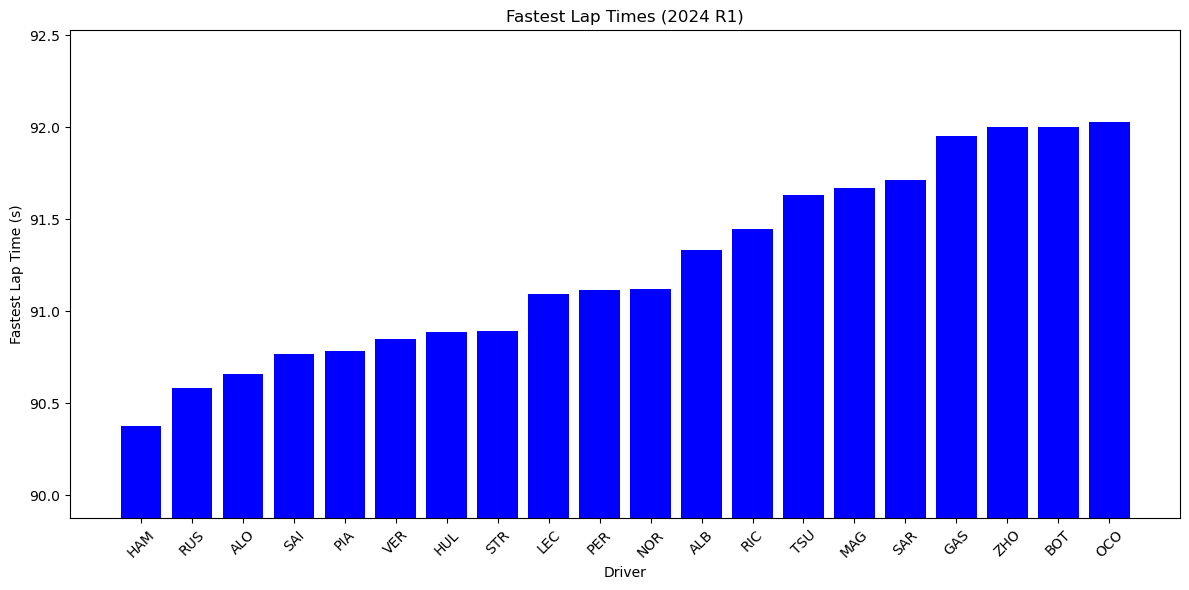


Plot 1 saved to C:\data\Dropbox\dev\F1\raw_data\2024\R1\fastest_vs_theoretical.png


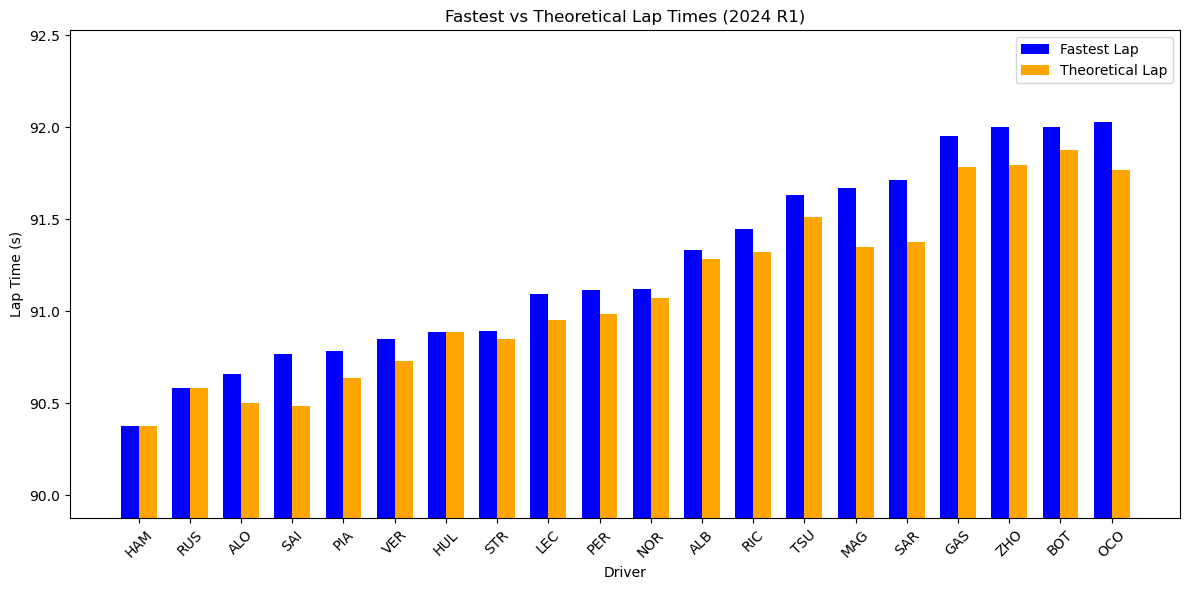


Degradation Slope Histogram saved to C:\data\Dropbox\dev\F1\raw_data\2024\R1\degradation_slope_histogram.png


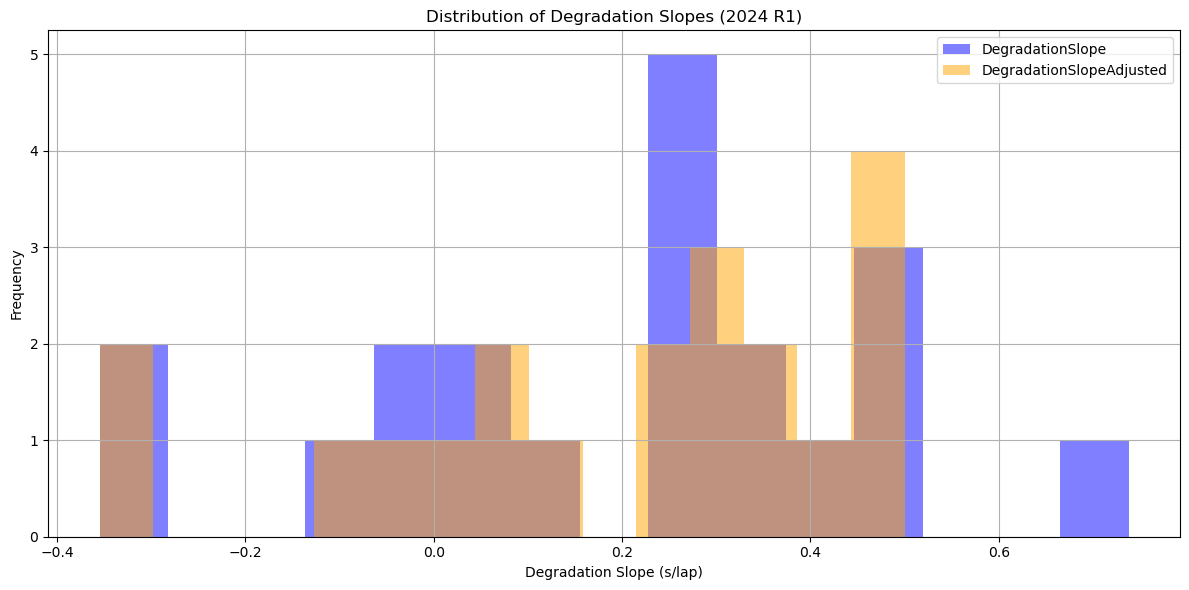


Degradation Slope by Team Boxplot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R1\degradation_slope_by_team.png


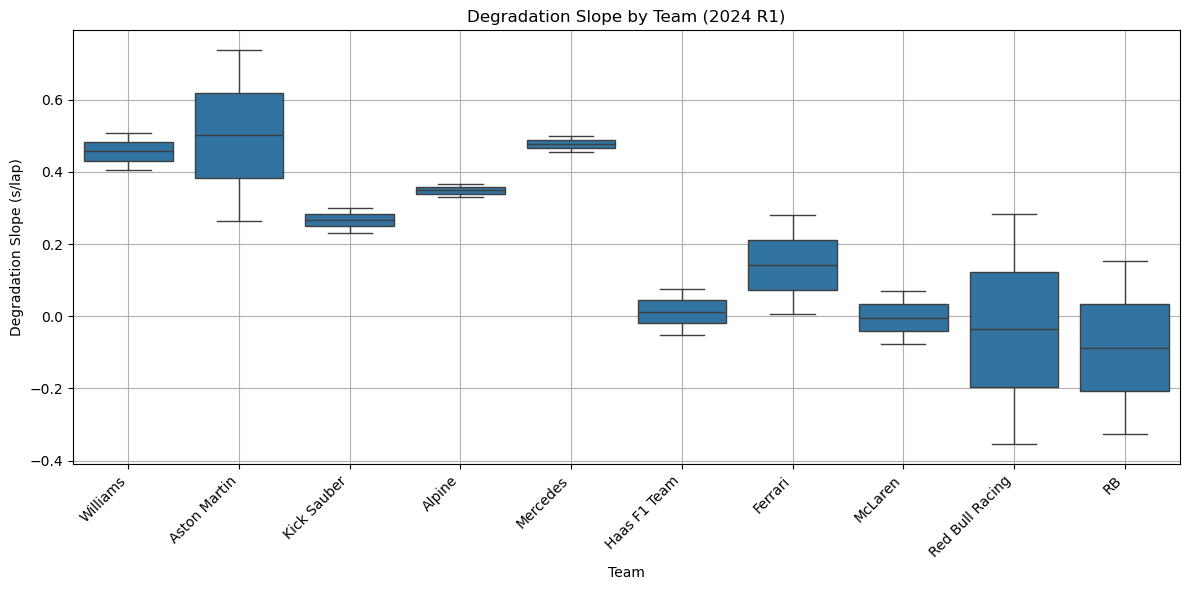


Degradation Slope vs. Base Pace Scatter Plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R1\degradation_slope_vs_basepace.png


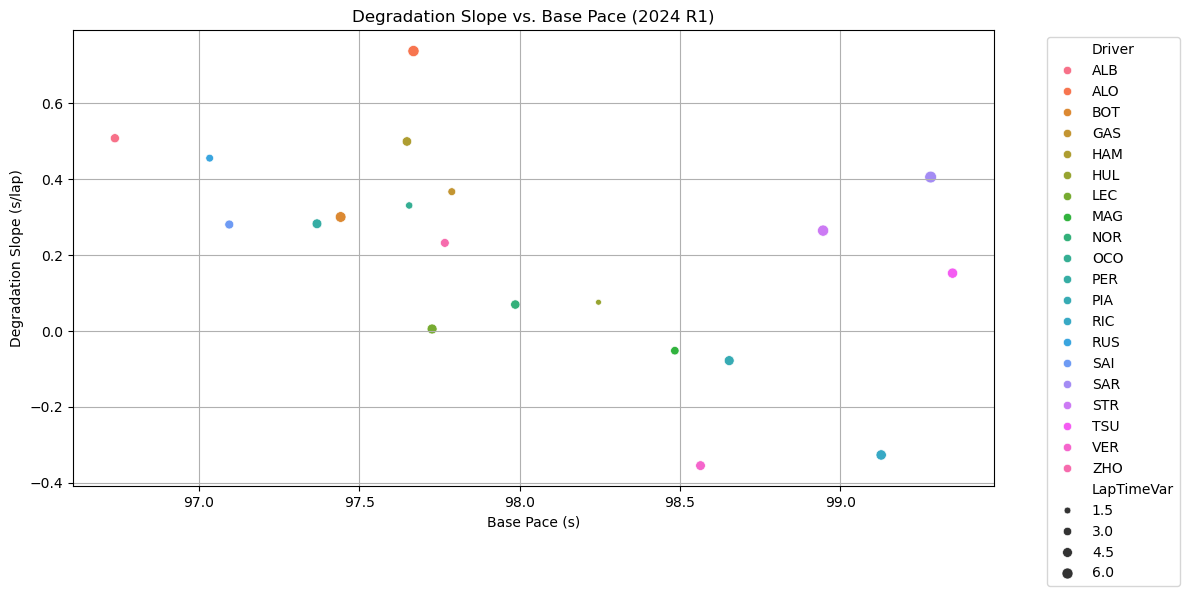


=== Conclusion ===
- Fastest: HAM (90.37s).
Cell 5 execution completed.


In [293]:
# Step 5: Compute Driver Performance Metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
from sklearn.linear_model import RANSACRegressor
import seaborn as sns

logger = logging.getLogger(__name__)

def compute_driver_performance(cleaned_data, target_info, dirs=None, force_redownload=False, visualize=True):
    year = target_info['year']
    round_number = target_info['round']
    track_length = target_info['track_length']

    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    data_dir = os.path.join(DATA_DIR, str(year), f"R{round_number}")
    os.makedirs(data_dir, exist_ok=True)
    driver_file = os.path.join(data_dir, f"{year}_R{round_number}_driver_performance.csv")

    print(f"Entering compute_driver_performance with visualize={visualize}")
    print(f"Checking cache: {driver_file} exists={os.path.exists(driver_file)}, force_redownload={force_redownload}")

    if os.path.exists(driver_file) and not force_redownload:
        driver_performance = pd.read_csv(driver_file)
        logger.info(f"Loaded driver performance from {driver_file}")
    else:
        long_run_laps = []
        sprint_laps = []
        for session_type, data in cleaned_data.items():
            laps = data.copy()
            if session_type == 'Sprint':
                sprint_laps.append(laps)
            else:
                long_run_laps.append(laps[laps['Stint'] >= 3])

        long_run_laps = pd.concat(long_run_laps) if long_run_laps else pd.DataFrame()
        sprint_laps = pd.concat(sprint_laps) if sprint_laps else pd.DataFrame()
        driver_performance = []
        for session_type, data in cleaned_data.items():
            laps = data.copy()
            if laps.empty:
                logger.warning(f"No laps for {session_type}, skipping.")
                continue

            # Log sample sector times before conversion
            print(f"\nSample sector times for {session_type} before conversion (first 5 rows):")
            print(laps[['Driver', 'Sector1Time', 'Sector2Time', 'Sector3Time']].head().to_string())

            # Ensure sector times are numeric
            for sector in ['Sector1Time', 'Sector2Time', 'Sector3Time']:
                if sector not in laps.columns:
                    laps[sector] = np.nan
                laps[sector] = pd.to_numeric(laps[sector], errors='coerce')

            # Log sample sector times after conversion
            print(f"\nSample sector times for {session_type} after conversion (first 5 rows):")
            print(laps[['Driver', 'Sector1Time', 'Sector2Time', 'Sector3Time']].head().to_string())

            best_sectors = laps.groupby('Driver').agg({
                'Sector1Time': lambda x: x.min() if x.notna().any() else np.nan,
                'Sector2Time': lambda x: x.min() if x.notna().any() else np.nan,
                'Sector3Time': lambda x: x.min() if x.notna().any() else np.nan,
                'LapTimeSeconds': 'min',
                'Compound': lambda x: x.mode()[0] if not x.mode().empty else 'UNKNOWN',
                'Team': 'first'
            }).reset_index()

            # Log best sector times before filling
            print(f"\nBest sector times for {session_type} before filling:")
            print(best_sectors[['Driver', 'Sector1Time', 'Sector2Time', 'Sector3Time']].to_string())

            # Fill missing sector times with a fraction of the fastest lap time if available
            for sector in ['Sector1Time', 'Sector2Time', 'Sector3Time']:
                best_sectors[sector] = best_sectors.apply(
                    lambda row: row['LapTimeSeconds'] / 3 if pd.isna(row[sector]) and pd.notna(row['LapTimeSeconds']) else row[sector],
                    axis=1
                )

            # If sector times are still NaN, estimate based on track length proportions
            for sector in ['Sector1Time', 'Sector2Time', 'Sector3Time']:
                best_sectors[sector] = best_sectors[sector].fillna(best_sectors['LapTimeSeconds'] / 3)

            best_sectors.rename(columns={'LapTimeSeconds': 'FastestLapTime'}, inplace=True)

            long_run_driver = long_run_laps[long_run_laps['Driver'].isin(best_sectors['Driver'])]
            # Filter long-run laps to exclude outliers
            if not long_run_driver.empty:
                median_laptime = long_run_driver['LapTimeSeconds'].median()
                std_laptime = long_run_driver['LapTimeSeconds'].std()
                long_run_driver = long_run_driver[
                    (long_run_driver['LapTimeSeconds'] >= median_laptime - std_laptime) &
                    (long_run_driver['LapTimeSeconds'] <= median_laptime + std_laptime)
                ]

            if not sprint_laps.empty and 'Driver' in sprint_laps.columns:
                sprint_driver = sprint_laps[sprint_laps['Driver'].isin(best_sectors['Driver'])]
                base_pace_sprint = sprint_driver.groupby('Driver')['LapTimeSeconds'].mean().reset_index()
                base_pace_sprint.rename(columns={'LapTimeSeconds': 'BasePaceSprint'}, inplace=True)
            else:
                base_pace_sprint = pd.DataFrame(columns=['Driver', 'BasePaceSprint'])
                logger.info("No Sprint session data available; skipping Sprint pace calculation.")

            base_pace_long = long_run_driver.groupby('Driver')['LapTimeSeconds'].mean().reset_index()
            base_pace_long.rename(columns={'LapTimeSeconds': 'BasePaceLong'}, inplace=True)
            base_pace = base_pace_long.merge(base_pace_sprint, on='Driver', how='left')
            base_pace['BasePace'] = base_pace.apply(
                lambda row: (2 * row['BasePaceSprint'] + row['BasePaceLong']) / 3 if pd.notna(row['BasePaceSprint']) else row['BasePaceLong'], axis=1
            )

            lap_time_var = long_run_driver.groupby('Driver')['LapTimeSeconds'].std().reset_index()
            lap_time_var.rename(columns={'LapTimeSeconds': 'LapTimeVar'}, inplace=True)

            # Use RANSAC for more robust degradation slope estimation
            degradation = pd.DataFrame()
            for driver in long_run_driver['Driver'].unique():
                driver_laps = long_run_driver[long_run_driver['Driver'] == driver]
                if len(driver_laps) > 5:  # Need enough data points for regression
                    X = driver_laps['TyreLife'].values.reshape(-1, 1)
                    y = driver_laps['LapTimeSeconds'].values
                    ransac = RANSACRegressor(min_samples=0.75, residual_threshold=std_laptime)
                    ransac.fit(X, y)
                    slope = ransac.estimator_.coef_[0]
                else:
                    slope = 0
                degradation = pd.concat([degradation, pd.DataFrame({'Driver': [driver], 'DegradationSlope': [slope]})], ignore_index=True)
            degradation['DegradationSlopeAdjusted'] = degradation['DegradationSlope'].clip(lower=-0.5, upper=0.5)

            session_metrics = best_sectors.merge(base_pace[['Driver', 'BasePace']], on='Driver', how='left').merge(lap_time_var, on='Driver', how='left').merge(degradation, on='Driver', how='left')
            session_metrics['Session'] = session_type
            driver_performance.append(session_metrics)

        if not driver_performance:
            logger.error("No driver performance data computed after processing all sessions.")
            raise ValueError("No driver performance data computed after processing all sessions.")

        driver_performance = pd.concat(driver_performance)
        # Aggregate the best sector times across all sessions
        driver_performance = driver_performance.groupby('Driver').agg({
            'FastestLapTime': 'min',
            'Sector1Time': 'min',
            'Sector2Time': 'min',
            'Sector3Time': 'min',
            'BasePace': 'mean',
            'LapTimeVar': 'mean',
            'DegradationSlope': 'mean',
            'DegradationSlopeAdjusted': 'mean',
            'Compound': lambda x: x.mode()[0] if not x.mode().empty else 'UNKNOWN',
            'Team': 'first'
        }).reset_index()

        # Compute TheoreticalLapTime as the sum of the best sector times across all sessions
        driver_performance['TheoreticalLapTime'] = (
            driver_performance['Sector1Time'] +
            driver_performance['Sector2Time'] +
            driver_performance['Sector3Time']
        )

        driver_performance.rename(columns={'Compound': 'PrimaryCompound'}, inplace=True)
        driver_performance.fillna({'BasePace': driver_performance['FastestLapTime'] + 5}, inplace=True)
        driver_performance.fillna({'LapTimeVar': driver_performance['BasePace'] * 0.01}, inplace=True)
        driver_performance.fillna({'DegradationSlope': 0, 'DegradationSlopeAdjusted': 0}, inplace=True)
        driver_performance.to_csv(driver_file, index=False)
        logger.info(f"Saved driver performance to {driver_file}")

    if visualize:
        print(f"Visualize block reached in Cell 5 with visualize={visualize}")

        print("\nDriver Performance (Top 5, sorted by TheoreticalLapTime):")
        print(driver_performance.sort_values('TheoreticalLapTime').head().to_string())

        print("\n=== Data Diagnostics ===")
        print(f"Rows in driver_performance: {len(driver_performance)}")
        for col in ['FastestLapTime', 'TheoreticalLapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'BasePace', 'LapTimeVar', 'DegradationSlope', 'DegradationSlopeAdjusted']:
            print(f"{col}: {driver_performance[col].count()}/{len(driver_performance)} valid entries")
        print(f"Long-run laps available: {len(long_run_laps)}")

        plt.figure(figsize=(12, 6))
        sorted_df = driver_performance.sort_values('FastestLapTime')
        plt.bar(sorted_df['Driver'], sorted_df['FastestLapTime'], color='blue')
        plt.xlabel('Driver')
        plt.ylabel('Fastest Lap Time (s)')
        plt.title(f'Fastest Lap Times ({year} R{round_number})')
        plt.xticks(rotation=45)
        plt.ylim(sorted_df['FastestLapTime'].min() - 0.5, sorted_df['FastestLapTime'].max() + 0.5)
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, 'test_plot.png'))
        print(f"\nTest Plot saved to {os.path.join(data_dir, 'test_plot.png')}")
        plt.show()

        plt.figure(figsize=(12, 6))
        bar_width = 0.35
        index = np.arange(len(sorted_df))
        plt.bar(index, sorted_df['FastestLapTime'], bar_width, label='Fastest Lap', color='blue')
        plt.bar(index + bar_width, sorted_df['TheoreticalLapTime'], bar_width, label='Theoretical Lap', color='orange')
        plt.xlabel('Driver')
        plt.ylabel('Lap Time (s)')
        plt.title(f'Fastest vs Theoretical Lap Times ({year} R{round_number})')
        plt.xticks(index + bar_width / 2, sorted_df['Driver'], rotation=45)
        plt.ylim(sorted_df[['FastestLapTime', 'TheoreticalLapTime']].min().min() - 0.5,
                 sorted_df[['FastestLapTime', 'TheoreticalLapTime']].max().max() + 0.5)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, 'fastest_vs_theoretical.png'))
        print(f"\nPlot 1 saved to {os.path.join(data_dir, 'fastest_vs_theoretical.png')}")
        plt.show()

        # New Visualization 1: Histogram of DegradationSlope and DegradationSlopeAdjusted
        plt.figure(figsize=(12, 6))
        plt.hist(driver_performance['DegradationSlope'], bins=15, alpha=0.5, label='DegradationSlope', color='blue')
        plt.hist(driver_performance['DegradationSlopeAdjusted'], bins=15, alpha=0.5, label='DegradationSlopeAdjusted', color='orange')
        plt.xlabel('Degradation Slope (s/lap)')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Degradation Slopes ({year} R{round_number})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, 'degradation_slope_histogram.png'))
        print(f"\nDegradation Slope Histogram saved to {os.path.join(data_dir, 'degradation_slope_histogram.png')}")
        plt.show()

        # New Visualization 2: Boxplot of DegradationSlope by Team
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=driver_performance, x='Team', y='DegradationSlope')
        plt.xlabel('Team')
        plt.ylabel('Degradation Slope (s/lap)')
        plt.title(f'Degradation Slope by Team ({year} R{round_number})')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, 'degradation_slope_by_team.png'))
        print(f"\nDegradation Slope by Team Boxplot saved to {os.path.join(data_dir, 'degradation_slope_by_team.png')}")
        plt.show()

        # New Visualization 3: Scatter Plot of DegradationSlope vs. BasePace
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=driver_performance, x='BasePace', y='DegradationSlope', hue='Driver', size='LapTimeVar')
        plt.xlabel('Base Pace (s)')
        plt.ylabel('Degradation Slope (s/lap)')
        plt.title(f'Degradation Slope vs. Base Pace ({year} R{round_number})')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, 'degradation_slope_vs_basepace.png'))
        print(f"\nDegradation Slope vs. Base Pace Scatter Plot saved to {os.path.join(data_dir, 'degradation_slope_vs_basepace.png')}")
        plt.show()

        fastest_driver = driver_performance.loc[driver_performance['FastestLapTime'].idxmin(), 'Driver']
        fastest_time = driver_performance['FastestLapTime'].min()
        print("\n=== Conclusion ===")
        print(f"- Fastest: {fastest_driver} ({fastest_time:.2f}s).")

    return driver_performance

print("Starting Cell 5 execution...")
driver_performance = compute_driver_performance(cleaned_data, target_info, dirs, force_redownload=True, visualize=True)
print("Cell 5 execution completed.")

Starting Cell 6 execution...
2025-03-22 10:54:13,158 - INFO - Saved telemetry metrics to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_telemetry_metrics.csv

Telemetry Metrics (Top 10 by Max Speed) for Bahrain Grand Prix:
Driver   MaxSpeed  ThrottleTime  BrakingIntensity            Team
   SAR 305.735294     46.442791          0.195704        Williams
   LEC 302.952381     44.782798          0.190750         Ferrari
   ALB 302.657143     37.149027          0.195564        Williams
   TSU 302.000000     42.096254          0.162559              RB
   RUS 301.228571     44.315997          0.185595        Mercedes
   PER 300.736842     47.486624          0.191021 Red Bull Racing
   STR 299.925000     44.654320          0.198669    Aston Martin
   ALO 299.777778     44.497245          0.170359    Aston Martin
   BOT 299.676471     45.797764          0.195094     Kick Sauber
   RIC 299.414634     40.306552          0.169402              RB
Telemetry Metrics plot saved to C:\data\Dropbox\de

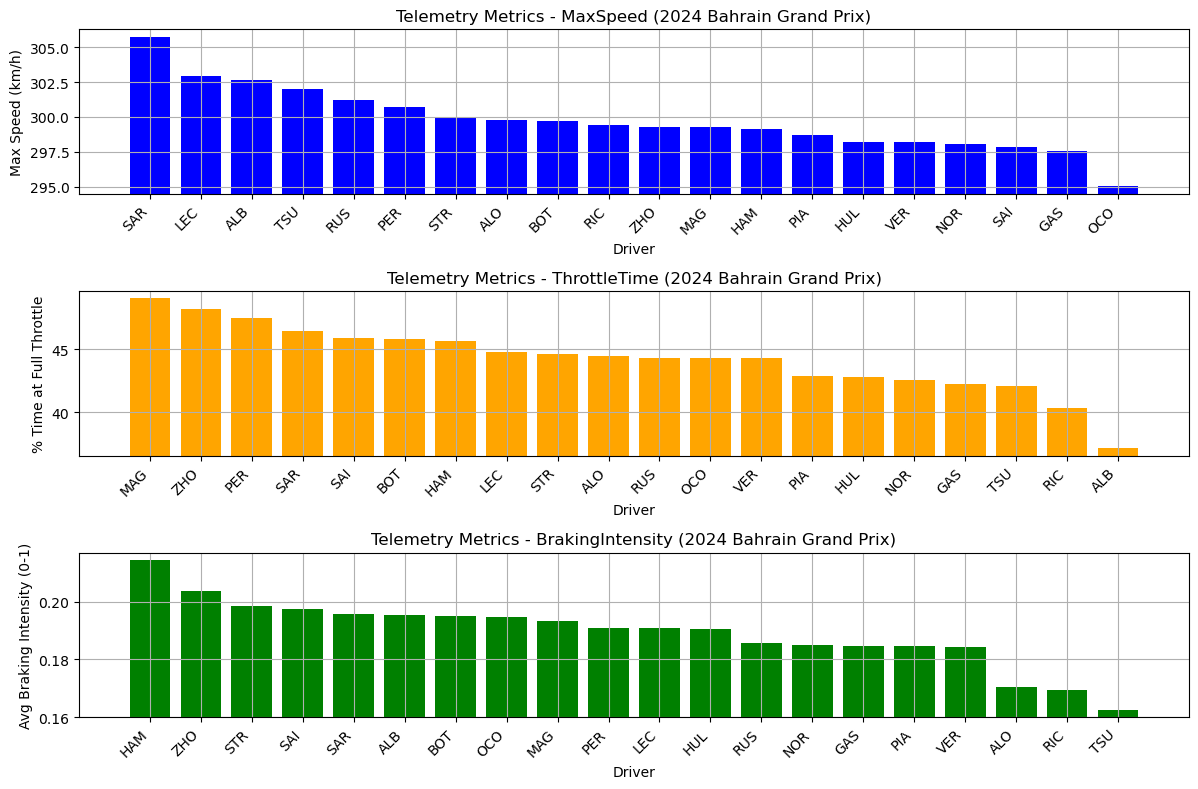


=== Conclusion ===
- Fastest Speed: SAR (305.74 km/h).
- Most Throttle: MAG (49.04%).
Cell 6 execution completed.


In [285]:
# Step 6 - Assess Telemetry Metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def analyze_telemetry_metrics(target_info, cleaned_data, dirs=None, force_redownload=False, visualize=True):
    """
    Analyze telemetry metrics (top speed, throttle time, braking) to infer car setup and driver style.

    Args:
        target_info (dict): Event information from Cell 2.
        cleaned_data (dict): Cleaned lap data from Cell 4.
        dirs (dict, optional): Directory paths from Cell 1.
        force_redownload (bool): Whether to force recomputation of telemetry metrics.
        visualize (bool): Whether to generate visualizations.
    """
    year = target_info['year']
    round_number = target_info['round']
    session_labels = target_info['session_types']
    event_name = target_info.get('event_name', "Unknown Event")
    session_data = target_info['session_data']

    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    data_dir = os.path.join(DATA_DIR, str(year), f"R{round_number}")
    os.makedirs(data_dir, exist_ok=True)
    telemetry_file = os.path.join(data_dir, f"{year}_R{round_number}_telemetry_metrics.csv")

    if os.path.exists(telemetry_file) and not force_redownload:
        logger.info(f"Loading cached telemetry from {telemetry_file}")
        overall_telemetry = pd.read_csv(telemetry_file)
    else:
        telemetry_metrics = []
        for session_label in session_labels:
            if session_label not in cleaned_data or session_label not in session_data:
                logger.warning(f"{session_label} not in cleaned_data or session_data, skipping.")
                continue
            laps = cleaned_data[session_label]
            if laps.empty:
                logger.warning(f"No laps for {session_label}, skipping.")
                continue

            # Filter representative laps
            laps['TrackStatus'] = laps['TrackStatus'].astype(str)
            laps = laps[
                (laps['PitInTime'].isna()) &
                (laps['PitOutTime'].isna()) &
                (laps['TrackStatus'].str.contains('1', na=False))
            ]
            if laps.empty:
                logger.warning(f"No representative laps for {session_label} after filtering.")
                continue

            # Use telemetry from session_data
            session_telemetry = session_data[session_label]['telemetry']
            for _, lap in laps.iterrows():
                driver = lap['Driver']
                lap_number = float(lap['LapNumber'])
                key = (driver, lap_number)
                if key not in session_telemetry:
                    logger.warning(f"No telemetry for {driver} lap {lap_number} in {session_label}.")
                    continue
                lap_telemetry = session_telemetry[key]
                if lap_telemetry.empty:
                    logger.warning(f"Empty telemetry for {driver} lap {lap_number} in {session_label}.")
                    continue
                try:
                    max_speed = lap_telemetry['Speed'].max() if 'Speed' in lap_telemetry.columns else np.nan
                    throttle_time = (lap_telemetry['Throttle'] > 95).mean() * 100 if 'Throttle' in lap_telemetry.columns else np.nan
                    braking_intensity = lap_telemetry['Brake'].mean() if 'Brake' in lap_telemetry.columns else np.nan
                    telemetry_metrics.append({
                        'Driver': driver,
                        'MaxSpeed': max_speed,
                        'ThrottleTime': throttle_time,
                        'BrakingIntensity': braking_intensity,
                        'Team': lap['Team']
                    })
                except Exception as e:
                    logger.warning(f"Failed to process telemetry for {driver} lap {lap_number} in {session_label}: {e}")

        if not telemetry_metrics:
            logger.error("No telemetry data processed. Check session_data in target_info.")
            overall_telemetry = pd.DataFrame(columns=['Driver', 'MaxSpeed', 'ThrottleTime', 'BrakingIntensity', 'Team'])
        else:
            all_telemetry = pd.DataFrame(telemetry_metrics)
            overall_telemetry = all_telemetry.groupby('Driver').mean(numeric_only=True).reset_index()
            overall_telemetry = overall_telemetry.merge(all_telemetry[['Driver', 'Team']].drop_duplicates(), on='Driver', how='left')
            overall_telemetry.to_csv(telemetry_file, index=False)
            logger.info(f"Saved telemetry metrics to {telemetry_file}")

    # Visualization
    if visualize:
        print(f"\nTelemetry Metrics (Top 10 by Max Speed) for {event_name}:")
        print(overall_telemetry.sort_values('MaxSpeed', ascending=False).head(10).to_string(index=False))

        plt.figure(figsize=(12, 8))
        metrics = ['MaxSpeed', 'ThrottleTime', 'BrakingIntensity']
        titles = ['Max Speed (km/h)', '% Time at Full Throttle', 'Avg Braking Intensity (0-1)']
        colors = ['blue', 'orange', 'green']

        for i, (metric, title, color) in enumerate(zip(metrics, titles, colors), 1):
            plt.subplot(3, 1, i)
            plot_data = overall_telemetry[overall_telemetry['ThrottleTime'] > 0] if metric == 'ThrottleTime' else overall_telemetry
            if plot_data.empty:
                print(f"Warning: No data available for plotting {metric}.")
                continue
            sorted_data = plot_data.sort_values(metric, ascending=False)
            plt.bar(sorted_data['Driver'], sorted_data[metric], color=color)
            y_min = sorted_data[metric].min()
            y_max = sorted_data[metric].max()
            y_range = y_max - y_min if y_max != y_min else 1
            plt.ylim(y_min - 0.05 * y_range, y_max + 0.05 * y_range)
            plt.xlabel('Driver')
            plt.ylabel(title)
            plt.title(f'Telemetry Metrics - {metric} ({year} {event_name})')
            plt.xticks(rotation=45, ha='right')
            plt.grid(True)

        plt.tight_layout()
        plot_file = os.path.join(data_dir, "telemetry_metrics.png")
        plt.savefig(plot_file)
        print(f"Telemetry Metrics plot saved to {plot_file}")
        plt.show(block=True)

        print("\n=== Conclusion ===")
        if not overall_telemetry.empty:
            top_speed_driver = overall_telemetry.loc[overall_telemetry['MaxSpeed'].idxmax(), 'Driver']
            print(f"- Fastest Speed: {top_speed_driver} ({overall_telemetry['MaxSpeed'].max():.2f} km/h).")
            top_throttle = overall_telemetry[overall_telemetry['ThrottleTime'] > 0]
            if not top_throttle.empty:
                top_throttle_driver = top_throttle.loc[top_throttle['ThrottleTime'].idxmax(), 'Driver']
                print(f"- Most Throttle: {top_throttle_driver} ({top_throttle['ThrottleTime'].max():.2f}%).")
        else:
            print("No telemetry data available. Check session_data in target_info or FastF1 data availability.")

    return overall_telemetry

# In notebook, execute directly (assumes Cells 1-5 ran)
print("Starting Cell 6 execution...")
telemetry_metrics = analyze_telemetry_metrics(target_info, cleaned_data, dirs, force_redownload=True, visualize=True)
print("Cell 6 execution completed.")

Starting Cell 7 execution...
2025-03-22 10:54:14,420 - INFO - Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_sandbag_analysis.csv

Potential Sandbaggers (Sorted by PredictionDiscrepancy):
Driver  FastestLapTime     Team  Sector1Time  Sector2Time  Sector3Time   MaxSpeed  ThrottleTime  ExpectedLapTime  LapTimeDiscrepancy  PredictedLapTime  PredictionDiscrepancy  SpeedRank  LapTimeRank  SandbagFlag
   SAR          91.715 Williams       29.308       39.142       22.925 305.735294     46.442791           91.375                0.34         91.227110               0.487890        1.0         16.0         True
   TSU          91.631       RB       29.091       39.472       22.948 302.000000     42.096254           91.511                0.12         91.238244               0.392756        4.0         14.0         True
Sandbagging Analysis plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R1\sandbagging_analysis.png


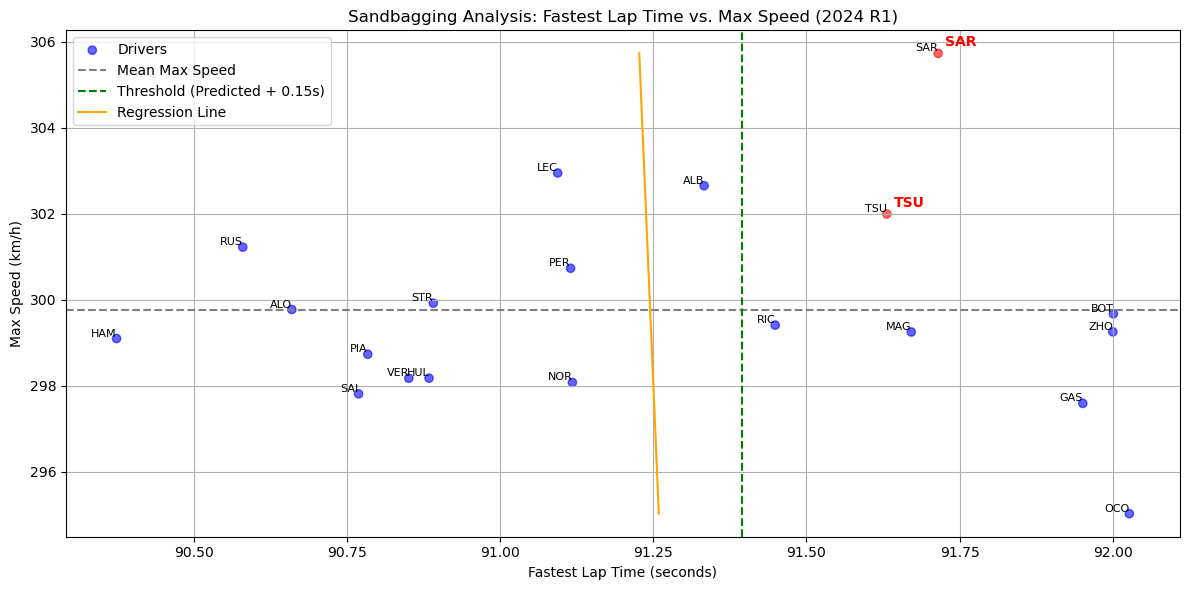

Cell 7 execution completed.


In [286]:
# Step 7: Sandbagging Analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def investigate_sandbagging(target_info, driver_performance, telemetry_metrics, dirs=None, force_redownload=False, visualize=True):
    """
    Detect teams hiding pace by comparing lap times to telemetry metrics.

    Args:
        target_info (dict): Configuration dictionary from Cell 2
        driver_performance (pd.DataFrame): Driver performance data from Cell 5
        telemetry_metrics (pd.DataFrame): Telemetry metrics from Cell 6
        dirs (dict): Directory paths from Cell 1
        force_redownload (bool): Force recalculation even if cached
        visualize (bool): Display visualizations

    Returns:
        pd.DataFrame: Sandbagging analysis results
    """
    year = target_info['year']
    round_number = target_info['round']
    sandbag_threshold = 0.15  # Default threshold

    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    data_dir = os.path.join(DATA_DIR, str(year), f"R{round_number}")
    os.makedirs(data_dir, exist_ok=True)
    output_file = os.path.join(data_dir, f"{year}_R{round_number}_sandbag_analysis.csv")

    if os.path.exists(output_file) and not force_redownload:
        logger.info(f"Loading cached sandbag analysis from {output_file}")
        sandbag_analysis = pd.read_csv(output_file)
    else:
        # Merge data
        sandbag_analysis = driver_performance[['Driver', 'FastestLapTime', 'Team', 'Sector1Time', 'Sector2Time', 'Sector3Time']].merge(
            telemetry_metrics[['Driver', 'MaxSpeed', 'ThrottleTime']], on='Driver', how='left'
        )

        # Check for missing data
        if sandbag_analysis.empty:
            logger.error("No data available after merging driver_performance and telemetry_metrics.")
            return pd.DataFrame()

        # Handle NaN values in telemetry metrics
        if sandbag_analysis[['MaxSpeed', 'ThrottleTime']].isna().any().any():
            logger.warning("NaN values found in telemetry metrics. Filling with median values.")
            sandbag_analysis['MaxSpeed'] = sandbag_analysis['MaxSpeed'].fillna(telemetry_metrics['MaxSpeed'].median())
            sandbag_analysis['ThrottleTime'] = sandbag_analysis['ThrottleTime'].fillna(telemetry_metrics['ThrottleTime'].median())

        # Calculate expected lap time
        sandbag_analysis['ExpectedLapTime'] = sandbag_analysis['Sector1Time'] + sandbag_analysis['Sector2Time'] + sandbag_analysis['Sector3Time']
        sandbag_analysis['LapTimeDiscrepancy'] = sandbag_analysis['FastestLapTime'] - sandbag_analysis['ExpectedLapTime']

        # Predict FastestLapTime from MaxSpeed using linear regression
        X = sandbag_analysis[['MaxSpeed']].values
        y = sandbag_analysis['FastestLapTime'].values
        reg = LinearRegression().fit(X, y)
        sandbag_analysis['PredictedLapTime'] = reg.predict(X)
        sandbag_analysis['PredictionDiscrepancy'] = sandbag_analysis['FastestLapTime'] - sandbag_analysis['PredictedLapTime']
        sandbag_analysis['SpeedRank'] = sandbag_analysis['MaxSpeed'].rank(ascending=False)
        sandbag_analysis['LapTimeRank'] = sandbag_analysis['FastestLapTime'].rank()

        # Flag sandbaggers
        mean_max_speed = sandbag_analysis['MaxSpeed'].mean()
        sandbag_analysis['SandbagFlag'] = (sandbag_analysis['MaxSpeed'] > mean_max_speed) & (sandbag_analysis['PredictionDiscrepancy'] > sandbag_threshold)

        sandbag_analysis.to_csv(output_file, index=False)
        logger.info(f"Saved sandbag analysis to {output_file}")

    # Visualization
    if visualize:
        print("\nPotential Sandbaggers (Sorted by PredictionDiscrepancy):")
        print(sandbag_analysis[sandbag_analysis['SandbagFlag']].sort_values('PredictionDiscrepancy', ascending=False).to_string(index=False))

        # Ensure mean_max_speed and reg are defined for visualization
        mean_max_speed = sandbag_analysis['MaxSpeed'].mean()
        X = sandbag_analysis[['MaxSpeed']].values
        y = sandbag_analysis['FastestLapTime'].values
        reg = LinearRegression().fit(X, y)

        plt.figure(figsize=(12, 6))
        colors = ['blue' if not flag else 'red' for flag in sandbag_analysis['SandbagFlag']]
        plt.scatter(sandbag_analysis['FastestLapTime'], sandbag_analysis['MaxSpeed'], c=colors, label='Drivers', alpha=0.6)
        plt.axhline(y=mean_max_speed, color='gray', linestyle='--', label='Mean Max Speed')
        plt.axvline(x=sandbag_analysis['PredictedLapTime'].mean() + sandbag_threshold, color='green', linestyle='--', label=f'Threshold (Predicted + {sandbag_threshold}s)')
        x_range = np.array([[sandbag_analysis['MaxSpeed'].min()], [sandbag_analysis['MaxSpeed'].max()]])
        y_pred = reg.predict(x_range)
        plt.plot(y_pred, x_range, color='orange', linestyle='-', label='Regression Line')
        for i, row in sandbag_analysis.iterrows():
            plt.text(row['FastestLapTime'], row['MaxSpeed'], row['Driver'], fontsize=8, ha='right', va='bottom')
            if row['SandbagFlag']:
                plt.annotate(row['Driver'], (row['FastestLapTime'], row['MaxSpeed']), xytext=(5, 5), textcoords='offset points', fontsize=10, color='red', weight='bold')
        plt.xlabel('Fastest Lap Time (seconds)')
        plt.ylabel('Max Speed (km/h)')
        plt.title(f'Sandbagging Analysis: Fastest Lap Time vs. Max Speed ({year} R{round_number})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plot_file = os.path.join(data_dir, "sandbagging_analysis.png")
        plt.savefig(plot_file)
        print(f"Sandbagging Analysis plot saved to {plot_file}")
        plt.show(block=True)

    return sandbag_analysis

# In notebook, execute directly (assumes Cells 1-6 ran)
print("Starting Cell 7 execution...")
sandbag_analysis = investigate_sandbagging(target_info, driver_performance, telemetry_metrics, dirs, force_redownload=True,visualize=True)
print("Cell 7 execution completed.")

Starting Cell 8 execution...
2025-03-22 10:54:16,170 - INFO - Average lap time for Practice 1: 109.420 seconds (±17.589)
2025-03-22 10:54:16,173 - INFO - Average lap time for Practice 2: 105.897 seconds (±16.219)
2025-03-22 10:54:16,175 - INFO - Average lap time for Practice 3: 114.269 seconds (±20.159)
2025-03-22 10:54:16,180 - INFO - Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_track_evolution.csv

Average Lap Times Across Sessions:
   Session  AvgLapTime  StdLapTime  LapCount
Practice 1  109.420408   17.589022       355
Practice 2  105.897307   16.218577       430
Practice 3  114.268758   20.159178       227

Average Weather Conditions Across Sessions:
   Session   AirTemp  Humidity  Rainfall  TrackTemp
Practice 1 19.373171 38.743902       0.0  34.215854
Practice 2 17.247561 39.024390       0.0  22.098780
Practice 3 20.259756 35.719512       0.0  32.013415

Correlation between AvgLapTime and TrackTemp: 0.707
Track Evolution plot saved to C:\data\Dropbox\d

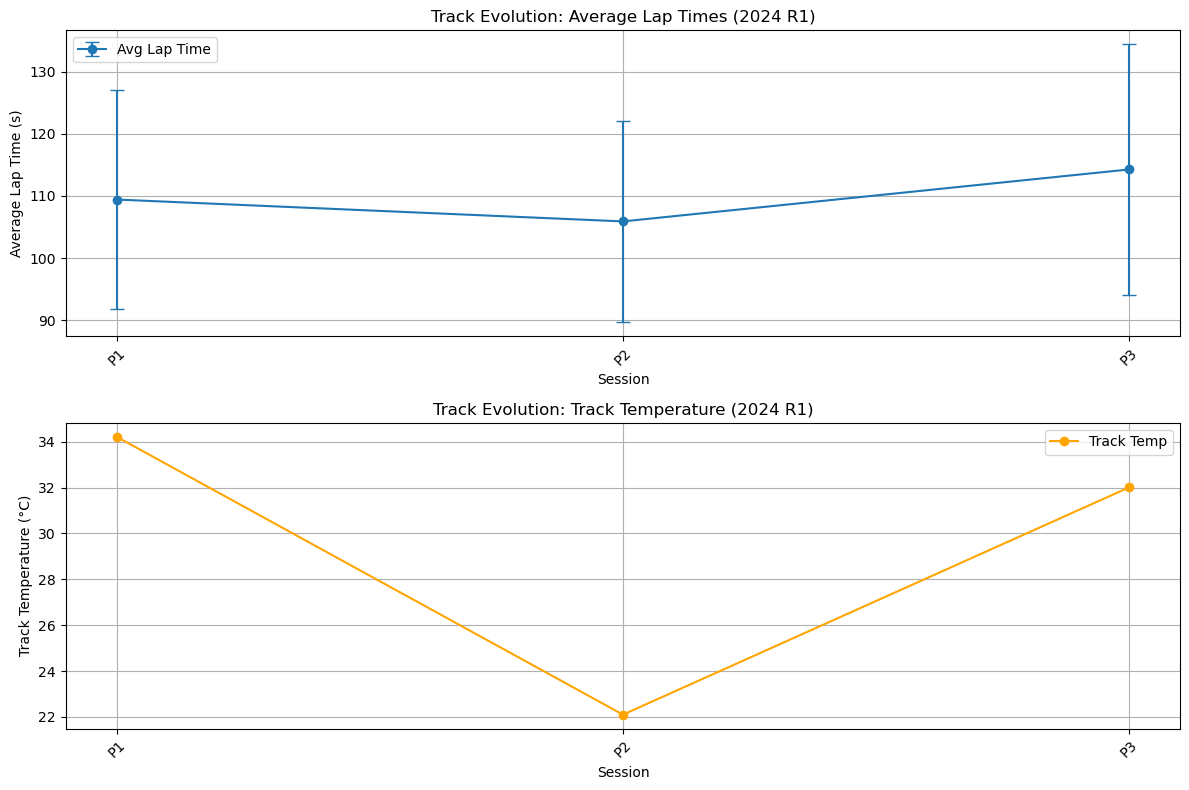

Cell 8 execution completed.


In [287]:
# Step 8: Track Evolution and Weather Analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def evaluate_track_evolution(target_info, cleaned_data, dirs=None, force_redownload=False, visualize=True):
    """
    Analyze track evolution and weather impact across sessions.

    Args:
        target_info (dict): Event information from Cell 2
        cleaned_data (dict): Cleaned lap data from Cell 4
        dirs (dict): Directory paths from Cell 1
        force_redownload (bool): Force recalculation even if cached
        visualize (bool): Display visualizations

    Returns:
        pd.DataFrame: Track evolution data
    """
    year = target_info['year']
    round_number = target_info['round']
    session_data = target_info['session_data']

    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    data_dir = os.path.join(DATA_DIR, str(year), f"R{round_number}")
    os.makedirs(data_dir, exist_ok=True)
    output_file = os.path.join(data_dir, f"{year}_R{round_number}_track_evolution.csv")

    if os.path.exists(output_file) and not force_redownload:
        logger.info(f"Loading cached track evolution from {output_file}")
        track_evolution = pd.read_csv(output_file)
    else:
        track_evolution = []
        for session in cleaned_data:
            laps = cleaned_data[session]
            if laps.empty:
                logger.warning(f"No lap data for {session}, skipping.")
                continue
            avg_lap_time = laps['LapTimeSeconds'].mean()
            std_lap_time = laps['LapTimeSeconds'].std()
            lap_count = len(laps)
            logger.info(f"Average lap time for {session}: {avg_lap_time:.3f} seconds (±{std_lap_time:.3f})")
            track_evolution.append({
                'Session': session,
                'AvgLapTime': avg_lap_time,
                'StdLapTime': std_lap_time,
                'LapCount': lap_count
            })

        track_evolution = pd.DataFrame(track_evolution)
        if track_evolution.empty:
            logger.warning("No track evolution data computed; creating default DataFrame.")
            track_evolution = pd.DataFrame(columns=['Session', 'AvgLapTime', 'StdLapTime', 'LapCount'])

        track_evolution.to_csv(output_file, index=False)
        logger.info(f"Saved track evolution to {output_file}")

    # Weather Analysis
    weather_data = []
    for session in session_data:
        weather = session_data[session]['weather']
        if weather.empty:
            logger.warning(f"No weather data for {session}, skipping.")
            continue
        weather['Session'] = session
        weather_data.append(weather[['Session', 'AirTemp', 'Humidity', 'Rainfall', 'TrackTemp']])

    weather_data = pd.concat(weather_data, ignore_index=True) if weather_data else pd.DataFrame()
    if not weather_data.empty:
        weather_summary = weather_data.groupby('Session').mean(numeric_only=True).reset_index()

    # Visualization
    if visualize:
        print("\nAverage Lap Times Across Sessions:")
        print(track_evolution.to_string(index=False))

        if not weather_data.empty:
            print("\nAverage Weather Conditions Across Sessions:")
            print(weather_summary.to_string(index=False))

        # Correlation Analysis
        if not track_evolution.empty and not weather_summary.empty:
            overlapping_sessions = set(track_evolution['Session']).intersection(set(weather_summary['Session']))
            if len(overlapping_sessions) >= 2:
                merged_data = track_evolution.merge(weather_summary, on='Session', how='inner')
                correlation = merged_data['AvgLapTime'].corr(merged_data['TrackTemp'])
                print(f"\nCorrelation between AvgLapTime and TrackTemp: {correlation:.3f}")
            else:
                print("\nNot enough overlapping sessions for correlation analysis with TrackTemp.")

        # Plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Define a mapping for session names to concise labels
        session_label_map = {
            'Practice 1': 'P1',
            'Practice 2': 'P2',
            'Practice 3': 'P3',
            'Sprint Qualifying': 'SQ',
            'Sprint': 'S'
        }

        # Plot average lap times
        if not track_evolution.empty:
            sessions = track_evolution['Session'].tolist()
            avg_lap_times = track_evolution['AvgLapTime'].tolist()
            std_lap_times = track_evolution['StdLapTime'].tolist()
            # Map session names to concise labels
            session_labels = [session_label_map.get(s, s) for s in sessions]
            ax1.errorbar(session_labels, avg_lap_times, yerr=std_lap_times, fmt='o-', capsize=5, label='Avg Lap Time')
            ax1.set_xlabel('Session')
            ax1.set_ylabel('Average Lap Time (s)')
            ax1.set_title(f'Track Evolution: Average Lap Times ({year} R{round_number})')
            ax1.grid(True)
            ax1.legend()
            ax1.set_xticks(range(len(session_labels)))
            ax1.set_xticklabels(session_labels, rotation=45)
        else:
            ax1.text(0.5, 0.5, "No lap time data available", ha='center', va='center')
            ax1.set_xlabel('Session')
            ax1.set_ylabel('Average Lap Time (s)')
            ax1.set_title(f'Track Evolution: Average Lap Times ({year} R{round_number})')

        # Plot track temperature
        if not weather_summary.empty:
            sessions = weather_summary['Session'].tolist()
            track_temps = weather_summary['TrackTemp'].tolist()
            # Map session names to concise labels
            session_labels = [session_label_map.get(s, s) for s in sessions]
            ax2.plot(session_labels, track_temps, 'o-', color='orange', label='Track Temp')
            ax2.set_xlabel('Session')
            ax2.set_ylabel('Track Temperature (°C)')
            ax2.set_title(f'Track Evolution: Track Temperature ({year} R{round_number})')
            ax2.grid(True)
            ax2.legend()
            ax2.set_xticks(range(len(session_labels)))
            ax2.set_xticklabels(session_labels, rotation=45)
        else:
            ax2.text(0.5, 0.5, "No weather data available", ha='center', va='center')
            ax2.set_xlabel('Session')
            ax2.set_ylabel('Track Temperature (°C)')
            ax2.set_title(f'Track Evolution: Track Temperature ({year} R{round_number})')

        plt.tight_layout()
        plot_file = os.path.join(data_dir, "track_evolution.png")
        plt.savefig(plot_file)
        print(f"Track Evolution plot saved to {plot_file}")
        plt.show(block=True)

    return track_evolution

# In notebook, execute directly (assumes Cells 1-7 ran)
print("Starting Cell 8 execution...")
track_evolution = evaluate_track_evolution(target_info, cleaned_data, dirs, force_redownload=True, visualize=True)
print("Cell 8 execution completed.")

Starting Cell 9 execution...
2025-03-22 10:54:17,870 - INFO - Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_track_characteristics.csv
2025-03-22 10:54:17,875 - INFO - Saved track char drivers to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_track_char_drivers.csv
Track Characteristics:
             Track DownforceRequirement OvertakingDifficulty  DRSZones TyreDegradation  LapLength SuitsFastCars
Bahrain Grand Prix                  Low                 Easy         3             Low      5.412           Yes

Top 5 Drivers by Track Fit:
Driver     Team  StraightSpeedPotential  CorneringPotential   AvgSpeed  OverallFit  FitRank
   SAR Williams              305.735294           30.458333 212.431990    0.996714      1.0
   LEC  Ferrari              302.952381           30.317000 213.880168    0.991725      2.0
   ALB Williams              302.657143           30.428333 213.320487    0.989958      3.0
   RUS Mercedes              301.228571           30.1933

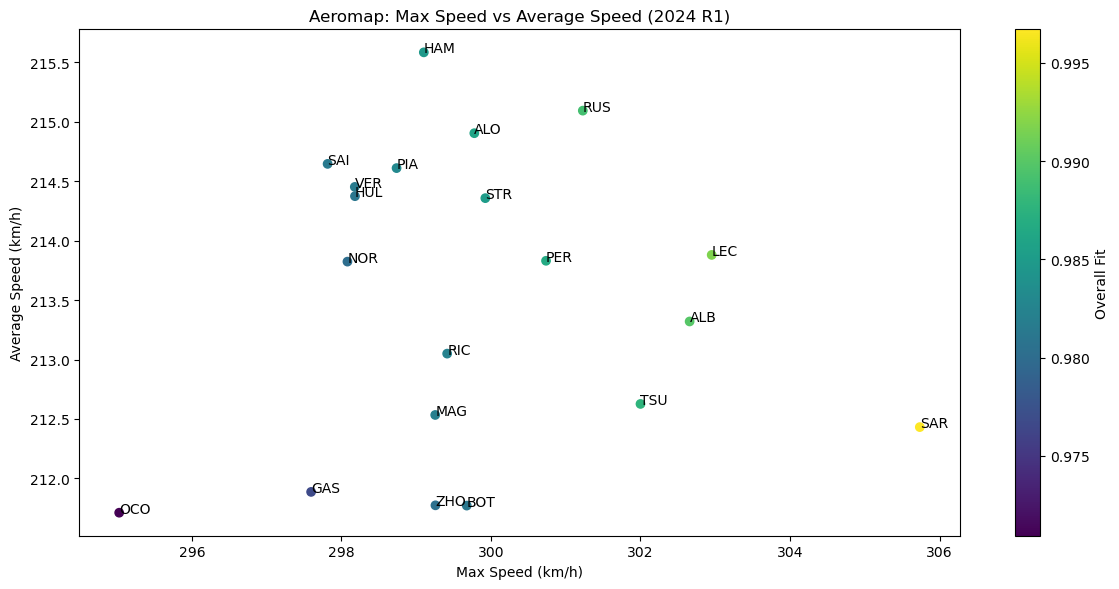

Cell 9 execution completed.


In [288]:
# Step 9: Analyze Track Characteristics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging

logger = logging.getLogger(__name__)

def analyze_track_characteristics(driver_performance_df, telemetry_metrics_df, target_info, dirs=None, force_redownload=False, visualize=True):
    year = target_info['year']
    round_number = target_info['round']
    event_name = target_info.get('event_name', "Unknown Event")
    track_length = target_info.get('track_length', 5.0)

    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    round_data_dir = os.path.join(DATA_DIR, str(year), f"R{round_number}")
    track_char_file = os.path.join(round_data_dir, f"{year}_R{round_number}_track_characteristics.csv")
    track_char_drivers_file = os.path.join(round_data_dir, f"{year}_R{round_number}_track_char_drivers.csv")

    if os.path.exists(track_char_file) and os.path.exists(track_char_drivers_file) and not force_redownload:
        track_char_df = pd.read_csv(track_char_file)
        track_char_drivers_df = pd.read_csv(track_char_drivers_file)
        logger.info(f"Loaded track characteristics from {track_char_file}")
        logger.info(f"Loaded track char drivers from {track_char_drivers_file}")
    else:
        # Track Characteristics
        track_char = pd.DataFrame({
            'Track': [event_name],
            'DownforceRequirement': ['Low' if track_length > 5 else 'Medium'],
            'OvertakingDifficulty': ['Easy' if track_length > 5 else 'Medium'],
            'DRSZones': [3 if track_length > 5 else 2],
            'TyreDegradation': ['Low' if track_length > 5 else 'Medium'],
            'LapLength': [track_length],
            'SuitsFastCars': ['Yes' if track_length > 5 else 'No']
        })

        # Driver Track Fit
        track_char_drivers_df = driver_performance_df[['Driver', 'Team']].copy()
        track_char_drivers_df = track_char_drivers_df.merge(telemetry_metrics_df[['Driver', 'MaxSpeed']], on='Driver', how='left')
        track_char_drivers_df['StraightSpeedPotential'] = track_char_drivers_df['MaxSpeed'].apply(
            lambda x: x if pd.notna(x) else 300
        )
        track_char_drivers_df = track_char_drivers_df.merge(
            driver_performance_df[['Driver', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'FastestLapTime']],
            on='Driver', how='left'
        )
        track_char_drivers_df['CorneringPotential'] = track_char_drivers_df[['Sector1Time', 'Sector2Time', 'Sector3Time']].mean(axis=1)
        track_char_drivers_df['AvgSpeed'] = (track_length * 3600) / track_char_drivers_df['FastestLapTime']
        track_char_drivers_df['OverallFit'] = (
            (track_char_drivers_df['StraightSpeedPotential'] / track_char_drivers_df['StraightSpeedPotential'].max()) * 0.7 +
            (track_char_drivers_df['CorneringPotential'].min() / track_char_drivers_df['CorneringPotential']) * 0.3
        )
        track_char_drivers_df['FitRank'] = track_char_drivers_df['OverallFit'].rank(ascending=False)

        # Save track characteristics
        try:
            track_char.to_csv(track_char_file, index=False)
            logger.info(f"Saved track characteristics to {track_char_file}")
        except Exception as e:
            logger.error(f"Failed to save track characteristics to {track_char_file}: {str(e)}")
            raise

        # Save driver track fit
        try:
            track_char_drivers_df.to_csv(track_char_drivers_file, index=False)
            logger.info(f"Saved track char drivers to {track_char_drivers_file}")
        except Exception as e:
            logger.error(f"Failed to save track char drivers to {track_char_drivers_file}: {str(e)}")
            raise

    if visualize:
        print("Track Characteristics:")
        print(track_char.to_string(index=False))
        print("\nTop 5 Drivers by Track Fit:")
        print(track_char_drivers_df.sort_values('FitRank')[['Driver', 'Team', 'StraightSpeedPotential', 'CorneringPotential', 'AvgSpeed', 'OverallFit', 'FitRank']].head().to_string(index=False))

        plt.figure(figsize=(12, 6))
        plt.scatter(track_char_drivers_df['MaxSpeed'], track_char_drivers_df['AvgSpeed'], c=track_char_drivers_df['OverallFit'], cmap='viridis')
        for i, row in track_char_drivers_df.iterrows():
            plt.annotate(row['Driver'], (row['MaxSpeed'], row['AvgSpeed']))
        plt.colorbar(label='Overall Fit')
        plt.xlabel('Max Speed (km/h)')
        plt.ylabel('Average Speed (km/h)')
        plt.title(f'Aeromap: Max Speed vs Average Speed ({year} R{round_number})')
        plot_file = os.path.join(DATA_DIR, "reports", str(year), f"R{round_number}", f"{year}_R{round_number}_aeromap.png")
        os.makedirs(os.path.dirname(plot_file), exist_ok=True)
        plt.savefig(plot_file, format='png', bbox_inches='tight')
        print(f"Saved plot to {plot_file}")
        plt.show()

    return track_char_drivers_df

print("Starting Cell 9 execution...")
track_char_drivers = analyze_track_characteristics(driver_performance, telemetry_metrics, target_info, dirs, force_redownload=True, visualize=True)
print("Cell 9 execution completed.")

Starting Cell 10 execution...
2025-03-22 11:10:21,072 - INFO - Loaded pit_stop_loss from file: 20.00s for Bahrain Grand Prix
2025-03-22 11:10:21,106 - INFO - No Sprint session data available; setting SprintPaceAdjustment to 0 for all drivers.
2025-03-22 11:10:21,129 - INFO - Predicted Fastest Lap Driver: HAM
2025-03-22 11:10:21,141 - INFO - Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_quali_prediction.csv
2025-03-22 11:10:21,143 - INFO - Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_race_prediction.csv

Qualifying Prediction:
Driver            Team  LapTime  ExpectedLapTime  AdjustedLapTime  QualiPosition
   SAI         Ferrari   90.769           90.483           90.197              1
   ALO    Aston Martin   90.660           90.500           90.340              2
   HAM        Mercedes   90.374           90.374           90.374              3
   PIA         McLaren   90.784           90.635           90.486              4
  

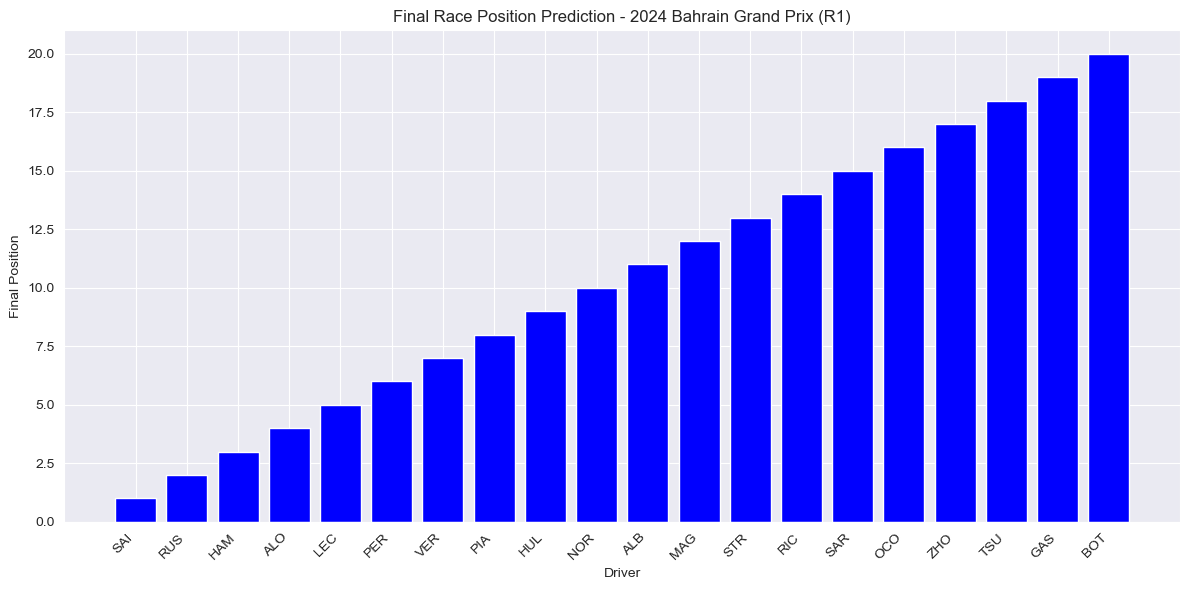

Cell 10 execution completed.


In [297]:
# Step 10: Race Strategy and Final Prediction
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

logger = logging.getLogger(__name__)

def predict_race_outcomes(target_info, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df, track_evolution_df, track_char_drivers_df, dirs=None, pit_stop_loss_default=25, overtaking_penalty=0.5, visualize=True):
    year = target_info['year']
    round_number = target_info['round']
    race_laps = target_info.get('race_laps', 50)
    event_name = target_info.get('event_name', "Unknown Event")
    track_degradation = target_info.get('track_degradation', 'Medium')  # From Cell 9

    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    round_data_dir = os.path.join(DATA_DIR, str(year), f"R{round_number}")
    os.makedirs(round_data_dir, exist_ok=True)

    pit_stop_file = os.path.join(DATA_DIR, "pit_stop_loss_by_track.csv")
    if os.path.exists(pit_stop_file):
        pit_stop_df = pd.read_csv(pit_stop_file)
        if event_name in pit_stop_df['Track'].values:
            pit_stop_loss = pit_stop_df.loc[pit_stop_df['Track'] == event_name, 'PitStopLoss'].values[0]
            logger.info(f"Loaded pit_stop_loss from file: {pit_stop_loss:.2f}s for {event_name}")
        else:
            pit_stop_loss = pit_stop_loss_default
            logger.info(f"No pit_stop_loss found for {event_name} in file, using default: {pit_stop_loss}s")
    else:
        pit_stop_loss = pit_stop_loss_default
        logger.info(f"Pit stop loss file not found, using default: {pit_stop_loss}s")

    # Fill missing values in driver_performance_df
    driver_performance_df['BasePace'] = driver_performance_df['BasePace'].fillna(driver_performance_df['FastestLapTime'] + 5)
    driver_performance_df['DegradationSlopeAdjusted'] = driver_performance_df['DegradationSlopeAdjusted'].fillna(0.0)  # Use adjusted slope, default to 0 if missing

    # Qualifying Prediction
    quali_prediction = driver_performance_df[['Driver', 'FastestLapTime', 'Team']].copy()
    quali_prediction = quali_prediction.rename(columns={'FastestLapTime': 'LapTime'})
    quali_prediction['ExpectedLapTime'] = driver_performance_df['Sector1Time'] + driver_performance_df['Sector2Time'] + driver_performance_df['Sector3Time']
    quali_prediction = quali_prediction.merge(sandbag_analysis_df[['Driver', 'LapTimeDiscrepancy', 'SandbagFlag']], on='Driver', how='left')
    quali_prediction = quali_prediction.merge(track_char_drivers_df[['Driver', 'OverallFit']], on='Driver', how='left')
    quali_prediction['AdjustedLapTime'] = quali_prediction.apply(
        lambda row: row['ExpectedLapTime'] - row.get('LapTimeDiscrepancy', 0) if (row.get('SandbagFlag', False) or (row.get('OverallFit', 0) > 0.5 and row['LapTime'] > row['ExpectedLapTime'])) else row['LapTime'],
        axis=1
    )
    quali_prediction['QualiPosition'] = quali_prediction['AdjustedLapTime'].rank(method='min').astype(int)

    # Race Strategy Simulation
    strategy_df = driver_performance_df.copy()
    strategy_df['QualiPace'] = quali_prediction['AdjustedLapTime']
    strategy_df['GridPosition'] = quali_prediction['QualiPosition']

    # Use DegradationSlopeAdjusted for fuel penalty and race calculations
    strategy_df['FuelPenalty'] = strategy_df['DegradationSlopeAdjusted'] * (race_laps / 2) / 100 * 2
    strategy_df['TrafficPenalty'] = (strategy_df['LapTimeVar'] / strategy_df['BasePace']) * overtaking_penalty * (race_laps / 50) * 5

    strategies = []
    for _, row in strategy_df.iterrows():
        driver = row['Driver']
        team = row['Team']
        base_pace = row['BasePace']
        deg_rate = row['DegradationSlopeAdjusted'] / 100  # Use adjusted degradation slope
        fuel_penalty = row['FuelPenalty']
        traffic_penalty = row['TrafficPenalty'] if row['GridPosition'] > 5 else row['TrafficPenalty'] * 0.5
        grid_pos = row['GridPosition']
        quali_pace = row['QualiPace']

        start_compound = 'MEDIUM' if grid_pos <= 10 else 'SOFT'
        pos_penalty = (grid_pos - 1) * (quali_pace - strategy_df['QualiPace'].min()) / 5
        adjusted_pace = base_pace + pos_penalty + fuel_penalty + traffic_penalty

        # Dynamically determine number of pit stops based on track degradation
        max_stint = 27
        if track_degradation == 'High':
            num_stops = 2
        elif track_degradation == 'Medium':
            num_stops = 1 if deg_rate * race_laps < 1.0 else 2
        else:
            num_stops = 1

        if num_stops == 1:
            if start_compound == 'SOFT':
                first_stint = min(max_stint, max(5, 15 / (max(deg_rate * 3, 0.07))))
            else:
                first_stint = min(max_stint, max(7, 20 / (max(deg_rate * 2, 0.07))))
            second_compound = 'HARD'
            second_stint = race_laps - first_stint

            if first_stint > 7:
                first_stint = 7
                second_stint = race_laps - first_stint

            one_stop_pace = ((adjusted_pace + deg_rate * (first_stint / 2)) * first_stint +
                             (adjusted_pace + deg_rate * (second_stint / 2)) * second_stint + pit_stop_loss)
            stints = [first_stint, second_stint]
            compounds = [start_compound, second_compound]
            total_race_time = one_stop_pace
        else:
            first_stint = min(max_stint, race_laps / 3)
            second_compound = 'MEDIUM' if start_compound != 'MEDIUM' else 'SOFT'
            second_stint_length = min(max_stint, (race_laps - first_stint) / 2)
            third_compound = 'HARD'
            third_stint = race_laps - first_stint - second_stint_length
            if third_stint > 0:
                two_stop_pace = ((adjusted_pace + deg_rate * (first_stint / 2)) * first_stint +
                                 (adjusted_pace + deg_rate * (second_stint_length / 2)) * second_stint_length +
                                 (adjusted_pace + deg_rate * (third_stint / 2)) * third_stint + 2 * pit_stop_loss)
                stints = [first_stint, second_stint_length, third_stint]
                compounds = [start_compound, second_compound, third_compound]
                total_race_time = two_stop_pace
            else:
                # Fallback to one-stop if third stint is not feasible
                first_stint = min(max_stint, max(7, 20 / (max(deg_rate * 2, 0.07))))
                second_stint = race_laps - first_stint
                two_stop_pace = ((adjusted_pace + deg_rate * (first_stint / 2)) * first_stint +
                                 (adjusted_pace + deg_rate * (second_stint / 2)) * second_stint + pit_stop_loss)
                stints = [first_stint, second_stint]
                compounds = [start_compound, 'HARD']
                total_race_time = two_stop_pace

        strategies.append({
            'Driver': driver,
            'Team': team,
            'GridPosition': grid_pos,
            'QualiPace': quali_pace,
            'BasePace': base_pace,
            'LapTimeVar': row['LapTimeVar'],
            'DegradationSlope': row['DegradationSlopeAdjusted'],  # Store the adjusted value for reference
            'FuelPenalty': fuel_penalty,
            'TrafficPenalty': traffic_penalty,
            'CompoundStrategy': '-'.join(compounds),
            'StintLengths': stints,
            'TotalRaceTime': total_race_time
        })

    race_prediction = pd.DataFrame(strategies)

    race_prediction = race_prediction.merge(telemetry_metrics_df[['Driver', 'MaxSpeed', 'ThrottleTime']], on='Driver', how='left')
    race_prediction = race_prediction.merge(track_char_drivers_df[['Driver', 'OverallFit', 'AvgSpeed']], on='Driver', how='left')

    # Compute Sprint pace adjustment
    sprint_pace = pd.DataFrame()
    if 'Sprint' in target_info['session_data']:
        sprint_laps = target_info['session_data']['Sprint']['laps']
        sprint_pace = sprint_laps.groupby('Driver')['LapTime'].mean().dt.total_seconds().reset_index()
        sprint_pace.rename(columns={'LapTime': 'SprintPace'}, inplace=True)
        sprint_pace['SprintPaceRank'] = sprint_pace['SprintPace'].rank()
        sprint_pace['SprintPaceAdjustment'] = (sprint_pace['SprintPaceRank'] - 1) * 5  # Add 5s per rank position

    if not sprint_pace.empty and 'Driver' in sprint_pace.columns and 'SprintPaceAdjustment' in sprint_pace.columns:
        race_prediction = race_prediction.merge(sprint_pace[['Driver', 'SprintPaceAdjustment']], on='Driver', how='left')
    else:
        race_prediction['SprintPaceAdjustment'] = 0
        logger.info("No Sprint session data available; setting SprintPaceAdjustment to 0 for all drivers.")

    race_prediction['SprintPaceAdjustment'] = race_prediction['SprintPaceAdjustment'].fillna(0)

    p2_lap_time = None
    p3_lap_time = None
    for session in track_evolution_df['Session']:
        if 'Practice 2' in session:
            p2_lap_time = track_evolution_df[track_evolution_df['Session'] == session]['AvgLapTime'].iloc[0]
        if 'Practice 3' in session:
            p3_lap_time = track_evolution_df[track_evolution_df['Session'] == session]['AvgLapTime'].iloc[0]
    if p2_lap_time is not None and p3_lap_time is not None and p2_lap_time != 0:
        track_evolution_factor = (p3_lap_time - p2_lap_time) / p2_lap_time
    else:
        track_evolution_factor = 0
        logger.warning("Could not compute track evolution factor; using default value of 0.")

    chaos_factor = (race_prediction['LapTimeVar'].mean() / race_prediction['BasePace'].mean()) * race_prediction['LapTimeVar'].max() / 20
    quali_gaps = race_prediction['QualiPace'].max() - race_prediction['QualiPace'].min()
    overtaking_adjustment = (quali_gaps / (race_prediction['GridPosition'].max() - 1)) * 0.2 if race_prediction['GridPosition'].max() > 1 else 0.2
    race_load_factor = (race_prediction['BasePace'].mean() - race_prediction['QualiPace'].mean()) / (race_laps / 10) * 1.5

    race_prediction['RaceLoad'] = race_load_factor * (race_prediction['LapTimeVar'] / race_prediction['BasePace']) * (race_laps / 2)
    race_prediction['TrackEvolutionAdjustment'] = track_evolution_factor * race_prediction['TotalRaceTime'] * (race_prediction['DegradationSlope'] / 100)  # Use adjusted degradation slope
    race_prediction['ConsistencyAdjustment'] = race_prediction['LapTimeVar'] / race_prediction['BasePace'] * 10
    race_prediction['AdjustedRaceTime'] = race_prediction['TotalRaceTime'] + race_prediction['RaceLoad'] + race_prediction['TrackEvolutionAdjustment'] + race_prediction['ConsistencyAdjustment'] + race_prediction['SprintPaceAdjustment']
    race_prediction['SpeedAdjustment'] = (race_prediction['MaxSpeed'] / race_prediction['MaxSpeed'].max()) * 1  # Reduced weight
    race_prediction['FitAdjustment'] = (1 - race_prediction['OverallFit'].rank() / len(race_prediction)) * 2  # Reduced weight
    race_prediction['AvgSpeedAdjustment'] = (race_prediction['AvgSpeed'] / race_prediction['AvgSpeed'].max()) * 5  # Reduced weight

    # Ensure no NaN or inf values in adjustments
    race_prediction['SpeedAdjustment'] = race_prediction['SpeedAdjustment'].replace([np.inf, -np.inf], np.nan).fillna(0)
    race_prediction['FitAdjustment'] = race_prediction['FitAdjustment'].replace([np.inf, -np.inf], np.nan).fillna(0)
    race_prediction['AvgSpeedAdjustment'] = race_prediction['AvgSpeedAdjustment'].replace([np.inf, -np.inf], np.nan).fillna(0)
    race_prediction['AdjustedRaceTime'] = race_prediction['AdjustedRaceTime'].replace([np.inf, -np.inf], np.nan)

    # Apply adjustments and handle non-finite values
    race_prediction['AdjustedRaceTime'] = race_prediction['AdjustedRaceTime'] - race_prediction['SpeedAdjustment'] - race_prediction['FitAdjustment'] - race_prediction['AvgSpeedAdjustment']

    for idx, row in race_prediction.iterrows():
        grid_pos = row['GridPosition']
        if grid_pos > 10:
            race_prediction.at[idx, 'AdjustedRaceTime'] += chaos_factor * (grid_pos - 10) / 10
        pos_diff = max(0, grid_pos - 5)
        race_prediction.at[idx, 'AdjustedRaceTime'] += pos_diff * overtaking_adjustment

    # Handle NaN in AdjustedRaceTime by filling with a large value to rank them last
    race_prediction['AdjustedRaceTime'] = race_prediction['AdjustedRaceTime'].fillna(race_prediction['AdjustedRaceTime'].max() + 1000)
    race_prediction['FinalPosition'] = race_prediction['AdjustedRaceTime'].rank(method='min').astype(int)

    fastest_lap_pred = driver_performance_df.loc[driver_performance_df['FastestLapTime'].idxmin(), 'Driver']
    logger.info(f"Predicted Fastest Lap Driver: {fastest_lap_pred}")

    quali_output_file = os.path.join(round_data_dir, f"{year}_R{round_number}_quali_prediction.csv")
    race_output_file = os.path.join(round_data_dir, f"{year}_R{round_number}_race_prediction.csv")
    quali_prediction.to_csv(quali_output_file, index=False)
    race_prediction.to_csv(race_output_file, index=False)
    logger.info(f"Saved qualifying prediction to {quali_output_file}")
    logger.info(f"Saved race prediction to {race_output_file}")

    if visualize:
        print("\nQualifying Prediction:")
        print(quali_prediction[['Driver', 'Team', 'LapTime', 'ExpectedLapTime', 'AdjustedLapTime', 'QualiPosition']].sort_values('QualiPosition').to_string(index=False))

        print("\nFinal Race Prediction:")
        print(race_prediction[['Driver', 'Team', 'GridPosition', 'TotalRaceTime', 'AdjustedRaceTime', 'FinalPosition']].sort_values('FinalPosition').to_string(index=False))

        print(f"\nPredicted Fastest Lap Driver: {fastest_lap_pred}")

        plt.figure(figsize=(12, 6))
        race_prediction_sorted = race_prediction.sort_values('FinalPosition')
        plt.bar(race_prediction_sorted['Driver'], race_prediction_sorted['FinalPosition'], color='blue')
        plt.xlabel('Driver')
        plt.ylabel('Final Position')
        plt.title(f'Final Race Position Prediction - {year} {event_name} (R{round_number})')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True)
        plt.tight_layout()
        plot_file = os.path.join(round_data_dir, "race_position_prediction.png")
        plt.savefig(plot_file, format='png', bbox_inches='tight')
        print(f"Race Position Prediction plot saved to {plot_file}")
        plt.show(block=True)

    return quali_prediction, race_prediction, fastest_lap_pred, pit_stop_loss

print("Starting Cell 10 execution...")
quali_prediction_df, race_prediction_df, fastest_lap_pred, pit_stop_loss = predict_race_outcomes(
    target_info, driver_performance, telemetry_metrics, sandbag_analysis, track_evolution, track_char_drivers, dirs
)
print("Cell 10 execution completed.")

In [298]:
# Step 10.5: Generate Comprehensive Report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
import logging
from fpdf import FPDF

logger = logging.getLogger(__name__)

class PDF(FPDF):
    def header(self):
        self.set_font("Arial", "B", 12)
        self.cell(0, 10, "F1 Comprehensive Report", ln=True, align="C")

    def footer(self):
        self.set_y(-15)
        self.set_font("Arial", "I", 8)
        self.cell(0, 10, f"Page {self.page_no()}", align="C")

def generate_comprehensive_report(target_info, driver_performance_df, telemetry_metrics_df, sandbag_analysis_df, track_evolution_df, track_char_drivers_df, quali_prediction_df, race_prediction_df, fastest_lap_pred, cleaned_data, dirs=None):
    year = target_info['year']
    round_number = target_info['round']
    event_name = target_info.get('event_name', "Unknown Event")
    track_length = target_info.get('track_length', 5.0)

    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    reports_dir = os.path.join(DATA_DIR, "reports", str(year), f"R{round_number}")
    os.makedirs(reports_dir, exist_ok=True)

    report_filename = f"{year}_R{round_number}_{event_name.replace(' ', '_')}_pre_qualifying_report.pdf"
    report_path = os.path.join(reports_dir, report_filename)

    pdf = PDF()
    pdf.add_page()

    # Step 1: Event Information
    logger.info("--- Step 1: Event Information ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 1: Event Information", ln=True)
    pdf.set_font("Arial", "", 10)
    event_info = f"Year: {year}, Round: {round_number}, Event: {event_name}\nTrack Length: {track_length} km\nAverage Speed: 195.75 km/h\nDownforce Level: {'Low' if track_length > 5 else 'Medium'}"
    pdf.multi_cell(0, 10, event_info)
    print(event_info.replace('\n', '\n'))

    # Step 2: Historical Data
    logger.info("--- Step 2: Historical Data ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 2: Historical Data", ln=True)
    pdf.set_font("Arial", "", 10)
    historical_winners = target_info.get('historical_winners', [])
    historical_poles = target_info.get('historical_poles', [])
    historical_info = f"Historical Winners: {historical_winners}\nHistorical Poles: {historical_poles}"
    pdf.multi_cell(0, 10, historical_info)
    print(historical_info.replace('\n', '\n'))

    # Step 3: Session Data
    logger.info("--- Step 3: Session Data ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 3: Session Data", ln=True)
    pdf.set_font("Arial", "", 10)
    session_info = ""
    for session in cleaned_data:
        lap_count = len(cleaned_data[session])
        session_info += f"{session} Lap Count: {lap_count}\n"
        logger.info(f"{session} Lap Count: {lap_count}")
    if not session_info:
        session_info = "No session data available."
    pdf.multi_cell(0, 10, session_info)
    print(session_info.replace('\n', '\n'))

    # Step 4: Data Cleaning Summary
    logger.info("--- Step 4: Data Cleaning Summary ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 4: Data Cleaning Summary", ln=True)
    pdf.set_font("Arial", "", 10)
    cleaning_info = ""
    for session in cleaned_data:
        lap_count = len(cleaned_data[session])
        cleaning_info += f"Cleaned {session}: {lap_count} laps\n"
        logger.info(f"Cleaned {session}: {lap_count} laps")
    if not cleaning_info:
        cleaning_info = "No cleaned data available."
    pdf.multi_cell(0, 10, cleaning_info)
    print(cleaning_info.replace('\n', '\n'))

    # Step 5: Driver Performance
    logger.info("--- Step 5: Driver Performance ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 5: Driver Performance", ln=True)
    pdf.set_font("Arial", "", 10)
    top_5_drivers = driver_performance_df.sort_values('FastestLapTime').head(5)[['Driver', 'FastestLapTime', 'TheoreticalLapTime', 'BasePace', 'DegradationSlope', 'Team']]
    driver_info = "Top 5 by Fastest Lap Time:\n" + top_5_drivers.to_string(index=False)
    pdf.multi_cell(0, 10, driver_info)
    print("Top 5 by Fastest Lap Time:")
    print(top_5_drivers.to_string(index=False))

    plot_path = os.path.join(reports_dir, "fastest_vs._theoretical_lap_times.png")
    if os.path.exists(plot_path):
        pdf.image(plot_path, x=10, w=190)
    else:
        pdf.cell(0, 10, "Fastest vs. Theoretical Lap Times plot not found.", ln=True)
    logger.info(f"Saved plot to {plot_path}")

    # Step 6: Telemetry Metrics
    logger.info("--- Step 6: Telemetry Metrics ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 6: Telemetry Metrics", ln=True)
    pdf.set_font("Arial", "", 10)
    top_5_telemetry = telemetry_metrics_df.sort_values('MaxSpeed', ascending=False).head(5)[['Driver', 'MaxSpeed', 'ThrottleTime', 'BrakingIntensity', 'Team']]
    telemetry_info = "Top 5 by Max Speed:\n" + top_5_telemetry.to_string(index=False)
    pdf.multi_cell(0, 10, telemetry_info)
    print("Top 5 by Max Speed:")
    print(top_5_telemetry.to_string(index=False))

    plot_path = os.path.join(reports_dir, "telemetry_metrics.png")
    if os.path.exists(plot_path):
        pdf.image(plot_path, x=10, w=190)
    else:
        pdf.cell(0, 10, "Telemetry Metrics plot not found.", ln=True)
    logger.info(f"Saved plot to {plot_path}")

    # Step 7: Sandbagging Analysis
    logger.info("--- Step 7: Sandbagging Analysis ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 7: Sandbagging Analysis", ln=True)
    pdf.set_font("Arial", "", 10)
    potential_sandbaggers = sandbag_analysis_df[sandbag_analysis_df['SandbagFlag']][['Driver', 'Team', 'FastestLapTime', 'MaxSpeed', 'PredictionDiscrepancy', 'SandbagFlag']]
    sandbag_info = "Potential Sandbaggers:\n" + potential_sandbaggers.to_string(index=False)
    pdf.multi_cell(0, 10, sandbag_info)
    print("Potential Sandbaggers:")
    print(potential_sandbaggers.to_string(index=False))

    plot_path = os.path.join(reports_dir, "sandbagging_analysis:_fastest_lap_time_vs._max_speed.png")
    if os.path.exists(plot_path):
        pdf.image(plot_path, x=10, w=190)
    else:
        pdf.cell(0, 10, "Sandbagging Analysis plot not found.", ln=True)
    logger.info(f"Saved plot to {plot_path}")

    # Step 8: Track Evolution and Weather
    logger.info("--- Step 8: Track Evolution and Weather ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 8: Track Evolution and Weather", ln=True)
    pdf.set_font("Arial", "", 10)
    track_evo_info = "Average Lap Times Across Sessions:\n" + track_evolution_df.to_string(index=False)
    pdf.multi_cell(0, 10, track_evo_info)
    print("Average Lap Times Across Sessions:")
    print(track_evolution_df.to_string(index=False))

    plot_path = os.path.join(reports_dir, "track_evolution:_average_lap_times.png")
    if os.path.exists(plot_path):
        pdf.image(plot_path, x=10, w=190)
    else:
        pdf.cell(0, 10, "Track Evolution plot not found.", ln=True)
    logger.info(f"Saved plot to {plot_path}")

    # Step 9: Track Characteristics
    logger.info("--- Step 9: Track Characteristics ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 9: Track Characteristics", ln=True)
    pdf.set_font("Arial", "", 10)
    track_char_file = os.path.join(DATA_DIR, str(year), f"R{round_number}", f"{year}_R{round_number}_track_characteristics.csv")
    if os.path.exists(track_char_file):
        track_char_df = pd.read_csv(track_char_file)
        track_char_info = "Track Characteristics:\n" + track_char_df.to_string(index=False)
    else:
        track_char_info = "Track Characteristics file not found."
        logger.warning(f"Track characteristics file not found at {track_char_file}")
    pdf.multi_cell(0, 10, track_char_info)
    print(track_char_info.replace('\n', '\n'))

    top_5_track_fit = track_char_drivers_df.sort_values('FitRank').head(5)[['Driver', 'Team', 'StraightSpeedPotential', 'CorneringPotential', 'AvgSpeed', 'OverallFit', 'FitRank']]
    track_fit_info = "Top 5 Drivers by Track Fit:\n" + top_5_track_fit.to_string(index=False)
    pdf.multi_cell(0, 10, track_fit_info)
    print("Top 5 Drivers by Track Fit:")
    print(top_5_track_fit.to_string(index=False))

    plot_path = os.path.join(reports_dir, "aeromap:_max_speed_vs._average_speed.png")
    if os.path.exists(plot_path):
        pdf.image(plot_path, x=10, w=190)
    else:
        pdf.cell(0, 10, "Aeromap plot not found.", ln=True)
    logger.info(f"Saved plot to {plot_path}")

    # Step 10: Predictions
    logger.info("--- Step 10: Predictions ---")
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Step 10: Predictions", ln=True)
    pdf.set_font("Arial", "", 10)
    quali_top_5 = quali_prediction_df[['Driver', 'Team', 'AdjustedLapTime', 'QualiPosition']].sort_values('QualiPosition').head(5)
    quali_info = "Predicted Qualifying Top 5:\n" + quali_top_5.to_string(index=False)
    pdf.multi_cell(0, 10, quali_info)
    print("Predicted Qualifying Top 5:")
    print(quali_top_5.to_string(index=False))

    race_top_10 = race_prediction_df[['Driver', 'Team', 'GridPosition', 'AdjustedRaceTime', 'FinalPosition']].sort_values('FinalPosition').head(10)
    race_info = "Predicted Race Top 10:\n" + race_top_10.to_string(index=False)
    pdf.multi_cell(0, 10, race_info)
    print("Predicted Race Top 10:")
    print(race_top_10.to_string(index=False))

    pdf.cell(0, 10, f"Predicted Fastest Lap Driver: {fastest_lap_pred}", ln=True)
    print(f"Predicted Fastest Lap Driver: {fastest_lap_pred}")

    pdf.output(report_path)
    logger.info(f"Report saved to {report_path}")

print("Starting Cell 10.5 execution...")
generate_comprehensive_report(
    target_info, driver_performance, telemetry_metrics, sandbag_analysis, track_evolution, track_char_drivers,
    quali_prediction_df, race_prediction_df, fastest_lap_pred, cleaned_data, dirs
)
print("Cell 10.5 execution completed.")

Starting Cell 10.5 execution...
2025-03-22 11:10:33,296 - INFO - --- Step 1: Event Information ---
Year: 2024, Round: 1, Event: Bahrain Grand Prix
Track Length: 5.412 km
Average Speed: 195.75 km/h
Downforce Level: Low
2025-03-22 11:10:33,297 - INFO - --- Step 2: Historical Data ---
Historical Winners: [(2022, 'Charles Leclerc', 1), (2023, 'Max Verstappen', 1)]
Historical Poles: [(2022, 'Charles Leclerc', 1), (2023, 'Max Verstappen', 1)]
2025-03-22 11:10:33,298 - INFO - --- Step 3: Session Data ---
2025-03-22 11:10:33,299 - INFO - Practice 1 Lap Count: 355
2025-03-22 11:10:33,300 - INFO - Practice 2 Lap Count: 430
2025-03-22 11:10:33,301 - INFO - Practice 3 Lap Count: 227
Practice 1 Lap Count: 355
Practice 2 Lap Count: 430
Practice 3 Lap Count: 227

2025-03-22 11:10:33,302 - INFO - --- Step 4: Data Cleaning Summary ---
2025-03-22 11:10:33,303 - INFO - Cleaned Practice 1: 355 laps
2025-03-22 11:10:33,304 - INFO - Cleaned Practice 2: 430 laps
2025-03-22 11:10:33,305 - INFO - Cleaned Pract

In [299]:
# Step 11: Final Summary Report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
import logging
import fastf1

logger = logging.getLogger(__name__)

def generate_summary_report(target_info, driver_performance, quali_prediction_df, race_prediction_df, fastest_lap_pred, pit_stop_loss, dirs=None):
    year = target_info['year']
    round_number = target_info['round']
    event_name = target_info.get('event_name', "Unknown Event")
    event_date = target_info.get('event_date', None)

    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    round_data_dir = os.path.join(DATA_DIR, str(year), f"R{round_number}")
    reports_dir = os.path.join(DATA_DIR, "reports", str(year), f"R{round_number}")
    os.makedirs(reports_dir, exist_ok=True)

    run_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    report_filename = f"{year}_R{round_number}_{event_name.replace(' ', '_')}_summary.txt"
    report_path = os.path.join(reports_dir, report_filename)

    def dual_print(text, file_handle):
        print(text)
        print(text, file=file_handle)

    with open(report_path, 'w') as f:
        print("Debug: Verifying input DataFrames...")
        print(f"quali_prediction_df shape: {quali_prediction_df.shape if quali_prediction_df is not None else 'None'}")
        print(f"race_prediction_df shape: {race_prediction_df.shape if race_prediction_df is not None else 'None'}")
        print(f"driver_performance shape: {driver_performance.shape if driver_performance is not None else 'None'}")

        print(f"Pit stop loss for {event_name}: {pit_stop_loss:.2f}s")

        # Check if the event is in the future
        current_date = datetime.now()
        can_fetch_actual = True
        if event_date:
            try:
                event_datetime = datetime.strptime(event_date, '%Y-%m-%d')
                if event_datetime > current_date:
                    print(f"Event date {event_date} is in the future (current date: {current_date.strftime('%Y-%m-%d')}). Skipping actual results fetch.")
                    can_fetch_actual = False
            except ValueError as e:
                print(f"Error parsing event date {event_date}: {e}. Proceeding with actual results fetch.")

        # Try to fetch actual results if the event is not in the future
        actual_quali_top_5 = ['Unknown'] * 5
        actual_race_top_10 = ['Unknown'] * 10
        fastest_lap_driver = 'Unknown'
        actual_race_pace = pd.DataFrame(columns=['Driver', 'ActualRacePace'])
        actual_deg = pd.DataFrame(columns=['Driver', 'ActualDegradationSlope'])
        actual_overtakes = pd.DataFrame(columns=['Driver', 'ActualOvertakes'])
        pit_stops = pd.DataFrame(columns=['Driver', 'NumPitStops', 'TotalPitTime', 'AvgPitTime'])
        actual_tyres = pd.DataFrame(columns=['Driver', 'ActualTyreStrategy'])
        actual_quali_pace = pd.DataFrame(columns=['Driver', 'ActualQualiPace'])

        if can_fetch_actual:
            try:
                quali_session = fastf1.get_session(year, round_number, 'Q')
                quali_session.load()
                race_session = fastf1.get_session(year, round_number, 'R')
                race_session.load()
                quali_results = quali_session.results
                race_results = race_session.results
                actual_quali_top_5 = quali_results['Abbreviation'].head(5).tolist()
                actual_race_top_10 = race_results['Abbreviation'].head(10).tolist()
                laps = race_session.laps
                fastest_lap_driver = laps.pick_fastest()['Driver']

                actual_race_pace = laps[laps['PitInTime'].isna() & laps['LapTime'].notna()].groupby('Driver')['LapTime'].mean().dt.total_seconds().reset_index()
                actual_race_pace.columns = ['Driver', 'ActualRacePace']

                actual_deg = laps[laps['TyreLife'].notna() & laps['LapTime'].notna()].groupby('Driver').apply(
                    lambda x: np.polyfit(x['TyreLife'], x['LapTime'].dt.total_seconds(), 1)[0] * 100 if len(x) > 5 else np.nan,
                    include_groups=False
                ).reset_index()
                actual_deg.columns = ['Driver', 'ActualDegradationSlope']

                actual_overtakes = race_results[['Abbreviation', 'GridPosition', 'Position']].dropna()
                actual_overtakes['Position'] = actual_overtakes['Position'].astype(int)
                actual_overtakes['Overtakes'] = actual_overtakes['GridPosition'] - actual_overtakes['Position']
                actual_overtakes = actual_overtakes[['Abbreviation', 'Overtakes']]
                actual_overtakes.columns = ['Driver', 'ActualOvertakes']

                pit_in_laps = laps[laps['PitInTime'].notna() & laps['PitOutTime'].notna()].copy()
                if not pit_in_laps.empty:
                    pit_in_laps['PitDuration'] = (pit_in_laps['PitOutTime'] - pit_in_laps['PitInTime']).dt.total_seconds()
                    pit_stops = pit_in_laps.groupby('Driver').agg(
                        NumPitStops=pd.NamedAgg(column='PitInTime', aggfunc='count'),
                        TotalPitTime=pd.NamedAgg(column='PitDuration', aggfunc='sum'),
                        AvgPitTime=pd.NamedAgg(column='PitDuration', aggfunc='mean')
                    ).reset_index()
                    print("Debug: Sample pit stop durations:")
                    print(pit_in_laps[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'PitDuration']].head().to_string(index=False))
                else:
                    print("Warning: No pit-in laps found. Pit stop data unavailable.")

                actual_tyres = laps.groupby('Driver')['Compound'].unique().reset_index()
                actual_tyres['ActualTyreStrategy'] = actual_tyres['Compound'].apply(lambda x: '-'.join(x))

                actual_quali_pace = quali_results[['Abbreviation']].copy()
                actual_quali_pace['ActualQualiPace'] = quali_results[['Q1', 'Q2', 'Q3']].min(axis=1).dt.total_seconds()
                actual_quali_pace.columns = ['Driver', 'ActualQualiPace']

                track_pit_stop_loss = pit_stops['AvgPitTime'].mean() if not pit_stops.empty else 20.0
                print(f"Calculated pit_stop_loss for {event_name}: {track_pit_stop_loss:.2f}s")
                pit_stop_file = os.path.join(DATA_DIR, "pit_stop_loss_by_track.csv")
                if os.path.exists(pit_stop_file):
                    pit_stop_df = pd.read_csv(pit_stop_file)
                    if event_name in pit_stop_df['Track'].values:
                        pit_stop_df.loc[pit_stop_df['Track'] == event_name, 'PitStopLoss'] = track_pit_stop_loss
                    else:
                        pit_stop_df = pd.concat([pit_stop_df, pd.DataFrame({'Track': [event_name], 'PitStopLoss': [track_pit_stop_loss]})], ignore_index=True)
                else:
                    pit_stop_df = pd.DataFrame({'Track': [event_name], 'PitStopLoss': [track_pit_stop_loss]})
                pit_stop_df.to_csv(pit_stop_file, index=False)
                print(f"Saved pit_stop_loss to {pit_stop_file}")

                print(f"Dynamically fetched actual qualifying top 5: {actual_quali_top_5}")
                print(f"Dynamically fetched actual race top 10: {actual_race_top_10}")
                print(f"Dynamically fetched actual fastest lap driver: {fastest_lap_driver}")
            except Exception as e:
                print(f"Error fetching actual results from FastF1: {e}")
                print("Falling back to placeholder results.")

        dual_print("\n=== Comprehensive Summary Report ===", f)
        dual_print(f"\nEvent: {year} Round {round_number} - {event_name}", f)

        dual_print("\n--- Qualifying Analysis ---", f)
        dual_print(f"Actual Qualifying Top 5: {actual_quali_top_5}", f)
        dual_print("Predicted Qualifying Top 5:", f)
        quali_pred_df = quali_prediction_df[['Driver', 'AdjustedLapTime', 'QualiPosition']].sort_values('QualiPosition').head(5)
        print(quali_pred_df.to_string(index=False))
        dual_print(quali_pred_df.to_string(index=False), f)

        dual_print("\n--- Race Analysis ---", f)
        dual_print(f"Actual Race Top 10: {actual_race_top_10}", f)
        dual_print("Predicted Race Top 10:", f)
        race_pred_df = race_prediction_df[['Driver', 'Team', 'GridPosition', 'AdjustedRaceTime', 'FinalPosition']].sort_values('FinalPosition').head(10)
        print(race_pred_df.to_string(index=False))
        dual_print(race_pred_df.to_string(index=False), f)

        dual_print("\n--- Detailed Prediction vs. Actual Comparison ---", f)
        comparison_df = race_prediction_df[['Driver', 'GridPosition', 'FinalPosition', 'BasePace', 'DegradationSlope', 'FuelPenalty', 'TrafficPenalty', 'CompoundStrategy', 'StintLengths']]
        if 'Driver' in actual_race_pace.columns:
            comparison_df = comparison_df.merge(actual_race_pace, on='Driver', how='left')
        else:
            comparison_df['ActualRacePace'] = np.nan
        if 'Driver' in actual_deg.columns:
            comparison_df = comparison_df.merge(actual_deg, on='Driver', how='left')
        else:
            comparison_df['ActualDegradationSlope'] = np.nan
        if 'Driver' in actual_overtakes.columns:
            comparison_df = comparison_df.merge(actual_overtakes, on='Driver', how='left')
        else:
            comparison_df['ActualOvertakes'] = np.nan
        if 'Driver' in pit_stops.columns:
            comparison_df = comparison_df.merge(pit_stops, on='Driver', how='left')
        else:
            comparison_df['NumPitStops'] = np.nan
            comparison_df['TotalPitTime'] = np.nan
            comparison_df['AvgPitTime'] = np.nan
        if 'Driver' in actual_tyres.columns:
            comparison_df = comparison_df.merge(actual_tyres[['Driver', 'ActualTyreStrategy']], on='Driver', how='left')
        else:
            comparison_df['ActualTyreStrategy'] = np.nan
        if 'Driver' in actual_quali_pace.columns:
            comparison_df = comparison_df.merge(actual_quali_pace, on='Driver', how='left')
        else:
            comparison_df['ActualQualiPace'] = np.nan

        comparison_df['PaceError'] = comparison_df['BasePace'] - comparison_df['ActualRacePace']
        comparison_df['DegError'] = comparison_df['DegradationSlope'] - comparison_df['ActualDegradationSlope']
        # Explicitly convert ActualOvertakes to numeric after filling NaN to avoid FutureWarning
        comparison_df['ActualOvertakes'] = pd.to_numeric(comparison_df['ActualOvertakes'], errors='coerce').fillna(0)
        comparison_df['PositionError'] = comparison_df['FinalPosition'] - comparison_df['ActualOvertakes'].apply(
            lambda x: len(actual_race_top_10) + 1 - x if x > 0 else len(actual_race_top_10) + 1
        )
        comparison_df['PitStopCountError'] = pd.to_numeric(comparison_df['NumPitStops'], errors='coerce').fillna(0) - comparison_df['CompoundStrategy'].apply(lambda x: len(x.split('-')) - 1)
        comparison_df['PitTimeError'] = (pd.to_numeric(comparison_df['NumPitStops'], errors='coerce').fillna(0) * pit_stop_loss) - pd.to_numeric(comparison_df['TotalPitTime'], errors='coerce').fillna(0)
        quali_pace_series = quali_prediction_df.set_index('Driver')['AdjustedLapTime']
        comparison_df['QualiPaceError'] = comparison_df['Driver'].map(quali_pace_series) - comparison_df['ActualQualiPace']
        comparison_df = comparison_df.merge(
            driver_performance[['Driver', 'Sector1Time', 'Sector2Time', 'Sector3Time']],
            on='Driver',
            how='left'
        )
        comparison_df['SectorTimeError'] = (comparison_df['Sector1Time'] + comparison_df['Sector2Time'] + comparison_df['Sector3Time']) - comparison_df['ActualQualiPace']
        print(comparison_df.to_string(index=False))
        dual_print(comparison_df.to_string(index=False), f)

        results_file = os.path.join(round_data_dir, f"{year}_R{round_number}_summary_results.csv")
        comparison_df.to_csv(results_file, index=False)
        dual_print(f"\nSaved detailed results to {results_file}", f)

        dual_print("\n--- Insights for Improvement ---", f)
        dual_print("1. **Race Pace Errors**: ", f)
        pace_error_mean = comparison_df['PaceError'].mean()
        dual_print(f"Mean Pace Error: {pace_error_mean:.2f} seconds" if pd.notna(pace_error_mean) else "Mean Pace Error: NaN", f)
        if pd.notna(pace_error_mean) and abs(pace_error_mean) > 2:
            dual_print(f" - Suggestion: Adjust BasePace calculation. Current model {'overestimates' if pace_error_mean > 0 else 'underestimates'} race pace by {abs(pace_error_mean):.2f}s.", f)

        dual_print("2. **Degradation Errors**: ", f)
        deg_error_mean = comparison_df['DegError'].mean()
        dual_print(f"Mean Degradation Error: {deg_error_mean:.2f}%" if pd.notna(deg_error_mean) else "Mean Degradation Error: NaN", f)
        if pd.notna(deg_error_mean) and abs(deg_error_mean) > 5:
            dual_print(f" - Suggestion: Refine DegradationSlope estimation. Model {'overestimates' if deg_error_mean > 0 else 'underestimates'} tyre wear by {abs(deg_error_mean):.2f}%.", f)

        dual_print("3. **Overtaking Accuracy**: ", f)
        overtake_error_mean = comparison_df['ActualOvertakes'] - (comparison_df['GridPosition'] - comparison_df['FinalPosition'])
        overtake_error_mean_value = overtake_error_mean.mean()
        dual_print(f"Mean Overtaking Error: {overtake_error_mean_value:.2f} positions" if pd.notna(overtake_error_mean_value) else "Mean Overtaking Error: NaN", f)
        if pd.notna(overtake_error_mean_value) and abs(overtake_error_mean_value) > 2:
            dual_print(f" - Suggestion: Adjust overtaking_penalty (0.5s) or TrafficPenalty. Predictions {'underestimate' if overtake_error_mean_value > 0 else 'overestimate'} overtaking by {abs(overtake_error_mean_value):.2f} positions.", f)

        dual_print("4. **Pit Stop Strategy**: ", f)
        pit_count_error_mean = comparison_df['PitStopCountError'].mean()
        dual_print(f"Mean Pit Stop Count Error: {pit_count_error_mean:.2f} stops" if pd.notna(pit_count_error_mean) else "Mean Pit Stop Count Error: NaN", f)
        if pd.notna(pit_count_error_mean) and abs(pit_count_error_mean) > 0.5:
            dual_print(f" - Suggestion: Refine stint length logic. Model {'overestimates' if pit_count_error_mean < 0 else 'underestimates'} pit stops by {abs(pit_count_error_mean):.2f}.", f)

        dual_print("5. **Pit Stop Time**: ", f)
        pit_time_error_mean = comparison_df['PitTimeError'].mean()
        dual_print(f"Mean Pit Time Error: {pit_time_error_mean:.2f} seconds" if pd.notna(pit_time_error_mean) else "Mean Pit Time Error: NaN", f)
        if pd.notna(pit_time_error_mean) and abs(pit_time_error_mean) > 5:
            dual_print(f" - Suggestion: Adjust pit_stop_loss ({pit_stop_loss:.2f}s). Actual pit times are {'shorter' if pit_time_error_mean > 0 else 'longer'} by {abs(pit_time_error_mean):.2f}s.", f)

        dual_print("6. **Qualifying Pace Errors**: ", f)
        quali_pace_error_mean = comparison_df['QualiPaceError'].mean()
        dual_print(f"Mean Qualifying Pace Error: {quali_pace_error_mean:.2f} seconds" if pd.notna(quali_pace_error_mean) else "Mean Qualifying Pace Error: NaN", f)
        if pd.notna(quali_pace_error_mean) and abs(quali_pace_error_mean) > 1:
            dual_print(f" - Suggestion: Adjust qualifying pace prediction. Current model {'overestimates' if quali_pace_error_mean > 0 else 'underestimates'} quali pace by {abs(quali_pace_error_mean):.2f}s.", f)

        dual_print("7. **Sector Time Error**: ", f)
        sector_time_error_mean = comparison_df['SectorTimeError'].mean()
        dual_print(f"Mean Sector Time Error: {sector_time_error_mean:.2f} seconds" if pd.notna(sector_time_error_mean) else "Mean Sector Time Error: NaN", f)
        if pd.notna(sector_time_error_mean) and abs(sector_time_error_mean) > 1:
            dual_print(f" - Suggestion: Refine sector time predictions. Current model {'overestimates' if sector_time_error_mean > 0 else 'underestimates'} sector times by {abs(sector_time_error_mean):.2f}s.", f)

        dual_print("8. **Sandbagging Detection Accuracy**: Not yet implemented", f)
        dual_print("9. **Telemetry Metric Errors**: Not yet implemented", f)
        dual_print("10. **Track Evolution Impact**: Not yet implemented", f)
        dual_print("11. **Driver Consistency Error**: Not yet implemented", f)

        dual_print("\n--- Driver Performance Metrics ---", f)
        dual_print("Fastest Lap Times:", f)
        driver_performance_sorted = driver_performance[['Driver', 'FastestLapTime', 'Team']].sort_values('FastestLapTime')
        print(driver_performance_sorted.to_string(index=False))
        dual_print(driver_performance_sorted.to_string(index=False), f)

        dual_print("\n--- F1 Fantasy League Scoring ---", f)
        quali_top_5_pred = quali_prediction_df.sort_values('QualiPosition').head(5)['Driver'].tolist()
        race_top_10_pred = race_prediction_df.sort_values('FinalPosition').head(10)['Driver'].tolist()
        podium_pred = race_top_10_pred[:3]
        podium_actual = actual_race_top_10[:3]

        podium_points = 0
        podium_details = []
        for position, (pred, act) in enumerate(zip(podium_pred, podium_actual), 1):
            points = 0
            if pred in actual_race_top_10:
                points += 1
                podium_details.append(f"P{position}           {act:<15} {pred:<15} 1pt (in top 10)")
            if pred == act:
                points += 1
                podium_details.append(f"P{position}           {act:<15} {pred:<15} 1pt (exact position)")
            if points == 0:
                podium_details.append(f"P{position}           {act:<15} {pred:<15} 0pt")
            podium_points += points
        if set(podium_pred).issubset(set(podium_actual)):
            podium_points += 2
            podium_details.append(f"Podium Bonus  {str(podium_actual):<15} {str(podium_pred):<15} 2pt (all 3 correct)")
        else:
            podium_details.append(f"Podium Bonus  {str(podium_actual):<15} {str(podium_pred):<15} 0pt (not all 3 correct)")

        top_10_points = 0
        top_10_details = []
        for position, (pred, act) in enumerate(zip(race_top_10_pred[3:], actual_race_top_10[3:]), 4):
            points = 0
            if pred in actual_race_top_10:
                points += 1
                top_10_details.append(f"P{position}           {act:<15} {pred:<15} 1pt (in top 10)")
                if pred == act:
                    points += 0.5
                    top_10_details.append(f"P{position}           {act:<15} {pred:<15} 0.5pt (exact position)")
            else:
                top_10_details.append(f"P{position}           {act:<15} {pred:<15} 0pt")
            top_10_points += points

        fastest_lap_points = 1 if fastest_lap_pred == fastest_lap_driver else 0
        fastest_lap_detail = f"Fastest Lap   {fastest_lap_driver:<15} {fastest_lap_pred:<15} {fastest_lap_points}pt"

        total_points = podium_points + top_10_points + fastest_lap_points

        dual_print("\nRace Results", f)
        dual_print(f"{'Actual':<15} {'You':<15} {'Points':<15}", f)
        dual_print("-" * 45, f)
        pole_pred = quali_prediction_df.sort_values('QualiPosition').head(1)['Driver'].tolist()[0]
        dual_print(f"Pole          {actual_quali_top_5[0]:<15} {pole_pred:<15} 2pt" if pole_pred == actual_quali_top_5[0] else f"Pole          {actual_quali_top_5[0]:<15} {pole_pred:<15} 0pt", f)
        dual_print(fastest_lap_detail, f)
        for detail in podium_details:
            dual_print(detail, f)
        for detail in top_10_details:
            dual_print(detail, f)

        dual_print(f"\nTotal Fantasy League Points: {total_points}", f)
        dual_print(f"Maximum Possible Points: 20", f)

        fig, ax = plt.subplots(figsize=(12, 6))
        race_pred_df = race_prediction_df[['Driver', 'FinalPosition']].sort_values('FinalPosition').head(10)
        actual_positions = pd.DataFrame({
            'Driver': actual_race_top_10,
            'ActualPosition': range(1, len(actual_race_top_10) + 1)
        })
        merged_positions = race_pred_df.merge(actual_positions, on='Driver', how='left')
        bar_width = 0.35
        index = range(len(merged_positions))
        ax.bar([i - bar_width/2 for i in index], merged_positions['FinalPosition'], bar_width, label='Predicted Position', color='blue')
        ax.bar([i + bar_width/2 for i in index], merged_positions['ActualPosition'], bar_width, label='Actual Position', color='orange')
        ax.set_xlabel('Driver')
        ax.set_ylabel('Position')
        ax.set_title(f'Predicted vs. Actual Race Positions ({year} R{round_number})')
        ax.set_xticks(index)
        ax.set_xticklabels(merged_positions['Driver'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True)
        plot_file = os.path.join(reports_dir, f"{year}_R{round_number}_predicted_vs_actual_positions.png")
        fig.savefig(plot_file, format='png', bbox_inches='tight')
        print(f"Saved plot to {plot_file}")
        plt.close(fig)

        insights_data = {
            'Run DateTime': [run_datetime],
            'RoundNumber': [round_number],
            'Event Name': [event_name],
            'Pace Error (s)': [pace_error_mean],
            'Deg Error (%)': [deg_error_mean],
            'Overtake Error (pos)': [overtake_error_mean_value],
            'Pit Stop Count Error': [pit_count_error_mean],
            'Pit Time Error (s)': [pit_time_error_mean],
            'Quali Pace Error (s)': [quali_pace_error_mean],
            'Sector Time Error (s)': [sector_time_error_mean],
            'Sandbag Accuracy (%)': [np.nan],
            'Telemetry Error (km/h)': [np.nan],
            'Track Evo Error (s)': [np.nan],
            'Consistency Error (s)': [np.nan],
            'Fantasy Points': [total_points]
        }
        insights_df = pd.DataFrame(insights_data)
        insights_file = os.path.join(DATA_DIR, "prediction_insights.csv")
        if os.path.exists(insights_file):
            existing_insights = pd.read_csv(insights_file)
            logger.info(f"Existing prediction_insights before append:\n{existing_insights.to_string()}")
            insights_df = pd.concat([existing_insights, insights_df], ignore_index=True)
        else:
            logger.info("No existing prediction_insights file found; creating new file.")
        insights_df.to_csv(insights_file, index=False)
        logger.info(f"After appending, prediction_insights:\n{insights_df.to_string()}")
        dual_print(f"\nSaved prediction insights to {insights_file}", f)

print("Starting Cell 11 execution...")
generate_summary_report(
    target_info, driver_performance, quali_prediction_df, race_prediction_df, fastest_lap_pred, pit_stop_loss, dirs
)
print("Cell 11 execution completed.")

Starting Cell 11 execution...
Debug: Verifying input DataFrames...
quali_prediction_df shape: (20, 9)
race_prediction_df shape: (20, 25)
driver_performance shape: (20, 12)
Pit stop loss for Bahrain Grand Prix: 20.00s
Calculated pit_stop_loss for Bahrain Grand Prix: 20.00s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\raw_data\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['VER', 'LEC', 'RUS', 'SAI', 'PER']
Dynamically fetched actual race top 10: ['VER', 'PER', 'SAI', 'LEC', 'RUS', 'NOR', 'HAM', 'PIA', 'ALO', 'STR']
Dynamically fetched actual fastest lap driver: VER

=== Comprehensive Summary Report ===

Event: 2024 Round 1 - Bahrain Grand Prix

--- Qualifying Analysis ---
Actual Qualifying Top 5: ['VER', 'LEC', 'RUS', 'SAI', 'PER']
Predicted Qualifying Top 5:
Driver  AdjustedLapTime  QualiPosition
   SAI           90.197              1
   ALO           90.340              2
   HAM           90.374              3
   PIA           90.486              4
   RUS   

Starting Cell 12 execution...
2025-03-22 11:11:20,325 - INFO - Starting batch processing for 2024 Rounds range(1, 11) at 2025-03-22 11:11:20
2025-03-22 11:11:20,326 - INFO - Processing 2024 Round 1...
2025-03-22 11:11:20,328 - INFO - Step 2: Getting target event for 2024 Round 1
2025-03-22 11:11:20,329 - INFO - Starting get_target_event function
2025-03-22 11:11:20,334 - INFO - Loaded target_info from cache: C:\data\Dropbox\dev\F1\cache\target_info_2024_R1.pkl
2025-03-22 11:11:21,084 - INFO - Step 3: Downloading practice data
2025-03-22 11:11:21,099 - INFO - Computed and saved indicators to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_Practice_1\2024_R1_Practice_1_indicators.csv

Practice 1 Lap Data Preview (first 5 rows):
                    Time Driver DriverNumber                LapTime  LapNumber  Stint             PitOutTime              PitInTime            Sector1Time            Sector2Time            Sector3Time     Sector1SessionTime     Sector2SessionTime     Sector3Sessio

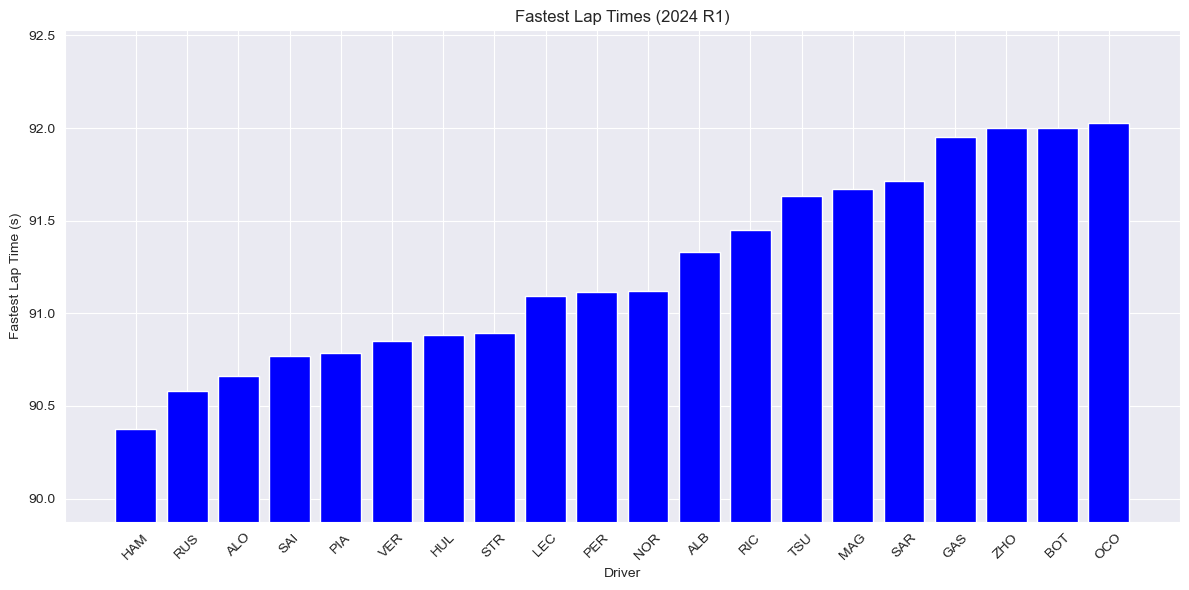


Plot 1 saved to C:\data\Dropbox\dev\F1\raw_data\2024\R1\fastest_vs_theoretical.png


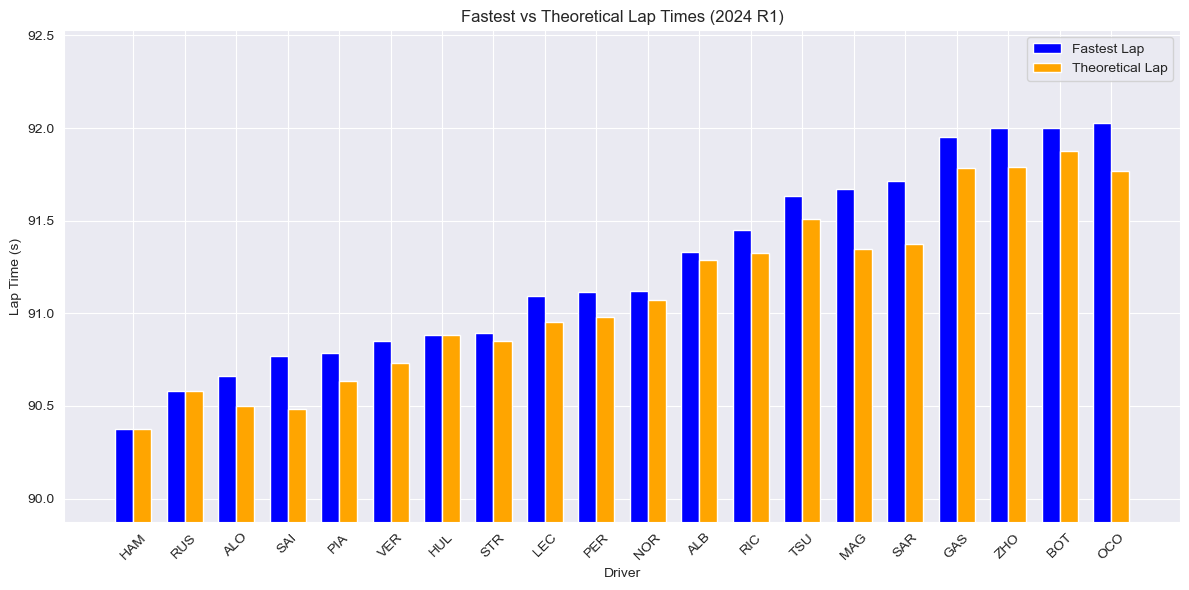


Degradation Slope Histogram saved to C:\data\Dropbox\dev\F1\raw_data\2024\R1\degradation_slope_histogram.png


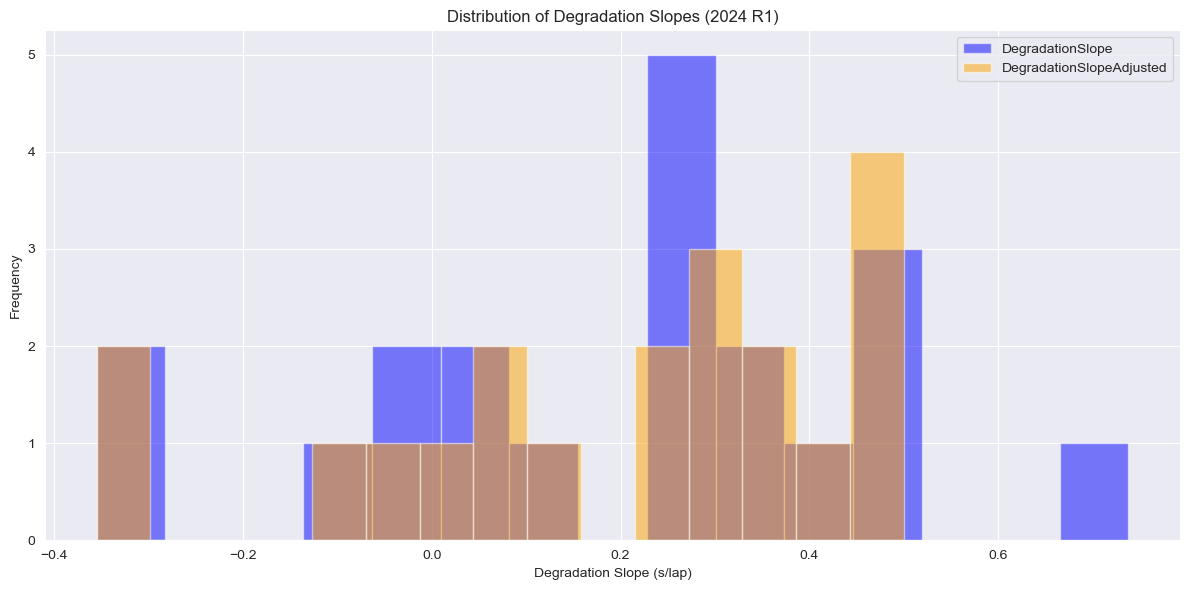


Degradation Slope by Team Boxplot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R1\degradation_slope_by_team.png


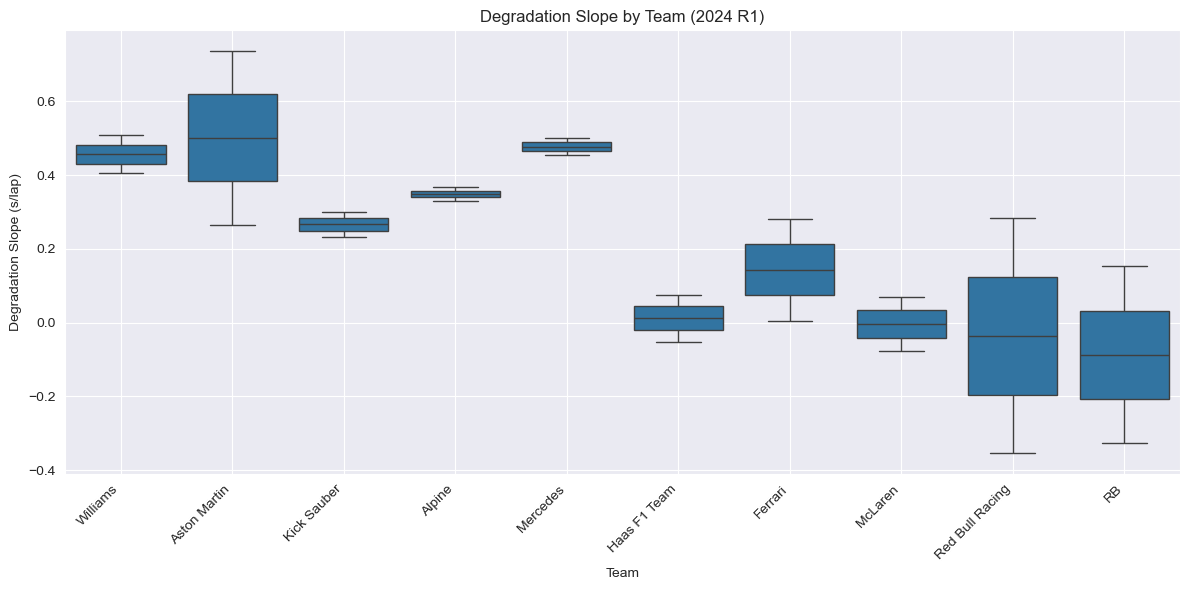


Degradation Slope vs. Base Pace Scatter Plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R1\degradation_slope_vs_basepace.png


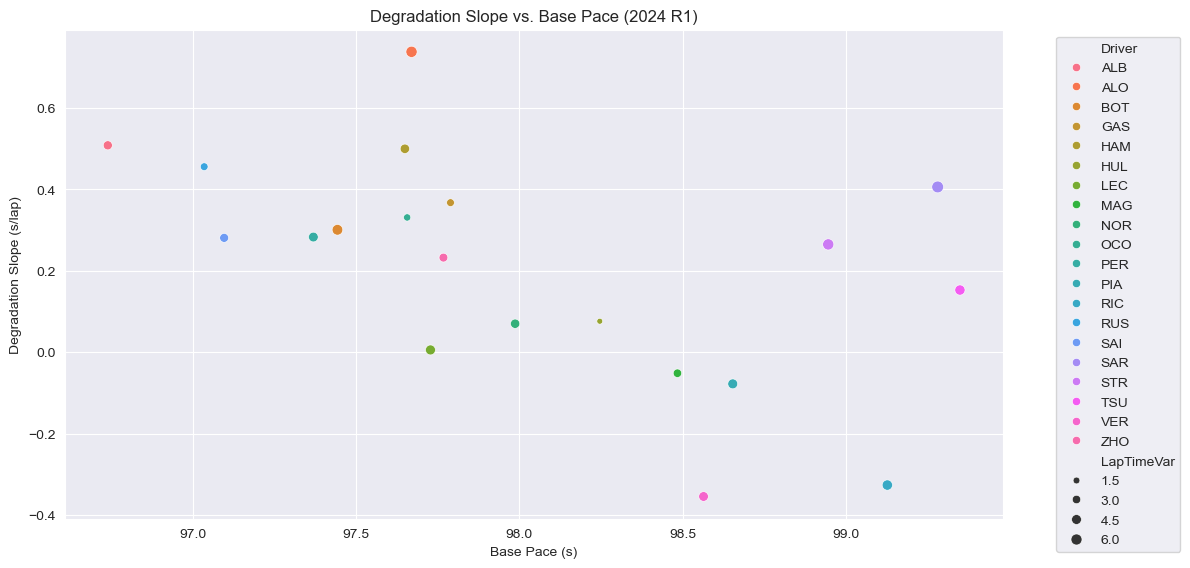


=== Conclusion ===
- Fastest: HAM (90.37s).
2025-03-22 11:11:23,216 - INFO - Step 6: Analyzing telemetry
2025-03-22 11:11:23,568 - INFO - Saved telemetry metrics to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_telemetry_metrics.csv

Telemetry Metrics (Top 10 by Max Speed) for Bahrain Grand Prix:
Driver   MaxSpeed  ThrottleTime  BrakingIntensity            Team
   SAR 305.735294     46.442791          0.195704        Williams
   LEC 302.952381     44.782798          0.190750         Ferrari
   ALB 302.657143     37.149027          0.195564        Williams
   TSU 302.000000     42.096254          0.162559              RB
   RUS 301.228571     44.315997          0.185595        Mercedes
   PER 300.736842     47.486624          0.191021 Red Bull Racing
   STR 299.925000     44.654320          0.198669    Aston Martin
   ALO 299.777778     44.497245          0.170359    Aston Martin
   BOT 299.676471     45.797764          0.195094     Kick Sauber
   RIC 299.414634     40.306552        

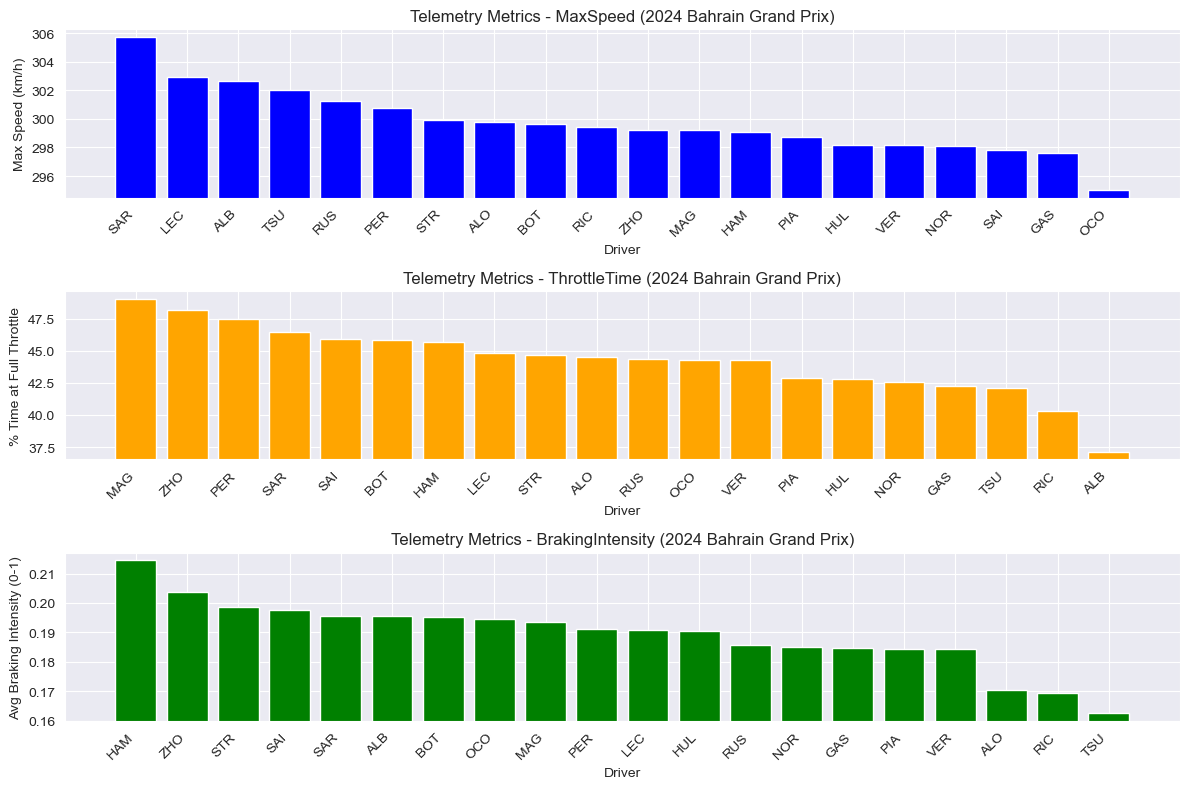


=== Conclusion ===
- Fastest Speed: SAR (305.74 km/h).
- Most Throttle: MAG (49.04%).
2025-03-22 11:11:24,304 - INFO - Step 7: Performing sandbagging analysis
2025-03-22 11:11:24,313 - INFO - Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_sandbag_analysis.csv

Potential Sandbaggers (Sorted by PredictionDiscrepancy):
Driver  FastestLapTime     Team  Sector1Time  Sector2Time  Sector3Time   MaxSpeed  ThrottleTime  ExpectedLapTime  LapTimeDiscrepancy  PredictedLapTime  PredictionDiscrepancy  SpeedRank  LapTimeRank  SandbagFlag
   SAR          91.715 Williams       29.308       39.142       22.925 305.735294     46.442791           91.375                0.34         91.227110               0.487890        1.0         16.0         True
   TSU          91.631       RB       29.091       39.472       22.948 302.000000     42.096254           91.511                0.12         91.238244               0.392756        4.0         14.0         True
Sandbagging Analysis 

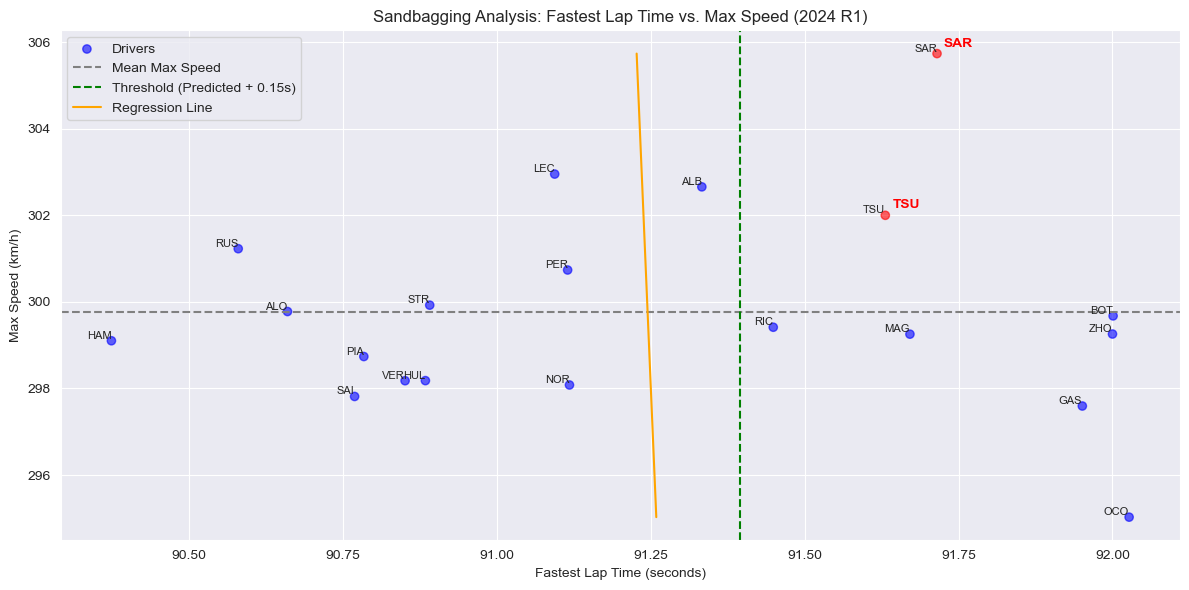

2025-03-22 11:11:24,666 - INFO - Step 8: Analyzing track evolution and weather
2025-03-22 11:11:24,668 - INFO - Average lap time for Practice 1: 109.420 seconds (±17.589)
2025-03-22 11:11:24,668 - INFO - Average lap time for Practice 2: 105.897 seconds (±16.219)
2025-03-22 11:11:24,669 - INFO - Average lap time for Practice 3: 114.269 seconds (±20.159)
2025-03-22 11:11:24,672 - INFO - Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_track_evolution.csv

Average Lap Times Across Sessions:
   Session  AvgLapTime  StdLapTime  LapCount
Practice 1  109.420408   17.589022       355
Practice 2  105.897307   16.218577       430
Practice 3  114.268758   20.159178       227

Average Weather Conditions Across Sessions:
   Session   AirTemp  Humidity  Rainfall  TrackTemp
Practice 1 19.373171 38.743902       0.0  34.215854
Practice 2 17.247561 39.024390       0.0  22.098780
Practice 3 20.259756 35.719512       0.0  32.013415

Correlation between AvgLapTime and TrackTemp: 0.7

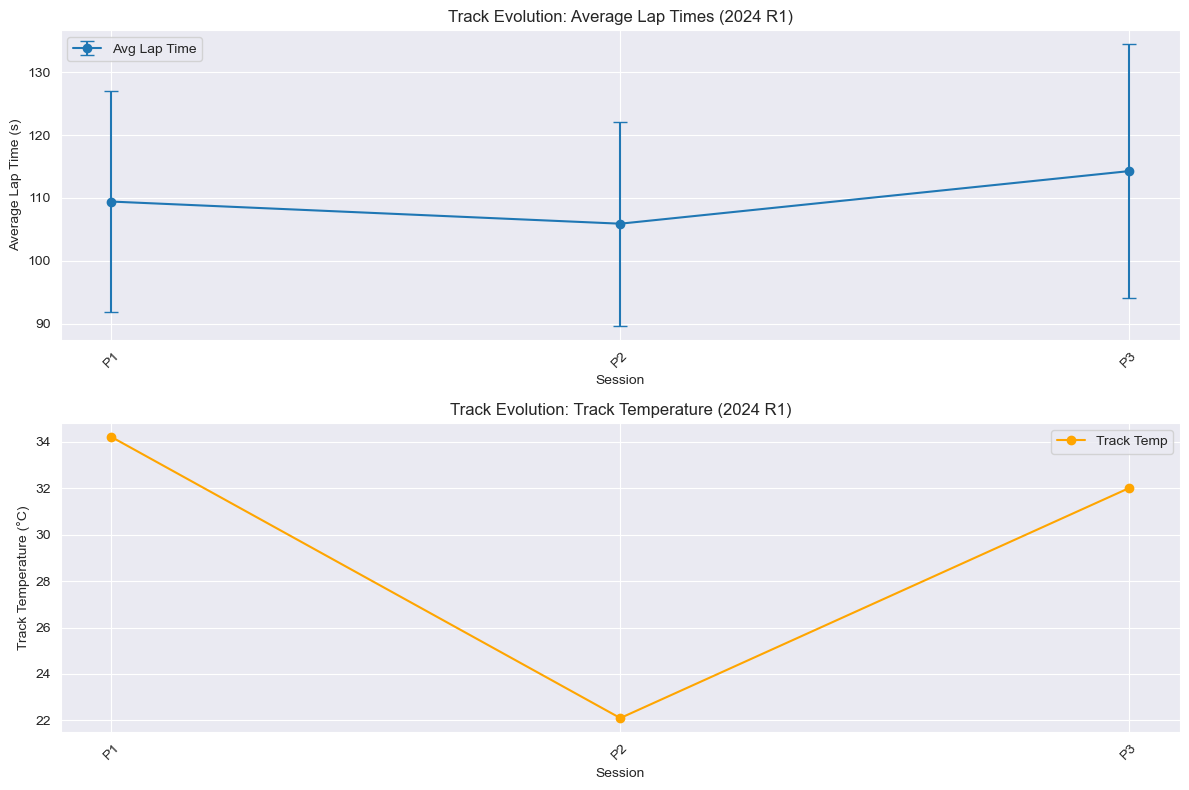

2025-03-22 11:11:25,040 - INFO - Step 9: Analyzing track characteristics
2025-03-22 11:11:25,052 - INFO - Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_track_characteristics.csv
2025-03-22 11:11:25,055 - INFO - Saved track char drivers to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_track_char_drivers.csv
Track Characteristics:
             Track DownforceRequirement OvertakingDifficulty  DRSZones TyreDegradation  LapLength SuitsFastCars
Bahrain Grand Prix                  Low                 Easy         3             Low      5.412           Yes

Top 5 Drivers by Track Fit:
Driver     Team  StraightSpeedPotential  CorneringPotential   AvgSpeed  OverallFit  FitRank
   SAR Williams              305.735294           30.458333 212.431990    0.996714      1.0
   LEC  Ferrari              302.952381           30.317000 213.880168    0.991725      2.0
   ALB Williams              302.657143           30.428333 213.320487    0.989958      3.0
   RUS Merced

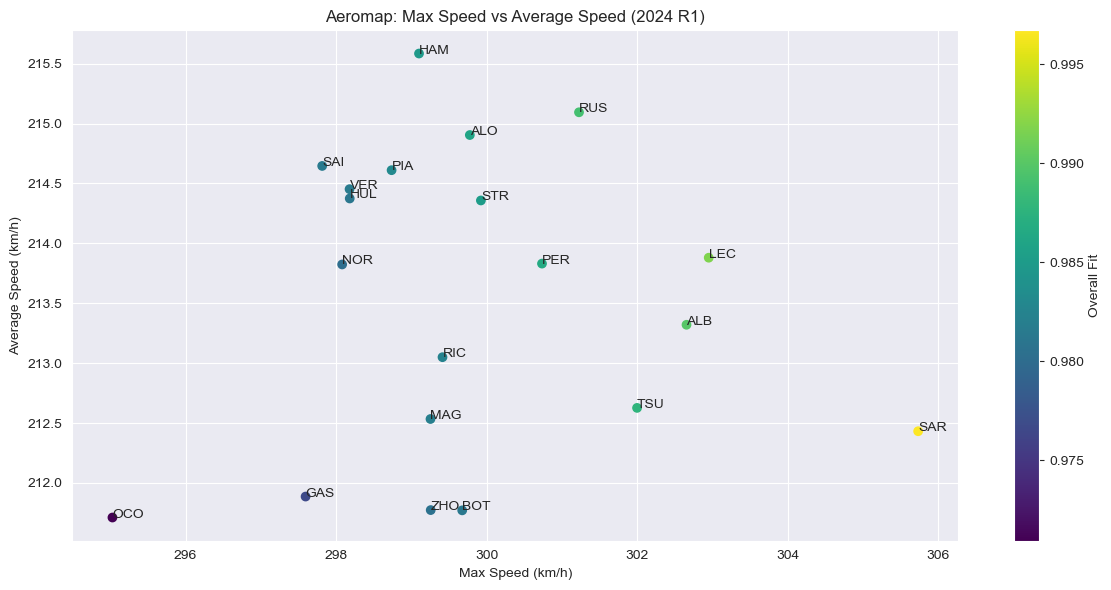

2025-03-22 11:11:25,723 - INFO - Step 10: Predicting race outcomes
2025-03-22 11:11:25,727 - INFO - Loaded pit_stop_loss from file: 20.00s for Bahrain Grand Prix
2025-03-22 11:11:25,741 - INFO - No Sprint session data available; setting SprintPaceAdjustment to 0 for all drivers.
2025-03-22 11:11:25,751 - INFO - Predicted Fastest Lap Driver: HAM
2025-03-22 11:11:25,756 - INFO - Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_quali_prediction.csv
2025-03-22 11:11:25,757 - INFO - Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_race_prediction.csv

Qualifying Prediction:
Driver            Team  LapTime  ExpectedLapTime  AdjustedLapTime  QualiPosition
   SAI         Ferrari   90.769           90.483           90.197              1
   ALO    Aston Martin   90.660           90.500           90.340              2
   HAM        Mercedes   90.374           90.374           90.374              3
   PIA         McLaren   90.784           90.6

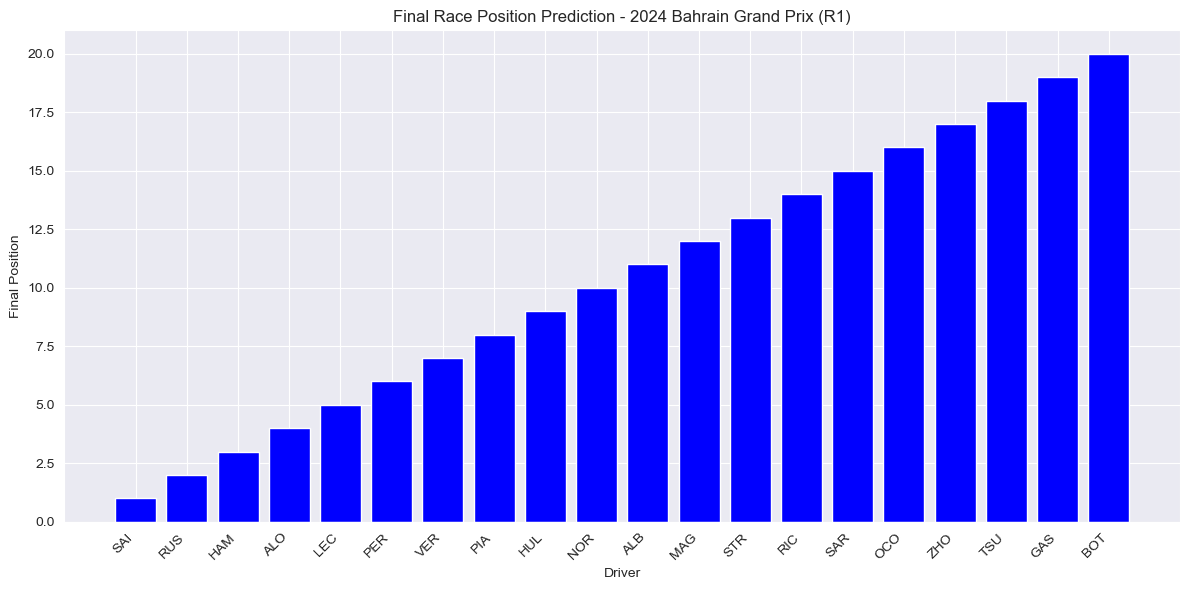

2025-03-22 11:11:26,130 - INFO - Step 11: Generating summary report
Debug: Verifying input DataFrames...
quali_prediction_df shape: (20, 9)
race_prediction_df shape: (20, 25)
driver_performance shape: (20, 12)
Pit stop loss for Bahrain Grand Prix: 20.00s
Calculated pit_stop_loss for Bahrain Grand Prix: 20.00s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\raw_data\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['VER', 'LEC', 'RUS', 'SAI', 'PER']
Dynamically fetched actual race top 10: ['VER', 'PER', 'SAI', 'LEC', 'RUS', 'NOR', 'HAM', 'PIA', 'ALO', 'STR']
Dynamically fetched actual fastest lap driver: VER

=== Comprehensive Summary Report ===

Event: 2024 Round 1 - Bahrain Grand Prix

--- Qualifying Analysis ---
Actual Qualifying Top 5: ['VER', 'LEC', 'RUS', 'SAI', 'PER']
Predicted Qualifying Top 5:
Driver  AdjustedLapTime  QualiPosition
   SAI           90.197              1
   ALO           90.340              2
   HAM           90.374              3
   PIA    

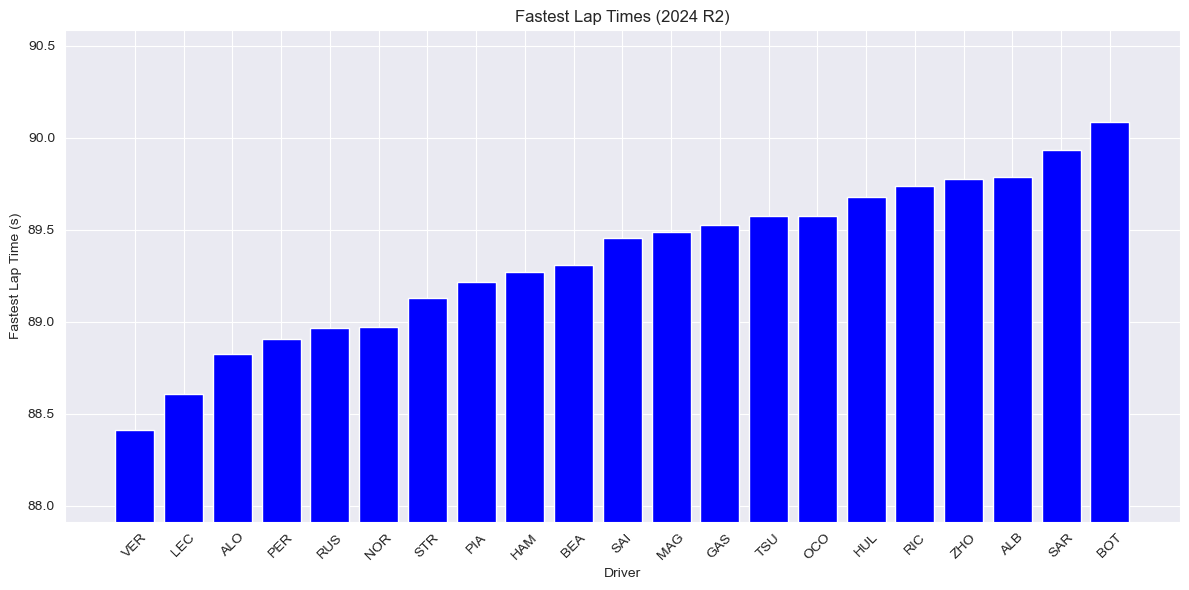


Plot 1 saved to C:\data\Dropbox\dev\F1\raw_data\2024\R2\fastest_vs_theoretical.png


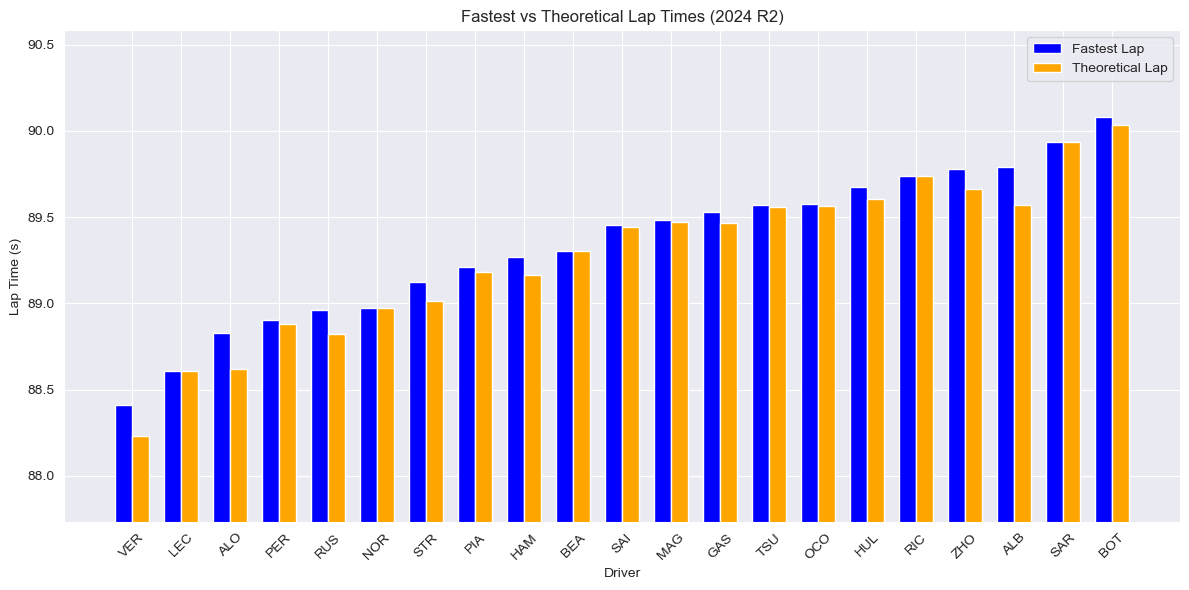


Degradation Slope Histogram saved to C:\data\Dropbox\dev\F1\raw_data\2024\R2\degradation_slope_histogram.png


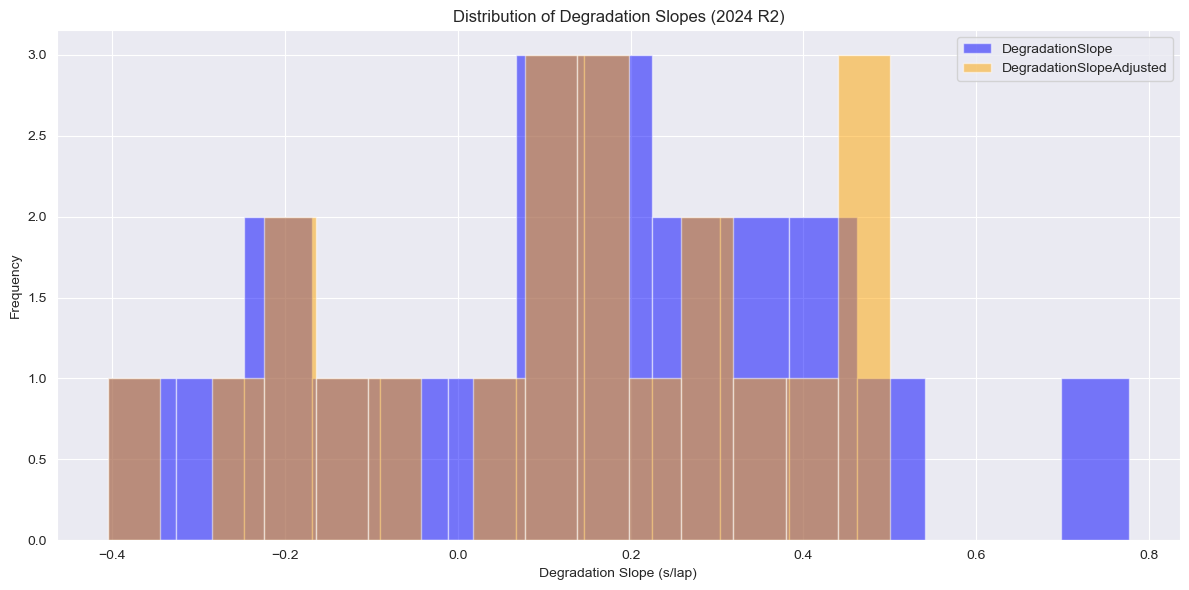


Degradation Slope by Team Boxplot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R2\degradation_slope_by_team.png


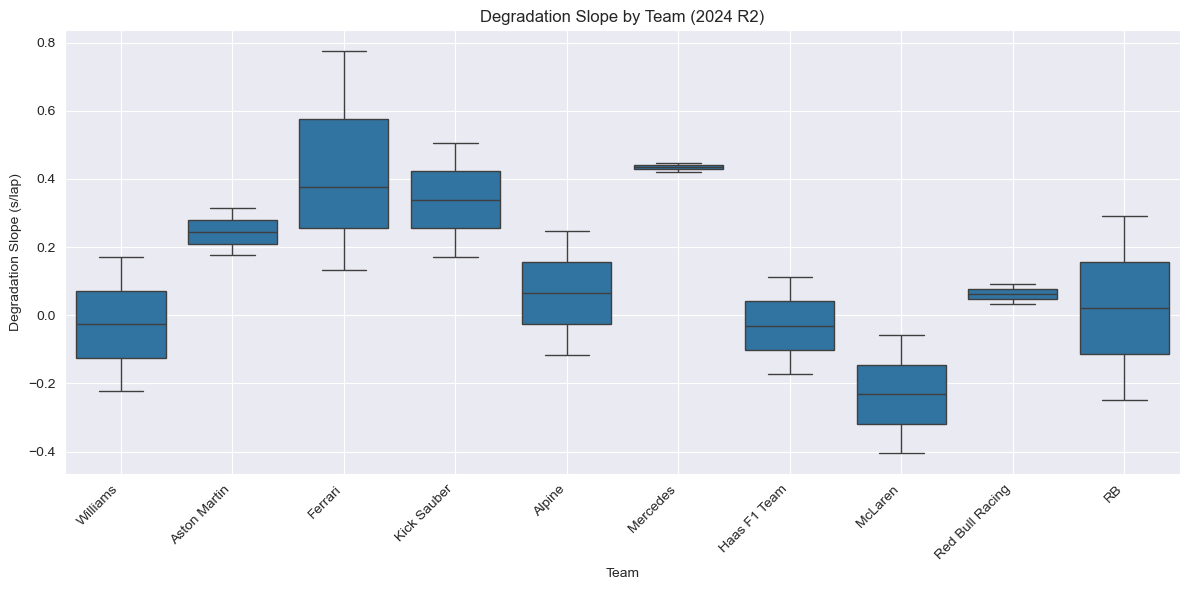


Degradation Slope vs. Base Pace Scatter Plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R2\degradation_slope_vs_basepace.png


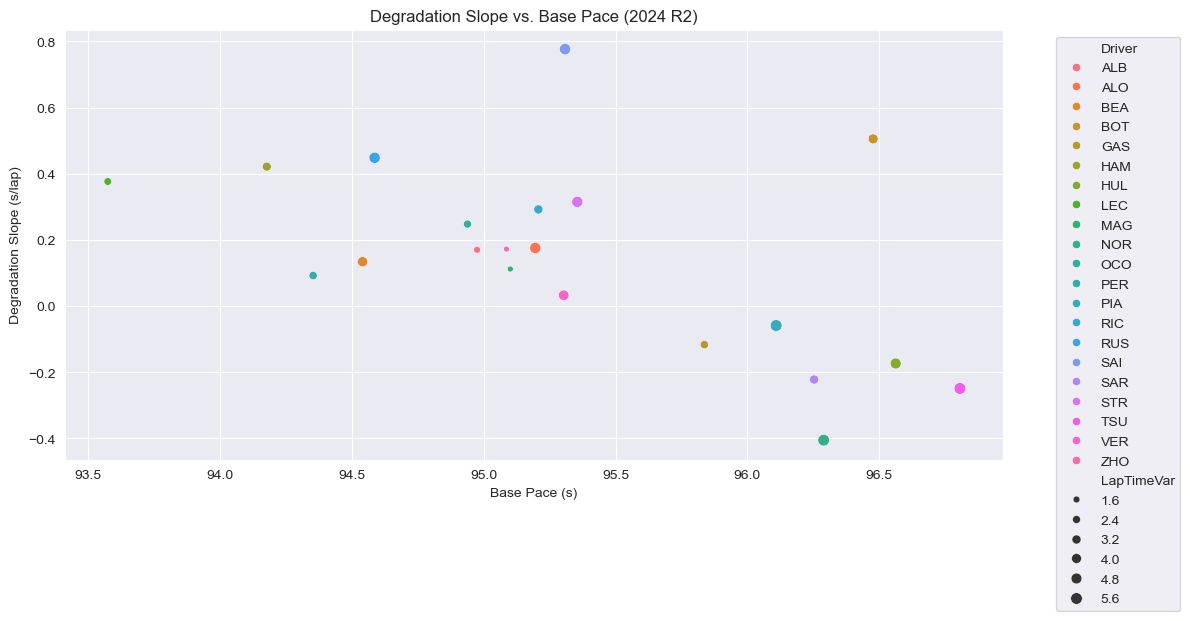


=== Conclusion ===
- Fastest: VER (88.41s).
2025-03-22 11:11:37,217 - INFO - Step 6: Analyzing telemetry
2025-03-22 11:11:37,647 - INFO - Saved telemetry metrics to C:\data\Dropbox\dev\F1\raw_data\2024\R2\2024_R2_telemetry_metrics.csv

Telemetry Metrics (Top 10 by Max Speed) for Saudi Arabian Grand Prix:
Driver   MaxSpeed  ThrottleTime  BrakingIntensity            Team
   PER 322.083333     61.870047          0.141440 Red Bull Racing
   RUS 321.250000     52.668143          0.140164        Mercedes
   HAM 319.906250     50.750617          0.136913        Mercedes
   RIC 318.565217     42.897800          0.108840              RB
   VER 317.023810     56.316607          0.150061 Red Bull Racing
   ALO 316.479167     57.634282          0.132719    Aston Martin
   SAR 316.216216     52.497746          0.147420        Williams
   TSU 316.183673     44.545289          0.111414              RB
   MAG 315.562500     59.609376          0.131189    Haas F1 Team
   HUL 315.314286     52.492836  

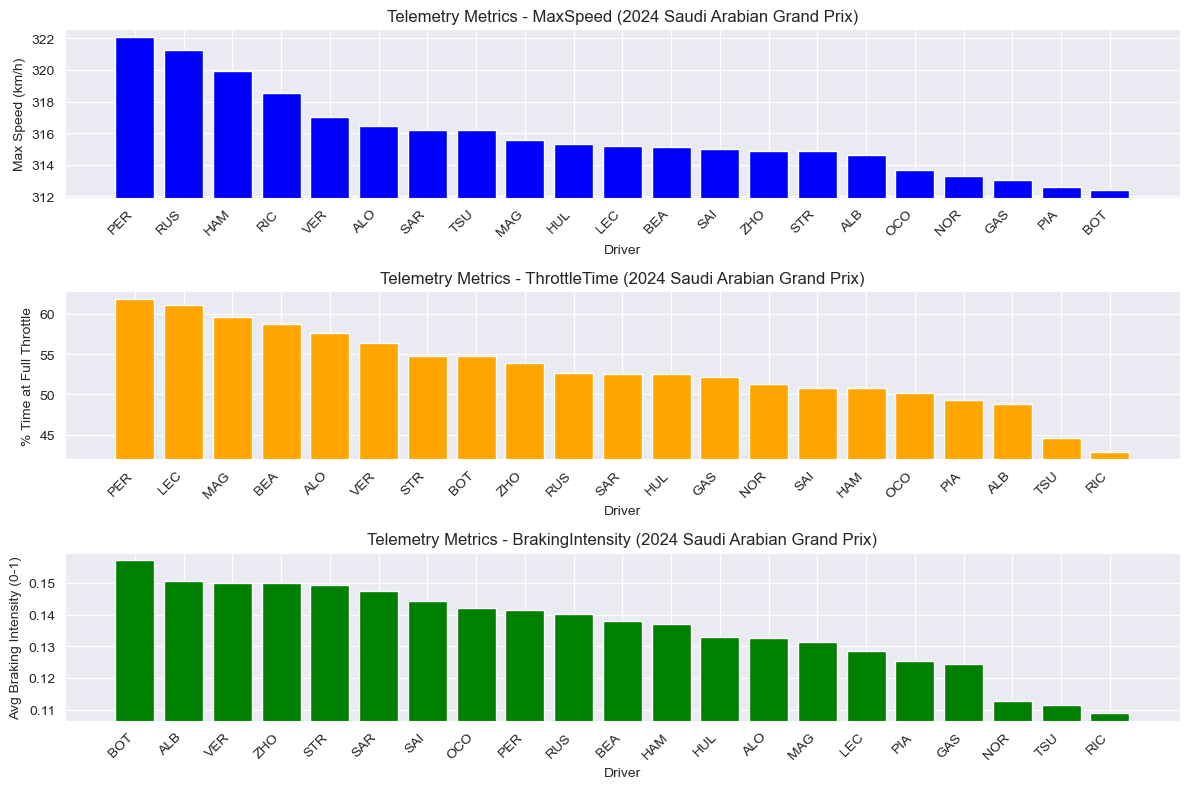


=== Conclusion ===
- Fastest Speed: PER (322.08 km/h).
- Most Throttle: PER (61.87%).
2025-03-22 11:11:39,449 - INFO - Step 7: Performing sandbagging analysis
2025-03-22 11:11:39,459 - INFO - Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R2\2024_R2_sandbag_analysis.csv

Potential Sandbaggers (Sorted by PredictionDiscrepancy):
Driver  FastestLapTime     Team  Sector1Time  Sector2Time  Sector3Time   MaxSpeed  ThrottleTime  ExpectedLapTime  LapTimeDiscrepancy  PredictedLapTime  PredictionDiscrepancy  SpeedRank  LapTimeRank  SandbagFlag
   SAR          89.934 Williams       32.896       28.462       28.576 316.216216     52.497746           89.934        0.000000e+00         89.324094               0.609906        7.0         20.0         True
   RIC          89.740       RB       32.777       28.332       28.631 318.565217     42.897800           89.740       -1.421085e-14         89.193618               0.546382        4.0         17.0         True
   TSU          89.57

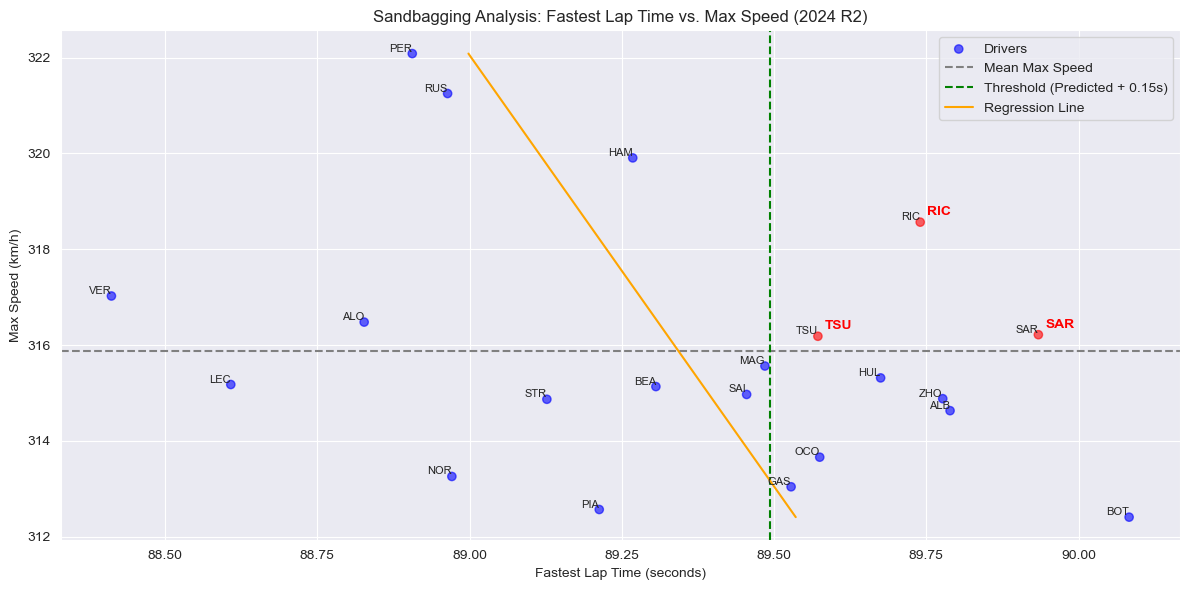

2025-03-22 11:11:39,907 - INFO - Step 8: Analyzing track evolution and weather
2025-03-22 11:11:39,909 - INFO - Average lap time for Practice 1: 107.776 seconds (±18.976)
2025-03-22 11:11:39,911 - INFO - Average lap time for Practice 2: 105.348 seconds (±17.526)
2025-03-22 11:11:39,913 - INFO - Average lap time for Practice 3: 111.019 seconds (±20.649)
2025-03-22 11:11:39,917 - INFO - Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R2\2024_R2_track_evolution.csv

Average Lap Times Across Sessions:
   Session  AvgLapTime  StdLapTime  LapCount
Practice 1  107.776101   18.975962       377
Practice 2  105.348032   17.525925       433
Practice 3  111.019267   20.648894       210

Average Weather Conditions Across Sessions:
   Session   AirTemp  Humidity  Rainfall  TrackTemp
Practice 1 26.755000 57.575000       0.0  39.701250
Practice 2 25.370968 59.784946       0.0  30.596774
Practice 3 25.984146 60.341463       0.0  39.558537

Correlation between AvgLapTime and TrackTemp: 0.8

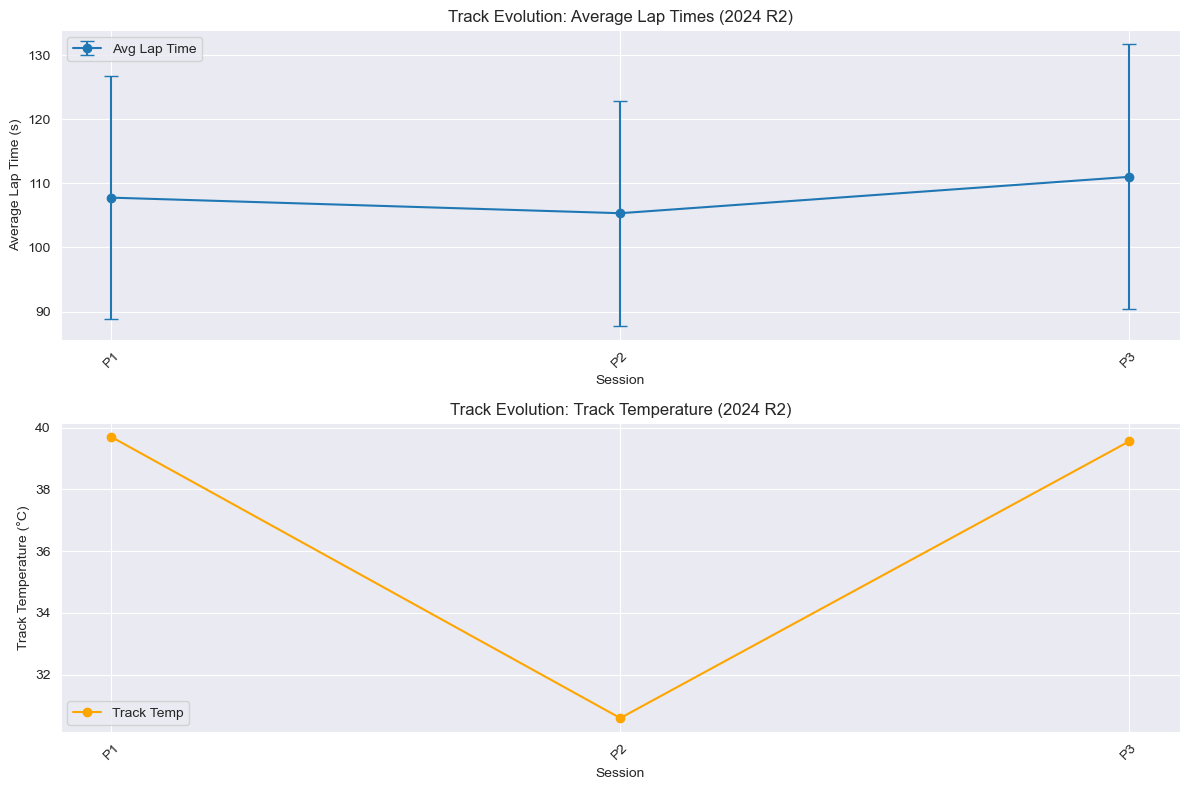

2025-03-22 11:11:40,353 - INFO - Step 9: Analyzing track characteristics
2025-03-22 11:11:40,365 - INFO - Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R2\2024_R2_track_characteristics.csv
2025-03-22 11:11:40,368 - INFO - Saved track char drivers to C:\data\Dropbox\dev\F1\raw_data\2024\R2\2024_R2_track_char_drivers.csv
Track Characteristics:
                   Track DownforceRequirement OvertakingDifficulty  DRSZones TyreDegradation  LapLength SuitsFastCars
Saudi Arabian Grand Prix                  Low                 Easy         3             Low      6.174           Yes

Top 5 Drivers by Track Fit:
Driver            Team  StraightSpeedPotential  CorneringPotential   AvgSpeed  OverallFit  FitRank
   PER Red Bull Racing              322.083333           29.627333 249.998875    0.997813      1.0
   RUS        Mercedes              321.250000           29.607333 249.835889    0.996203      2.0
   HAM        Mercedes              319.906250           29.722667 248.9

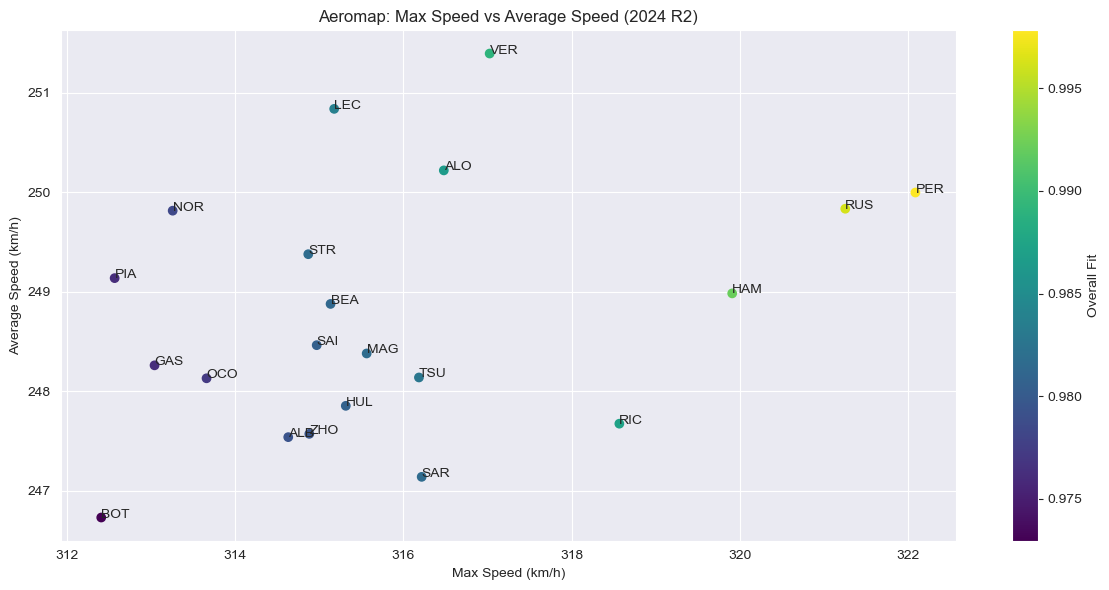

2025-03-22 11:11:41,041 - INFO - Step 10: Predicting race outcomes
2025-03-22 11:11:41,045 - INFO - Loaded pit_stop_loss from file: 20.00s for Saudi Arabian Grand Prix
2025-03-22 11:11:41,062 - INFO - No Sprint session data available; setting SprintPaceAdjustment to 0 for all drivers.
2025-03-22 11:11:41,074 - INFO - Predicted Fastest Lap Driver: VER
2025-03-22 11:11:41,080 - INFO - Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R2\2024_R2_quali_prediction.csv
2025-03-22 11:11:41,081 - INFO - Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R2\2024_R2_race_prediction.csv

Qualifying Prediction:
Driver            Team  LapTime  ExpectedLapTime  AdjustedLapTime  QualiPosition
   VER Red Bull Racing   88.412           88.234           88.056              1
   ALO    Aston Martin   88.827           88.621           88.415              2
   LEC         Ferrari   88.608           88.608           88.608              3
   RUS        Mercedes   88.964         

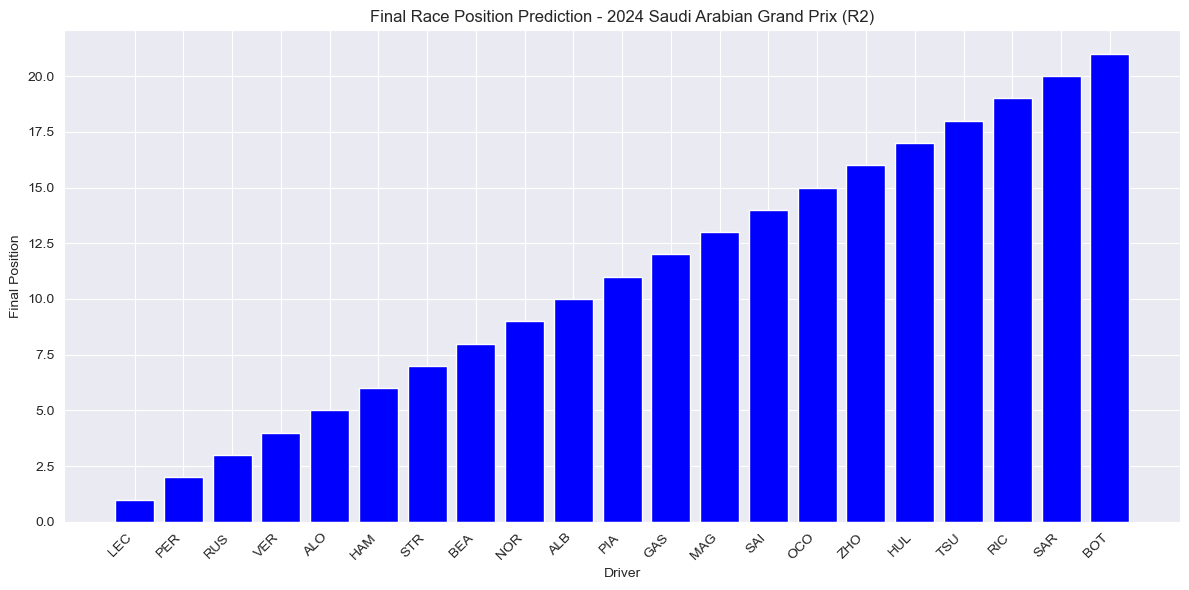

2025-03-22 11:11:41,574 - INFO - Step 11: Generating summary report
Debug: Verifying input DataFrames...
quali_prediction_df shape: (21, 9)
race_prediction_df shape: (21, 25)
driver_performance shape: (21, 12)
Pit stop loss for Saudi Arabian Grand Prix: 20.00s
Calculated pit_stop_loss for Saudi Arabian Grand Prix: 20.00s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\raw_data\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['VER', 'LEC', 'PER', 'ALO', 'PIA']
Dynamically fetched actual race top 10: ['VER', 'PER', 'LEC', 'PIA', 'ALO', 'RUS', 'BEA', 'NOR', 'HAM', 'HUL']
Dynamically fetched actual fastest lap driver: LEC

=== Comprehensive Summary Report ===

Event: 2024 Round 2 - Saudi Arabian Grand Prix

--- Qualifying Analysis ---
Actual Qualifying Top 5: ['VER', 'LEC', 'PER', 'ALO', 'PIA']
Predicted Qualifying Top 5:
Driver  AdjustedLapTime  QualiPosition
   VER           88.056              1
   ALO           88.415              2
   LEC           88.608        

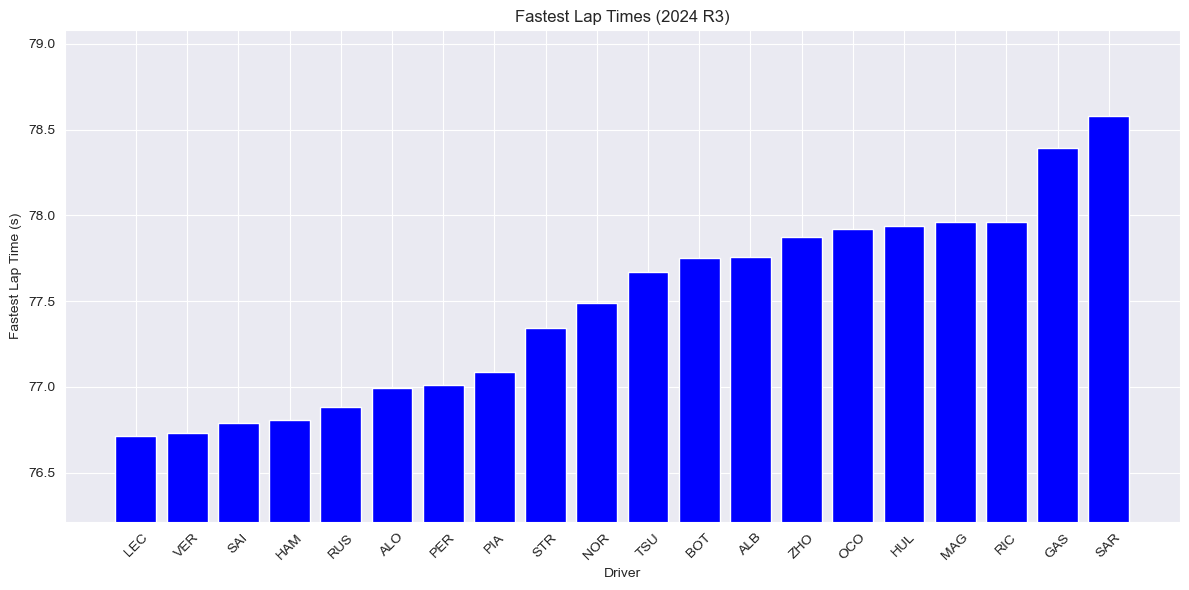


Plot 1 saved to C:\data\Dropbox\dev\F1\raw_data\2024\R3\fastest_vs_theoretical.png


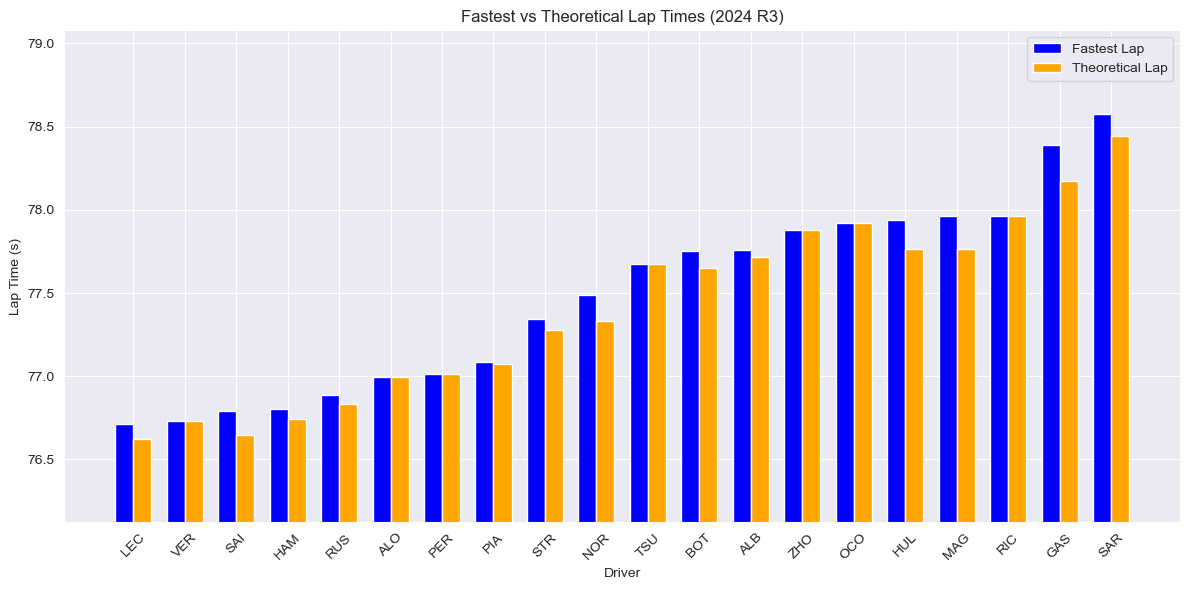


Degradation Slope Histogram saved to C:\data\Dropbox\dev\F1\raw_data\2024\R3\degradation_slope_histogram.png


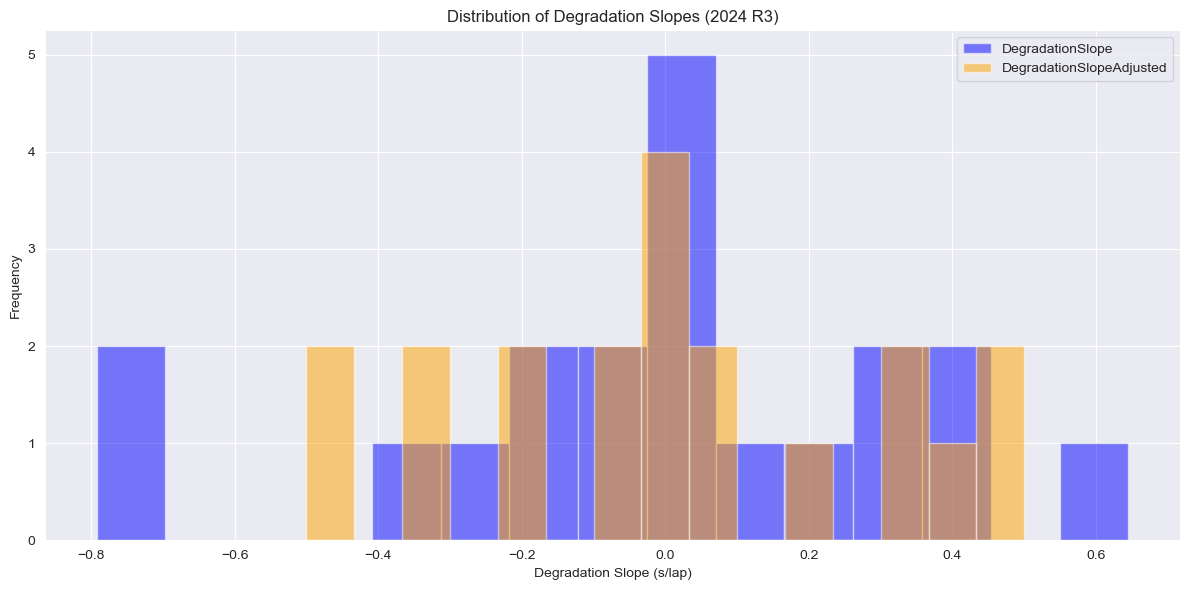


Degradation Slope by Team Boxplot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R3\degradation_slope_by_team.png


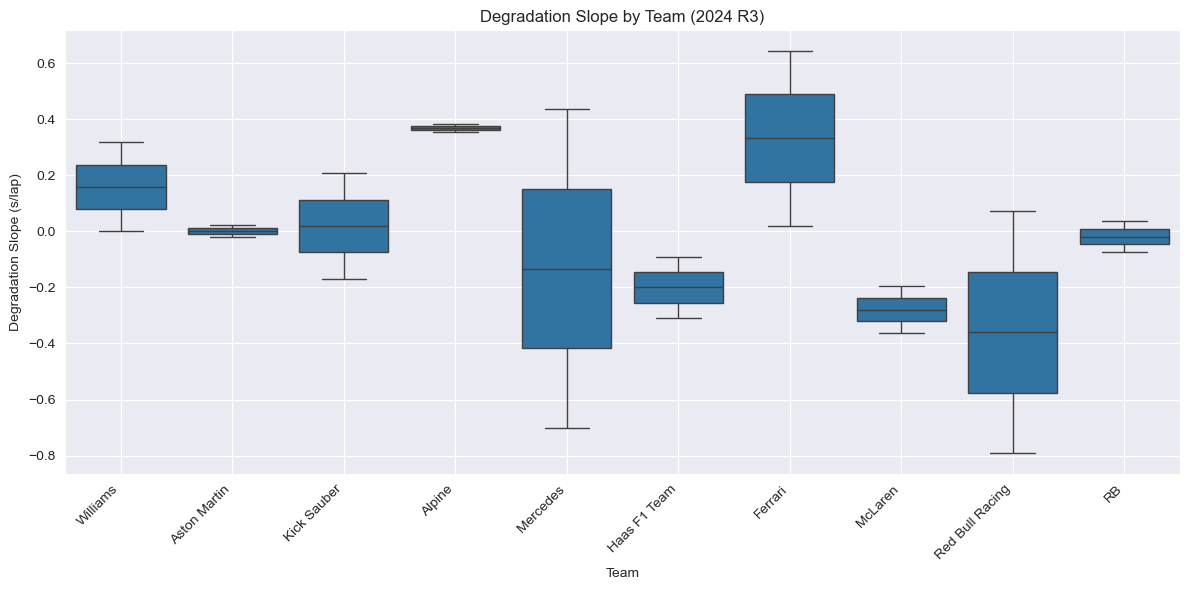


Degradation Slope vs. Base Pace Scatter Plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R3\degradation_slope_vs_basepace.png


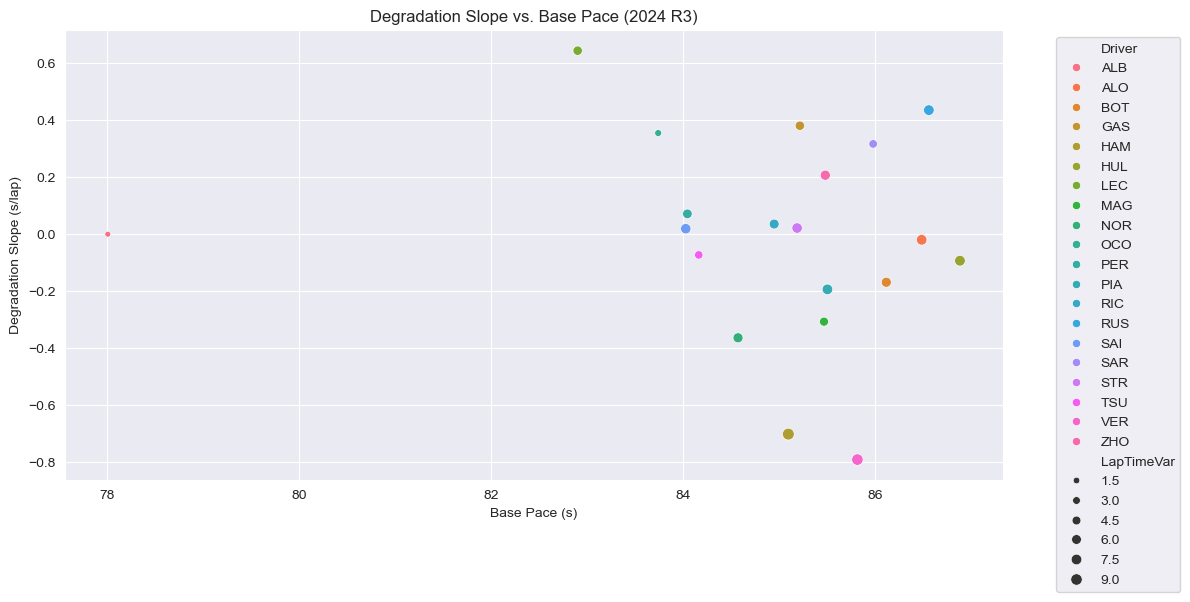


=== Conclusion ===
- Fastest: LEC (76.71s).
2025-03-22 11:11:56,656 - INFO - Step 6: Analyzing telemetry
2025-03-22 11:11:56,860 - WARNING - No telemetry for SAI lap 1.0 in Practice 1.
2025-03-22 11:11:57,317 - INFO - Saved telemetry metrics to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_telemetry_metrics.csv

Telemetry Metrics (Top 10 by Max Speed) for Australian Grand Prix:
Driver   MaxSpeed  ThrottleTime  BrakingIntensity            Team
   ALB 314.500000     40.588232          0.148857        Williams
   GAS 313.456140     49.729622          0.138447          Alpine
   VER 312.348837     52.658968          0.165786 Red Bull Racing
   OCO 311.781818     45.725568          0.163301          Alpine
   SAR 311.600000     46.922450          0.136990        Williams
   HAM 311.351351     42.888121          0.147023        Mercedes
   STR 311.244898     56.020214          0.125566    Aston Martin
   HUL 311.121951     47.396789          0.142956    Haas F1 Team
   PER 310.836364     

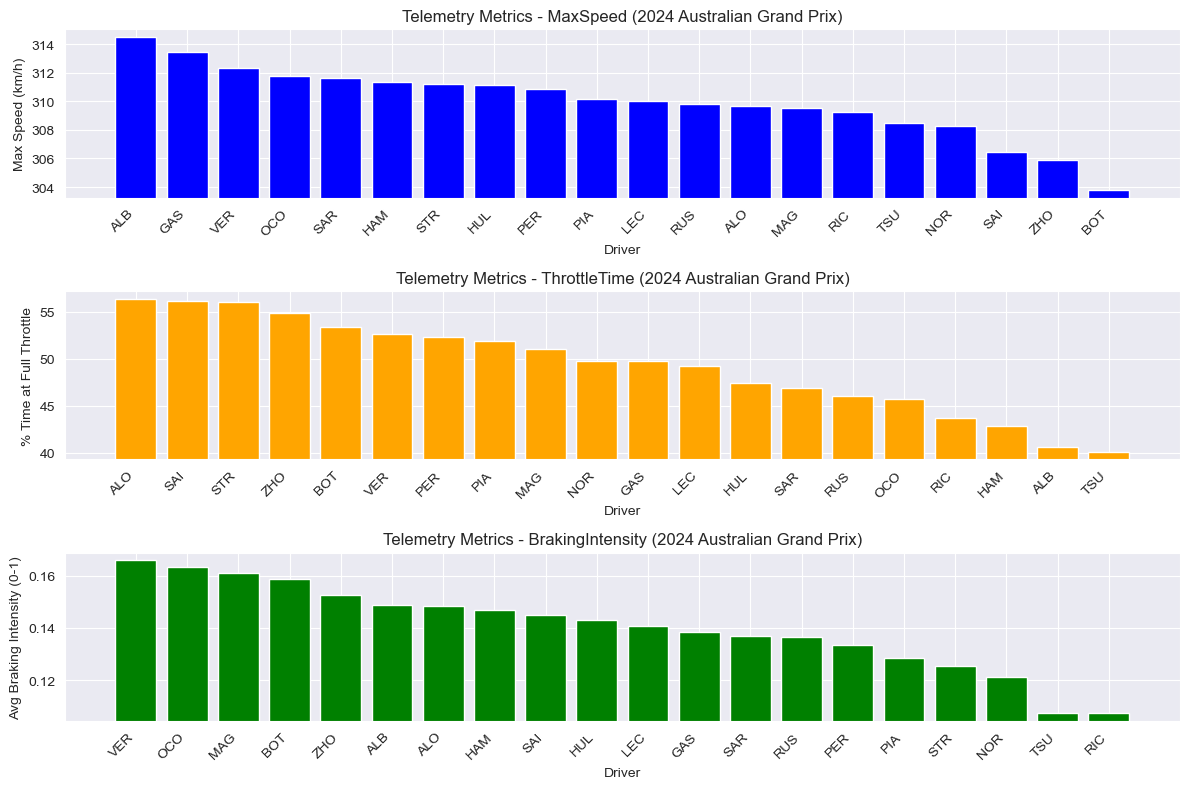


=== Conclusion ===
- Fastest Speed: ALB (314.50 km/h).
- Most Throttle: ALO (56.38%).
2025-03-22 11:11:58,317 - INFO - Step 7: Performing sandbagging analysis
2025-03-22 11:11:58,333 - INFO - Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_sandbag_analysis.csv

Potential Sandbaggers (Sorted by PredictionDiscrepancy):
Driver  FastestLapTime         Team  Sector1Time  Sector2Time  Sector3Time   MaxSpeed  ThrottleTime  ExpectedLapTime  LapTimeDiscrepancy  PredictedLapTime  PredictionDiscrepancy  SpeedRank  LapTimeRank  SandbagFlag
   SAR          78.578     Williams       27.119       17.769       33.553 311.600000     46.922450           78.441               0.137         77.518388               1.059612        5.0         20.0         True
   GAS          78.390       Alpine       27.085       17.761       33.330 313.456140     49.729622           78.176               0.214         77.558146               0.831854        2.0         19.0         True
   HUL   

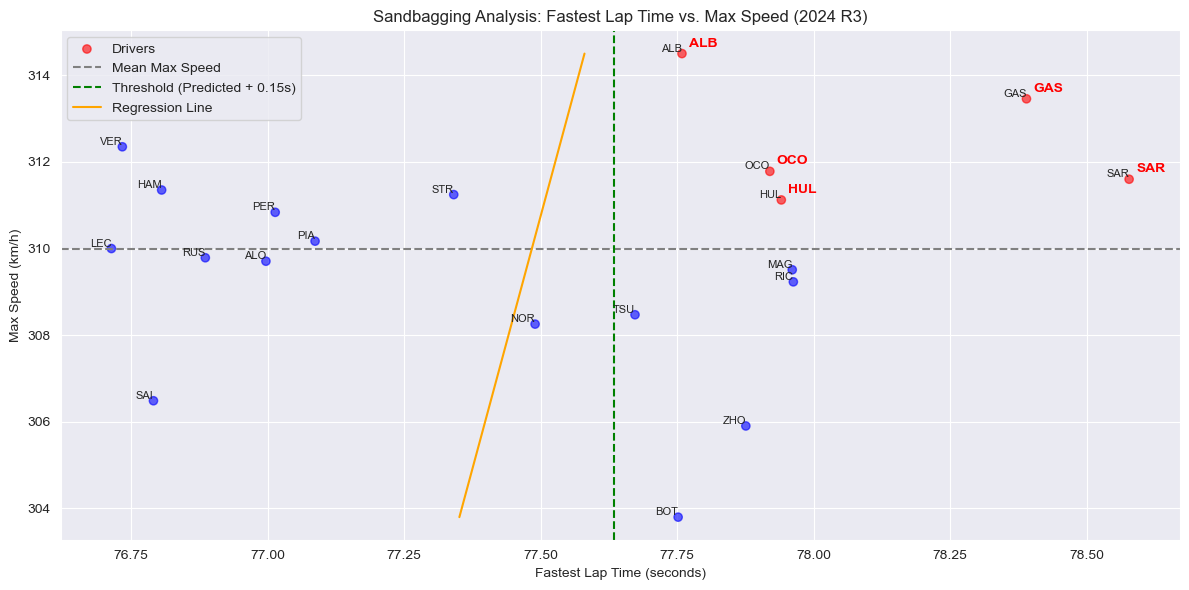

2025-03-22 11:11:58,862 - INFO - Step 8: Analyzing track evolution and weather
2025-03-22 11:11:58,866 - INFO - Average lap time for Practice 1: 99.560 seconds (±20.716)
2025-03-22 11:11:58,869 - INFO - Average lap time for Practice 2: 94.623 seconds (±17.698)
2025-03-22 11:11:58,871 - INFO - Average lap time for Practice 3: 99.443 seconds (±20.223)
2025-03-22 11:11:58,876 - INFO - Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_track_evolution.csv

Average Lap Times Across Sessions:
   Session  AvgLapTime  StdLapTime  LapCount
Practice 1   99.559917   20.715781       360
Practice 2   94.623173   17.697597       462
Practice 3   99.442861   20.223488       332

Average Weather Conditions Across Sessions:
   Session   AirTemp  Humidity  Rainfall  TrackTemp
Practice 1 18.469136 61.012346       0.0  33.709877
Practice 2 20.157317 56.926829       0.0  36.157317
Practice 3 18.272840 59.395062       0.0  27.669136

Correlation between AvgLapTime and TrackTemp: -0.708

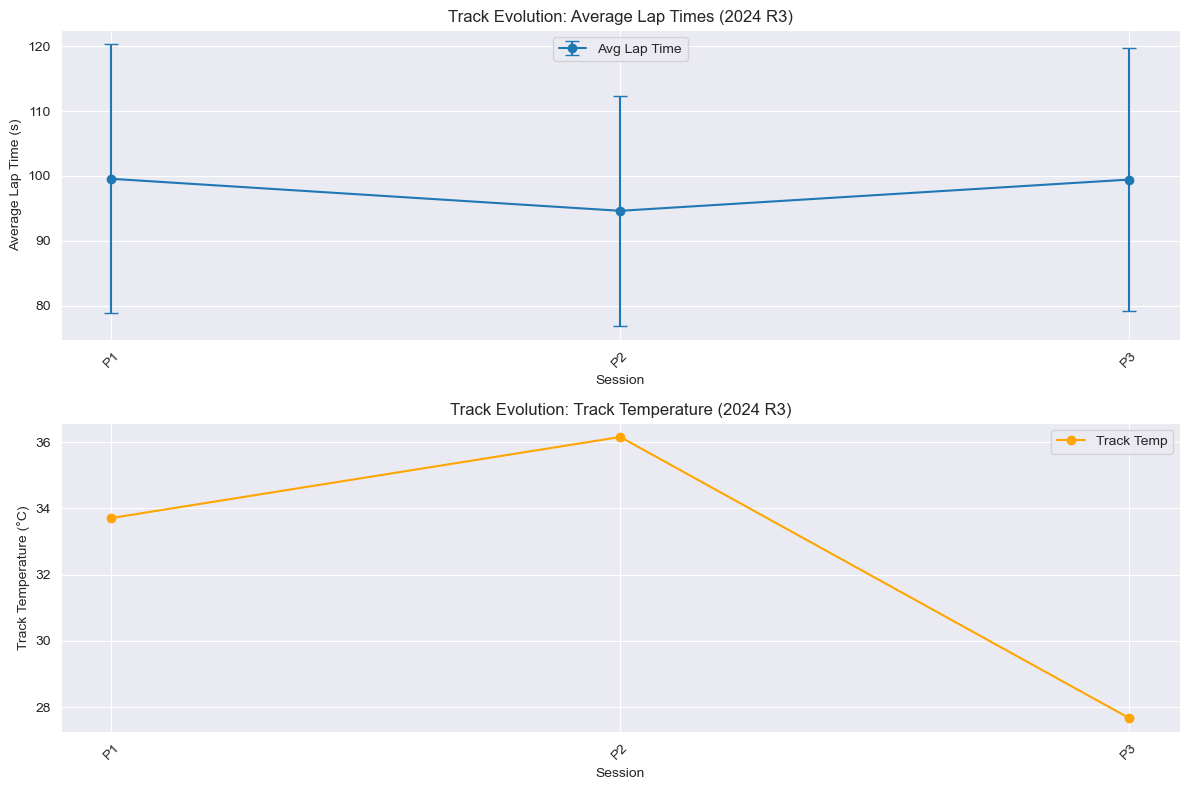

2025-03-22 11:11:59,437 - INFO - Step 9: Analyzing track characteristics
2025-03-22 11:11:59,449 - INFO - Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_track_characteristics.csv
2025-03-22 11:11:59,453 - INFO - Saved track char drivers to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_track_char_drivers.csv
Track Characteristics:
                Track DownforceRequirement OvertakingDifficulty  DRSZones TyreDegradation  LapLength SuitsFastCars
Australian Grand Prix                  Low                 Easy         3             Low      5.278           Yes

Top 5 Drivers by Track Fit:
Driver            Team  StraightSpeedPotential  CorneringPotential   AvgSpeed  OverallFit  FitRank
   ALB        Williams              314.500000           25.906333 244.354994    0.995777      1.0
   VER Red Bull Racing              312.348837           25.578000 247.619048    0.994786      2.0
   HAM        Mercedes              311.351351           25.580667 247.386923 

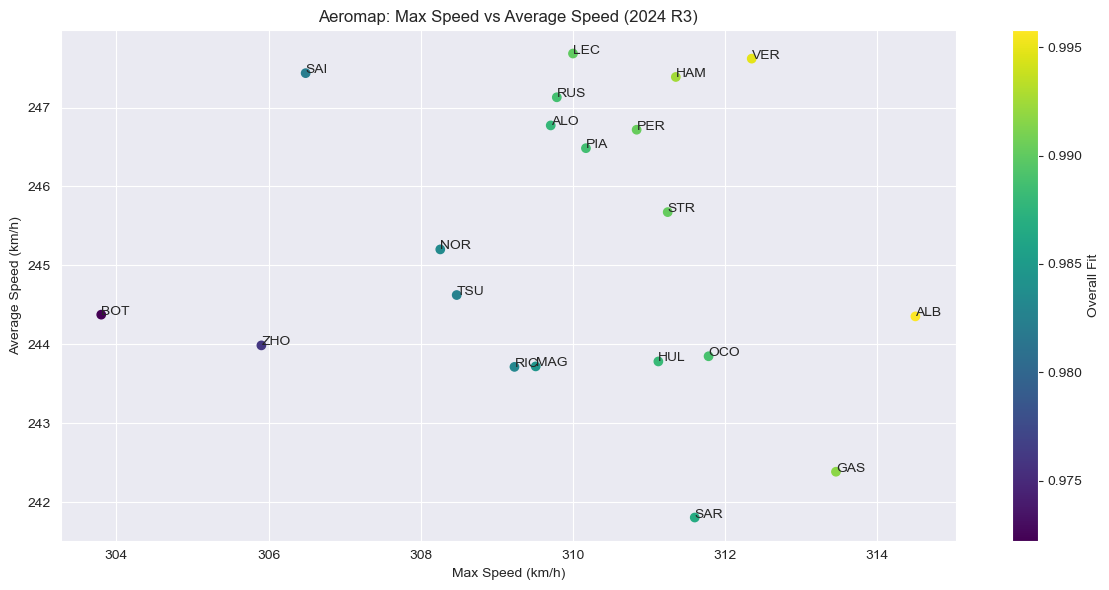

2025-03-22 11:12:00,370 - INFO - Step 10: Predicting race outcomes
2025-03-22 11:12:00,376 - INFO - Loaded pit_stop_loss from file: 20.00s for Australian Grand Prix
2025-03-22 11:12:00,396 - INFO - No Sprint session data available; setting SprintPaceAdjustment to 0 for all drivers.
2025-03-22 11:12:00,408 - INFO - Predicted Fastest Lap Driver: LEC
2025-03-22 11:12:00,418 - INFO - Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_quali_prediction.csv
2025-03-22 11:12:00,420 - INFO - Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R3\2024_R3_race_prediction.csv

Qualifying Prediction:
Driver            Team  LapTime  ExpectedLapTime  AdjustedLapTime  QualiPosition
   SAI         Ferrari   76.791           76.646           76.501              1
   LEC         Ferrari   76.714           76.625           76.536              2
   HAM        Mercedes   76.806           76.742           76.678              3
   VER Red Bull Racing   76.734           7

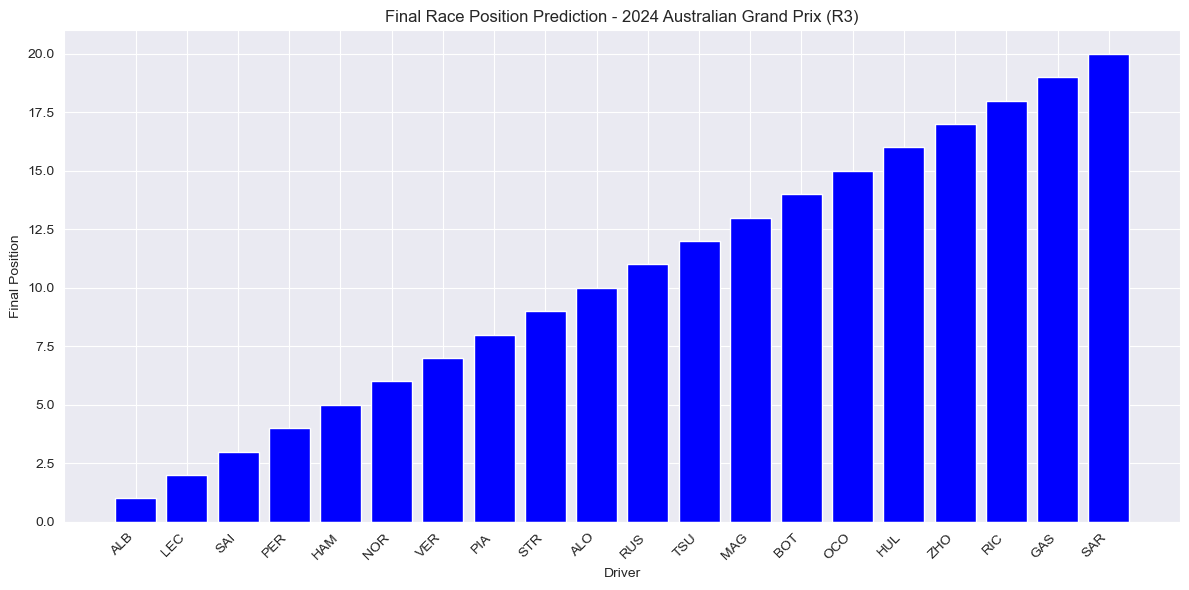

2025-03-22 11:12:01,044 - INFO - Step 11: Generating summary report
Debug: Verifying input DataFrames...
quali_prediction_df shape: (20, 9)
race_prediction_df shape: (20, 25)
driver_performance shape: (20, 12)
Pit stop loss for Australian Grand Prix: 20.00s
Calculated pit_stop_loss for Australian Grand Prix: 20.00s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\raw_data\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['VER', 'SAI', 'PER', 'NOR', 'LEC']
Dynamically fetched actual race top 10: ['SAI', 'LEC', 'NOR', 'PIA', 'PER', 'STR', 'TSU', 'ALO', 'HUL', 'MAG']
Dynamically fetched actual fastest lap driver: LEC

=== Comprehensive Summary Report ===

Event: 2024 Round 3 - Australian Grand Prix

--- Qualifying Analysis ---
Actual Qualifying Top 5: ['VER', 'SAI', 'PER', 'NOR', 'LEC']
Predicted Qualifying Top 5:
Driver  AdjustedLapTime  QualiPosition
   SAI           76.501              1
   LEC           76.536              2
   HAM           76.678              3
 

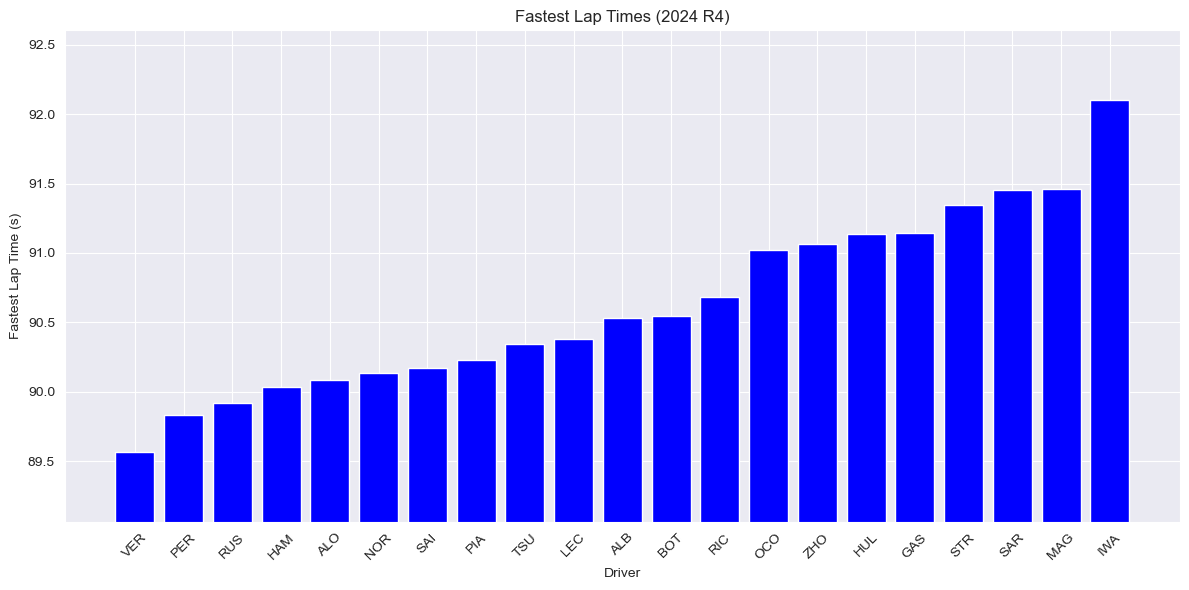


Plot 1 saved to C:\data\Dropbox\dev\F1\raw_data\2024\R4\fastest_vs_theoretical.png


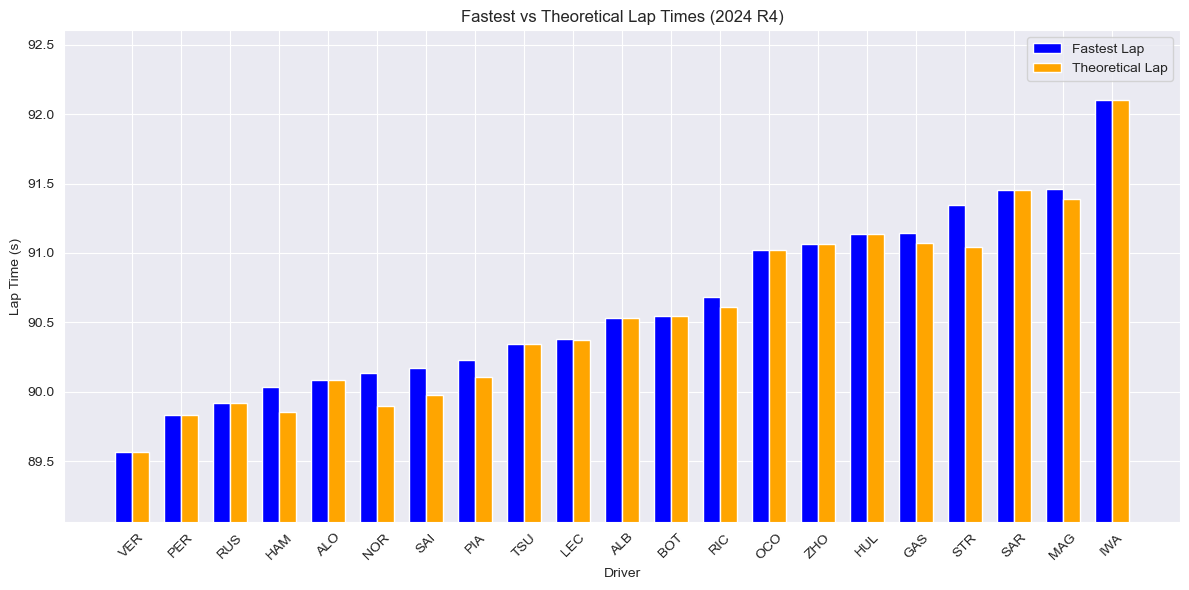


Degradation Slope Histogram saved to C:\data\Dropbox\dev\F1\raw_data\2024\R4\degradation_slope_histogram.png


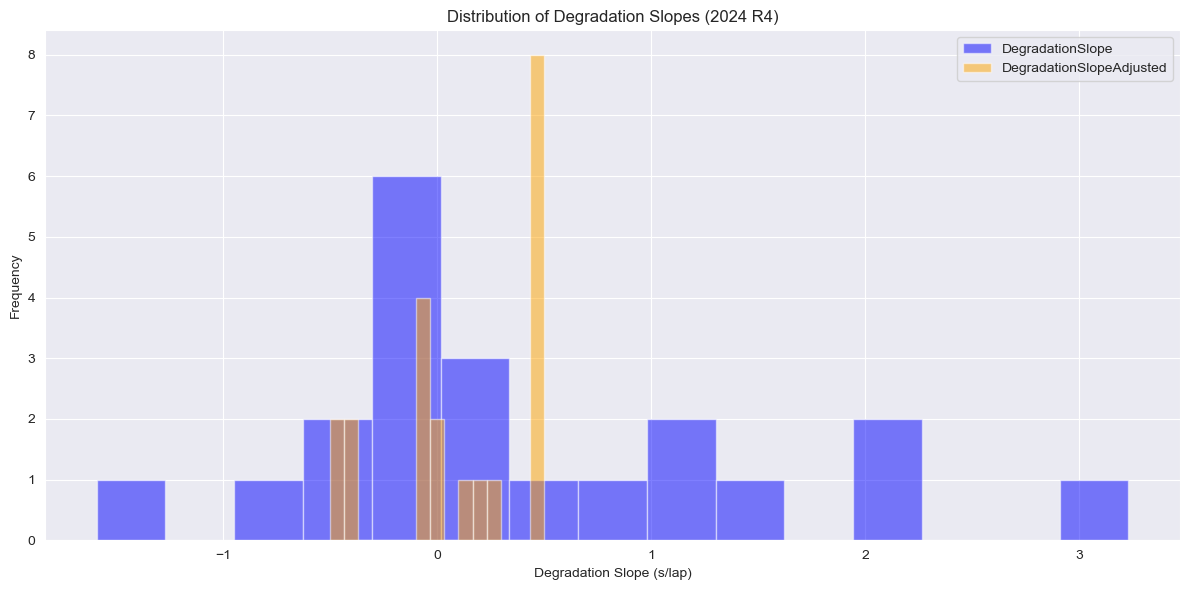


Degradation Slope by Team Boxplot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R4\degradation_slope_by_team.png


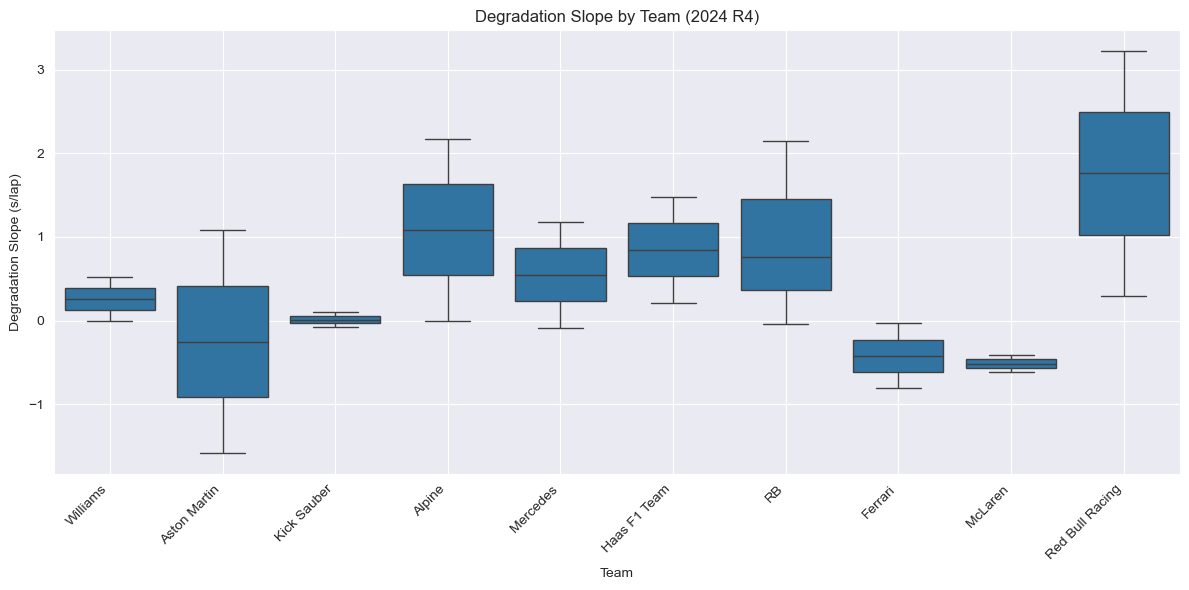


Degradation Slope vs. Base Pace Scatter Plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R4\degradation_slope_vs_basepace.png


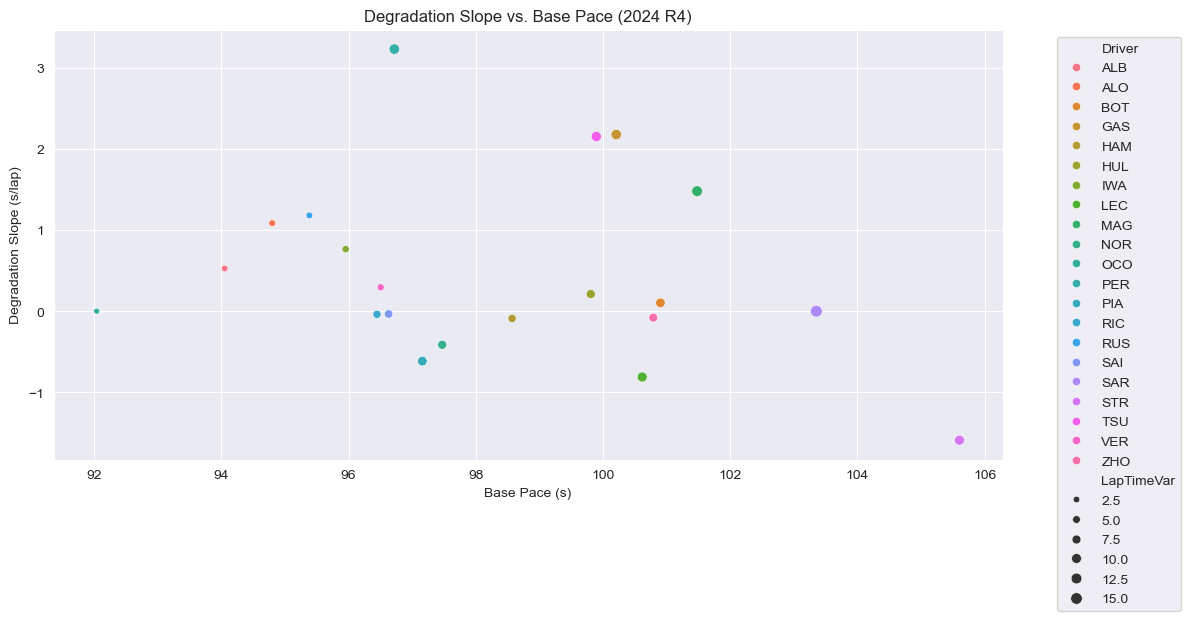


=== Conclusion ===
- Fastest: VER (89.56s).
2025-03-22 11:12:19,533 - INFO - Step 6: Analyzing telemetry
2025-03-22 11:12:20,037 - INFO - Saved telemetry metrics to C:\data\Dropbox\dev\F1\raw_data\2024\R4\2024_R4_telemetry_metrics.csv

Telemetry Metrics (Top 10 by Max Speed) for Japanese Grand Prix:
Driver   MaxSpeed  ThrottleTime  BrakingIntensity            Team
   SAR 313.705882     37.296866          0.165633        Williams
   ALB 313.380952     36.556353          0.161082        Williams
   NOR 309.550000     44.323913          0.123847         McLaren
   MAG 308.928571     46.468773          0.164955    Haas F1 Team
   STR 308.480000     44.419397          0.145252    Aston Martin
   GAS 307.695652     41.896893          0.136195          Alpine
   RUS 307.666667     51.552530          0.132376        Mercedes
   HUL 306.913043     46.996567          0.160672    Haas F1 Team
   RIC 306.833333     38.821865          0.116456              RB
   VER 306.772727     51.309418       

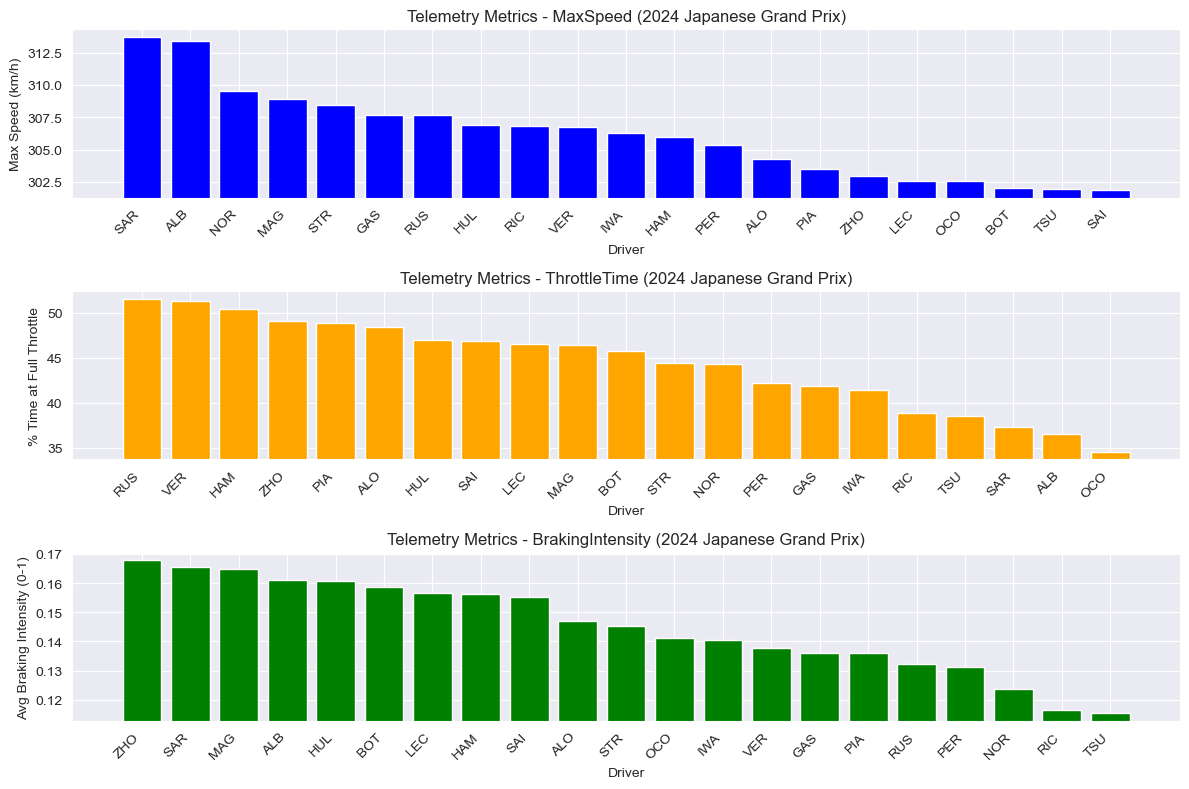


=== Conclusion ===
- Fastest Speed: SAR (313.71 km/h).
- Most Throttle: RUS (51.55%).
2025-03-22 11:12:21,876 - INFO - Step 7: Performing sandbagging analysis
2025-03-22 11:12:21,899 - INFO - Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R4\2024_R4_sandbag_analysis.csv

Potential Sandbaggers (Sorted by PredictionDiscrepancy):
Driver  FastestLapTime         Team  Sector1Time  Sector2Time  Sector3Time   MaxSpeed  ThrottleTime  ExpectedLapTime  LapTimeDiscrepancy  PredictedLapTime  PredictionDiscrepancy  SpeedRank  LapTimeRank  SandbagFlag
   IWA          92.103           RB       32.495       41.482       18.126 306.312500     41.424945           92.103       -1.421085e-14         90.635178               1.467822       11.0         21.0         True
   MAG          91.462 Haas F1 Team       32.482       41.022       17.888 308.928571     46.468773           91.392        7.000000e-02         90.764574               0.697426        4.0         20.0         True
   STR   

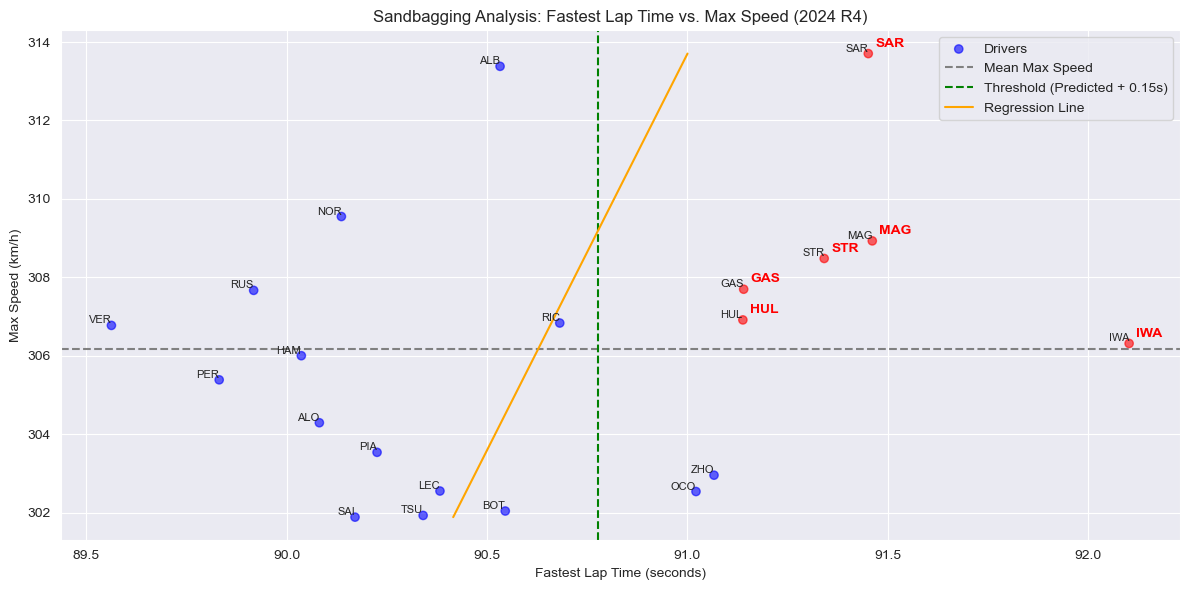

2025-03-22 11:12:22,705 - INFO - Step 8: Analyzing track evolution and weather
2025-03-22 11:12:22,708 - INFO - Average lap time for Practice 1: 110.058 seconds (±19.115)
2025-03-22 11:12:22,710 - INFO - Average lap time for Practice 2: 121.394 seconds (±17.272)
2025-03-22 11:12:22,712 - INFO - Average lap time for Practice 3: 106.689 seconds (±17.995)
2025-03-22 11:12:22,718 - INFO - Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R4\2024_R4_track_evolution.csv

Average Lap Times Across Sessions:
   Session  AvgLapTime  StdLapTime  LapCount
Practice 1  110.057948   19.115058       290
Practice 2  121.394444   17.271920        36
Practice 3  106.689283   17.995456       343

Average Weather Conditions Across Sessions:
   Session   AirTemp  Humidity  Rainfall  TrackTemp
Practice 1 16.566250 42.687500  0.000000  24.296250
Practice 2 13.020930 72.953488  0.209302  16.752326
Practice 3 17.382278 66.101266  0.000000  26.660759

Correlation between AvgLapTime and TrackTemp: -1.

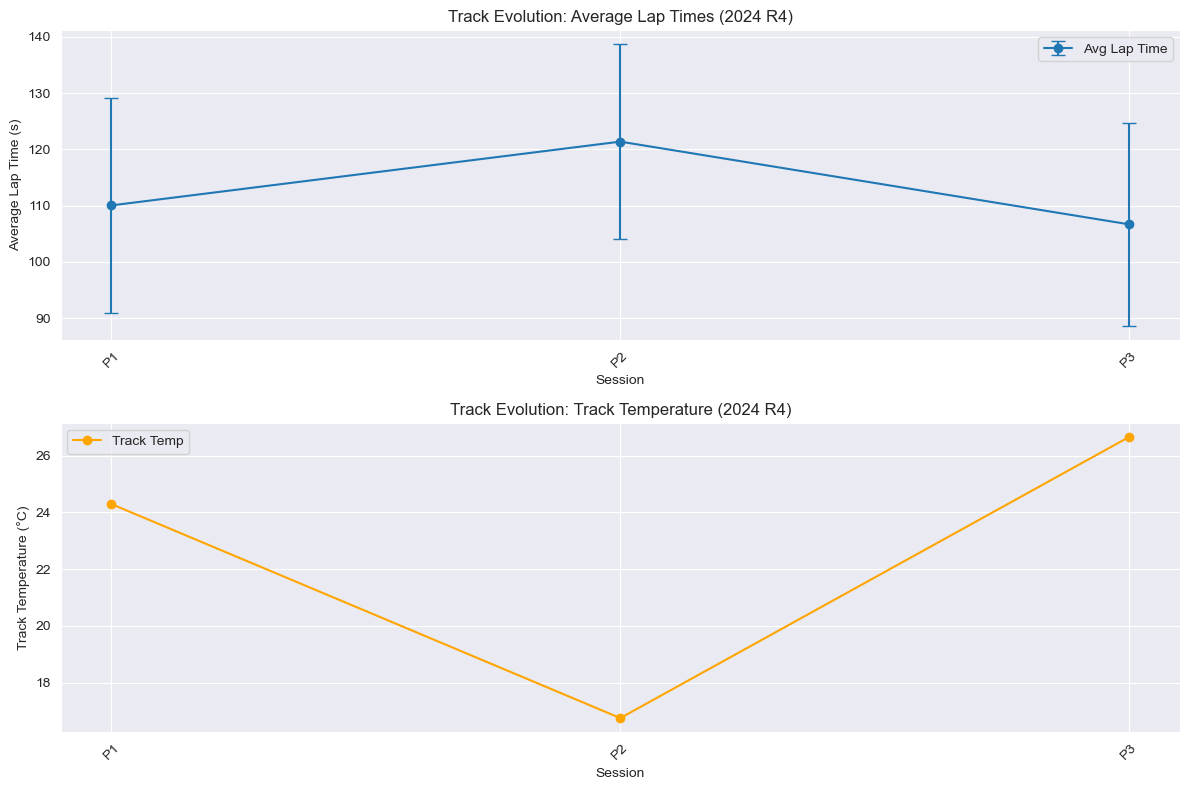

2025-03-22 11:12:23,797 - INFO - Step 9: Analyzing track characteristics
2025-03-22 11:12:23,838 - INFO - Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R4\2024_R4_track_characteristics.csv
2025-03-22 11:12:23,847 - INFO - Saved track char drivers to C:\data\Dropbox\dev\F1\raw_data\2024\R4\2024_R4_track_char_drivers.csv
Track Characteristics:
              Track DownforceRequirement OvertakingDifficulty  DRSZones TyreDegradation  LapLength SuitsFastCars
Japanese Grand Prix                  Low                 Easy         3             Low      5.807           Yes

Top 5 Drivers by Track Fit:
Driver            Team  StraightSpeedPotential  CorneringPotential   AvgSpeed  OverallFit  FitRank
   ALB        Williams              313.380952           30.177667 230.912485    0.996061      1.0
   SAR        Williams              313.705882           30.484000 228.592048    0.993803      2.0
   NOR         McLaren              309.550000           29.965000 231.926956    0

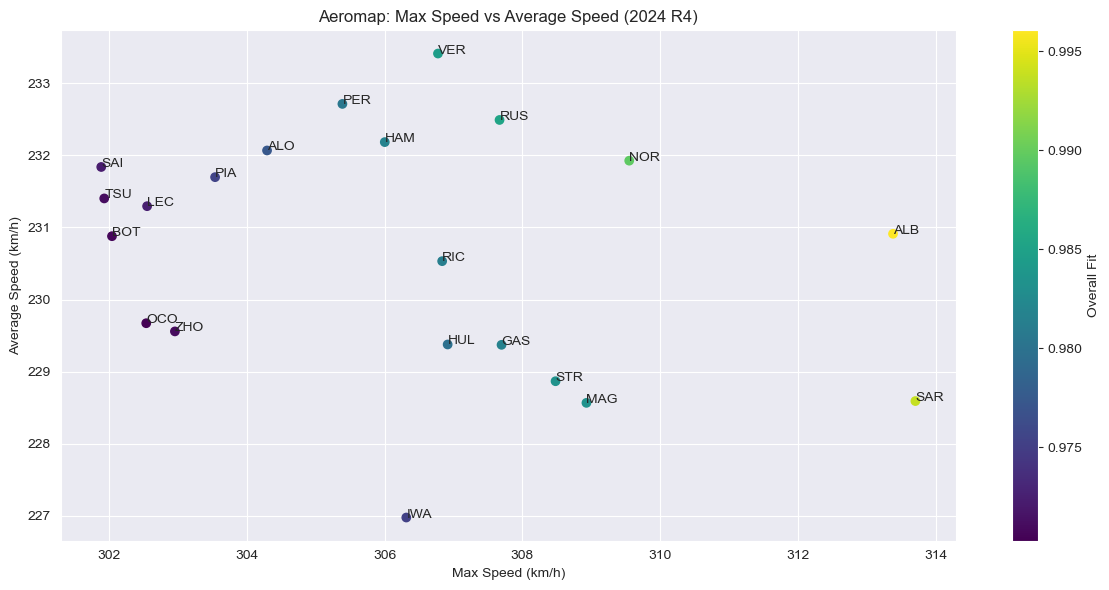

2025-03-22 11:12:27,455 - INFO - Step 10: Predicting race outcomes
2025-03-22 11:12:27,464 - INFO - Loaded pit_stop_loss from file: -101.42s for Japanese Grand Prix
2025-03-22 11:12:27,497 - INFO - No Sprint session data available; setting SprintPaceAdjustment to 0 for all drivers.
2025-03-22 11:12:27,523 - INFO - Predicted Fastest Lap Driver: VER
2025-03-22 11:12:27,533 - INFO - Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R4\2024_R4_quali_prediction.csv
2025-03-22 11:12:27,535 - INFO - Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R4\2024_R4_race_prediction.csv

Qualifying Prediction:
Driver            Team  LapTime  ExpectedLapTime  AdjustedLapTime  QualiPosition
   VER Red Bull Racing   89.563           89.563           89.563              1
   NOR         McLaren   90.137           89.895           89.653              2
   HAM        Mercedes   90.037           89.856           89.675              3
   SAI         Ferrari   90.171           8

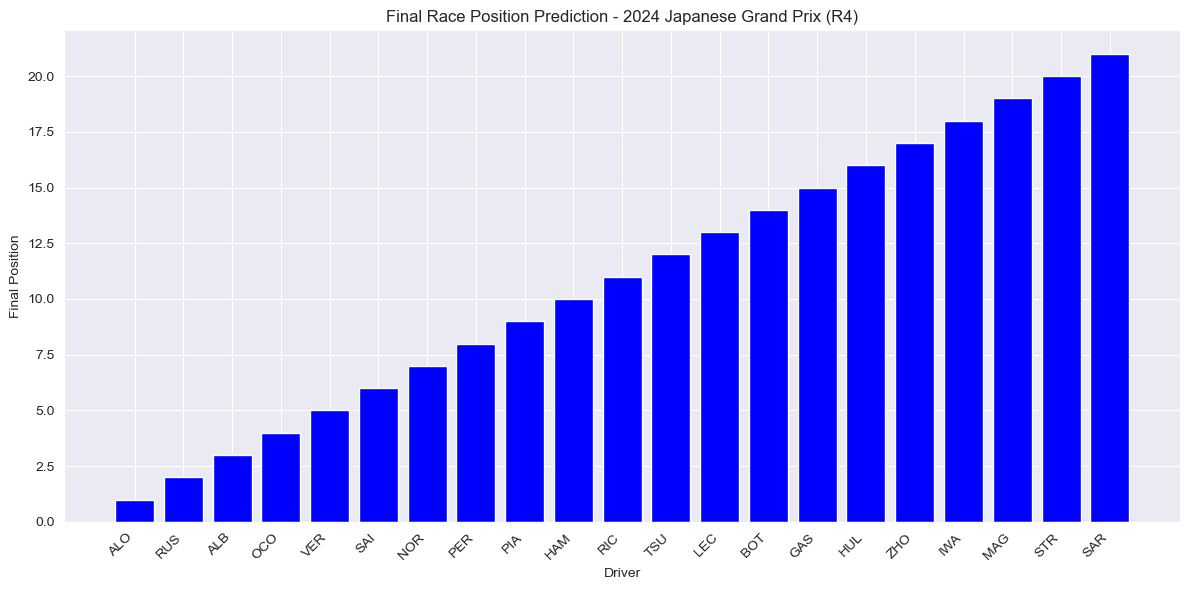

2025-03-22 11:12:28,494 - INFO - Step 11: Generating summary report
Debug: Verifying input DataFrames...
quali_prediction_df shape: (21, 9)
race_prediction_df shape: (21, 25)
driver_performance shape: (21, 12)
Pit stop loss for Japanese Grand Prix: -101.42s
Debug: Sample pit stop durations:
Driver  LapNumber              PitInTime             PitOutTime  PitDuration
   ZHO       12.0 0 days 01:52:08.494000 0 days 01:50:27.076000     -101.418
Calculated pit_stop_loss for Japanese Grand Prix: -101.42s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\raw_data\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['VER', 'PER', 'NOR', 'SAI', 'ALO']
Dynamically fetched actual race top 10: ['VER', 'PER', 'SAI', 'LEC', 'NOR', 'ALO', 'RUS', 'PIA', 'HAM', 'TSU']
Dynamically fetched actual fastest lap driver: VER

=== Comprehensive Summary Report ===

Event: 2024 Round 4 - Japanese Grand Prix

--- Qualifying Analysis ---
Actual Qualifying Top 5: ['VER', 'PER', 'NOR', 'SAI', 'ALO']

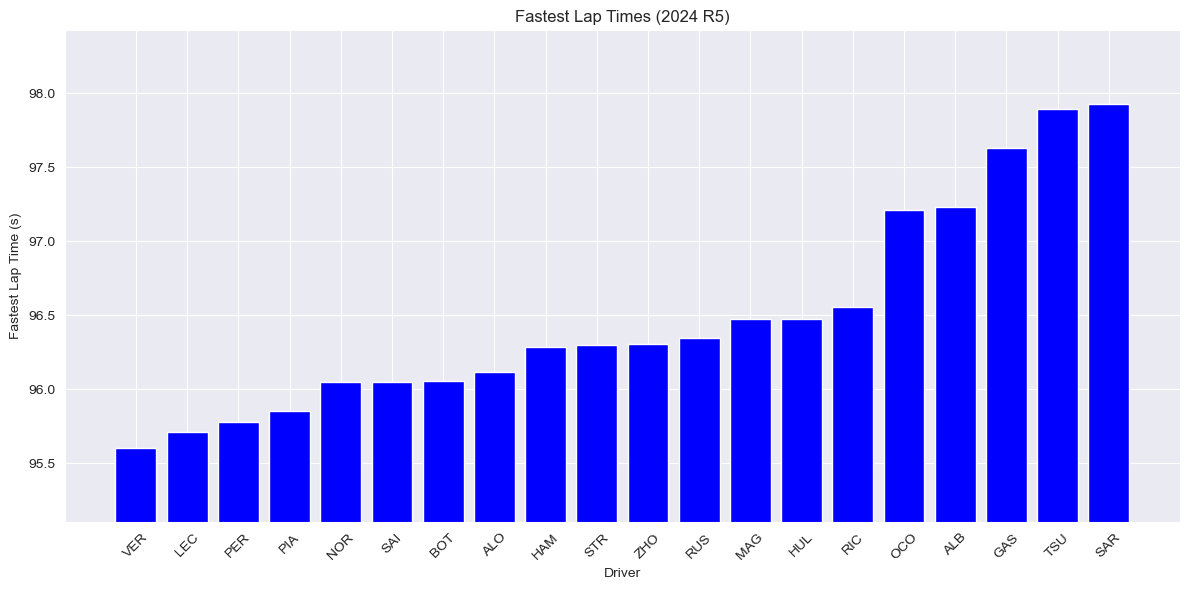


Plot 1 saved to C:\data\Dropbox\dev\F1\raw_data\2024\R5\fastest_vs_theoretical.png


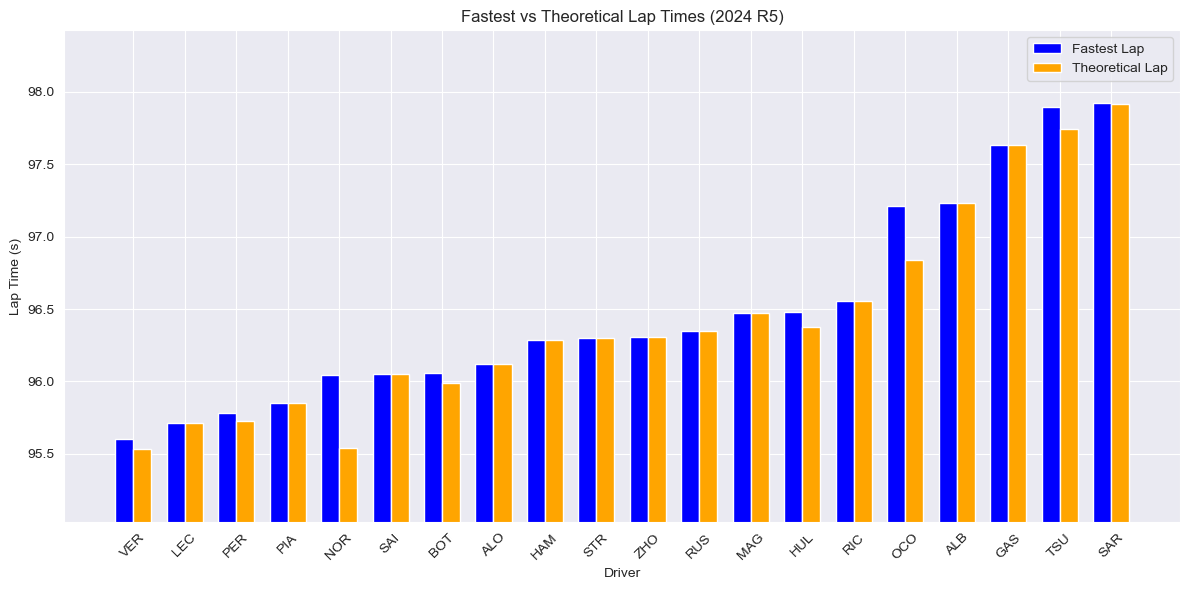


Degradation Slope Histogram saved to C:\data\Dropbox\dev\F1\raw_data\2024\R5\degradation_slope_histogram.png


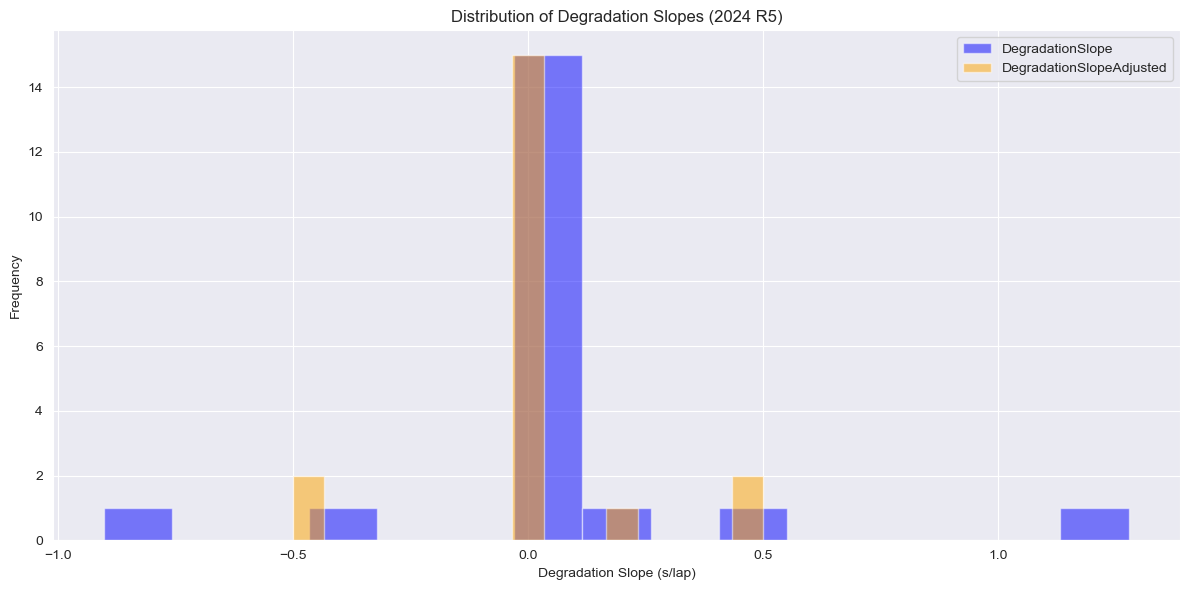


Degradation Slope by Team Boxplot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R5\degradation_slope_by_team.png


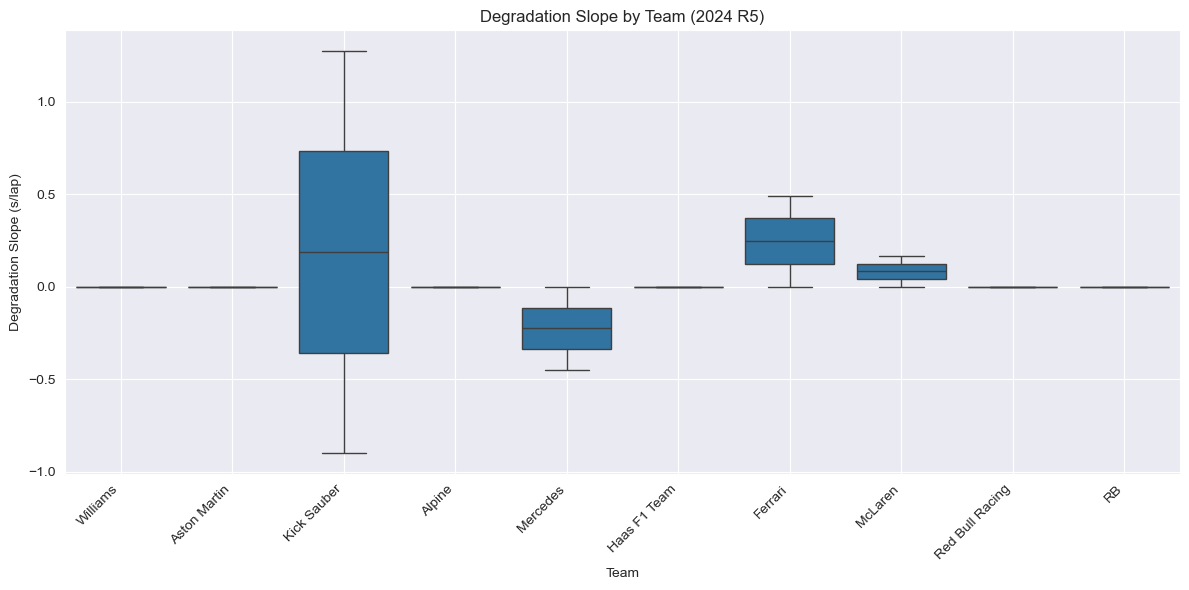


Degradation Slope vs. Base Pace Scatter Plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R5\degradation_slope_vs_basepace.png


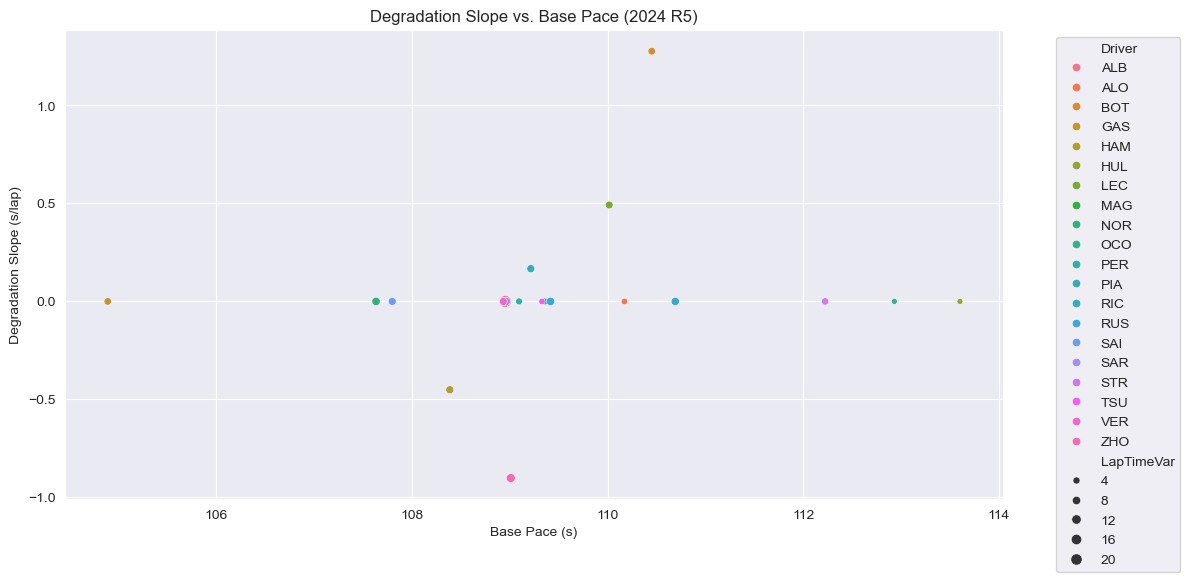


=== Conclusion ===
- Fastest: VER (95.61s).
2025-03-22 11:12:53,061 - INFO - Step 6: Analyzing telemetry
2025-03-22 11:12:53,785 - INFO - Saved telemetry metrics to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_telemetry_metrics.csv

Telemetry Metrics (Top 10 by Max Speed) for Chinese Grand Prix:
Driver   MaxSpeed  ThrottleTime  BrakingIntensity            Team
   RIC 319.575000     36.011835          0.181496              RB
   STR 318.891892     38.487480          0.198525    Aston Martin
   LEC 318.282051     37.953599          0.217999         Ferrari
   NOR 317.729730     38.730093          0.187230         McLaren
   OCO 317.222222     36.474278          0.206236          Alpine
   PER 317.052632     41.370386          0.196210 Red Bull Racing
   GAS 316.628571     40.567624          0.181321          Alpine
   ALB 315.548387     37.278310          0.212750        Williams
   TSU 314.829268     36.206834          0.177174              RB
   SAI 314.567568     39.176790        

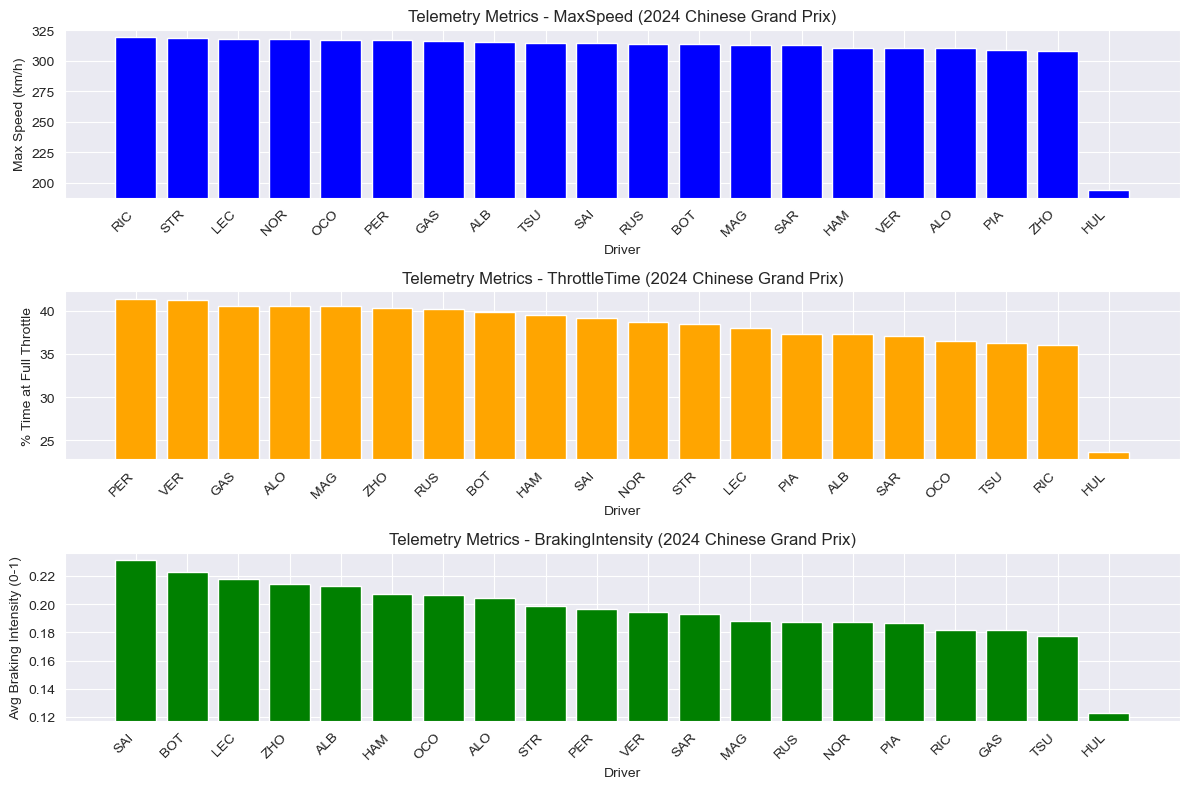


=== Conclusion ===
- Fastest Speed: RIC (319.57 km/h).
- Most Throttle: PER (41.37%).
2025-03-22 11:12:58,450 - INFO - Step 7: Performing sandbagging analysis
2025-03-22 11:12:58,522 - INFO - Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_sandbag_analysis.csv

Potential Sandbaggers (Sorted by PredictionDiscrepancy):
Driver  FastestLapTime     Team  Sector1Time  Sector2Time  Sector3Time   MaxSpeed  ThrottleTime  ExpectedLapTime  LapTimeDiscrepancy  PredictedLapTime  PredictionDiscrepancy  SpeedRank  LapTimeRank  SandbagFlag
   SAR          97.923 Williams       25.603       29.214       43.097 313.088235     37.021443           97.914               0.009         96.496437               1.426563       14.0         20.0         True
   TSU          97.892       RB       25.445       29.035       43.263 314.829268     36.206834           97.743               0.149         96.497701               1.394299        9.0         19.0         True
   GAS          97.63

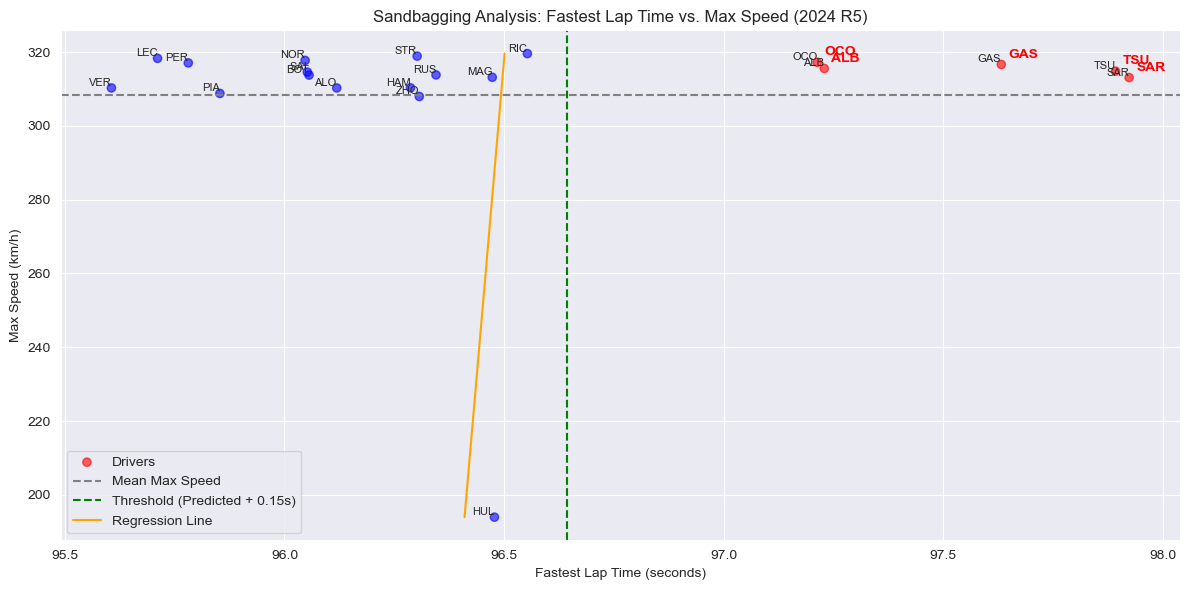

2025-03-22 11:12:59,914 - INFO - Step 8: Analyzing track evolution and weather
2025-03-22 11:12:59,920 - INFO - Average lap time for Practice 1: 112.049 seconds (±15.797)
2025-03-22 11:12:59,922 - INFO - Average lap time for Sprint Qualifying: 115.780 seconds (±14.864)
2025-03-22 11:12:59,924 - INFO - Average lap time for Sprint: 102.679 seconds (±1.642)
2025-03-22 11:12:59,931 - INFO - Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_track_evolution.csv

Average Lap Times Across Sessions:
          Session  AvgLapTime  StdLapTime  LapCount
       Practice 1  112.048803   15.797074       335
Sprint Qualifying  115.780051   14.864036       158
           Sprint  102.679405    1.642082       358

Average Weather Conditions Across Sessions:
          Session   AirTemp  Humidity  Rainfall  TrackTemp
       Practice 1 23.142683 22.865854  0.000000  39.468293
           Sprint 19.765000 69.537500  0.000000  26.965000
Sprint Qualifying 19.377143 40.800000  0.471429  26

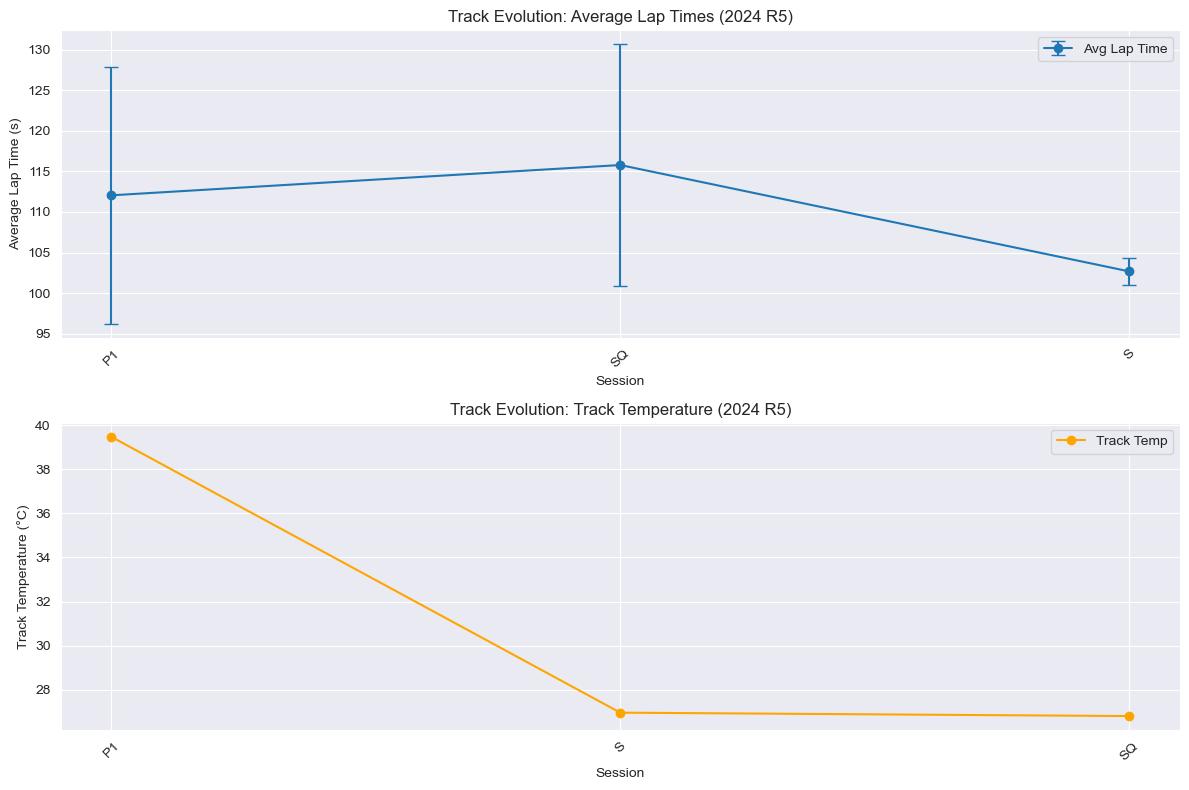

2025-03-22 11:13:01,123 - INFO - Step 9: Analyzing track characteristics
2025-03-22 11:13:01,155 - INFO - Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_track_characteristics.csv
2025-03-22 11:13:01,176 - INFO - Saved track char drivers to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_track_char_drivers.csv
Track Characteristics:
             Track DownforceRequirement OvertakingDifficulty  DRSZones TyreDegradation  LapLength SuitsFastCars
Chinese Grand Prix                  Low                 Easy         3             Low      5.513           Yes

Top 5 Drivers by Track Fit:
Driver            Team  StraightSpeedPotential  CorneringPotential   AvgSpeed  OverallFit  FitRank
   RIC              RB              319.575000           32.184333 205.553427    0.996825      1.0
   LEC         Ferrari              318.282051           31.903667 207.361745    0.996604      2.0
   STR    Aston Martin              318.891892           32.100667 206.089178    0.9

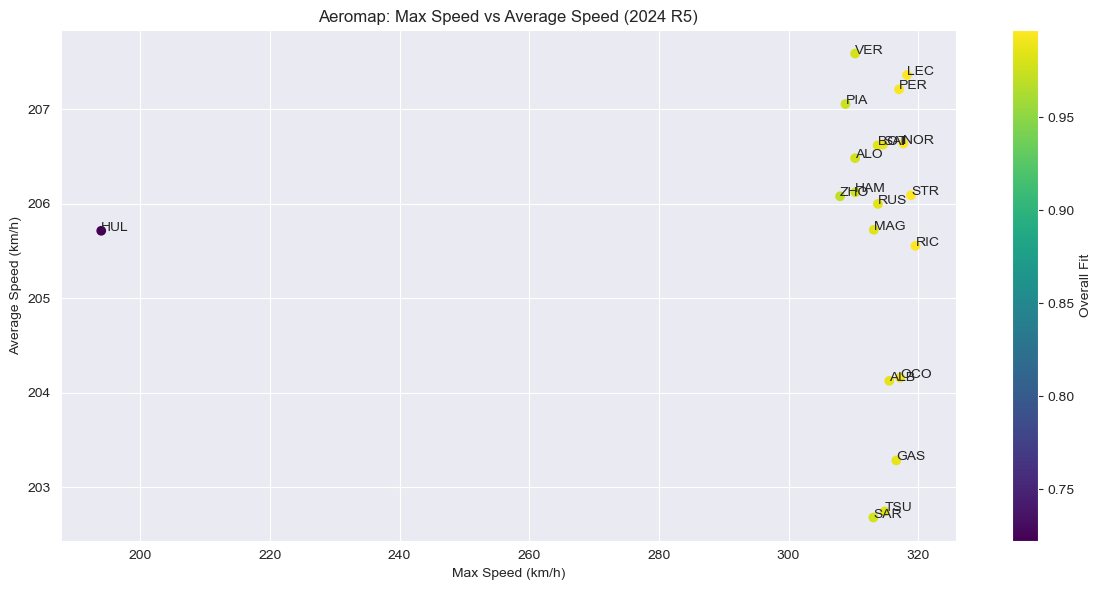

2025-03-22 11:13:03,015 - INFO - Step 10: Predicting race outcomes
2025-03-22 11:13:03,027 - INFO - Loaded pit_stop_loss from file: 20.00s for Chinese Grand Prix
2025-03-22 11:13:03,064 - WARNING - Could not compute track evolution factor; using default value of 0.
2025-03-22 11:13:03,083 - INFO - Predicted Fastest Lap Driver: VER
2025-03-22 11:13:03,096 - INFO - Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_quali_prediction.csv
2025-03-22 11:13:03,097 - INFO - Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R5\2024_R5_race_prediction.csv

Qualifying Prediction:
Driver            Team  LapTime  ExpectedLapTime  AdjustedLapTime  QualiPosition
   NOR         McLaren   96.047           95.542           95.037              1
   VER Red Bull Racing   95.606           95.531           95.456              2
   PER Red Bull Racing   95.781           95.727           95.673              3
   LEC         Ferrari   95.711           95.711           9

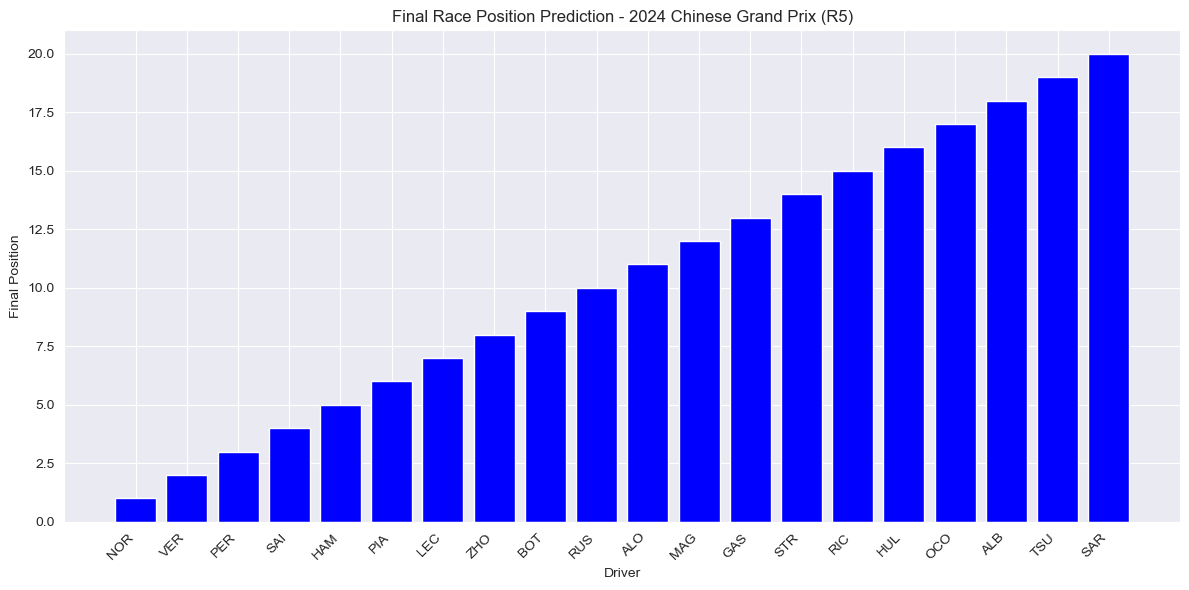

2025-03-22 11:13:04,081 - INFO - Step 11: Generating summary report
Debug: Verifying input DataFrames...
quali_prediction_df shape: (20, 9)
race_prediction_df shape: (20, 25)
driver_performance shape: (20, 12)
Pit stop loss for Chinese Grand Prix: 20.00s
Calculated pit_stop_loss for Chinese Grand Prix: 20.00s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\raw_data\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['VER', 'PER', 'ALO', 'NOR', 'PIA']
Dynamically fetched actual race top 10: ['VER', 'NOR', 'PER', 'LEC', 'SAI', 'RUS', 'ALO', 'PIA', 'HAM', 'HUL']
Dynamically fetched actual fastest lap driver: ALO

=== Comprehensive Summary Report ===

Event: 2024 Round 5 - Chinese Grand Prix

--- Qualifying Analysis ---
Actual Qualifying Top 5: ['VER', 'PER', 'ALO', 'NOR', 'PIA']
Predicted Qualifying Top 5:
Driver  AdjustedLapTime  QualiPosition
   NOR           95.037              1
   VER           95.456              2
   PER           95.673              3
   LEC    

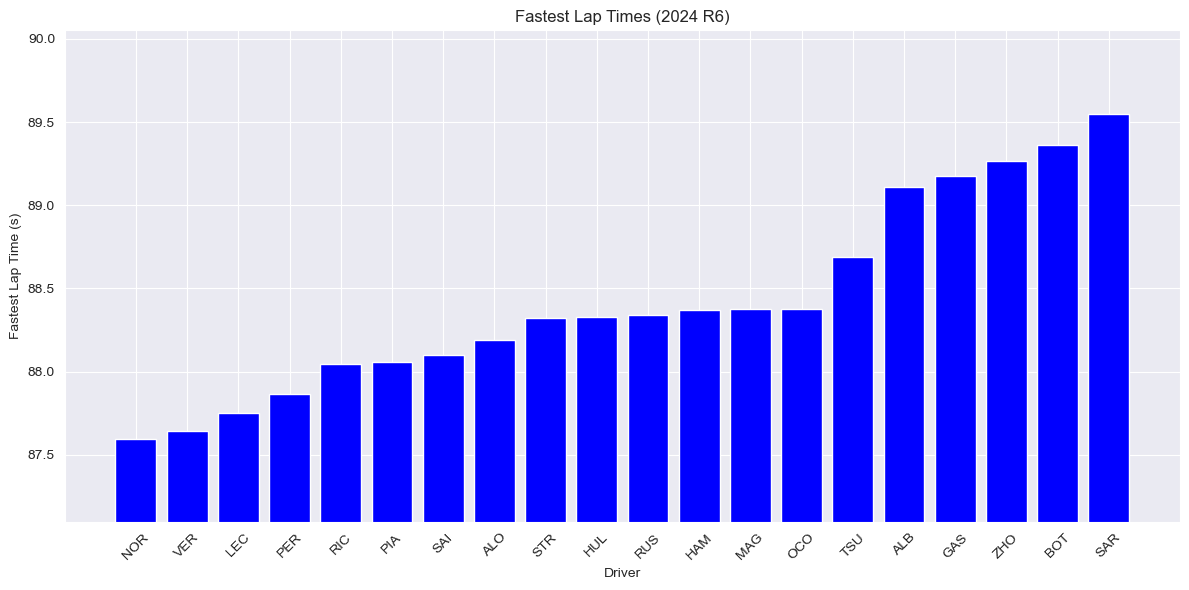


Plot 1 saved to C:\data\Dropbox\dev\F1\raw_data\2024\R6\fastest_vs_theoretical.png


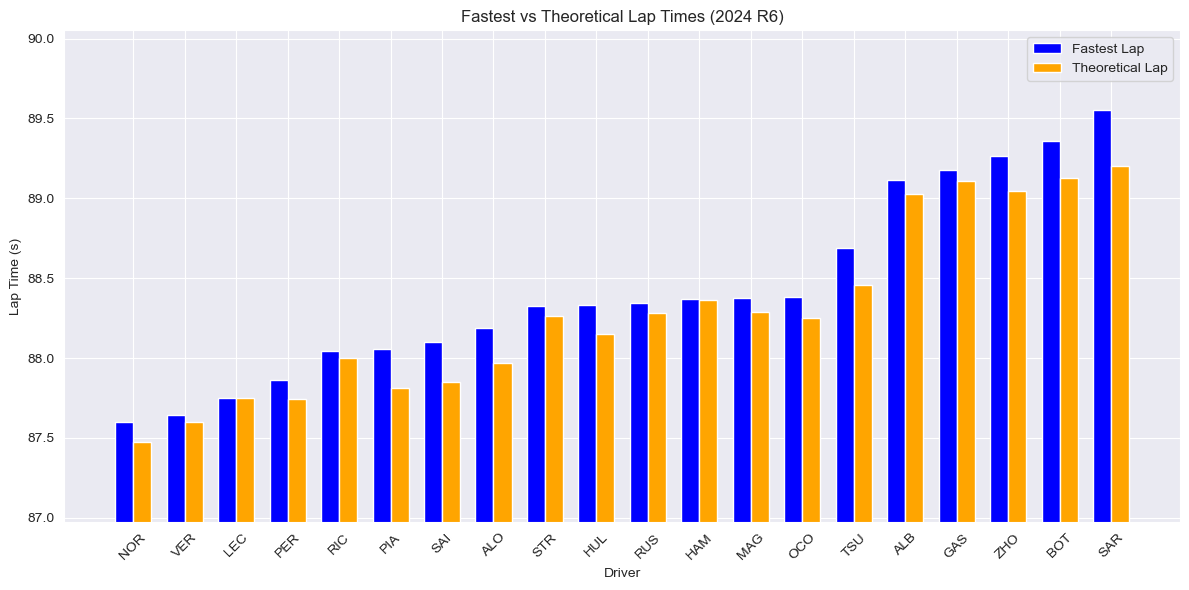


Degradation Slope Histogram saved to C:\data\Dropbox\dev\F1\raw_data\2024\R6\degradation_slope_histogram.png


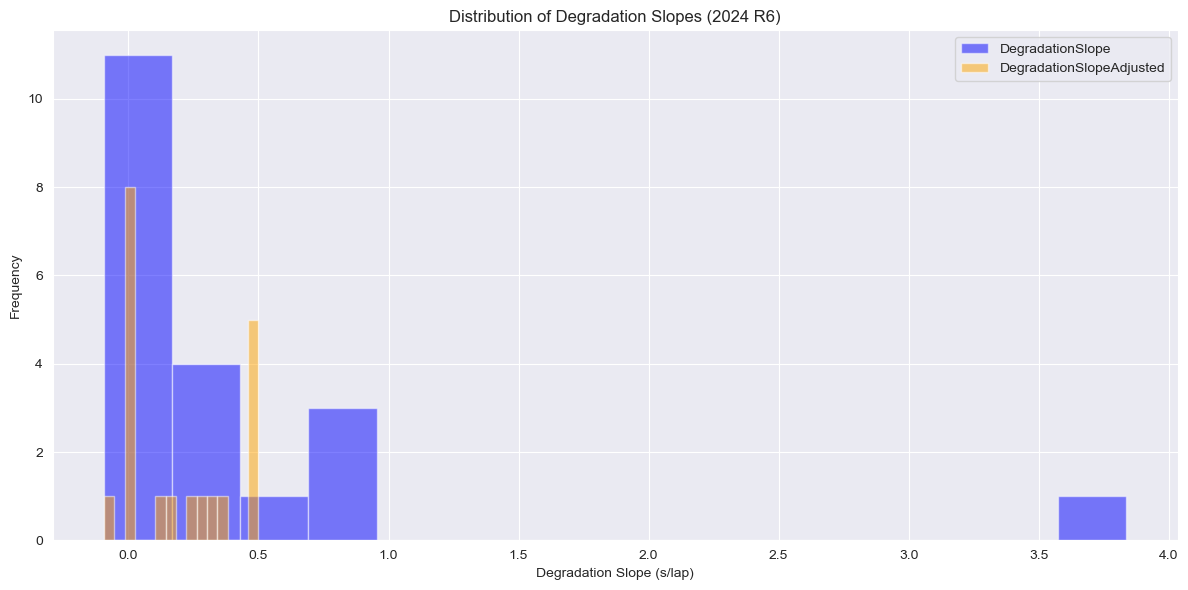


Degradation Slope by Team Boxplot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R6\degradation_slope_by_team.png


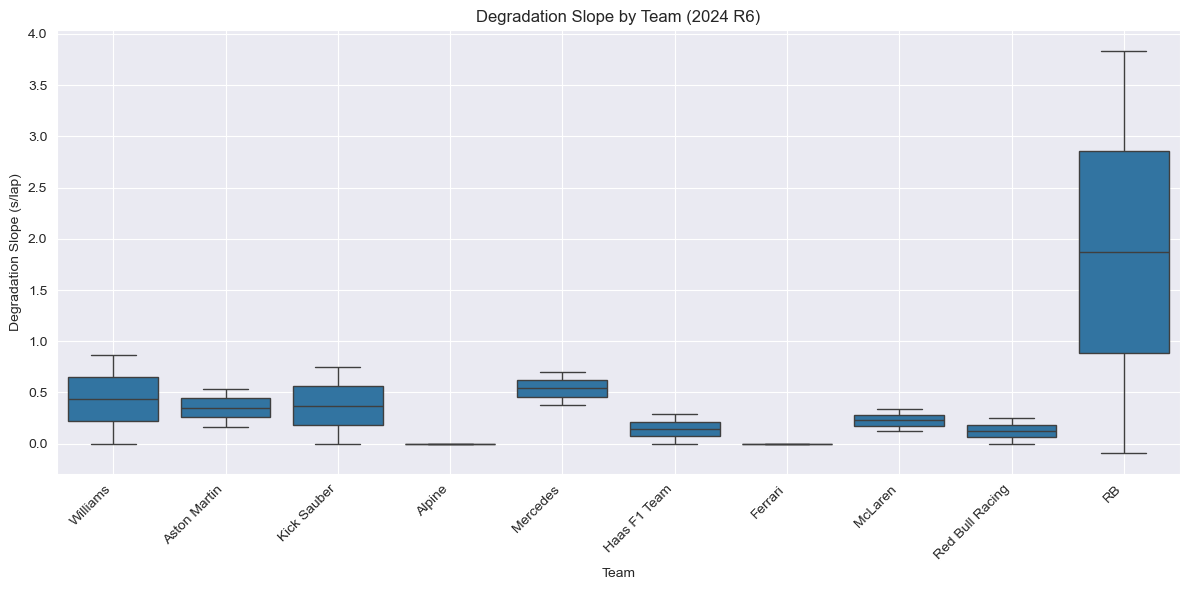


Degradation Slope vs. Base Pace Scatter Plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R6\degradation_slope_vs_basepace.png


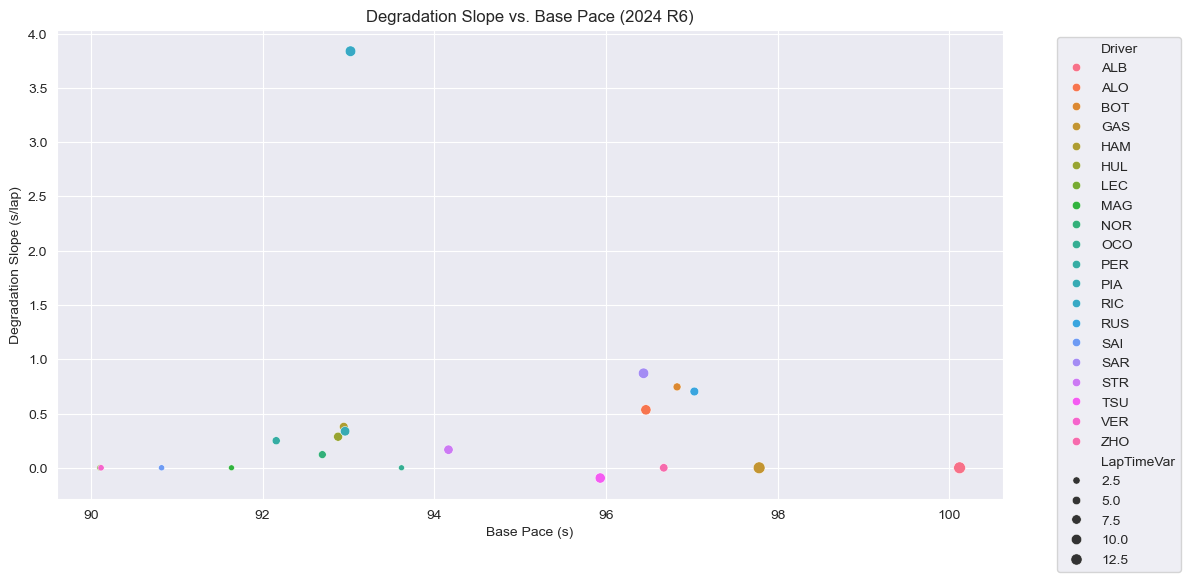


=== Conclusion ===
- Fastest: NOR (87.60s).
2025-03-22 11:13:36,298 - INFO - Step 6: Analyzing telemetry
2025-03-22 11:13:37,183 - INFO - Saved telemetry metrics to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_telemetry_metrics.csv

Telemetry Metrics (Top 10 by Max Speed) for Miami Grand Prix:
Driver   MaxSpeed  ThrottleTime  BrakingIntensity            Team
   ALB 336.861111     40.084813          0.206397        Williams
   RUS 333.514286     45.534274          0.175620        Mercedes
   SAR 332.242424     42.898815          0.195616        Williams
   ALO 331.647059     45.689183          0.177985    Aston Martin
   HAM 330.967742     49.484771          0.197302        Mercedes
   PIA 327.525000     40.874700          0.165652         McLaren
   GAS 327.150000     41.195620          0.155925          Alpine
   PER 326.806452     51.973792          0.187909 Red Bull Racing
   ZHO 326.416667     40.824618          0.202547     Kick Sauber
   BOT 326.088235     43.665308          

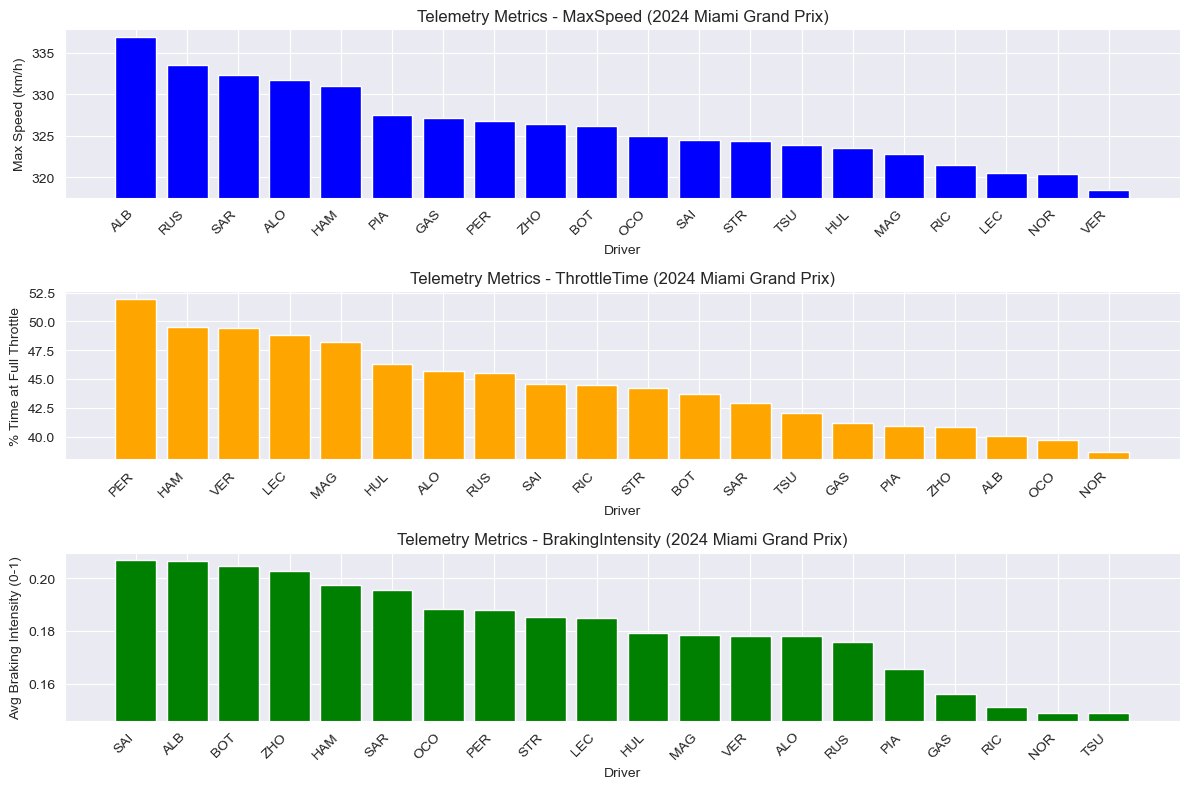


=== Conclusion ===
- Fastest Speed: ALB (336.86 km/h).
- Most Throttle: PER (51.97%).
2025-03-22 11:13:39,190 - INFO - Step 7: Performing sandbagging analysis
2025-03-22 11:13:39,220 - INFO - Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_sandbag_analysis.csv

Potential Sandbaggers (Sorted by PredictionDiscrepancy):
Driver  FastestLapTime        Team  Sector1Time  Sector2Time  Sector3Time   MaxSpeed  ThrottleTime  ExpectedLapTime  LapTimeDiscrepancy  PredictedLapTime  PredictionDiscrepancy  SpeedRank  LapTimeRank  SandbagFlag
   ZHO          89.267 Kick Sauber       29.733       34.093       25.219 326.416667     40.824618           89.045               0.222         88.441319               0.825681        9.0         18.0         True
   SAR          89.551    Williams       30.214       34.041       24.948 332.242424     42.898815           89.203               0.348         88.825431               0.725569        3.0         20.0         True
   GAS      

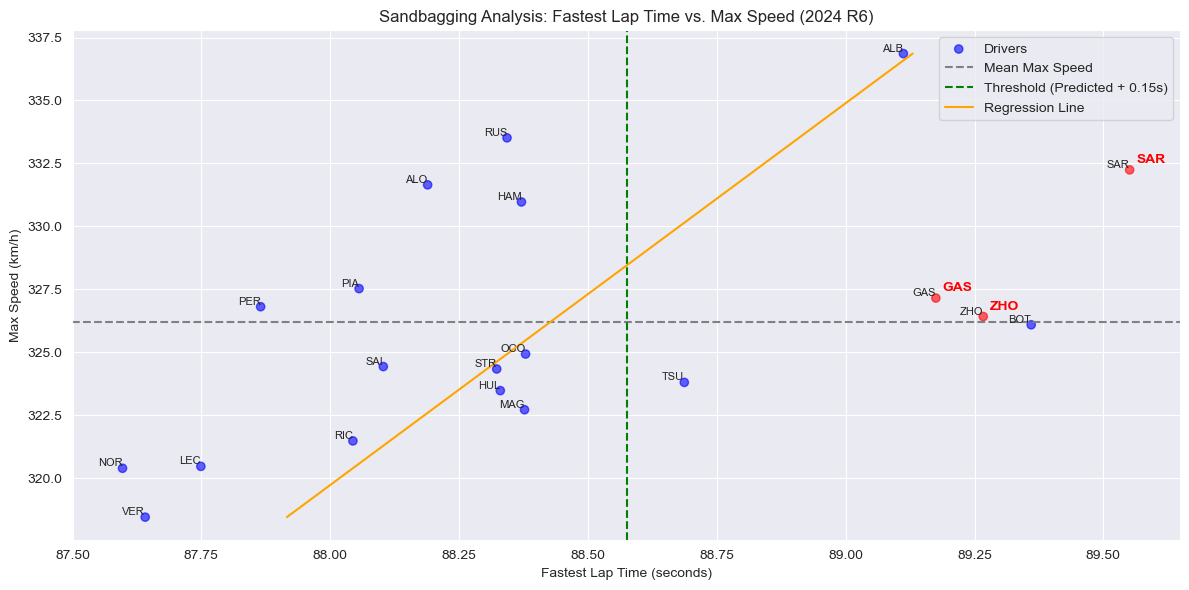

2025-03-22 11:13:40,600 - INFO - Step 8: Analyzing track evolution and weather
2025-03-22 11:13:40,605 - INFO - Average lap time for Practice 1: 107.262 seconds (±19.170)
2025-03-22 11:13:40,607 - INFO - Average lap time for Sprint Qualifying: 106.616 seconds (±17.803)
2025-03-22 11:13:40,609 - INFO - Average lap time for Sprint: 94.764 seconds (±10.784)
2025-03-22 11:13:40,615 - INFO - Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_track_evolution.csv

Average Lap Times Across Sessions:
          Session  AvgLapTime  StdLapTime  LapCount
       Practice 1  107.261898   19.169512       363
Sprint Qualifying  106.616345   17.803172       165
           Sprint   94.764053   10.783555       301

Average Weather Conditions Across Sessions:
          Session   AirTemp  Humidity  Rainfall  TrackTemp
       Practice 1 28.780519 56.272727       0.0  49.958442
           Sprint 28.698780 56.024390       0.0  44.826829
Sprint Qualifying 28.444444 58.968254       0.0  46

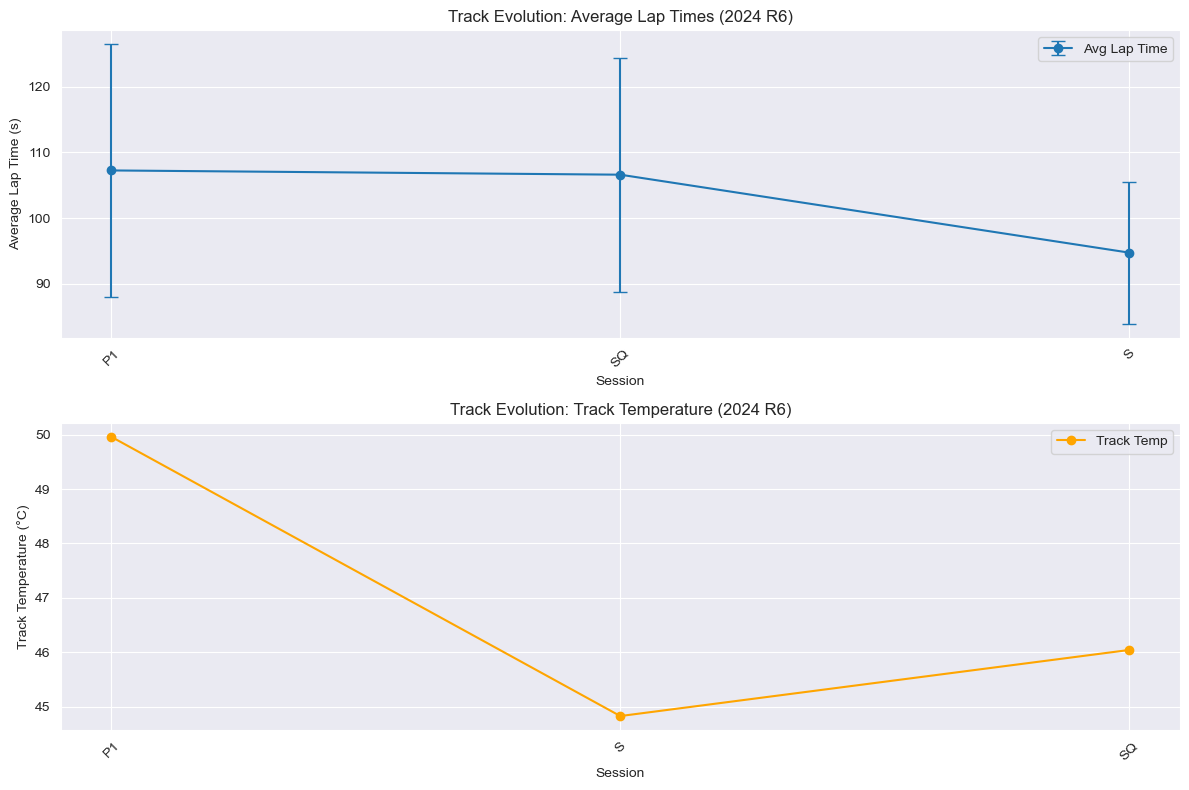

2025-03-22 11:13:41,447 - INFO - Step 9: Analyzing track characteristics
2025-03-22 11:13:41,466 - INFO - Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_track_characteristics.csv
2025-03-22 11:13:41,472 - INFO - Saved track char drivers to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_track_char_drivers.csv
Track Characteristics:
           Track DownforceRequirement OvertakingDifficulty  DRSZones TyreDegradation  LapLength SuitsFastCars
Miami Grand Prix                  Low                 Easy         3             Low      5.793           Yes

Top 5 Drivers by Track Fit:
Driver         Team  StraightSpeedPotential  CorneringPotential   AvgSpeed  OverallFit  FitRank
   ALB     Williams              336.861111           29.674667 234.029087    0.994777      1.0
   RUS     Mercedes              333.514286           29.428000 236.066242    0.990293      2.0
   ALO Aston Martin              331.647059           29.322333 236.478472    0.987484      3.0
 

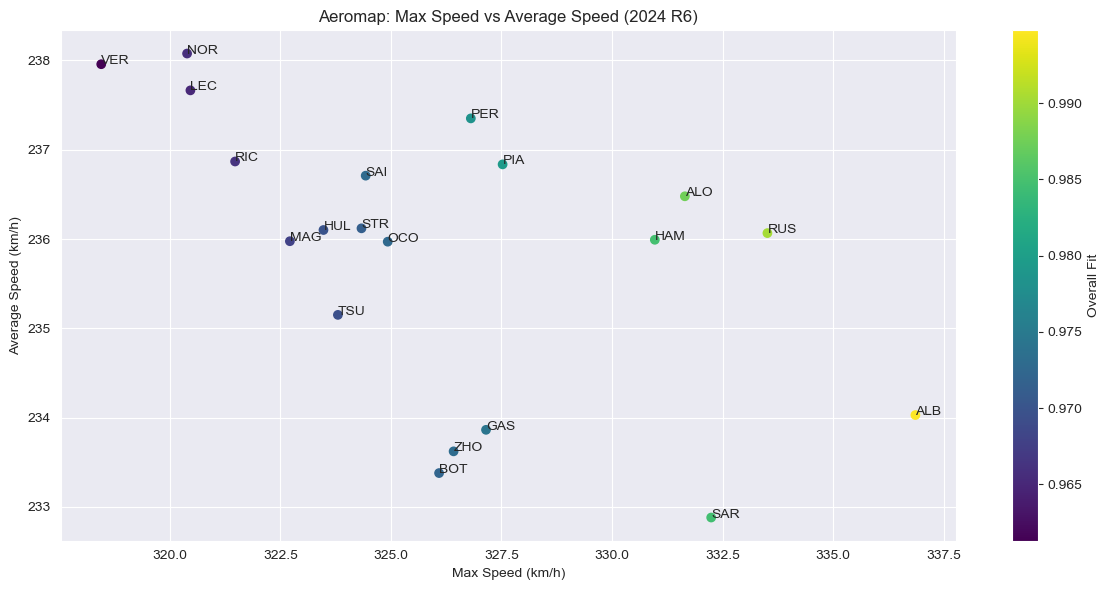

2025-03-22 11:13:43,250 - INFO - Step 10: Predicting race outcomes
2025-03-22 11:13:43,257 - INFO - Loaded pit_stop_loss from file: 20.00s for Miami Grand Prix
2025-03-22 11:13:43,296 - WARNING - Could not compute track evolution factor; using default value of 0.
2025-03-22 11:13:43,312 - INFO - Predicted Fastest Lap Driver: NOR
2025-03-22 11:13:43,322 - INFO - Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_quali_prediction.csv
2025-03-22 11:13:43,324 - INFO - Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R6\2024_R6_race_prediction.csv

Qualifying Prediction:
Driver            Team  LapTime  ExpectedLapTime  AdjustedLapTime  QualiPosition
   NOR         McLaren   87.597           87.474           87.351              1
   VER Red Bull Racing   87.641           87.601           87.561              2
   PIA         McLaren   88.056           87.813           87.570              3
   SAI         Ferrari   88.103           87.848           87.

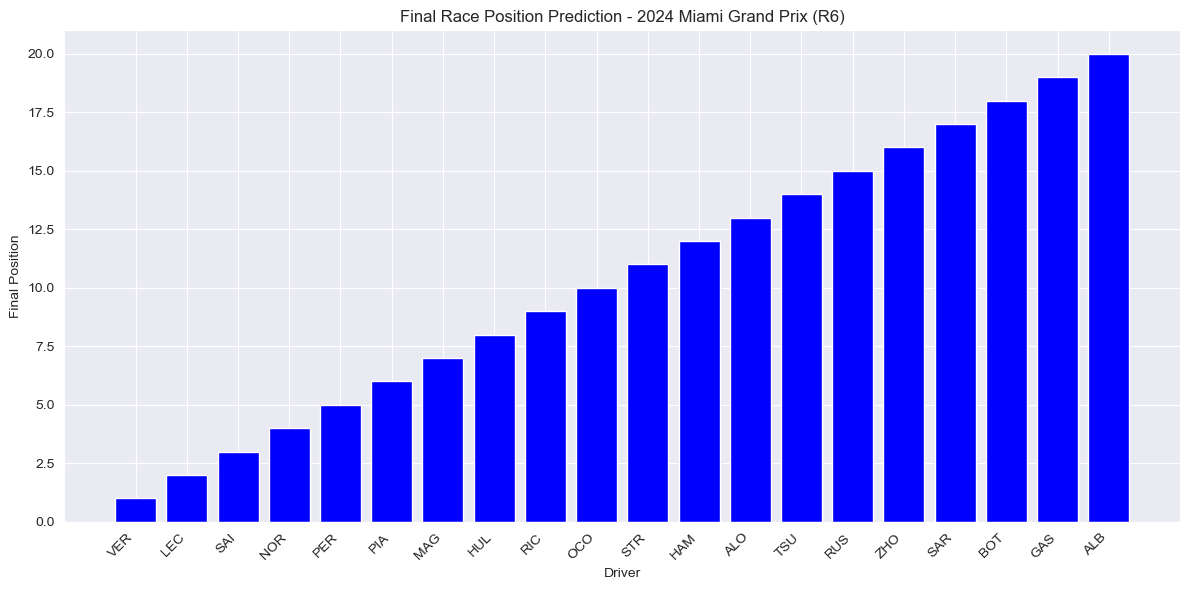

2025-03-22 11:13:44,032 - INFO - Step 11: Generating summary report
Debug: Verifying input DataFrames...
quali_prediction_df shape: (20, 9)
race_prediction_df shape: (20, 25)
driver_performance shape: (20, 12)
Pit stop loss for Miami Grand Prix: 20.00s
Calculated pit_stop_loss for Miami Grand Prix: 20.00s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\raw_data\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['VER', 'LEC', 'SAI', 'PER', 'NOR']
Dynamically fetched actual race top 10: ['NOR', 'VER', 'LEC', 'PER', 'SAI', 'HAM', 'TSU', 'RUS', 'ALO', 'OCO']
Dynamically fetched actual fastest lap driver: PIA

=== Comprehensive Summary Report ===

Event: 2024 Round 6 - Miami Grand Prix

--- Qualifying Analysis ---
Actual Qualifying Top 5: ['VER', 'LEC', 'SAI', 'PER', 'NOR']
Predicted Qualifying Top 5:
Driver  AdjustedLapTime  QualiPosition
   NOR           87.351              1
   VER           87.561              2
   PIA           87.570              3
   SAI          

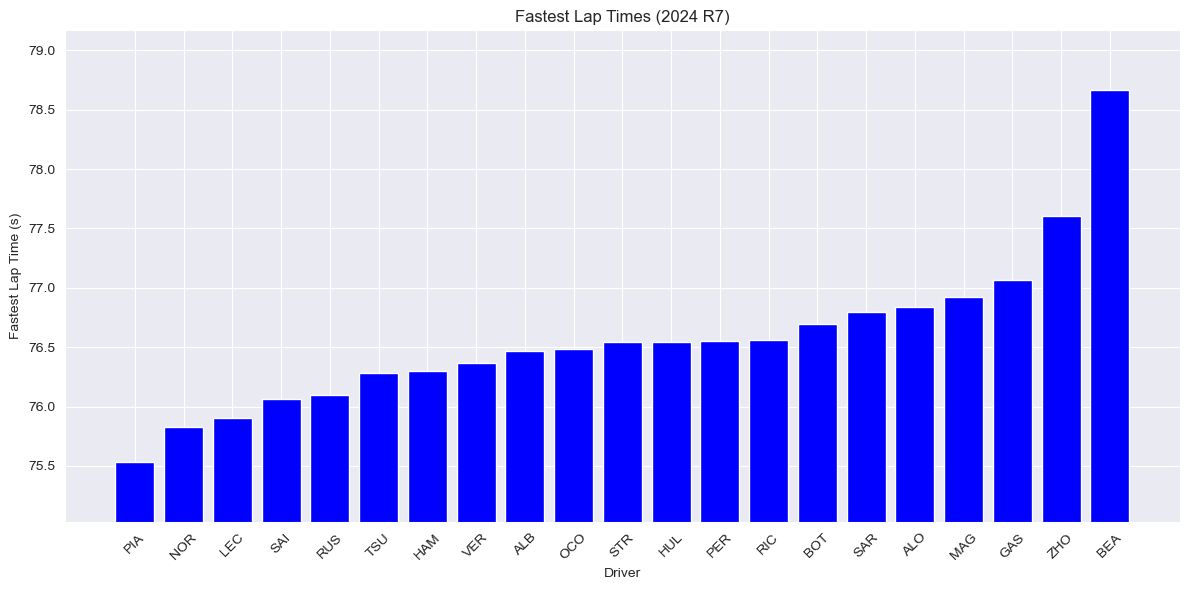


Plot 1 saved to C:\data\Dropbox\dev\F1\raw_data\2024\R7\fastest_vs_theoretical.png


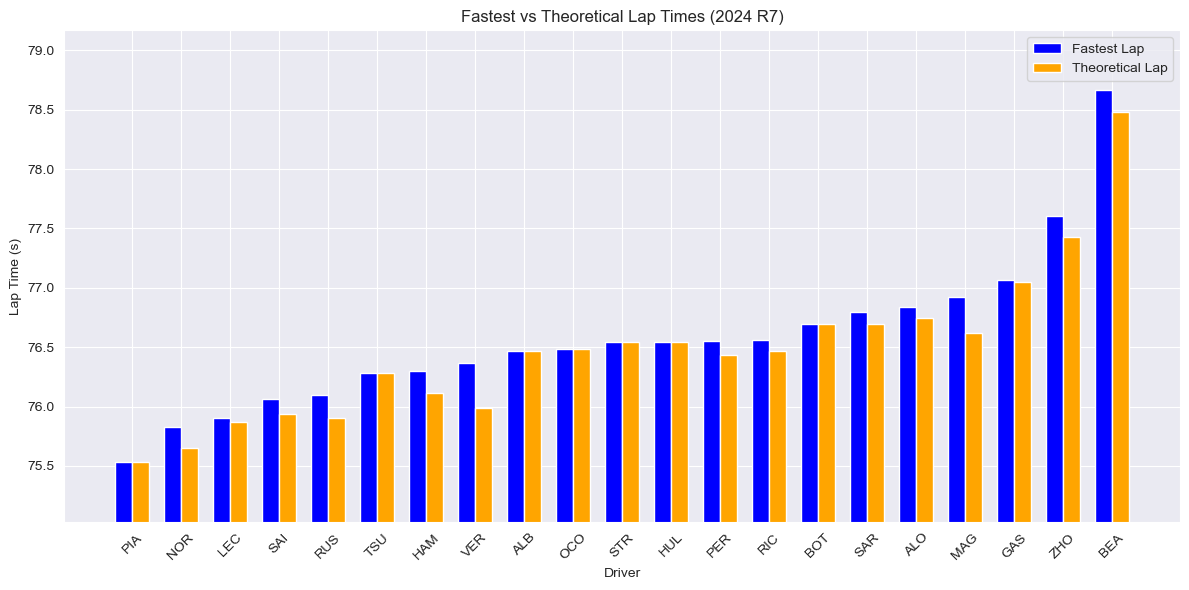


Degradation Slope Histogram saved to C:\data\Dropbox\dev\F1\raw_data\2024\R7\degradation_slope_histogram.png


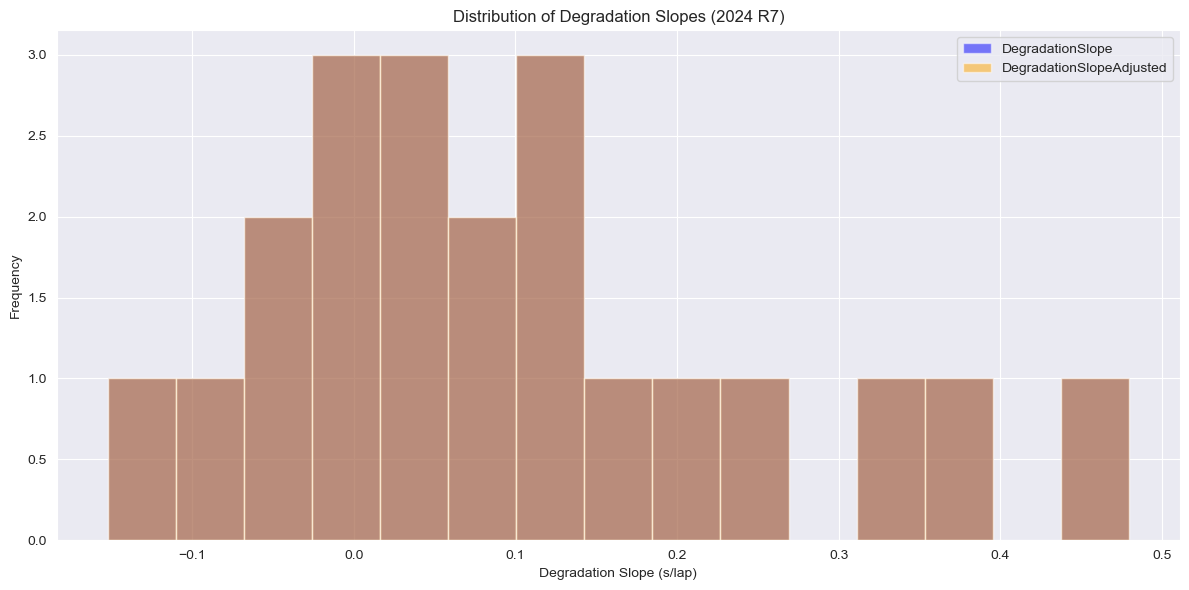


Degradation Slope by Team Boxplot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R7\degradation_slope_by_team.png


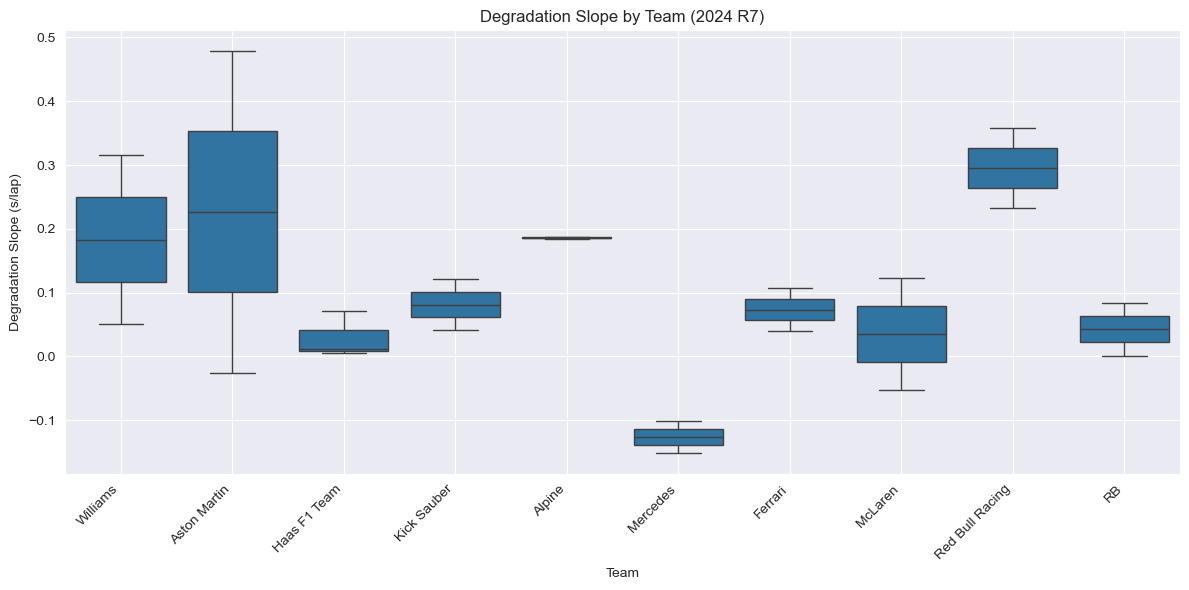


Degradation Slope vs. Base Pace Scatter Plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R7\degradation_slope_vs_basepace.png


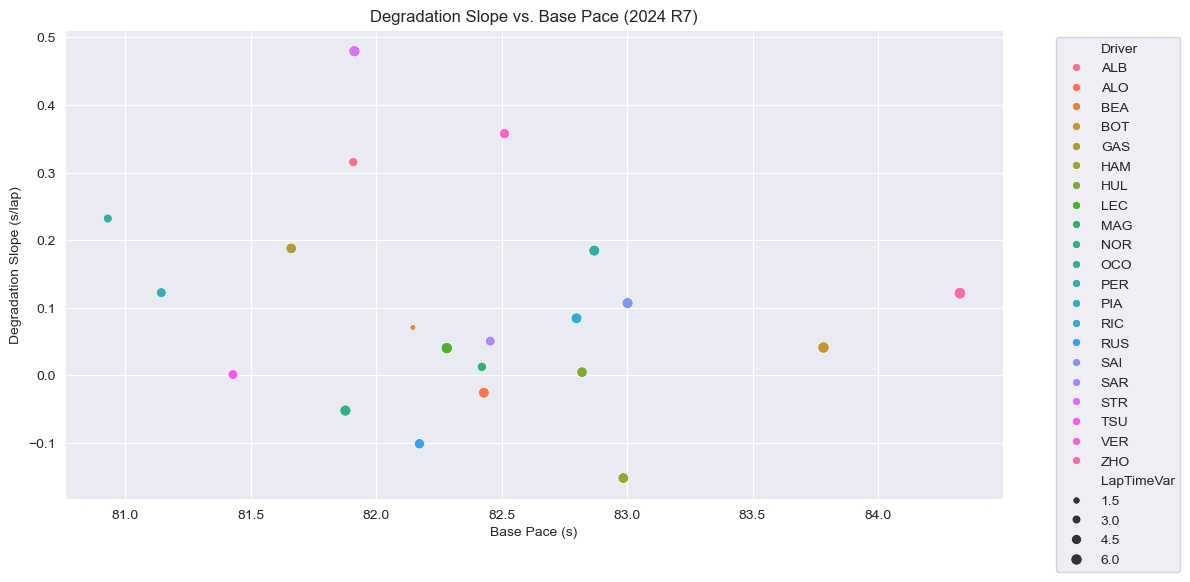


=== Conclusion ===
- Fastest: PIA (75.53s).
2025-03-22 11:14:17,652 - INFO - Step 6: Analyzing telemetry
2025-03-22 11:14:19,231 - INFO - Saved telemetry metrics to C:\data\Dropbox\dev\F1\raw_data\2024\R7\2024_R7_telemetry_metrics.csv

Telemetry Metrics (Top 10 by Max Speed) for Emilia Romagna Grand Prix:
Driver   MaxSpeed  ThrottleTime  BrakingIntensity         Team
   ALB 313.653846     44.684761          0.192104     Williams
   STR 312.958333     46.548845          0.164191 Aston Martin
   MAG 312.633333     53.040711          0.189308 Haas F1 Team
   PIA 310.250000     49.940414          0.168908      McLaren
   SAR 309.710526     48.127817          0.187811     Williams
   ALO 309.153846     49.715163          0.179896 Aston Martin
   BEA 309.080000     48.220884          0.200565 Haas F1 Team
   NOR 309.027778     46.740945          0.157529      McLaren
   SAI 308.851064     51.391599          0.186470      Ferrari
   HUL 308.105263     50.396708          0.179425 Haas F1 Team

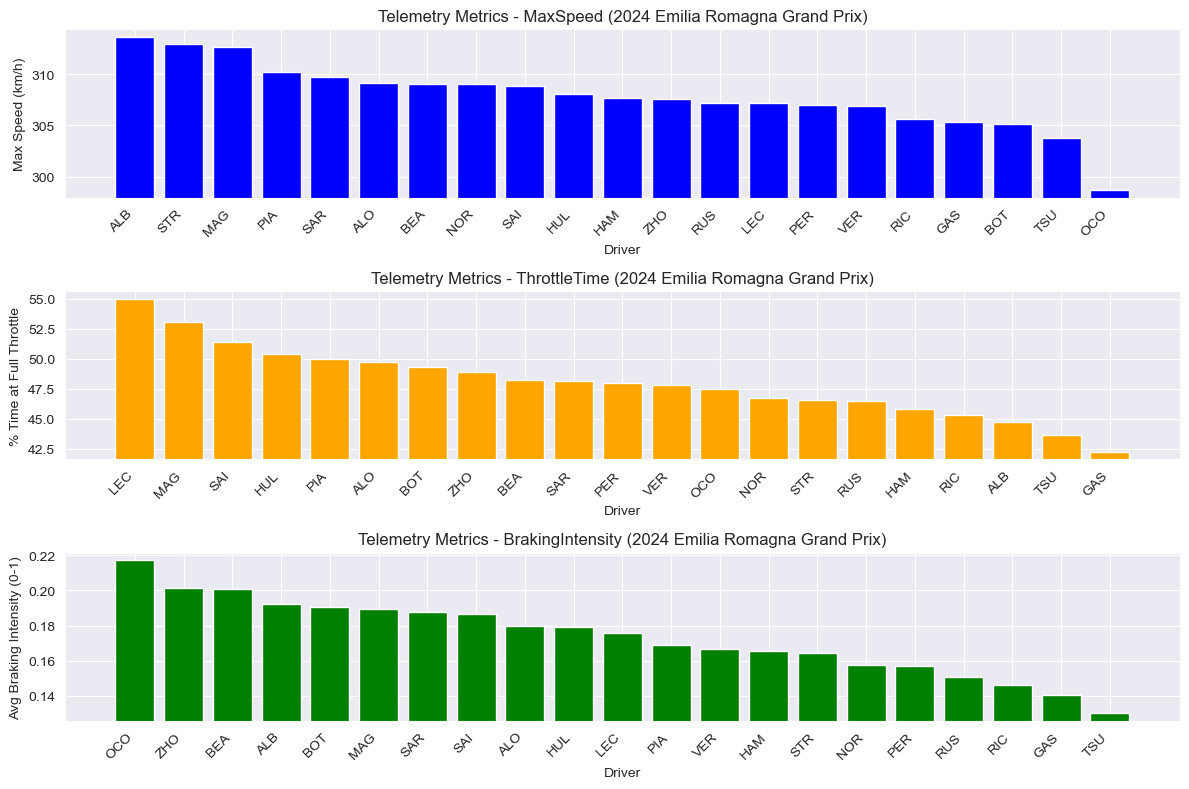


=== Conclusion ===
- Fastest Speed: ALB (313.65 km/h).
- Most Throttle: LEC (54.99%).
2025-03-22 11:14:21,406 - INFO - Step 7: Performing sandbagging analysis
2025-03-22 11:14:21,431 - INFO - Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R7\2024_R7_sandbag_analysis.csv

Potential Sandbaggers (Sorted by PredictionDiscrepancy):
Driver  FastestLapTime         Team  Sector1Time  Sector2Time  Sector3Time   MaxSpeed  ThrottleTime  ExpectedLapTime  LapTimeDiscrepancy  PredictedLapTime  PredictionDiscrepancy  SpeedRank  LapTimeRank  SandbagFlag
   BEA          78.667 Haas F1 Team       24.832       27.180       26.471 309.080000     48.220884           78.483               0.184         76.585161               2.081839        7.0         21.0         True
   MAG          76.923 Haas F1 Team       24.297       26.574       25.746 312.633333     53.040711           76.617               0.306         76.609769               0.313231        3.0         18.0         True
   ALO   

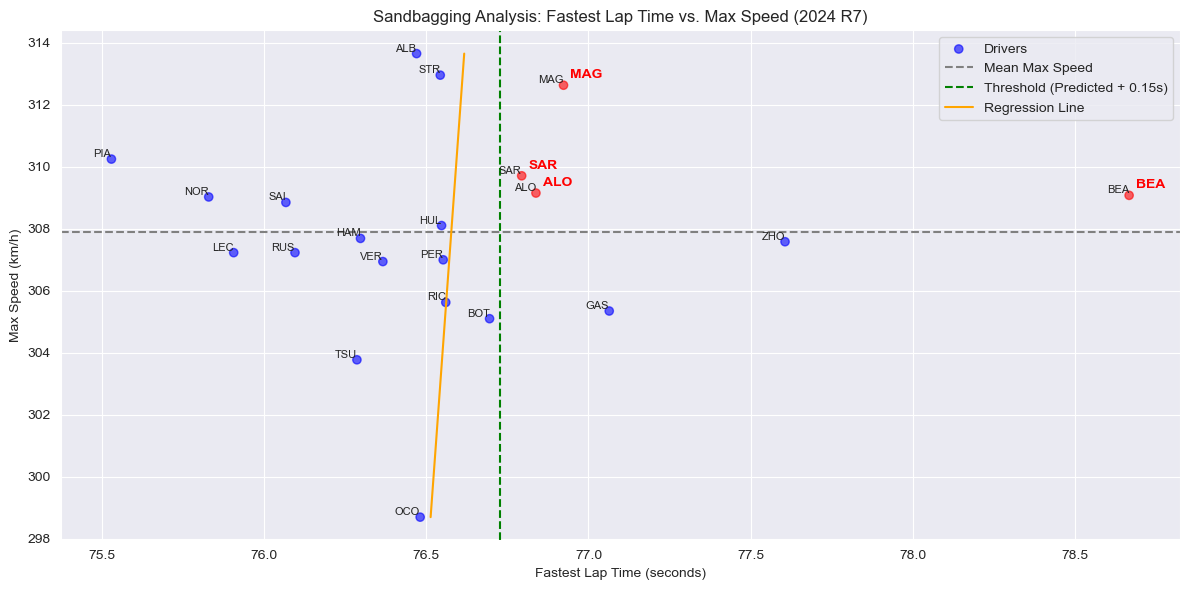

2025-03-22 11:14:22,350 - INFO - Step 8: Analyzing track evolution and weather
2025-03-22 11:14:22,354 - INFO - Average lap time for Practice 1: 98.238 seconds (±21.423)
2025-03-22 11:14:22,357 - INFO - Average lap time for Practice 2: 95.048 seconds (±20.795)
2025-03-22 11:14:22,360 - INFO - Average lap time for Practice 3: 101.030 seconds (±23.038)
2025-03-22 11:14:22,366 - INFO - Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R7\2024_R7_track_evolution.csv

Average Lap Times Across Sessions:
   Session  AvgLapTime  StdLapTime  LapCount
Practice 1   98.237844   21.423050       379
Practice 2   95.048133   20.795413       503
Practice 3  101.030353   23.037828       215

Average Weather Conditions Across Sessions:
   Session   AirTemp  Humidity  Rainfall  TrackTemp
Practice 1 23.972152 32.531646       0.0  43.454430
Practice 2 24.379487 33.948718       0.0  36.842308
Practice 3 23.603846 41.320513       0.0  44.480769

Correlation between AvgLapTime and TrackTemp: 0.935

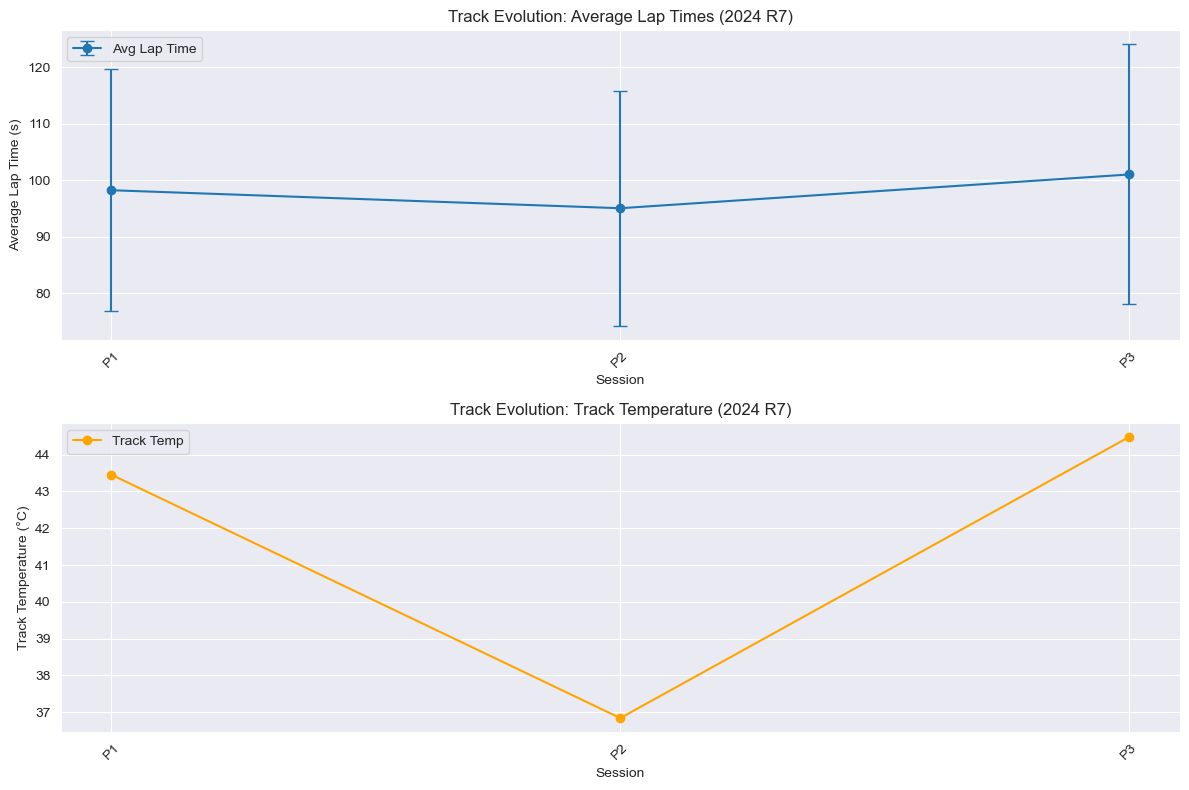

2025-03-22 11:14:23,259 - INFO - Step 9: Analyzing track characteristics
2025-03-22 11:14:23,281 - INFO - Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R7\2024_R7_track_characteristics.csv
2025-03-22 11:14:23,289 - INFO - Saved track char drivers to C:\data\Dropbox\dev\F1\raw_data\2024\R7\2024_R7_track_char_drivers.csv
Track Characteristics:
                    Track DownforceRequirement OvertakingDifficulty  DRSZones TyreDegradation  LapLength SuitsFastCars
Emilia Romagna Grand Prix               Medium               Medium         2          Medium      4.318            No

Top 5 Drivers by Track Fit:
Driver         Team  StraightSpeedPotential  CorneringPotential   AvgSpeed  OverallFit  FitRank
   ALB     Williams              313.653846           25.490000 203.279718    0.996308      1.0
   STR Aston Martin              312.958333           25.514333 203.085847    0.994474      2.0
   MAG Haas F1 Team              312.633333           25.539000 202.082602    0

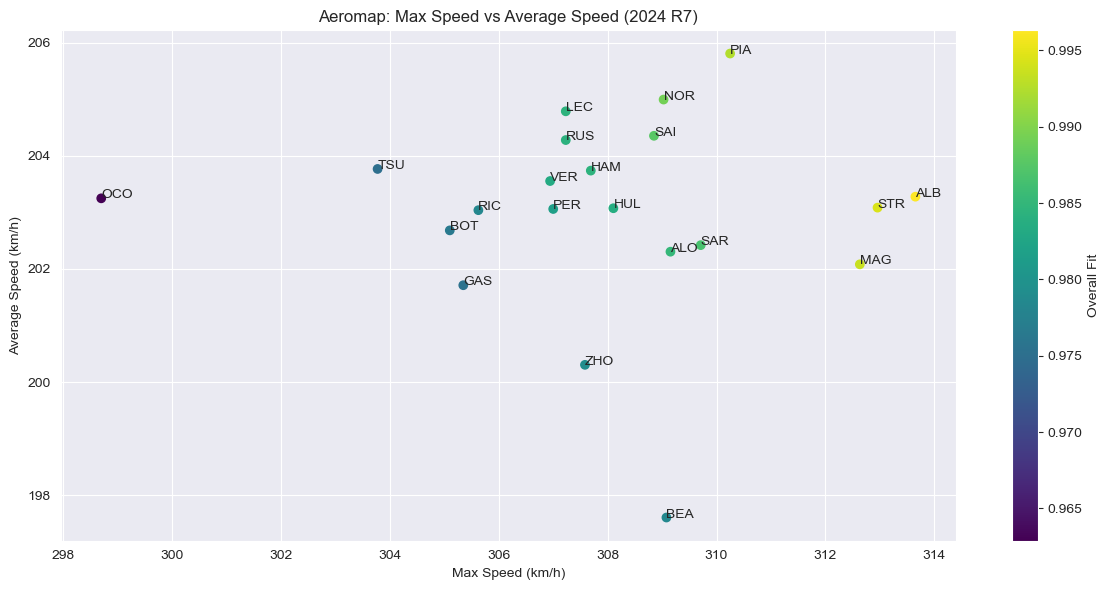

2025-03-22 11:14:26,510 - INFO - Step 10: Predicting race outcomes
2025-03-22 11:14:26,520 - INFO - Loaded pit_stop_loss from file: -132.79s for Emilia Romagna Grand Prix
2025-03-22 11:14:26,572 - INFO - No Sprint session data available; setting SprintPaceAdjustment to 0 for all drivers.
2025-03-22 11:14:26,608 - INFO - Predicted Fastest Lap Driver: PIA
2025-03-22 11:14:26,623 - INFO - Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R7\2024_R7_quali_prediction.csv
2025-03-22 11:14:26,625 - INFO - Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R7\2024_R7_race_prediction.csv

Qualifying Prediction:
Driver            Team  LapTime  ExpectedLapTime  AdjustedLapTime  QualiPosition
   NOR         McLaren   75.829           75.652           75.475              1
   PIA         McLaren   75.529           75.529           75.529              2
   VER Red Bull Racing   76.366           75.985           75.604              3
   RUS        Mercedes   76.095      

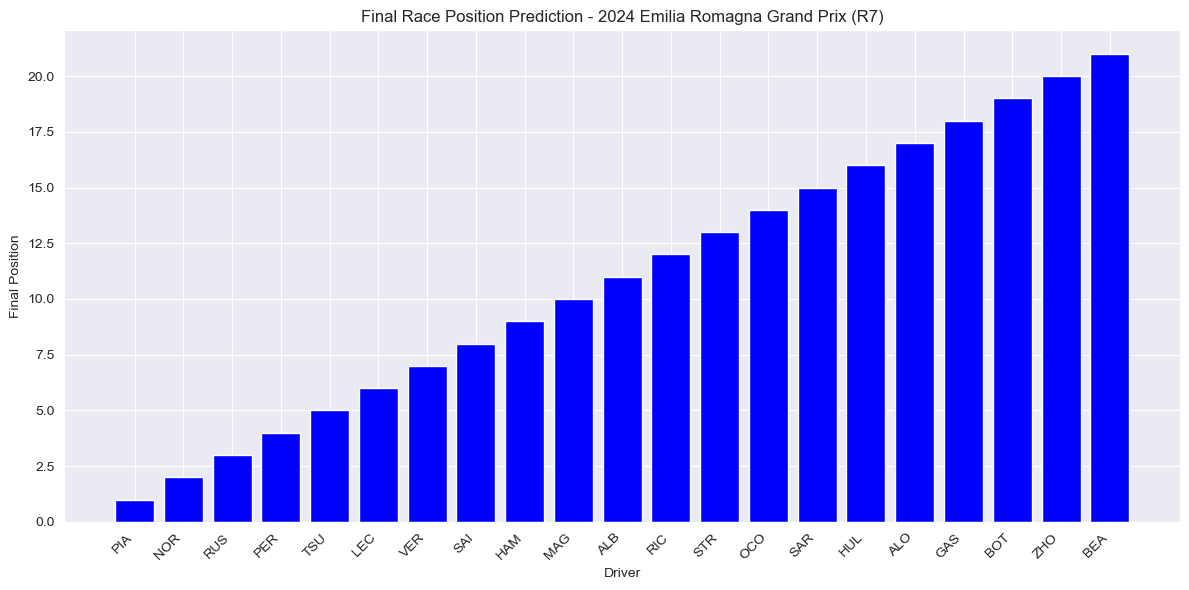

2025-03-22 11:14:27,933 - INFO - Step 11: Generating summary report
Debug: Verifying input DataFrames...
quali_prediction_df shape: (21, 9)
race_prediction_df shape: (21, 25)
driver_performance shape: (21, 12)
Pit stop loss for Emilia Romagna Grand Prix: -132.79s
Debug: Sample pit stop durations:
Driver  LapNumber              PitInTime             PitOutTime  PitDuration
   ALB        9.0 0 days 01:09:28.708000 0 days 01:07:15.914000     -132.794
Calculated pit_stop_loss for Emilia Romagna Grand Prix: -132.79s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\raw_data\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['VER', 'PIA', 'NOR', 'LEC', 'SAI']
Dynamically fetched actual race top 10: ['VER', 'NOR', 'LEC', 'PIA', 'SAI', 'HAM', 'RUS', 'PER', 'STR', 'TSU']
Dynamically fetched actual fastest lap driver: RUS

=== Comprehensive Summary Report ===

Event: 2024 Round 7 - Emilia Romagna Grand Prix

--- Qualifying Analysis ---
Actual Qualifying Top 5: ['VER', 'PIA', 'N

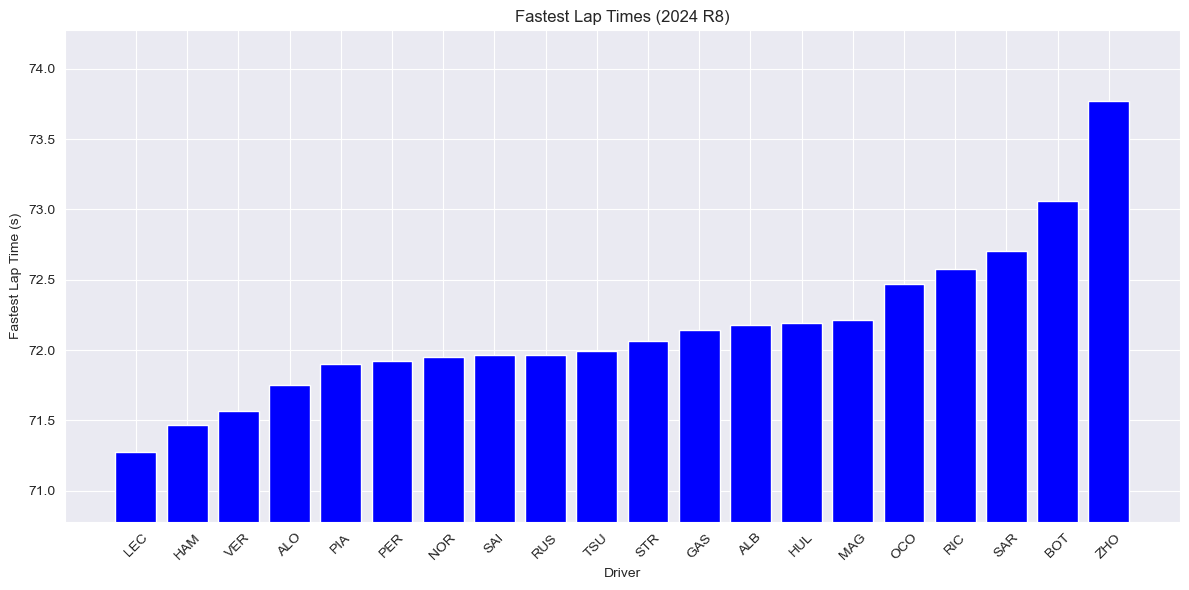


Plot 1 saved to C:\data\Dropbox\dev\F1\raw_data\2024\R8\fastest_vs_theoretical.png


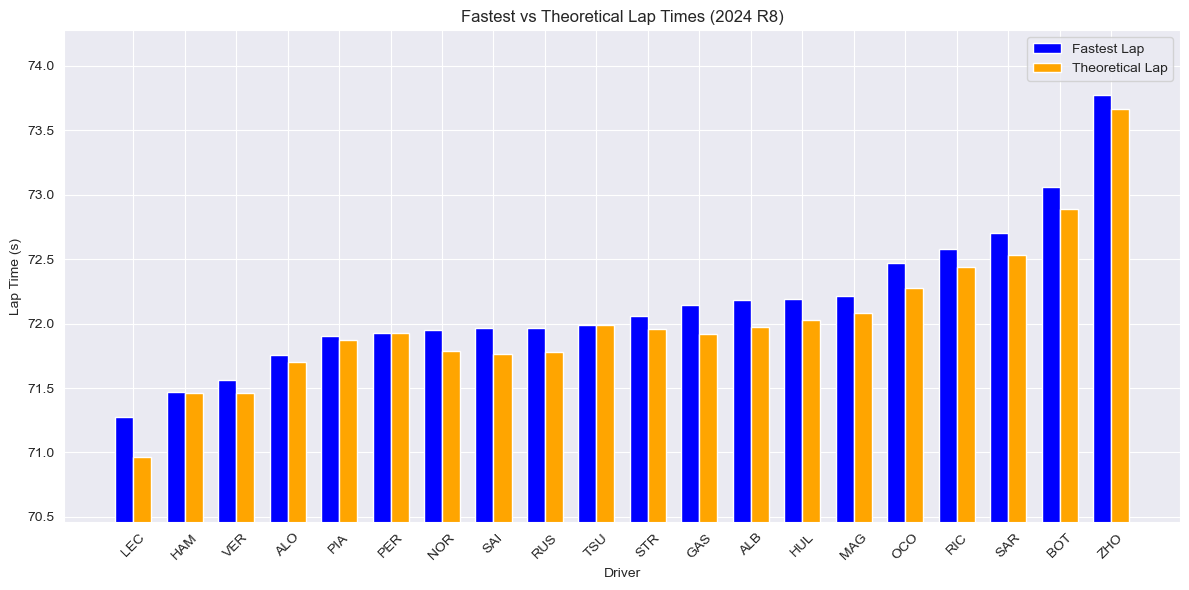


Degradation Slope Histogram saved to C:\data\Dropbox\dev\F1\raw_data\2024\R8\degradation_slope_histogram.png


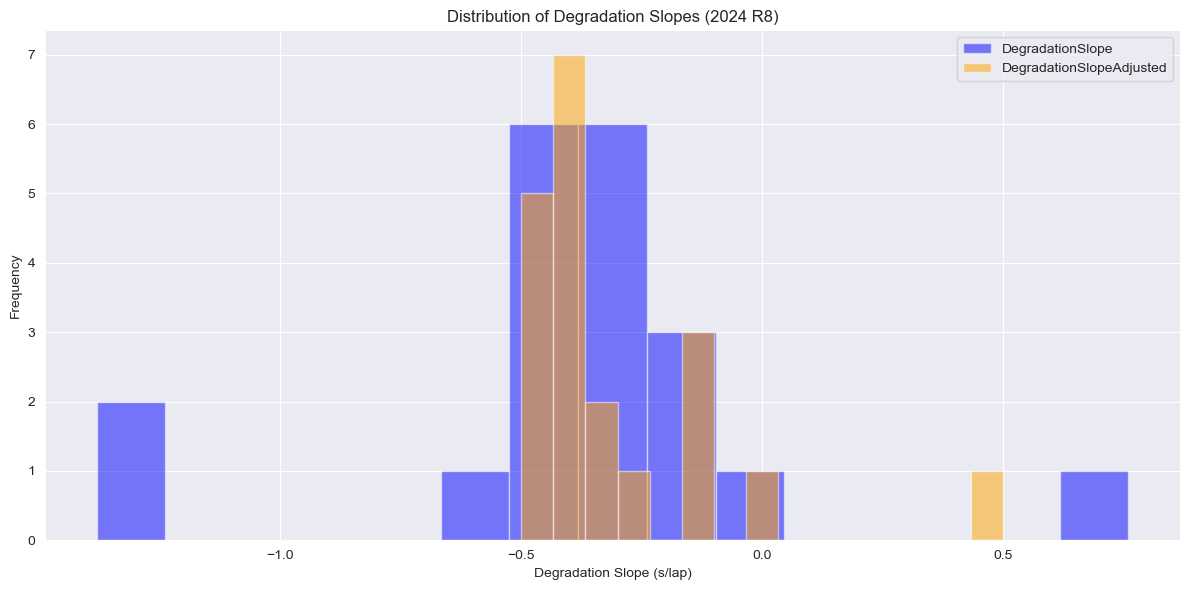


Degradation Slope by Team Boxplot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R8\degradation_slope_by_team.png


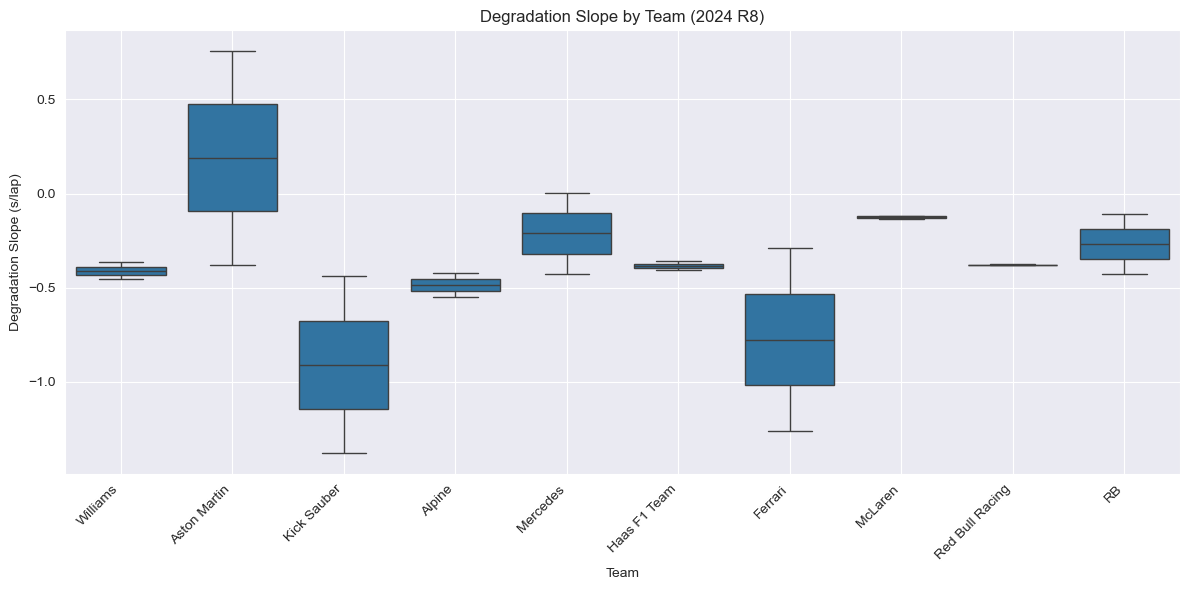


Degradation Slope vs. Base Pace Scatter Plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R8\degradation_slope_vs_basepace.png


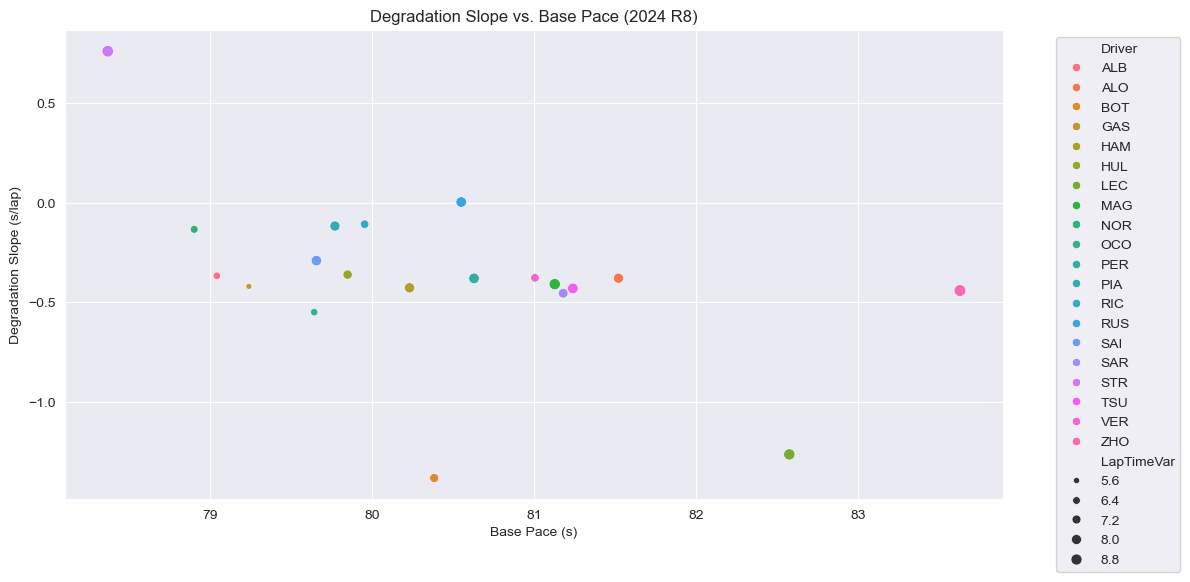


=== Conclusion ===
- Fastest: LEC (71.28s).
2025-03-22 11:14:59,866 - INFO - Step 6: Analyzing telemetry
2025-03-22 11:15:02,068 - INFO - Saved telemetry metrics to C:\data\Dropbox\dev\F1\raw_data\2024\R8\2024_R8_telemetry_metrics.csv

Telemetry Metrics (Top 10 by Max Speed) for Monaco Grand Prix:
Driver   MaxSpeed  ThrottleTime  BrakingIntensity            Team
   SAR 280.590909     27.665977          0.270943        Williams
   STR 280.438596     27.491828          0.241337    Aston Martin
   MAG 280.346667     28.562667          0.255031    Haas F1 Team
   HUL 280.071429     24.855797          0.241444    Haas F1 Team
   PIA 279.765625     27.957152          0.237842         McLaren
   PER 279.732143     28.580374          0.263484 Red Bull Racing
   LEC 279.380282     29.537200          0.276944         Ferrari
   HAM 279.318182     25.751341          0.262085        Mercedes
   RUS 279.095890     24.927162          0.246708        Mercedes
   ALB 279.054054     25.706319         

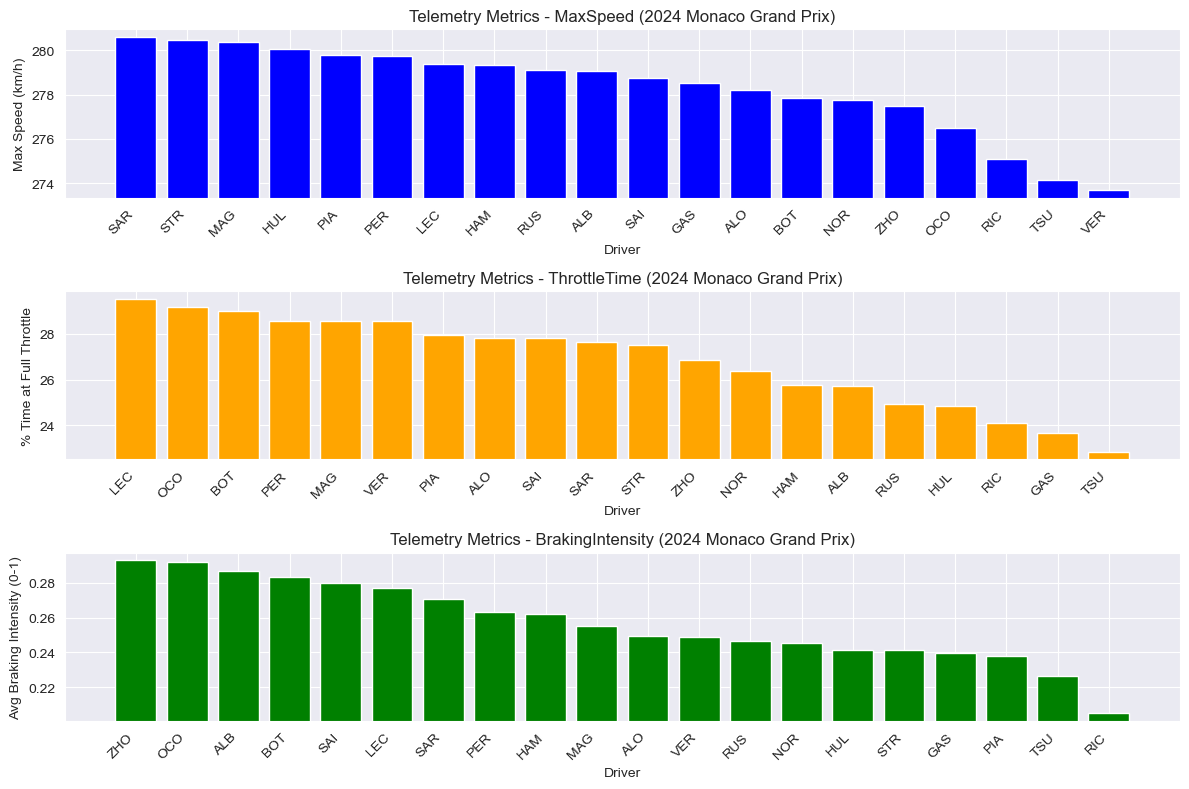


=== Conclusion ===
- Fastest Speed: SAR (280.59 km/h).
- Most Throttle: LEC (29.54%).
2025-03-22 11:15:03,741 - INFO - Step 7: Performing sandbagging analysis
2025-03-22 11:15:03,770 - INFO - Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R8\2024_R8_sandbag_analysis.csv

Potential Sandbaggers (Sorted by PredictionDiscrepancy):
Driver  FastestLapTime     Team  Sector1Time  Sector2Time  Sector3Time   MaxSpeed  ThrottleTime  ExpectedLapTime  LapTimeDiscrepancy  PredictedLapTime  PredictionDiscrepancy  SpeedRank  LapTimeRank  SandbagFlag
   SAR          72.703 Williams       19.027       34.181        19.32 280.590909     27.665977           72.528               0.175         72.113523               0.589477        1.0         18.0         True
Sandbagging Analysis plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R8\sandbagging_analysis.png


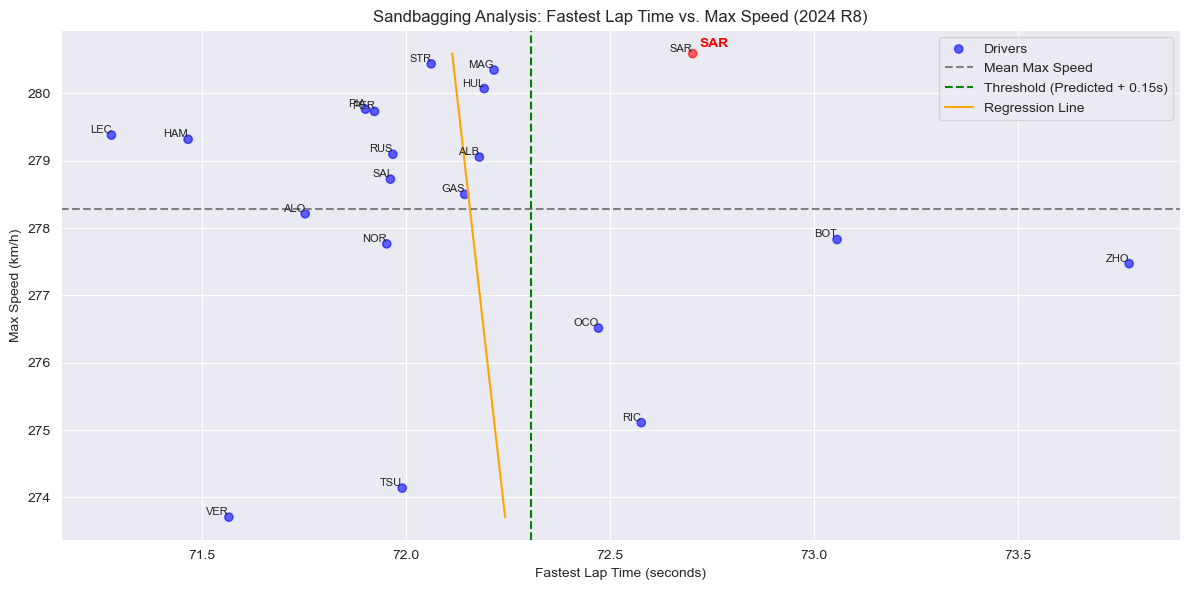

2025-03-22 11:15:04,555 - INFO - Step 8: Analyzing track evolution and weather
2025-03-22 11:15:04,559 - INFO - Average lap time for Practice 1: 87.658 seconds (±15.373)
2025-03-22 11:15:04,562 - INFO - Average lap time for Practice 2: 86.631 seconds (±15.492)
2025-03-22 11:15:04,565 - INFO - Average lap time for Practice 3: 94.626 seconds (±19.451)
2025-03-22 11:15:04,571 - INFO - Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R8\2024_R8_track_evolution.csv

Average Lap Times Across Sessions:
   Session  AvgLapTime  StdLapTime  LapCount
Practice 1   87.658348   15.373038       558
Practice 2   86.631132   15.491797       614
Practice 3   94.626046   19.450728       436

Average Weather Conditions Across Sessions:
   Session   AirTemp  Humidity  Rainfall  TrackTemp
Practice 1 20.716883 66.727273  0.090909  35.561039
Practice 2 20.761728 66.444444  0.000000  31.302469
Practice 3 21.674684 57.405063  0.000000  46.862025

Correlation between AvgLapTime and TrackTemp: 0.989


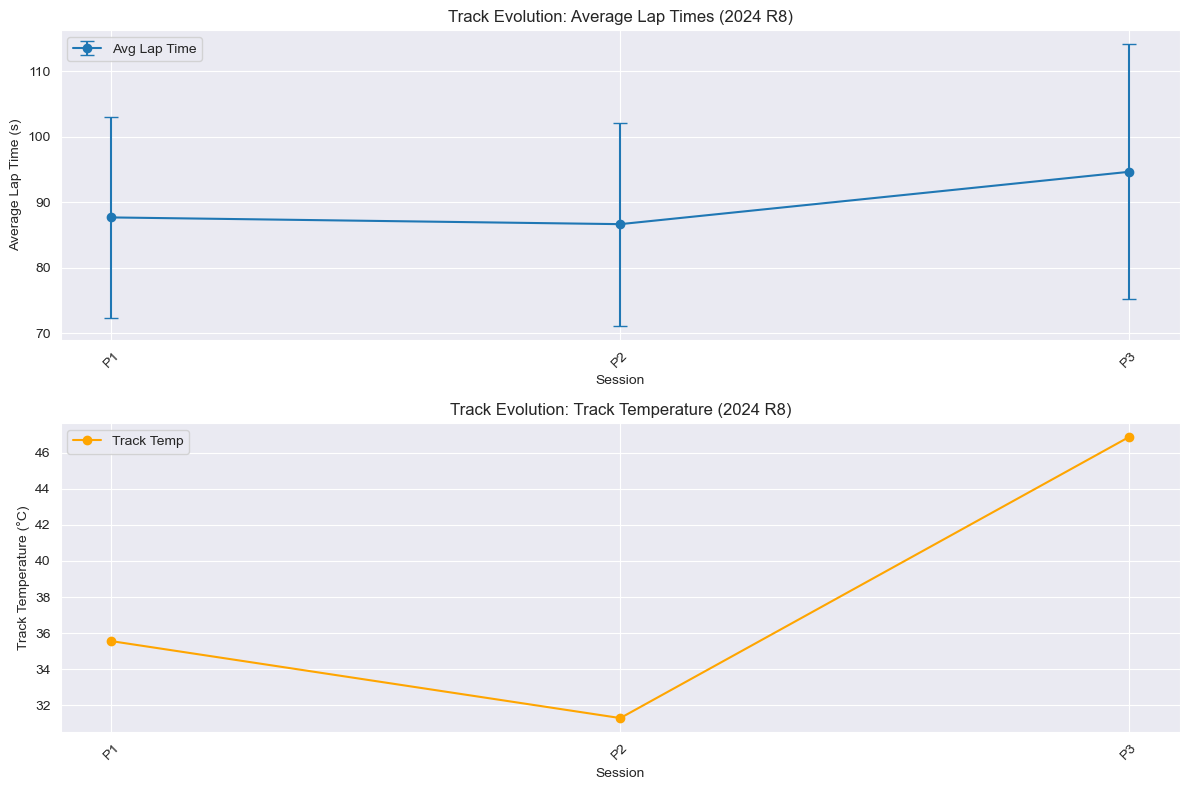

2025-03-22 11:15:05,360 - INFO - Step 9: Analyzing track characteristics
2025-03-22 11:15:05,373 - INFO - Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R8\2024_R8_track_characteristics.csv
2025-03-22 11:15:05,378 - INFO - Saved track char drivers to C:\data\Dropbox\dev\F1\raw_data\2024\R8\2024_R8_track_char_drivers.csv
Track Characteristics:
            Track DownforceRequirement OvertakingDifficulty  DRSZones TyreDegradation  LapLength SuitsFastCars
Monaco Grand Prix                  Low                 Easy         3             Low      7.004           Yes

Top 5 Drivers by Track Fit:
Driver         Team  StraightSpeedPotential  CorneringPotential   AvgSpeed  OverallFit  FitRank
   LEC      Ferrari              279.380282           23.654000 353.747299    0.996980      1.0
   STR Aston Martin              280.438596           23.985333 349.898698    0.995476      2.0
   MAG Haas F1 Team              280.346667           24.028000 349.152542    0.994721      3.0

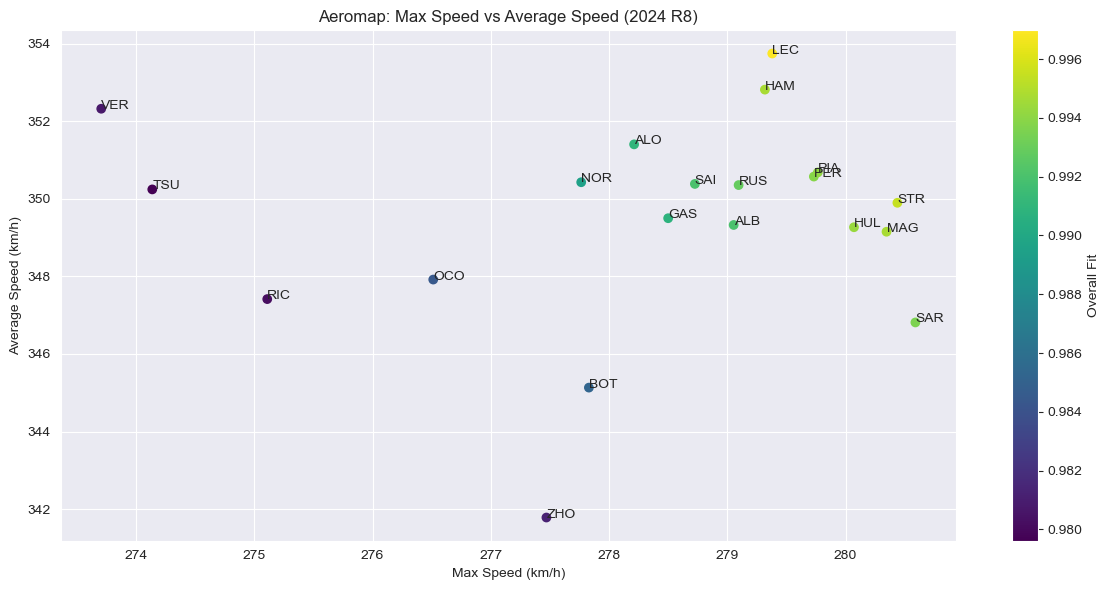

2025-03-22 11:15:06,883 - INFO - Step 10: Predicting race outcomes
2025-03-22 11:15:06,891 - INFO - Loaded pit_stop_loss from file: 20.00s for Monaco Grand Prix
2025-03-22 11:15:06,917 - INFO - No Sprint session data available; setting SprintPaceAdjustment to 0 for all drivers.
2025-03-22 11:15:06,936 - INFO - Predicted Fastest Lap Driver: LEC
2025-03-22 11:15:06,946 - INFO - Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R8\2024_R8_quali_prediction.csv
2025-03-22 11:15:06,947 - INFO - Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R8\2024_R8_race_prediction.csv

Qualifying Prediction:
Driver            Team  LapTime  ExpectedLapTime  AdjustedLapTime  QualiPosition
   LEC         Ferrari   71.278           70.962           70.646              1
   VER Red Bull Racing   71.566           71.459           71.352              2
   HAM        Mercedes   71.466           71.465           71.464              3
   SAI         Ferrari   71.962           71.76

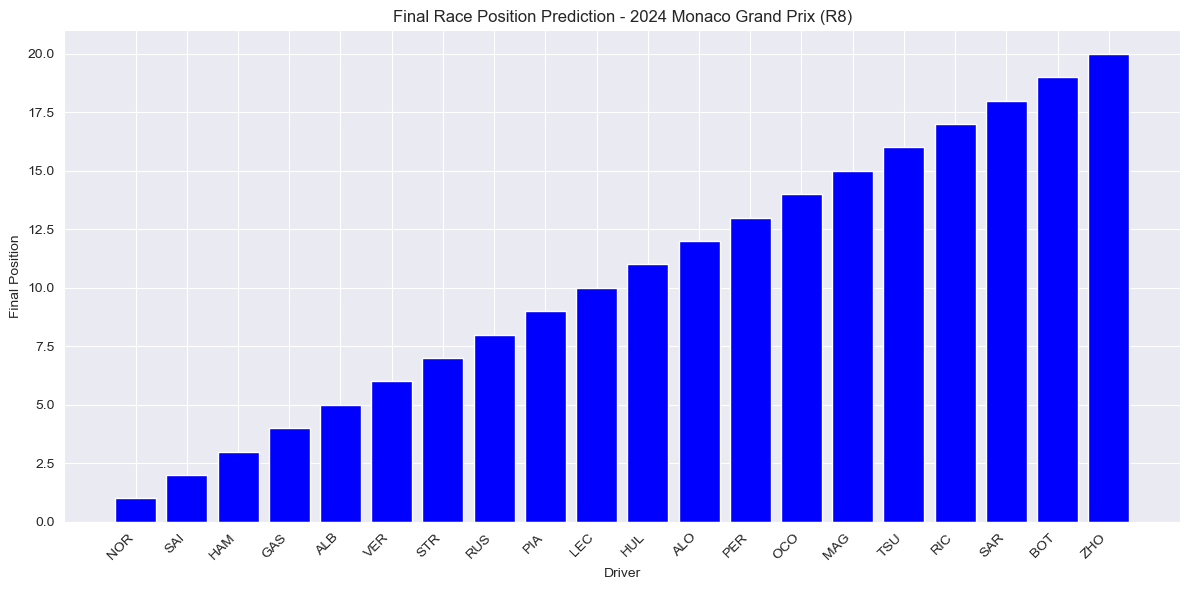

2025-03-22 11:15:07,867 - INFO - Step 11: Generating summary report
Debug: Verifying input DataFrames...
quali_prediction_df shape: (20, 9)
race_prediction_df shape: (20, 25)
driver_performance shape: (20, 12)
Pit stop loss for Monaco Grand Prix: 20.00s
Calculated pit_stop_loss for Monaco Grand Prix: 20.00s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\raw_data\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['LEC', 'PIA', 'SAI', 'NOR', 'RUS']
Dynamically fetched actual race top 10: ['LEC', 'PIA', 'SAI', 'NOR', 'RUS', 'VER', 'HAM', 'TSU', 'ALB', 'GAS']
Dynamically fetched actual fastest lap driver: HAM

=== Comprehensive Summary Report ===

Event: 2024 Round 8 - Monaco Grand Prix

--- Qualifying Analysis ---
Actual Qualifying Top 5: ['LEC', 'PIA', 'SAI', 'NOR', 'RUS']
Predicted Qualifying Top 5:
Driver  AdjustedLapTime  QualiPosition
   LEC           70.646              1
   VER           71.352              2
   HAM           71.464              3
   SAI       

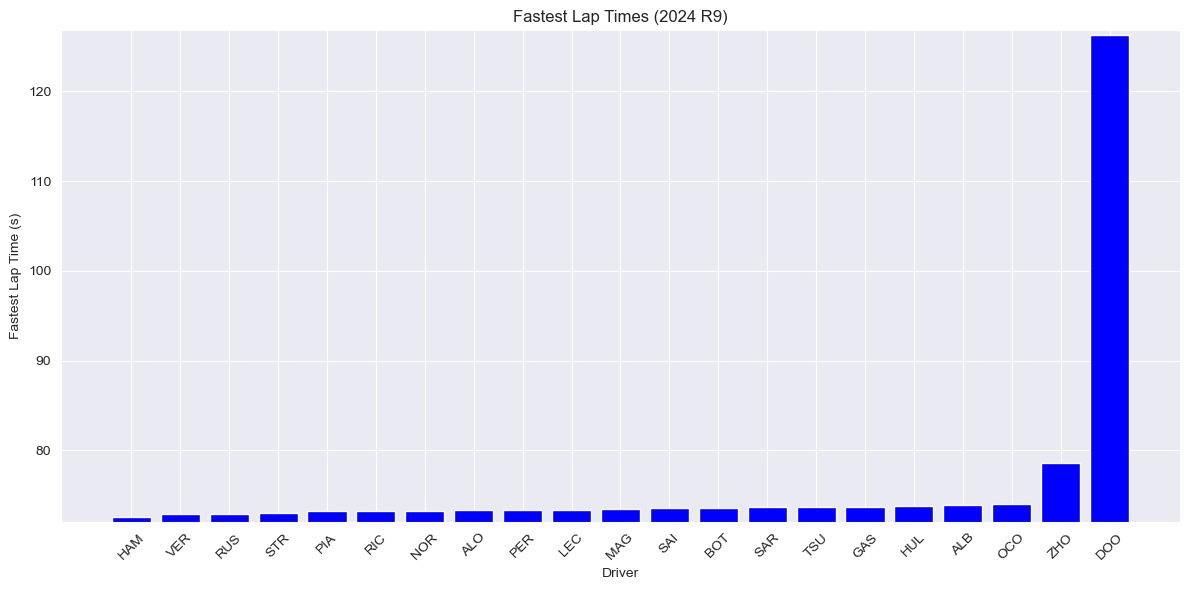


Plot 1 saved to C:\data\Dropbox\dev\F1\raw_data\2024\R9\fastest_vs_theoretical.png


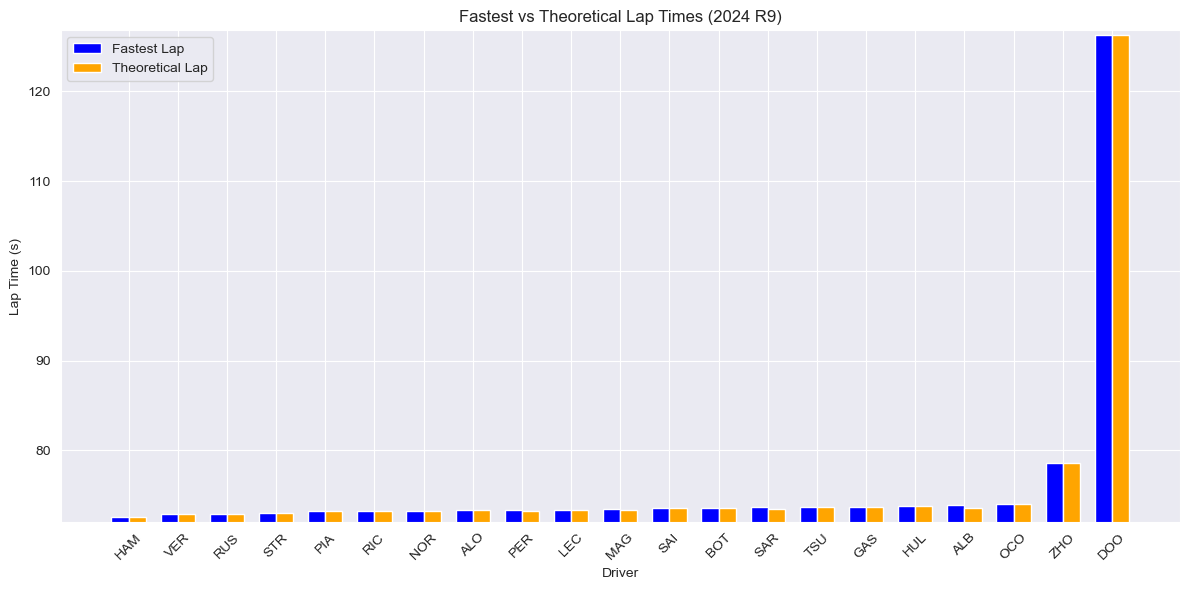


Degradation Slope Histogram saved to C:\data\Dropbox\dev\F1\raw_data\2024\R9\degradation_slope_histogram.png


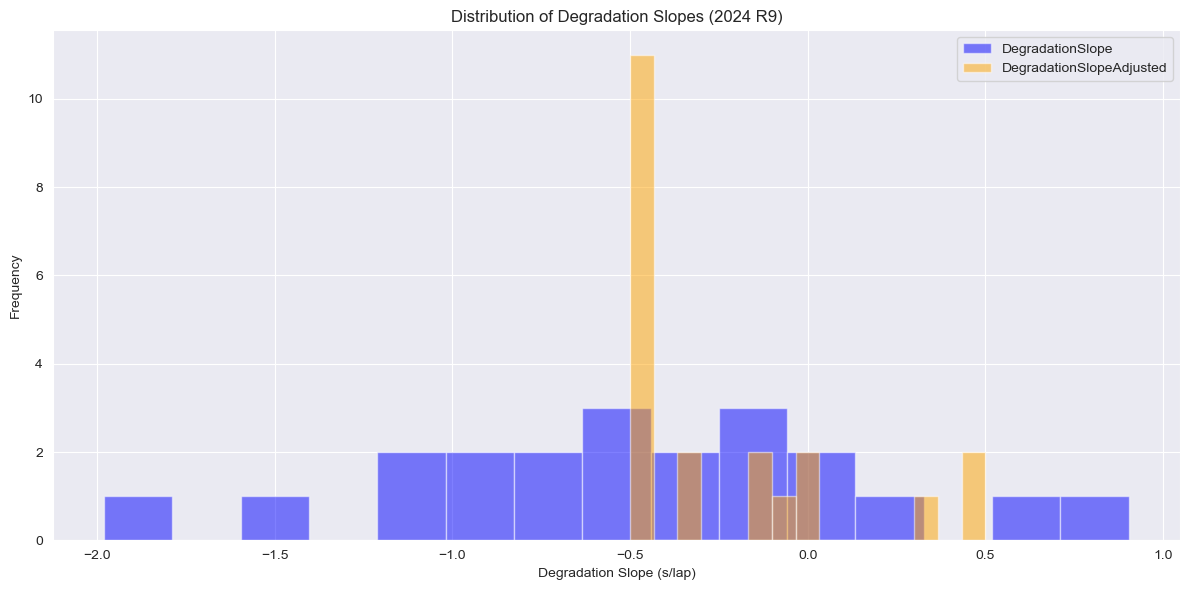


Degradation Slope by Team Boxplot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R9\degradation_slope_by_team.png


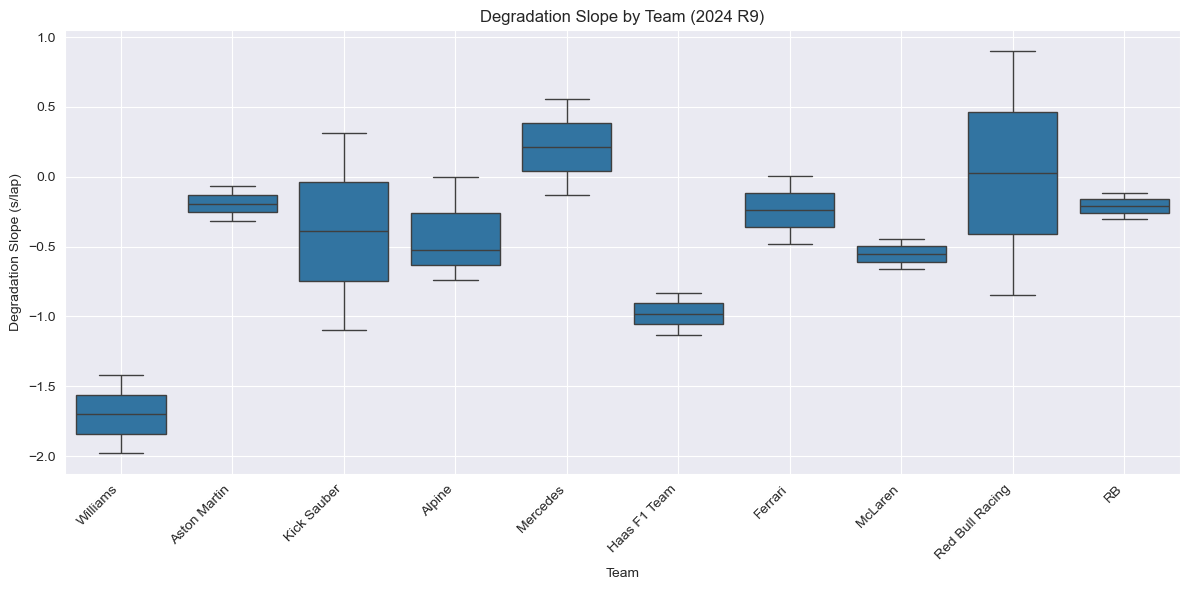


Degradation Slope vs. Base Pace Scatter Plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R9\degradation_slope_vs_basepace.png


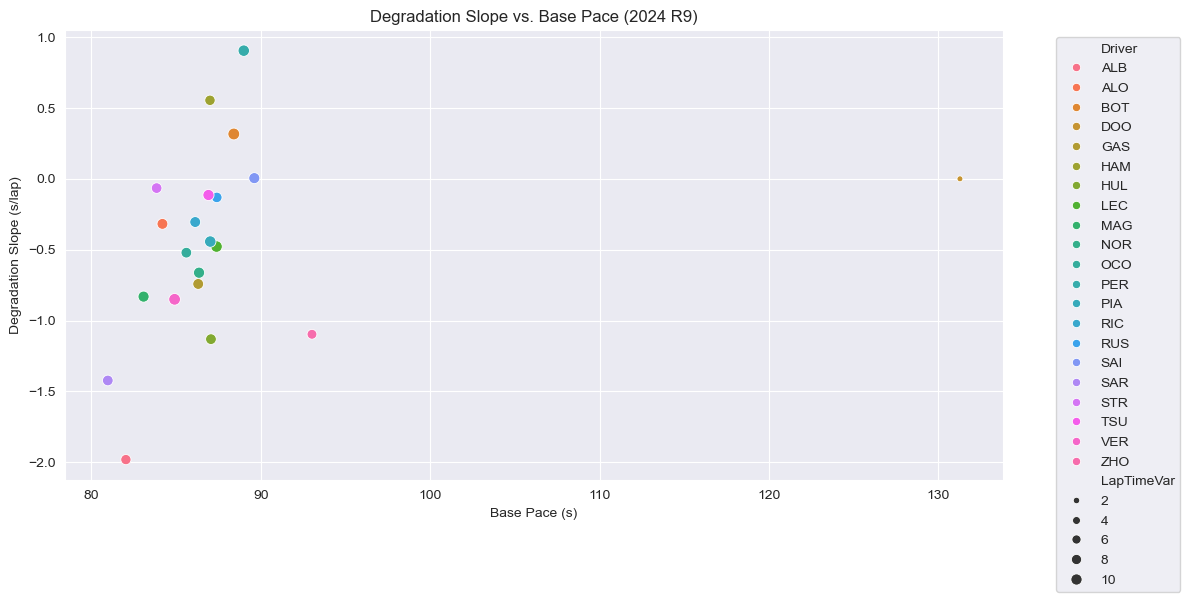


=== Conclusion ===
- Fastest: HAM (72.55s).
2025-03-22 11:15:38,390 - INFO - Step 6: Analyzing telemetry
2025-03-22 11:15:39,554 - INFO - Saved telemetry metrics to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_telemetry_metrics.csv

Telemetry Metrics (Top 10 by Max Speed) for Canadian Grand Prix:
Driver   MaxSpeed  ThrottleTime  BrakingIntensity            Team
   SAR 313.405405     40.502216          0.226374        Williams
   ALB 309.700000     38.767118          0.242961        Williams
   RIC 309.377778     36.360254          0.197088              RB
   RUS 308.214286     39.046157          0.213531        Mercedes
   PIA 307.794872     37.583599          0.215102         McLaren
   STR 307.692308     43.572718          0.208495    Aston Martin
   MAG 307.657143     46.042159          0.221465    Haas F1 Team
   PER 307.097561     41.836002          0.222417 Red Bull Racing
   ALO 307.000000     43.953896          0.213876    Aston Martin
   TSU 306.853659     37.305805       

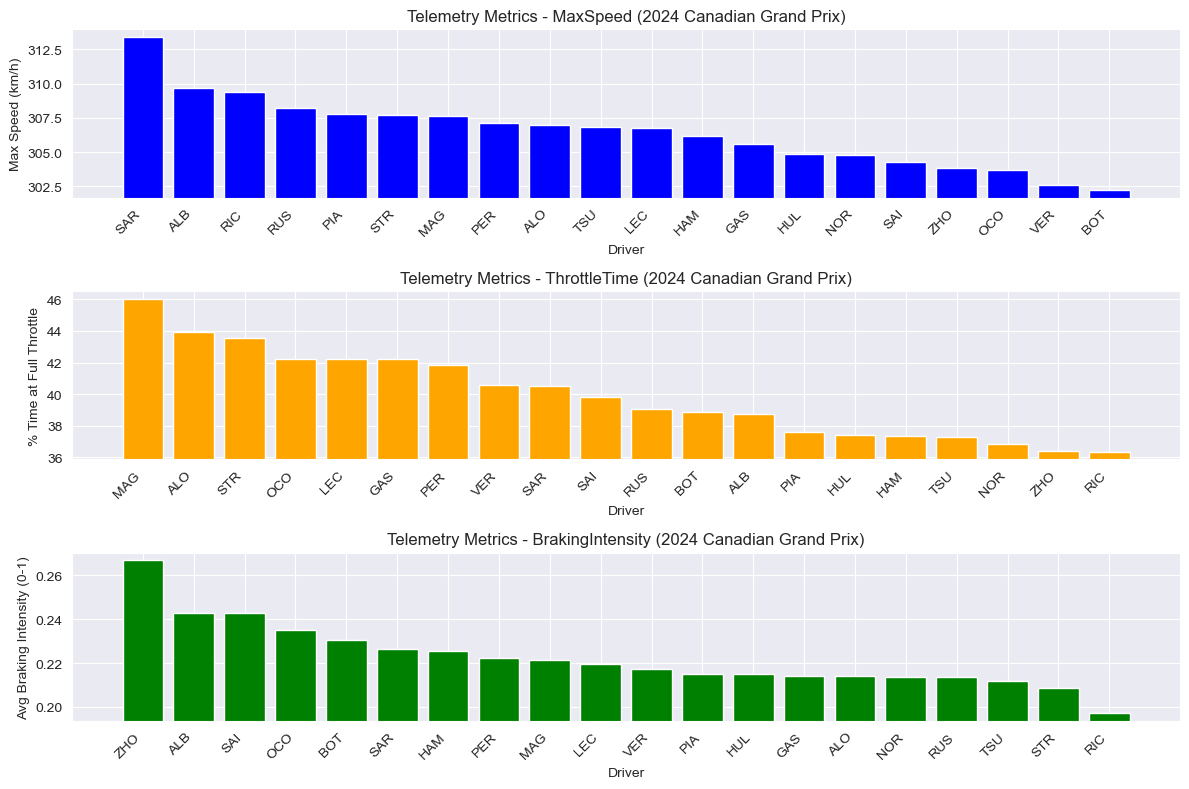


=== Conclusion ===
- Fastest Speed: SAR (313.41 km/h).
- Most Throttle: MAG (46.04%).
2025-03-22 11:15:44,693 - INFO - Step 7: Performing sandbagging analysis
2025-03-22 11:15:44,735 - WARNING - NaN values found in telemetry metrics. Filling with median values.
2025-03-22 11:15:44,779 - INFO - Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_sandbag_analysis.csv

Potential Sandbaggers (Sorted by PredictionDiscrepancy):
Driver  FastestLapTime   Team  Sector1Time  Sector2Time  Sector3Time   MaxSpeed  ThrottleTime  ExpectedLapTime  LapTimeDiscrepancy  PredictedLapTime  PredictionDiscrepancy  SpeedRank  LapTimeRank  SandbagFlag
   DOO         126.267 Alpine       44.869       38.408        42.99 306.798624     39.420648          126.267                 0.0         76.182231              50.084769       11.0         21.0         True
Sandbagging Analysis plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R9\sandbagging_analysis.png


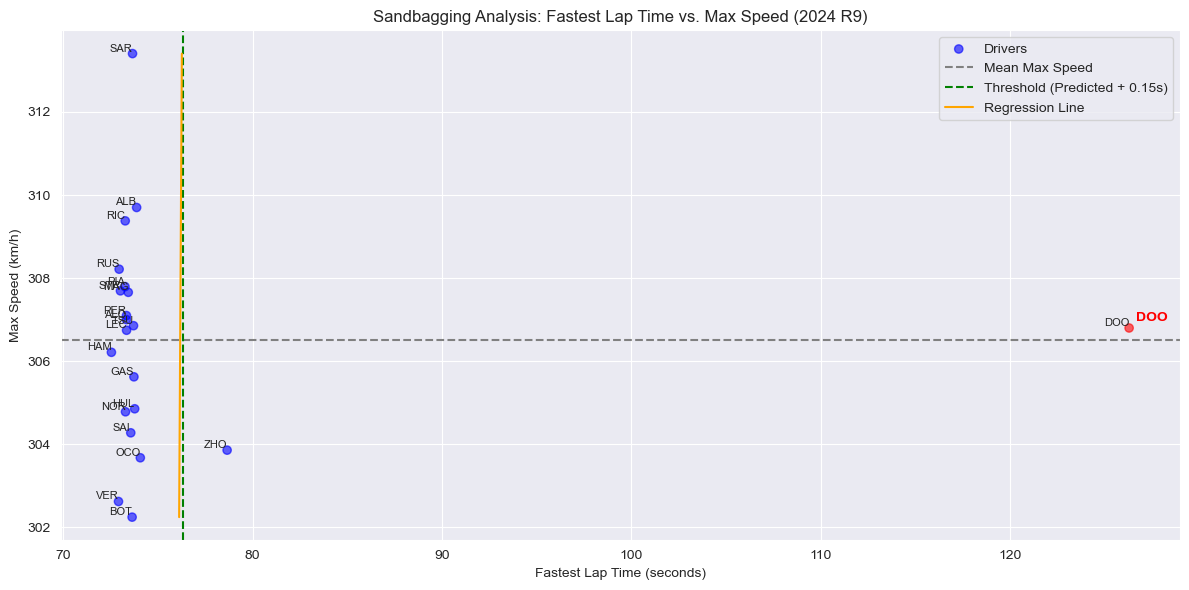

2025-03-22 11:15:46,179 - INFO - Step 8: Analyzing track evolution and weather
2025-03-22 11:15:46,186 - INFO - Average lap time for Practice 1: 99.009 seconds (±10.114)
2025-03-22 11:15:46,189 - INFO - Average lap time for Practice 2: 91.939 seconds (±13.873)
2025-03-22 11:15:46,194 - INFO - Average lap time for Practice 3: 90.435 seconds (±17.151)
2025-03-22 11:15:46,203 - INFO - Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_track_evolution.csv

Average Lap Times Across Sessions:
   Session  AvgLapTime  StdLapTime  LapCount
Practice 1   99.008641   10.114110       103
Practice 2   91.939086   13.872807       372
Practice 3   90.434972   17.150565       497

Average Weather Conditions Across Sessions:
   Session   AirTemp  Humidity  Rainfall  TrackTemp
Practice 1 18.237179 83.576923  0.179487  28.682051
Practice 2 18.996250 68.500000  0.887500  25.546250
Practice 3 20.854321 61.925926  0.000000  36.400000

Correlation between AvgLapTime and TrackTemp: -0.393

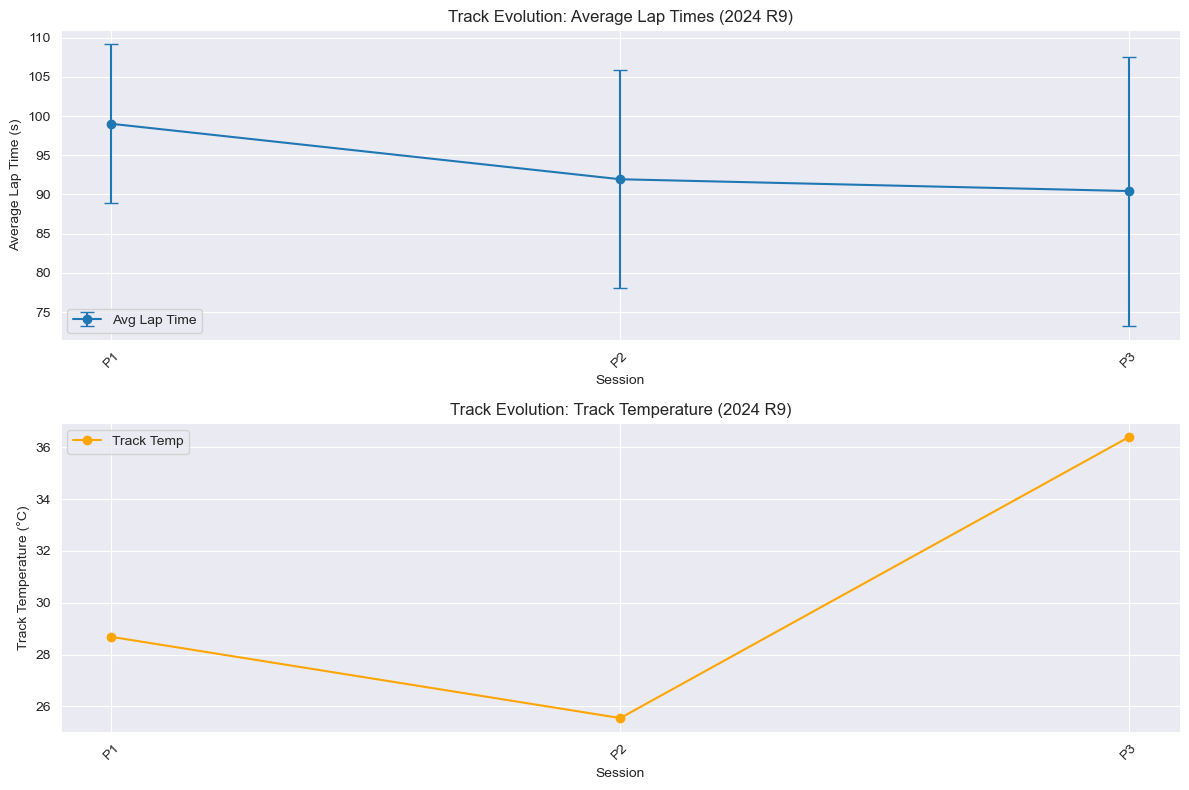

2025-03-22 11:15:47,352 - INFO - Step 9: Analyzing track characteristics
2025-03-22 11:15:47,375 - INFO - Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_track_characteristics.csv
2025-03-22 11:15:47,382 - INFO - Saved track char drivers to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_track_char_drivers.csv
Track Characteristics:
              Track DownforceRequirement OvertakingDifficulty  DRSZones TyreDegradation  LapLength SuitsFastCars
Canadian Grand Prix                  Low                 Easy         3             Low      5.891           Yes

Top 5 Drivers by Track Fit:
Driver         Team  StraightSpeedPotential  CorneringPotential   AvgSpeed  OverallFit  FitRank
   SAR     Williams              313.405405           24.497333 287.900303    0.996151      1.0
   RIC           RB              309.377778           24.414000 289.408971    0.988166      2.0
   ALB     Williams              309.700000           24.530333 287.054683    0.987476     

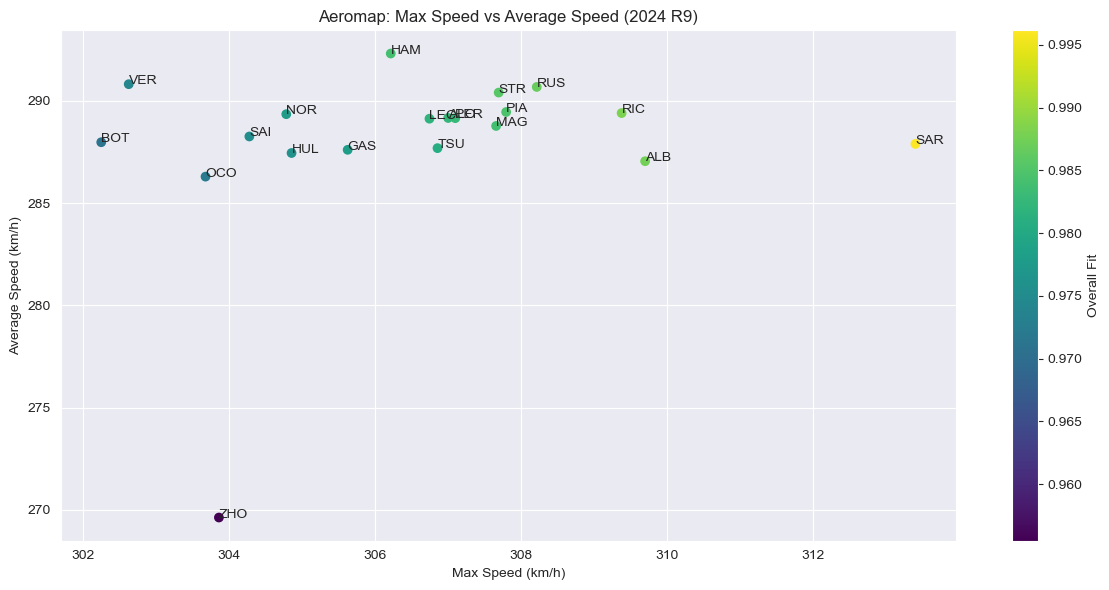

2025-03-22 11:15:49,643 - INFO - Step 10: Predicting race outcomes
2025-03-22 11:15:49,655 - INFO - Loaded pit_stop_loss from file: 20.00s for Canadian Grand Prix
2025-03-22 11:15:49,695 - INFO - No Sprint session data available; setting SprintPaceAdjustment to 0 for all drivers.
2025-03-22 11:15:49,720 - INFO - Predicted Fastest Lap Driver: HAM
2025-03-22 11:15:49,735 - INFO - Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_quali_prediction.csv
2025-03-22 11:15:49,738 - INFO - Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R9\2024_R9_race_prediction.csv

Qualifying Prediction:
Driver            Team  LapTime  ExpectedLapTime  AdjustedLapTime  QualiPosition
   HAM        Mercedes   72.549           72.549           72.549              1
   VER Red Bull Racing   72.923           72.923           72.923              2
   RUS        Mercedes   72.957           72.950           72.943              3
   STR    Aston Martin   73.026           72.

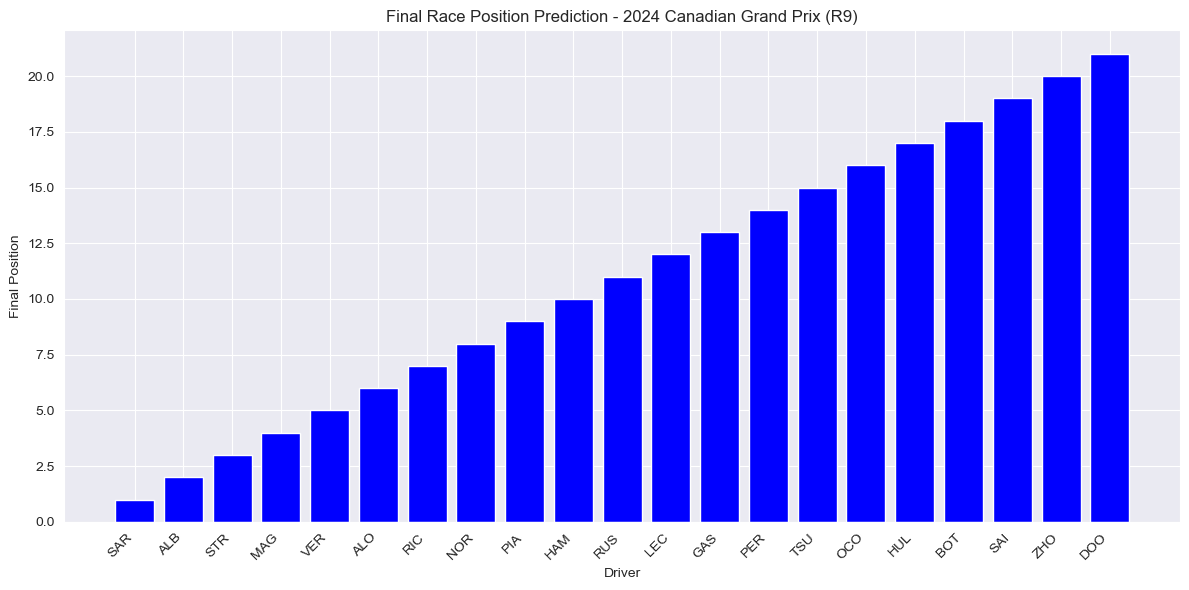

2025-03-22 11:15:53,509 - INFO - Step 11: Generating summary report
Debug: Verifying input DataFrames...
quali_prediction_df shape: (21, 9)
race_prediction_df shape: (21, 25)
driver_performance shape: (21, 12)
Pit stop loss for Canadian Grand Prix: 20.00s
Calculated pit_stop_loss for Canadian Grand Prix: 20.00s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\raw_data\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['RUS', 'VER', 'NOR', 'PIA', 'RIC']
Dynamically fetched actual race top 10: ['VER', 'NOR', 'RUS', 'HAM', 'PIA', 'ALO', 'STR', 'RIC', 'GAS', 'OCO']
Dynamically fetched actual fastest lap driver: HAM

=== Comprehensive Summary Report ===

Event: 2024 Round 9 - Canadian Grand Prix

--- Qualifying Analysis ---
Actual Qualifying Top 5: ['RUS', 'VER', 'NOR', 'PIA', 'RIC']
Predicted Qualifying Top 5:
Driver  AdjustedLapTime  QualiPosition
   HAM           72.549              1
   VER           72.923              2
   RUS           72.943              3
   STR 

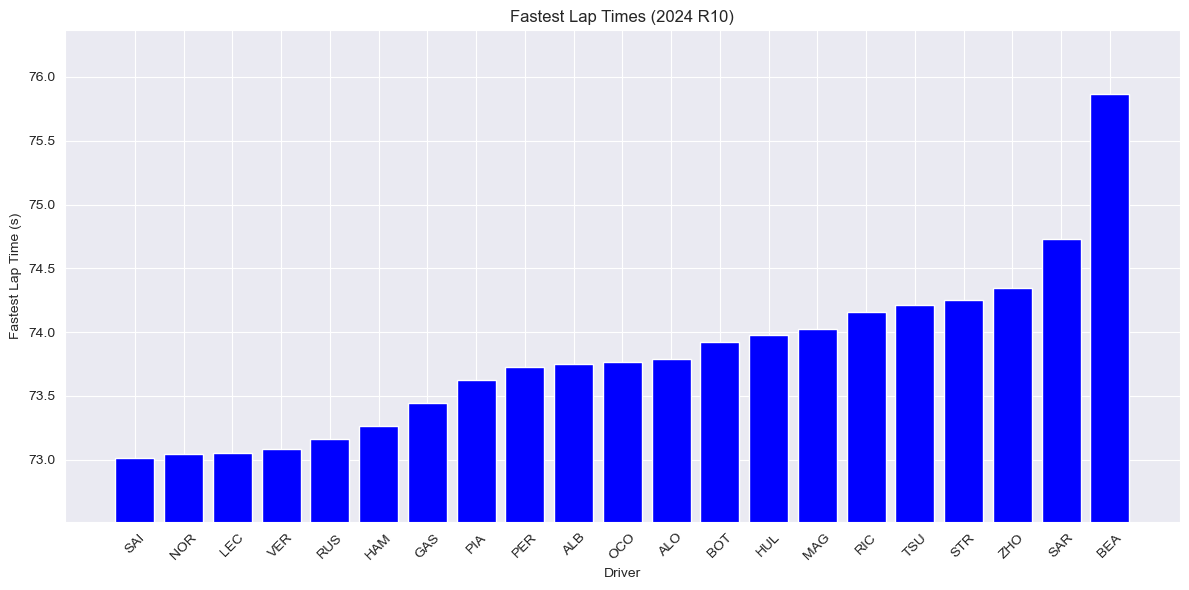


Plot 1 saved to C:\data\Dropbox\dev\F1\raw_data\2024\R10\fastest_vs_theoretical.png


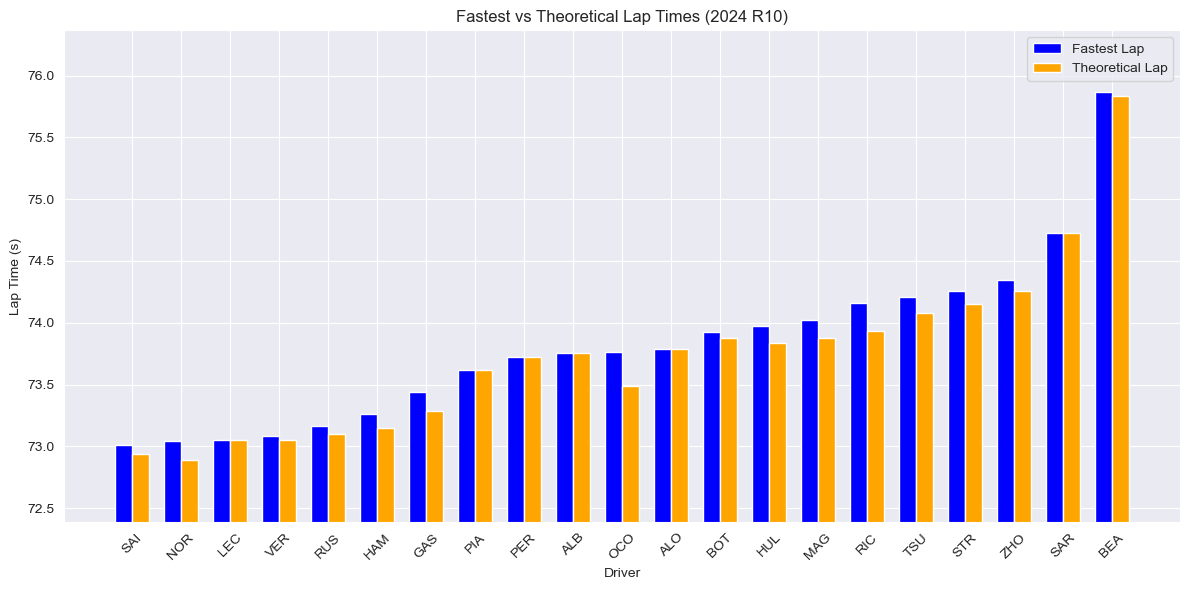


Degradation Slope Histogram saved to C:\data\Dropbox\dev\F1\raw_data\2024\R10\degradation_slope_histogram.png


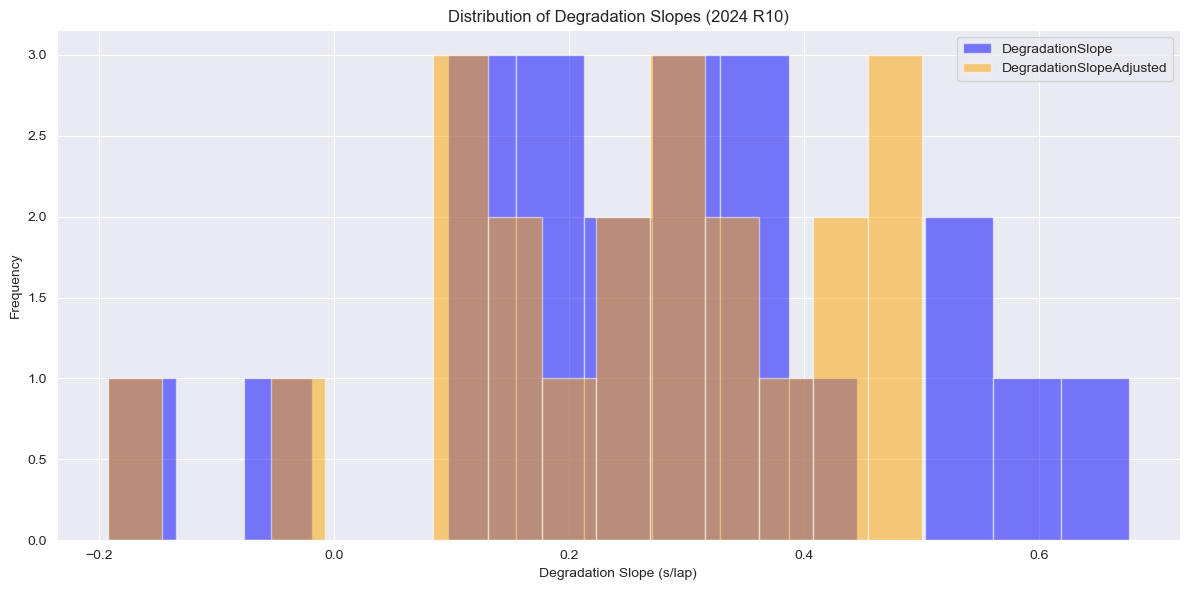


Degradation Slope by Team Boxplot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R10\degradation_slope_by_team.png


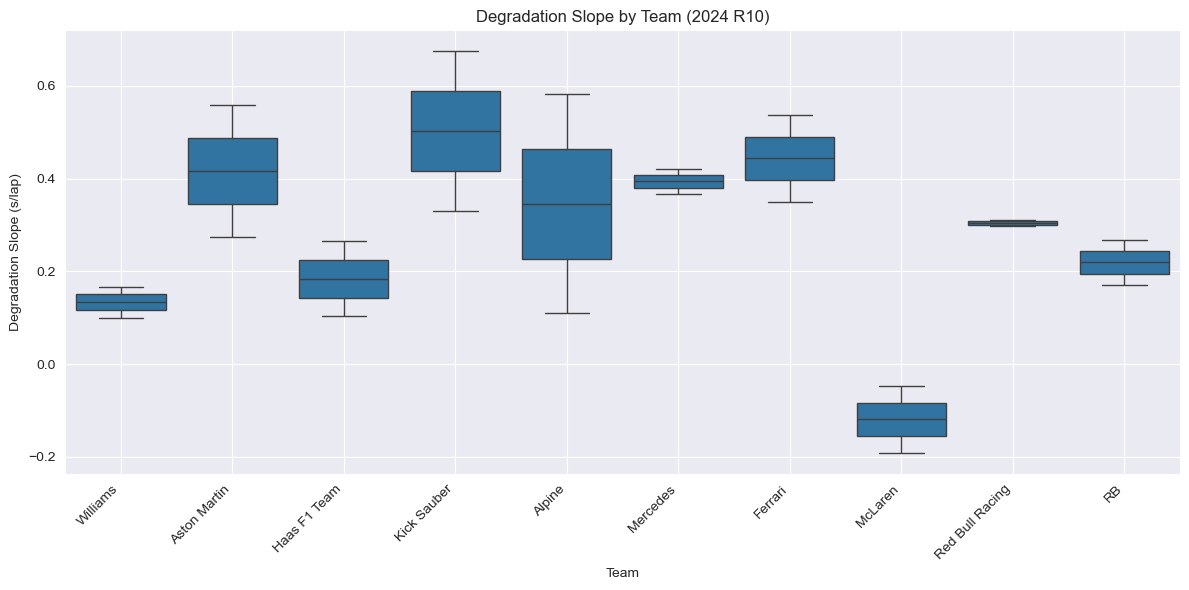


Degradation Slope vs. Base Pace Scatter Plot saved to C:\data\Dropbox\dev\F1\raw_data\2024\R10\degradation_slope_vs_basepace.png


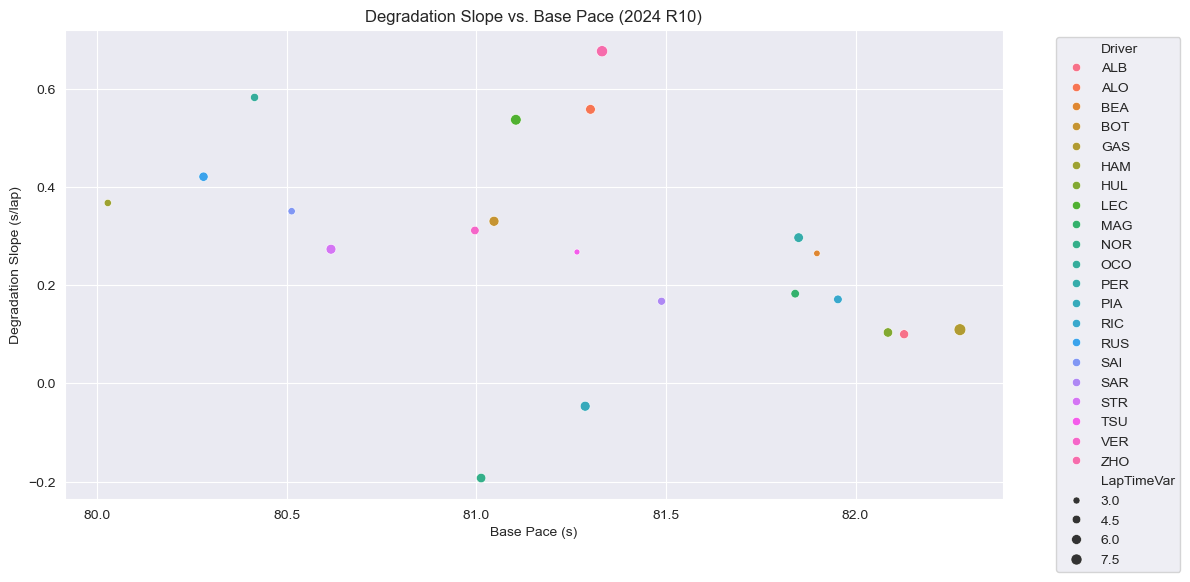


=== Conclusion ===
- Fastest: SAI (73.01s).
2025-03-22 11:16:15,596 - INFO - Step 6: Analyzing telemetry
2025-03-22 11:16:17,200 - INFO - Saved telemetry metrics to C:\data\Dropbox\dev\F1\raw_data\2024\R10\2024_R10_telemetry_metrics.csv

Telemetry Metrics (Top 10 by Max Speed) for Spanish Grand Prix:
Driver   MaxSpeed  ThrottleTime  BrakingIntensity            Team
   ZHO 311.580645     42.071434          0.178045     Kick Sauber
   PIA 310.731707     42.774334          0.159088         McLaren
   LEC 310.187500     47.702682          0.155975         Ferrari
   BEA 310.000000     37.791324          0.180250    Haas F1 Team
   HAM 309.108696     47.418256          0.157537        Mercedes
   GAS 308.729730     38.823248          0.132250          Alpine
   MAG 308.583333     44.505585          0.154299    Haas F1 Team
   SAI 308.568627     47.704639          0.173093         Ferrari
   PER 308.000000     48.871974          0.162706 Red Bull Racing
   NOR 307.957447     42.453279      

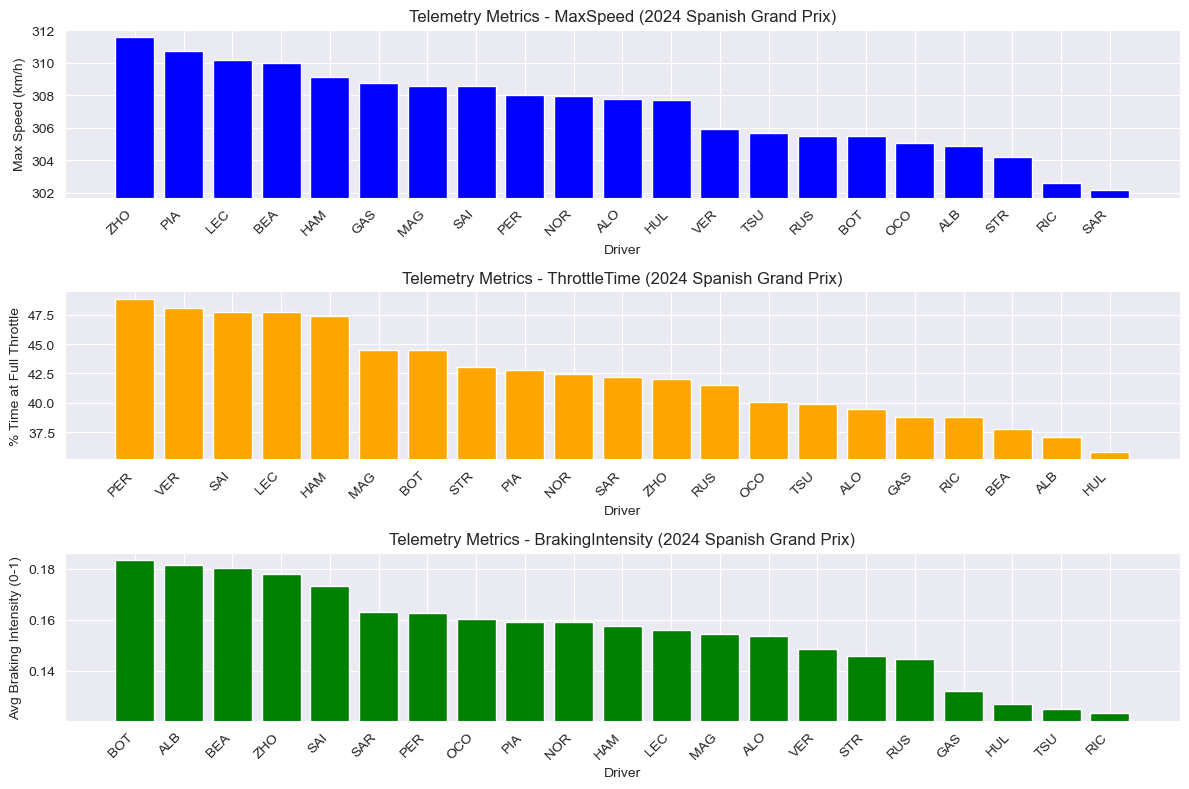


=== Conclusion ===
- Fastest Speed: ZHO (311.58 km/h).
- Most Throttle: PER (48.87%).
2025-03-22 11:16:19,632 - INFO - Step 7: Performing sandbagging analysis
2025-03-22 11:16:19,657 - INFO - Saved sandbag analysis to C:\data\Dropbox\dev\F1\raw_data\2024\R10\2024_R10_sandbag_analysis.csv

Potential Sandbaggers (Sorted by PredictionDiscrepancy):
Driver  FastestLapTime         Team  Sector1Time  Sector2Time  Sector3Time   MaxSpeed  ThrottleTime  ExpectedLapTime  LapTimeDiscrepancy  PredictedLapTime  PredictionDiscrepancy  SpeedRank  LapTimeRank  SandbagFlag
   BEA          75.865 Haas F1 Team       22.523       30.336       22.972 310.000000     37.791324           75.831               0.034         73.735865               2.129135        4.0         21.0         True
   ZHO          74.345  Kick Sauber       21.921       29.651       22.683 311.580645     42.071434           74.255               0.090         73.689547               0.655453        1.0         19.0         True
   MAG 

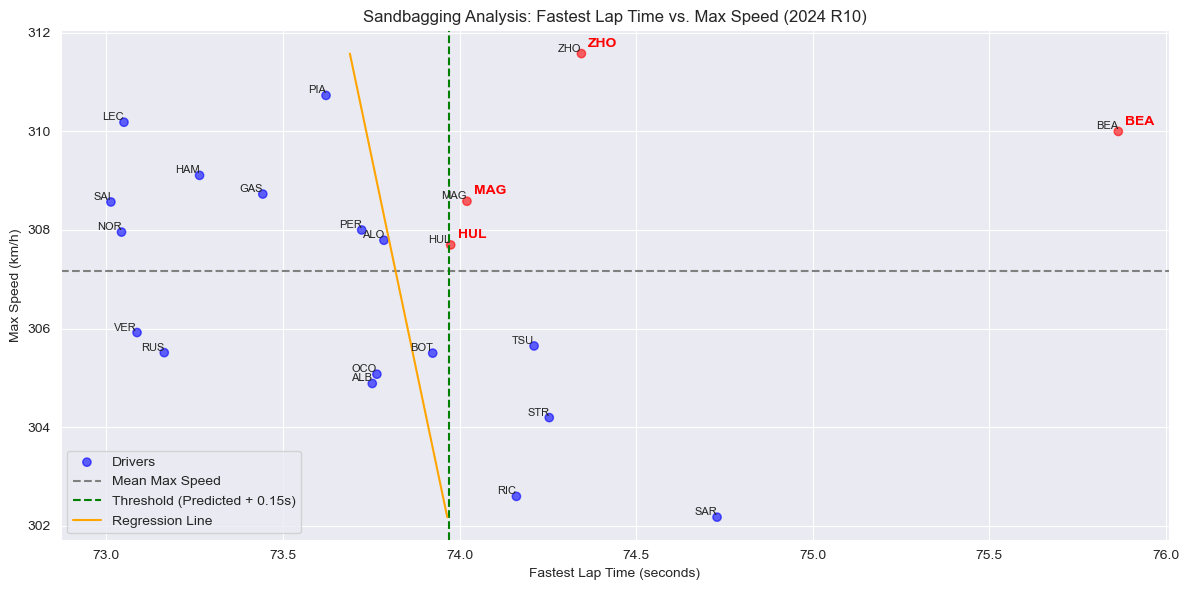

2025-03-22 11:16:20,875 - INFO - Step 8: Analyzing track evolution and weather
2025-03-22 11:16:20,879 - INFO - Average lap time for Practice 1: 95.150 seconds (±20.995)
2025-03-22 11:16:20,881 - INFO - Average lap time for Practice 2: 92.400 seconds (±19.872)
2025-03-22 11:16:20,884 - INFO - Average lap time for Practice 3: 96.837 seconds (±22.497)
2025-03-22 11:16:20,891 - INFO - Saved track evolution to C:\data\Dropbox\dev\F1\raw_data\2024\R10\2024_R10_track_evolution.csv

Average Lap Times Across Sessions:
   Session  AvgLapTime  StdLapTime  LapCount
Practice 1   95.149890   20.994744       444
Practice 2   92.399659   19.871557       498
Practice 3   96.836948   22.496825       288

Average Weather Conditions Across Sessions:
   Session   AirTemp  Humidity  Rainfall  TrackTemp
Practice 1 28.165432 33.666667       0.0  47.092593
Practice 2 24.865432 49.901235       0.0  43.051852
Practice 3 26.441250 57.712500       0.0  43.355000

Correlation between AvgLapTime and TrackTemp: 0.20

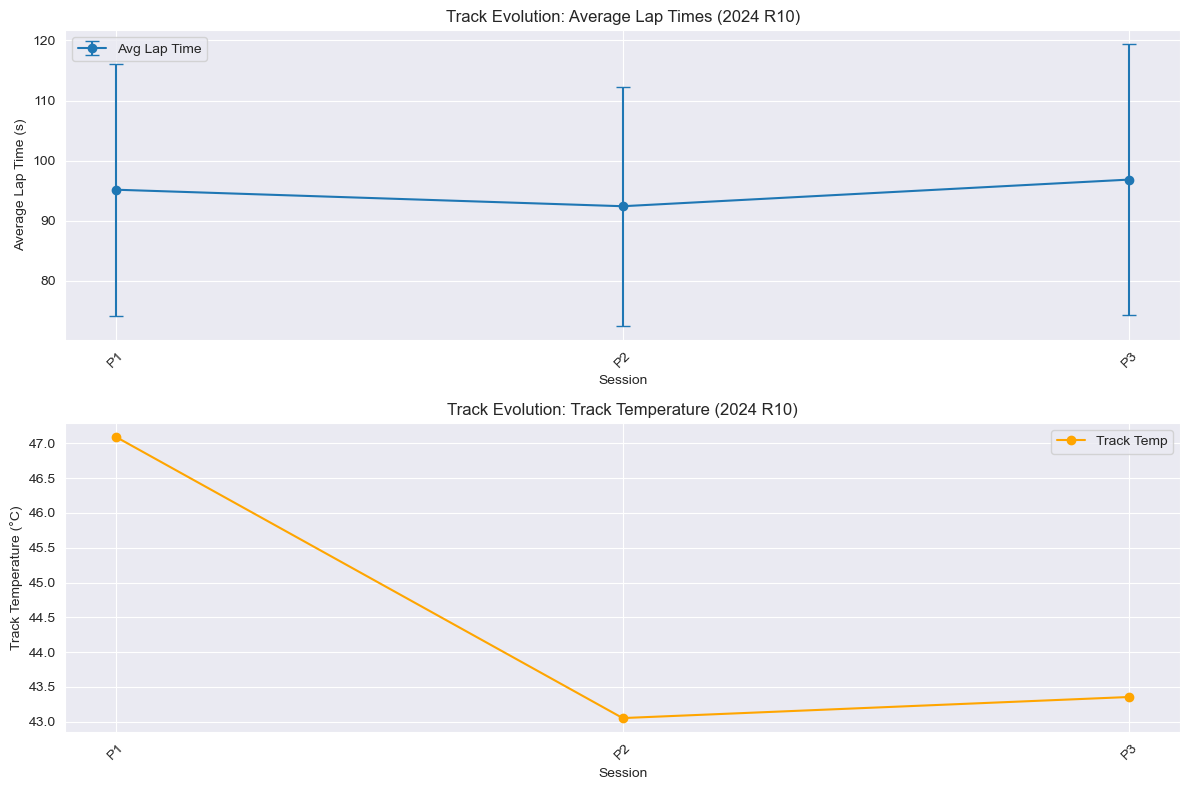

2025-03-22 11:16:22,293 - INFO - Step 9: Analyzing track characteristics
2025-03-22 11:16:22,323 - INFO - Saved track characteristics to C:\data\Dropbox\dev\F1\raw_data\2024\R10\2024_R10_track_characteristics.csv
2025-03-22 11:16:22,330 - INFO - Saved track char drivers to C:\data\Dropbox\dev\F1\raw_data\2024\R10\2024_R10_track_char_drivers.csv
Track Characteristics:
             Track DownforceRequirement OvertakingDifficulty  DRSZones TyreDegradation  LapLength SuitsFastCars
Spanish Grand Prix               Medium               Medium         2          Medium        5.0            No

Top 5 Drivers by Track Fit:
Driver        Team  StraightSpeedPotential  CorneringPotential   AvgSpeed  OverallFit  FitRank
   LEC     Ferrari              310.187500           24.350000 246.406571    0.996213      1.0
   PIA     McLaren              310.731707           24.540667 244.492136    0.995110      2.0
   ZHO Kick Sauber              311.580645           24.751667 242.114466    0.994485      3

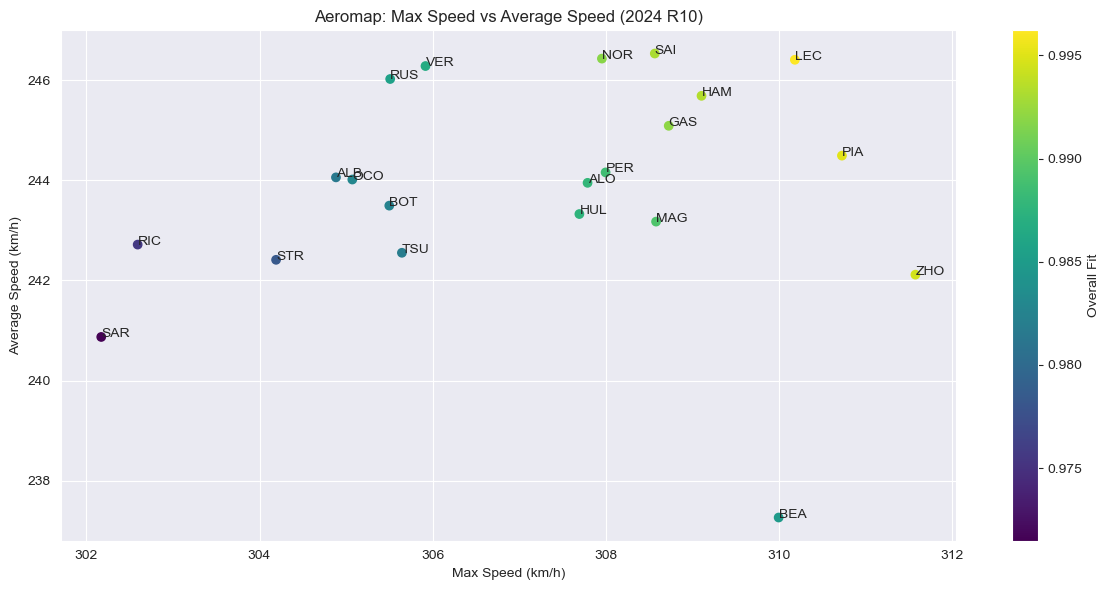

2025-03-22 11:16:25,249 - INFO - Step 10: Predicting race outcomes
2025-03-22 11:16:25,262 - INFO - Loaded pit_stop_loss from file: 20.00s for Spanish Grand Prix
2025-03-22 11:16:25,321 - INFO - No Sprint session data available; setting SprintPaceAdjustment to 0 for all drivers.
2025-03-22 11:16:25,353 - INFO - Predicted Fastest Lap Driver: SAI
2025-03-22 11:16:25,368 - INFO - Saved qualifying prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R10\2024_R10_quali_prediction.csv
2025-03-22 11:16:25,371 - INFO - Saved race prediction to C:\data\Dropbox\dev\F1\raw_data\2024\R10\2024_R10_race_prediction.csv

Qualifying Prediction:
Driver            Team  LapTime  ExpectedLapTime  AdjustedLapTime  QualiPosition
   NOR         McLaren   73.043           72.890           72.737              1
   SAI         Ferrari   73.013           72.940           72.867              2
   VER Red Bull Racing   73.087           73.050           73.013              3
   HAM        Mercedes   73.264           

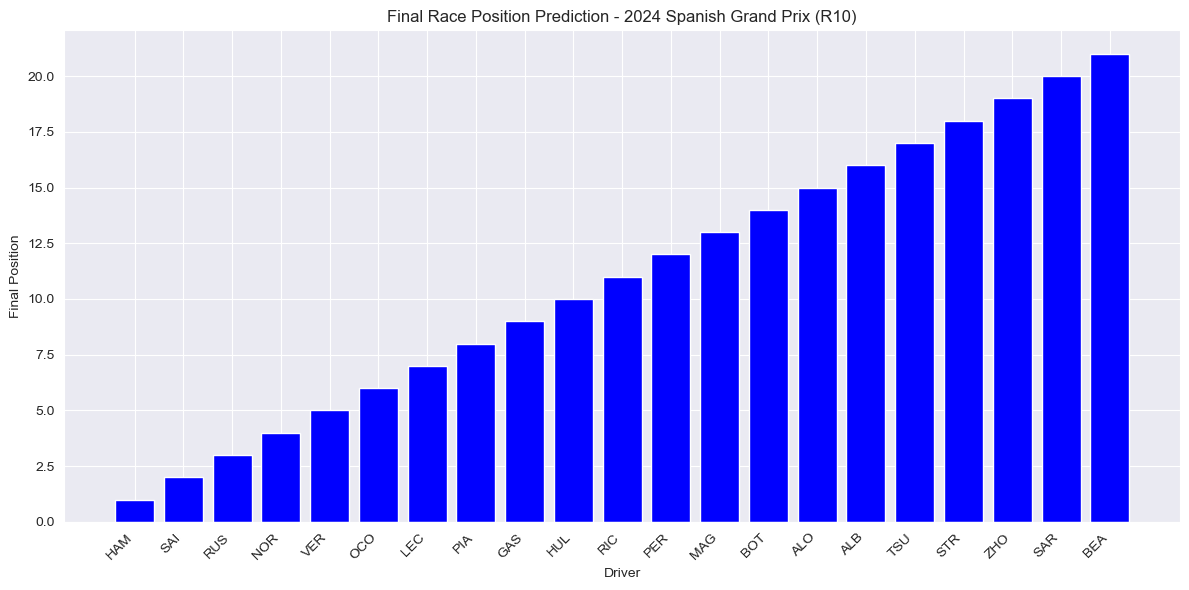

2025-03-22 11:16:27,107 - INFO - Step 11: Generating summary report
Debug: Verifying input DataFrames...
quali_prediction_df shape: (21, 9)
race_prediction_df shape: (21, 25)
driver_performance shape: (21, 12)
Pit stop loss for Spanish Grand Prix: 20.00s
Calculated pit_stop_loss for Spanish Grand Prix: 20.00s
Saved pit_stop_loss to C:\data\Dropbox\dev\F1\raw_data\pit_stop_loss_by_track.csv
Dynamically fetched actual qualifying top 5: ['NOR', 'VER', 'HAM', 'RUS', 'LEC']
Dynamically fetched actual race top 10: ['VER', 'NOR', 'HAM', 'RUS', 'LEC', 'SAI', 'PIA', 'PER', 'GAS', 'OCO']
Dynamically fetched actual fastest lap driver: NOR

=== Comprehensive Summary Report ===

Event: 2024 Round 10 - Spanish Grand Prix

--- Qualifying Analysis ---
Actual Qualifying Top 5: ['NOR', 'VER', 'HAM', 'RUS', 'LEC']
Predicted Qualifying Top 5:
Driver  AdjustedLapTime  QualiPosition
   NOR           72.737              1
   SAI           72.867              2
   VER           73.013              3
   HAM   

In [300]:
# Step 12: Batch Process Multiple Rounds
import pandas as pd
import os
import logging
from datetime import datetime

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def batch_process_rounds(year, rounds, dirs=None, force_redownload=False, visualize=True):
    """
    Batch process multiple rounds to generate predictions and reports, saving summarized results to a CSV file.

    Args:
        year (int): The year of the F1 season.
        rounds (list): List of round numbers to process.
        dirs (dict): Directory paths from Cell 1.
        force_redownload (bool): Whether to force redownload of data.
        visualize (bool): Whether to generate visualizations.
    """
    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}

    DATA_DIR = dirs["DATA_DIR"]
    reports_dir = os.path.join(DATA_DIR, "reports", str(year))
    os.makedirs(reports_dir, exist_ok=True)

    # Set up summary CSV file
    summary_file = os.path.join(reports_dir, f"{year}_batch_process_summary.csv")
    summary_data = []

    # Log start time
    start_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    logger.info(f"Starting batch processing for {year} Rounds {rounds} at {start_time}")

    errors = []
    for round_number in rounds:
        try:
            logger.info(f"Processing {year} Round {round_number}...")

            # Step 2: Define target event
            logger.info(f"Step 2: Getting target event for {year} Round {round_number}")
            target_info = get_target_event(year, round_number, dirs=dirs, skip_timing_validation=True)

            # Step 3: Download practice data
            logger.info("Step 3: Downloading practice data")
            practice_data = download_practice_data(target_info, dirs=dirs, force_redownload=force_redownload, visualize=visualize)

            # Summarize LapTime data (fastest lap per driver across all sessions)
            all_laps = []
            for session in practice_data:
                laps = practice_data[session]['laps']
                if not laps.empty:
                    laps['Session'] = session
                    all_laps.append(laps[['Driver', 'LapTimeSeconds', 'Session']])
            if all_laps:
                all_laps_df = pd.concat(all_laps, ignore_index=True)
                fastest_laps = all_laps_df.groupby('Driver')['LapTimeSeconds'].min().reset_index()
                fastest_laps['Round'] = round_number
                fastest_laps['Metric'] = 'FastestLapTime'
                summary_data.append(fastest_laps[['Round', 'Metric', 'Driver', 'LapTimeSeconds']])

            # Step 4: Clean and aggregate data
            logger.info("Step 4: Cleaning and aggregating data")
            cleaned_data = clean_and_aggregate_data(target_info, practice_data, dirs=dirs, visualize=visualize)

            # Step 5: Compute driver performance
            driver_file = os.path.join(DATA_DIR, str(year), f"R{round_number}", f"{year}_R{round_number}_driver_performance.csv")
            if os.path.exists(driver_file) and not force_redownload:
                driver_performance = pd.read_csv(driver_file)
            else:
                driver_performance = compute_driver_performance(cleaned_data, target_info, dirs=dirs, force_redownload=force_redownload, visualize=visualize)
                driver_performance.to_csv(driver_file, index=False)

            # Summarize driver performance (top 5 by TheoreticalLapTime)
            if not driver_performance.empty:
                driver_summary = driver_performance.sort_values('TheoreticalLapTime').head(5)[['Driver', 'TheoreticalLapTime', 'BasePace', 'Sector1Time', 'Sector2Time', 'Sector3Time']]
                driver_summary['Round'] = round_number
                driver_summary['Metric'] = 'DriverPerformance'
                summary_data.append(driver_summary[['Round', 'Metric', 'Driver', 'TheoreticalLapTime', 'BasePace', 'Sector1Time', 'Sector2Time', 'Sector3Time']])

            # Step 6: Analyze telemetry
            logger.info("Step 6: Analyzing telemetry")
            telemetry_metrics = analyze_telemetry_metrics(target_info, cleaned_data, dirs=dirs, force_redownload=force_redownload, visualize=visualize)

            # Step 7: Sandbagging analysis
            logger.info("Step 7: Performing sandbagging analysis")
            sandbag_analysis = investigate_sandbagging(target_info, driver_performance, telemetry_metrics, dirs=dirs, force_redownload=force_redownload, visualize=visualize)

            # Step 8: Track evolution and weather
            logger.info("Step 8: Analyzing track evolution and weather")
            track_evolution = evaluate_track_evolution(target_info, cleaned_data, dirs=dirs, force_redownload=force_redownload, visualize=visualize)

            # Step 9: Track characteristics
            logger.info("Step 9: Analyzing track characteristics")
            track_char_drivers = analyze_track_characteristics(driver_performance, telemetry_metrics, target_info, dirs=dirs, force_redownload=force_redownload, visualize=visualize)

            # Step 10: Predict race outcomes
            logger.info("Step 10: Predicting race outcomes")
            quali_prediction_df, race_prediction_df, fastest_lap_pred, pit_stop_loss = predict_race_outcomes(
                target_info, driver_performance, telemetry_metrics, sandbag_analysis, track_evolution, track_char_drivers, dirs=dirs, visualize=visualize
            )

            # Summarize race predictions (top 10)
            if not race_prediction_df.empty:
                race_summary = race_prediction_df.sort_values('FinalPosition').head(10)[['Driver', 'Team', 'GridPosition', 'FinalPosition']]
                race_summary['Round'] = round_number
                race_summary['Metric'] = 'RacePrediction'
                race_summary['FastestLapPred'] = fastest_lap_pred
                race_summary['PitStopLoss'] = pit_stop_loss
                summary_data.append(race_summary[['Round', 'Metric', 'Driver', 'Team', 'GridPosition', 'FinalPosition', 'FastestLapPred', 'PitStopLoss']])

            # Step 11: Generate summary report
            logger.info("Step 11: Generating summary report")
            generate_summary_report(
                target_info, driver_performance, quali_prediction_df, race_prediction_df, fastest_lap_pred, pit_stop_loss, dirs=dirs
            )

        except Exception as e:
            logger.error(f"Error processing {year} Round {round_number}: {str(e)}")
            logger.error(f"Detailed error: {str(e)}", exc_info=True)
            errors.append({'Round': round_number, 'Error': str(e)})
            continue

    # Combine all summary data into a single DataFrame
    if summary_data:
        summary_df = pd.concat(summary_data, ignore_index=True, sort=False)
        summary_df.to_csv(summary_file, index=False)
        logger.info(f"Summary results saved to {summary_file}")
    else:
        logger.warning("No summary data to save.")

    # Save errors to a separate section in the CSV
    if errors:
        errors_df = pd.DataFrame(errors)
        errors_df['Metric'] = 'Error'
        with open(summary_file, 'a') as f:
            f.write("\n")
            errors_df.to_csv(f, index=False)

    logger.info(f"Batch processing completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# In notebook, execute directly (assumes Cells 1-11 ran)
print("Starting Cell 12 execution...")
batch_process_rounds(2024, range(1,11), dirs=dirs, force_redownload=True, visualize=True)
print("Cell 12 execution completed.")

Starting Cell 13 execution...
2025-03-22 11:17:12,986 - INFO - Connected to database at C:\data\Dropbox\dev\F1\raw_data\f1_fantasy.db
2025-03-22 11:17:12,989 - INFO - Consolidating data for 2024 Round 1
2025-03-22 11:17:12,991 - WARNING - File C:\data\Dropbox\dev\F1\raw_data\2024\R1\2024_R1_event.csv not found for table event
2025-03-22 11:17:13,011 - INFO - Inserted 20 rows into driver_performance table for Round 1
2025-03-22 11:17:13,031 - INFO - Inserted 20 rows into telemetry_metrics table for Round 1
2025-03-22 11:17:13,052 - INFO - Inserted 20 rows into sandbag_analysis table for Round 1
2025-03-22 11:17:13,066 - INFO - Inserted 1 rows into track_characteristics table for Round 1
2025-03-22 11:17:13,081 - INFO - Inserted 3 rows into track_evolution table for Round 1
2025-03-22 11:17:13,101 - INFO - Inserted 20 rows into quali_predictions table for Round 1
2025-03-22 11:17:13,126 - INFO - Inserted 20 rows into race_predictions table for Round 1
2025-03-22 11:17:13,166 - INFO - Ins

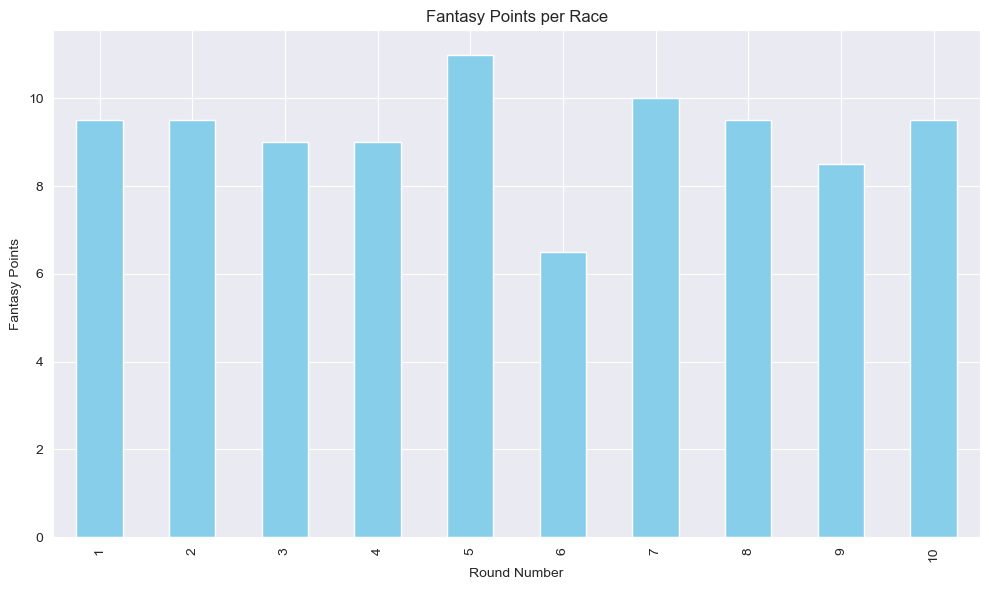

Cell 13 execution completed.


In [301]:
# Step 13: Consolidate Data into Database and Evaluate Total Fantasy Points
import sqlite3
import pandas as pd
import os
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def consolidate_data(year, rounds, dirs=None):
    """
    Consolidate data from CSVs into a SQLite database, avoiding duplicates.

    Args:
        year (int): Race year (e.g., 2024)
        rounds (list): List of round numbers to process
        dirs (dict): Directory paths from Cell 1

    Returns:
        None: Saves data to database
    """
    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    # Connect to the database
    db_path = os.path.join(DATA_DIR, 'f1_fantasy.db')
    try:
        conn = sqlite3.connect(db_path)
        logger.info(f"Connected to database at {db_path}")
    except sqlite3.Error as e:
        logger.error(f"Error connecting to database: {e}")
        raise

    # Define table mappings (filename to table name)
    table_mappings = {
        'event': f"{year}_R{{round}}_event.csv",
        'driver_performance': f"{year}_R{{round}}_driver_performance.csv",
        'telemetry_metrics': f"{year}_R{{round}}_telemetry_metrics.csv",
        'sandbag_analysis': f"{year}_R{{round}}_sandbag_analysis.csv",
        'track_characteristics': f"{year}_R{{round}}_track_characteristics.csv",
        'track_evolution': f"{year}_R{{round}}_track_evolution.csv",
        'quali_predictions': f"{year}_R{{round}}_quali_prediction.csv",
        'race_predictions': f"{year}_R{{round}}_race_prediction.csv",
        'summary_results': f"{year}_R{{round}}_summary_results.csv",
    }

    for round_number in rounds:
        data_path = os.path.join(DATA_DIR, str(year), f"R{round_number}")
        logger.info(f"Consolidating data for {year} Round {round_number}")

        for table_name, file_template in table_mappings.items():
            file_path = os.path.join(data_path, file_template.format(round=round_number))
            if os.path.exists(file_path):
                try:
                    df = pd.read_csv(file_path)
                    df['RoundNumber'] = round_number  # Add RoundNumber to each table
                    # Drop existing entries for this round to avoid duplicates
                    conn.execute(f"DELETE FROM {table_name} WHERE RoundNumber = ?", (round_number,))
                    df.to_sql(table_name, conn, if_exists='append', index=False)
                    logger.info(f"Inserted {len(df)} rows into {table_name} table for Round {round_number}")
                except Exception as e:
                    logger.error(f"Error processing {file_path} for table {table_name}: {e}")
            else:
                logger.warning(f"File {file_path} not found for table {table_name}")

    # Handle prediction_insights separately (not per-round)
    insights_file = os.path.join(DATA_DIR, "prediction_insights.csv")
    if os.path.exists(insights_file):
        try:
            df = pd.read_csv(insights_file)
            logger.info(f"Before renaming, prediction_insights columns: {df.columns.tolist()}")
            logger.info(f"prediction_insights data preview:\n{df.head().to_string()}")
            # Rename columns for consistency
            df = df.rename(columns={
                'Run DateTime': 'RunDateTime',
                'RoundNumber': 'RoundNumber',
                'Event Name': 'EventName',
                'Pace Error (s)': 'PaceError',
                'Deg Error (%)': 'DegError',
                'Overtake Error (pos)': 'OvertakeError',
                'Pit Stop Count Error': 'PitStopCountError',
                'Pit Time Error (s)': 'PitTimeError',
                'Quali Pace Error (s)': 'QualiPaceError',
                'Sector Time Error (s)': 'SectorTimeError',
                'Sandbag Accuracy (%)': 'SandbagAccuracy',
                'Telemetry Error (km/h)': 'TelemetryError',
                'Track Evo Error (s)': 'TrackEvoError',
                'Consistency Error (s)': 'ConsistencyError',
                'Fantasy Points': 'FantasyPoints'
            })
            logger.info(f"After renaming, prediction_insights columns: {df.columns.tolist()}")
            # Deduplicate by keeping the latest entry per RoundNumber
            df['RunDateTime'] = pd.to_datetime(df['RunDateTime'])
            df = df.sort_values('RunDateTime').groupby('RoundNumber').last().reset_index()
            # Drop the prediction_insights table and replace with deduplicated data
            conn.execute("DROP TABLE IF EXISTS prediction_insights")
            df.to_sql('prediction_insights', conn, if_exists='replace', index=False)
            logger.info(f"Inserted {len(df)} rows into prediction_insights table after deduplication")
            # Verify the schema
            schema_query = "PRAGMA table_info(prediction_insights)"
            schema = pd.read_sql_query(schema_query, conn)
            logger.info(f"prediction_insights schema: {schema['name'].tolist()}")
        except Exception as e:
            logger.error(f"Error processing {insights_file} for prediction_insights table: {e}")
    else:
        logger.warning(f"Prediction insights file {insights_file} not found")

    conn.commit()
    conn.close()
    logger.info("Database consolidation completed")

def evaluate_total_points(db_path=None, races=None, dirs=None, visualize=True):
    """
    Compute total Fantasy points from the prediction_insights table to evaluate prediction improvements.

    Args:
        db_path (str, optional): Path to the SQLite database
        races (list, optional): List of round numbers to evaluate. If None, use all races.
        dirs (dict): Directory paths from Cell 1
        visualize (bool): Whether to generate a visualization of points per race

    Returns:
        float: Total Fantasy points across specified races
    """
    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    if db_path is None:
        db_path = os.path.join(DATA_DIR, 'f1_fantasy.db')

    # Connect to the database
    try:
        conn = sqlite3.connect(db_path)
        logger.info(f"Connected to database at {db_path}")
    except sqlite3.Error as e:
        logger.error(f"Error connecting to database: {e}")
        raise

    # Query to fetch Fantasy points from prediction_insights table
    query = """
    SELECT RoundNumber, FantasyPoints
    FROM prediction_insights
    WHERE FantasyPoints IS NOT NULL
    """

    if races is not None:
        race_list = ', '.join(map(str, races))
        query += f" AND RoundNumber IN ({race_list})"

    try:
        df = pd.read_sql_query(query, conn)
    except Exception as e:
        logger.error(f"Error querying database: {e}")
        # Log the schema to debug
        schema_query = "PRAGMA table_info(prediction_insights)"
        try:
            schema = pd.read_sql_query(schema_query, conn)
            logger.info(f"prediction_insights schema: {schema['name'].tolist()}")
        except Exception as schema_e:
            logger.error(f"Error fetching schema: {schema_e}")
        conn.close()
        raise
    finally:
        conn.close()

    if df.empty:
        print("No Fantasy points data available for evaluation.")
        return 0.0

    # Compute total points
    total_points = df['FantasyPoints'].sum()
    print(f"\n=== Total Fantasy Points Evaluation ===")
    print(f"Total Fantasy Points across {len(df['RoundNumber'].unique())} races: {total_points:.2f}")

    # Per-race breakdown
    race_points = df.groupby('RoundNumber')['FantasyPoints'].sum().round(2)
    print("\nPer-Race Fantasy Points:")
    print(race_points)

    # Visualization
    if visualize and not race_points.empty:
        plt.figure(figsize=(10, 6))
        race_points.plot(kind='bar', color='skyblue')
        plt.xlabel('Round Number')
        plt.ylabel('Fantasy Points')
        plt.title('Fantasy Points per Race')
        plt.grid(True)
        plt.tight_layout()
        plot_file = os.path.join(DATA_DIR, "fantasy_points_per_race.png")
        plt.savefig(plot_file)
        print(f"Fantasy Points per Race plot saved to {plot_file}")
        plt.show(block=False)

    return total_points

# In notebook, execute directly (assumes Cells 1-12 ran)
print("Starting Cell 13 execution...")
# Consolidate data for Rounds 1-9
consolidate_data(2024, list(range(1, 10)), dirs=dirs)
# Evaluate total points across all races
total_points = evaluate_total_points(races=None, dirs=dirs, visualize=True)
print("Cell 13 execution completed.")

Starting Cell 14 execution...

=== Overall Degradation Error Statistics ===
Mean Degradation Error (Predicted - Actual) across all races: 68.7349%
Std Dev of Degradation Error: 111.5898%

=== Overall Pace Error Statistics ===
Mean Pace Error (Predicted - Actual) across all races: -0.6708 seconds
Std Dev of Pace Error: 2.5904 seconds

=== Overall Position Error Statistics ===
Mean Position Error (Predicted - Actual) across all races: 1.1846 positions
Std Dev of Position Error: 6.1382 positions

Correlation (R²) between Predicted and Actual Degradation: 0.0354, P-value: 0.0002

=== Per-Driver Statistics ===
        DegError                 PaceError         PositionError          \
            mean       std count      mean     std          mean     std   
Driver                                                                     
ALB      63.1354   91.8034    18   -1.1789  2.8334       -5.0000  3.6137   
ALO      64.3110   88.6695    21   -1.5594  2.0715       -5.8571  4.7253   
BEA    

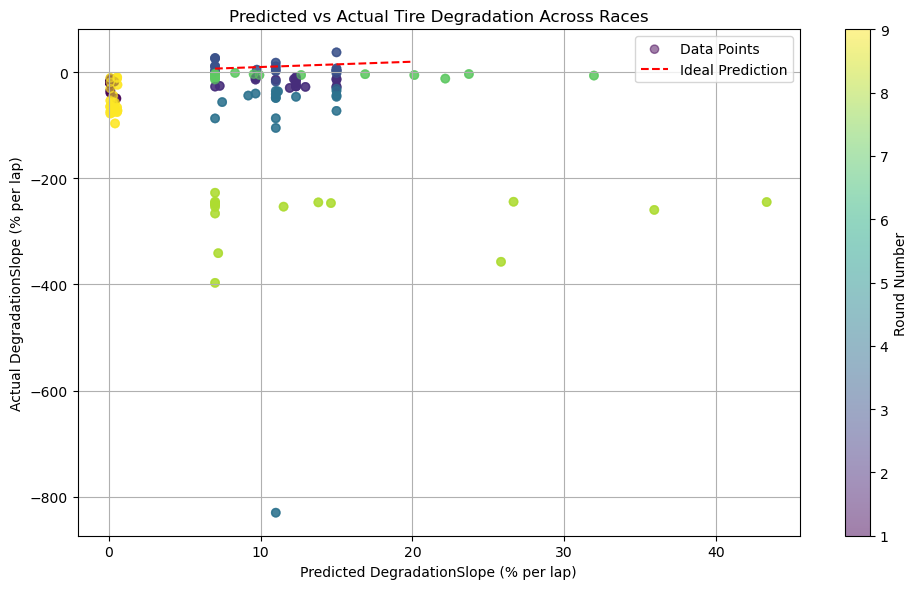

Degradation Error Histogram plot saved to C:\data\Dropbox\dev\F1\raw_data\degradation_error_histogram.png


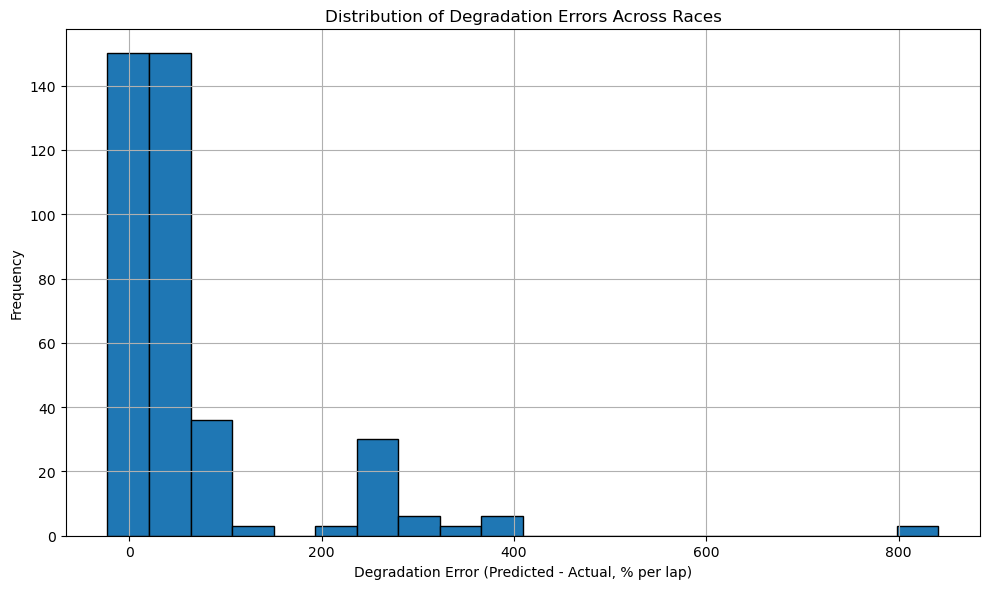

C:\Users\Elmar Conradie\AppData\Local\Temp\ipykernel_9112\3158728301.py:202: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df_box.values, labels=df_box.columns)


Degradation Error by Driver plot saved to C:\data\Dropbox\dev\F1\raw_data\degradation_error_by_driver.png


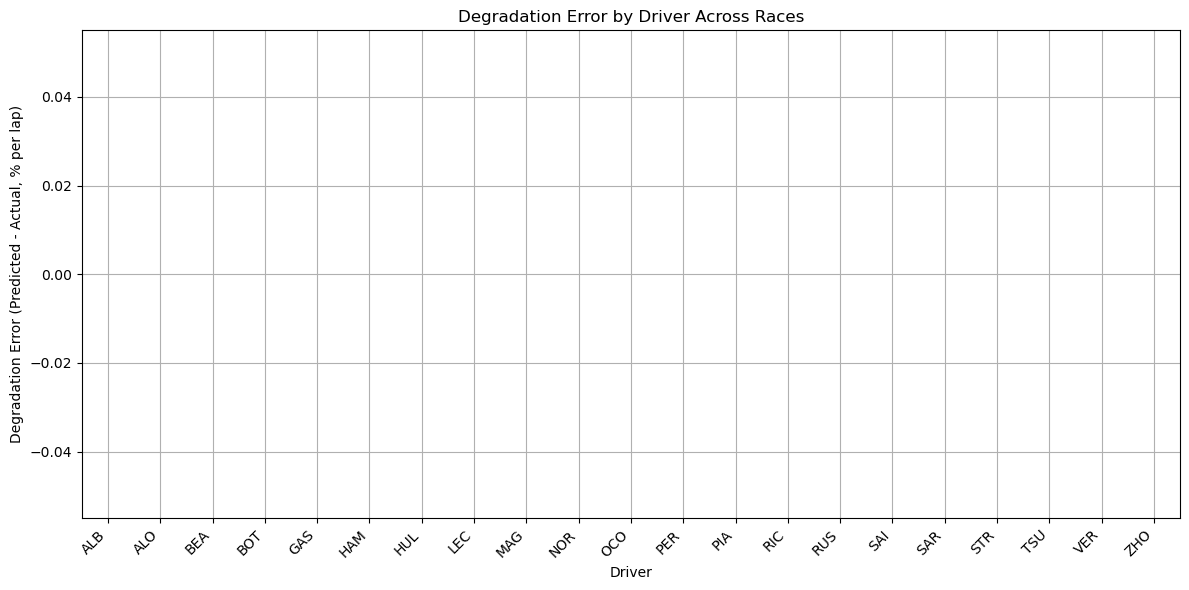

C:\Users\Elmar Conradie\AppData\Local\Temp\ipykernel_9112\3158728301.py:220: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df_box.values, labels=df_box.columns)


Pace Error by Driver plot saved to C:\data\Dropbox\dev\F1\raw_data\pace_error_by_driver.png


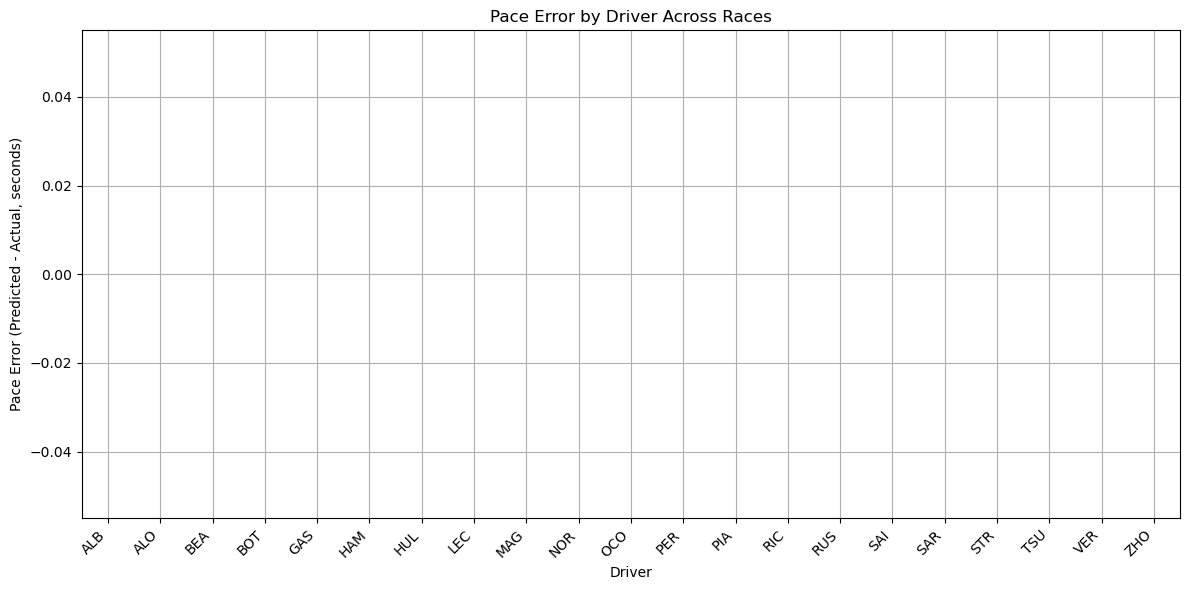

C:\Users\Elmar Conradie\AppData\Local\Temp\ipykernel_9112\3158728301.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df_box.values, labels=df_box.columns)


Position Error by Driver plot saved to C:\data\Dropbox\dev\F1\raw_data\position_error_by_driver.png


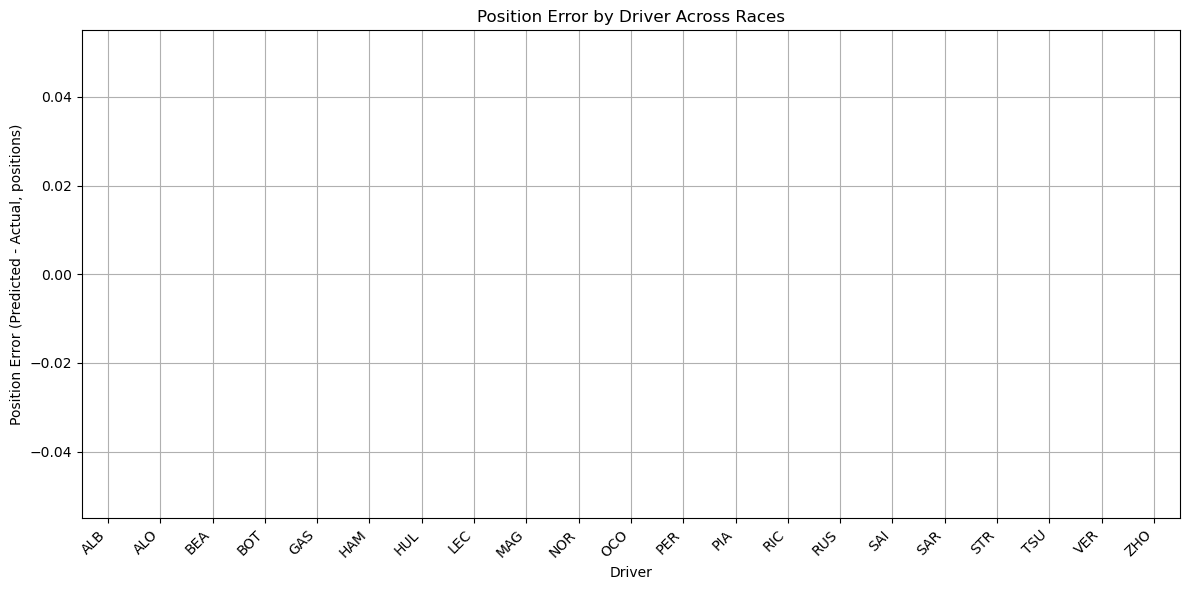


=== Insights and Suggestions ===
Significant errors detected in degradation predictions.
- **Issue**: Many drivers (e.g., Perez) default to 7.0%. Possible causes:
  - Insufficient long-run laps in Cell 5 (`TyreLife > 10` or IQR filter too strict).
  - Suggestion: Lower `TyreLife` threshold to 5, relax IQR filter, or use a proxy (e.g., median degradation from similar tracks).
- **Issue**: Extreme values (>15%) detected (e.g., ALB, VER). Possible causes:
  - Too few laps, amplifying noise. Increase data by adjusting filters in Cell 4 (e.g., include more laps with `TrackStatus='1'`).
  - Disruptions (e.g., red flags). Filter affected laps in Cell 4 by checking `TrackStatus` or `DeletedReason`.
- **General**: Review Cells 3-4 for data collection issues (e.g., missing laps, red flags). Consider adding weather impact in Cell 5.
Pace predictions align reasonably with actuals. Minor tuning may be needed.
Significant errors detected in position predictions.
- **Issue**: Extreme position errors

In [81]:
# Step 14: Analyze Prediction Accuracy and Diagnose Data/Calculation Issues Across All Races
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def fetch_prediction_data(db_path=None, races=None, dirs=None):
    """
    Fetch prediction and actual data from the database.

    Args:
        db_path (str, optional): Path to the SQLite database.
        races (list, optional): List of round numbers to filter. If None, use all races.
        dirs (dict): Directory paths from Cell 1

    Returns:
        pd.DataFrame: DataFrame with prediction and actual data.
    """
    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    if db_path is None:
        db_path = os.path.join(DATA_DIR, 'f1_fantasy.db')

    # Connect to the database
    try:
        conn = sqlite3.connect(db_path)
        logger.info(f"Connected to database at {db_path}")
    except sqlite3.Error as e:
        logger.error(f"Error connecting to database: {e}")
        raise

    # Query to fetch relevant data from summary_results table
    query = """
    SELECT
        DegradationSlope,
        ActualDegradationSlope,
        DegError,
        PaceError,
        PositionError,
        RoundNumber,
        Driver
    FROM summary_results
    WHERE DegradationSlope IS NOT NULL AND ActualDegradationSlope IS NOT NULL
    """

    if races is not None:
        race_list = ', '.join(map(str, races))
        query += f" AND RoundNumber IN ({race_list})"

    try:
        df = pd.read_sql_query(query, conn)
    except Exception as e:
        logger.error(f"Error querying database: {e}")
        logger.info("Available columns in summary_results table:")
        # Inspect table schema
        schema_query = "PRAGMA table_info(summary_results)"
        try:
            schema = pd.read_sql_query(schema_query, conn)
            logger.info(f"Columns: {schema['name'].tolist()}")
        except Exception as schema_e:
            logger.error(f"Error fetching schema: {schema_e}")
        conn.close()
        raise e

    conn.close()

    # Calculate DegError if not precomputed or contains nulls
    if 'DegError' not in df.columns or df['DegError'].isnull().any():
        logger.warning("DegError missing or contains nulls; recomputing...")
        df['DegError'] = df['DegradationSlope'] - df['ActualDegradationSlope']

    return df

def analyze_prediction_trends(df, dirs=None, visualize=True):
    """
    Analyze trends in prediction accuracy across races and drivers.

    Args:
        df (pd.DataFrame): DataFrame with prediction and actual data.
        dirs (dict): Directory paths from Cell 1
        visualize (bool): Whether to generate visualizations

    Returns:
        None: Prints statistics and plots visualizations.
    """
    if dirs is None:
        dirs = {"DATA_DIR": os.path.join(os.getcwd(), "raw_data")}
    DATA_DIR = dirs["DATA_DIR"]

    if df.empty:
        print("No data available for analysis.")
        logger.warning("DataFrame is empty; no analysis performed.")
        return

    # Required columns
    required_columns = ['DegradationSlope', 'ActualDegradationSlope', 'DegError', 'PaceError', 'PositionError', 'RoundNumber', 'Driver']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        logger.error(f"Missing required columns: {missing_columns}")
        raise KeyError(f"Missing required columns: {missing_columns}")

    # Overall statistical analysis for DegError
    mean_deg_error = df['DegError'].mean()
    std_deg_error = df['DegError'].std()
    print(f"\n=== Overall Degradation Error Statistics ===")
    print(f"Mean Degradation Error (Predicted - Actual) across all races: {mean_deg_error:.4f}%")
    print(f"Std Dev of Degradation Error: {std_deg_error:.4f}%")

    # Overall statistical analysis for PaceError
    mean_pace_error = df['PaceError'].mean()
    std_pace_error = df['PaceError'].std()
    print(f"\n=== Overall Pace Error Statistics ===")
    print(f"Mean Pace Error (Predicted - Actual) across all races: {mean_pace_error:.4f} seconds")
    print(f"Std Dev of Pace Error: {std_pace_error:.4f} seconds")

    # Overall statistical analysis for PositionError
    mean_position_error = df['PositionError'].mean()
    std_position_error = df['PositionError'].std()
    print(f"\n=== Overall Position Error Statistics ===")
    print(f"Mean Position Error (Predicted - Actual) across all races: {mean_position_error:.4f} positions")
    print(f"Std Dev of Position Error: {std_position_error:.4f} positions")

    # Correlation between predicted and actual degradation
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['DegradationSlope'], df['ActualDegradationSlope'])
    print(f"\nCorrelation (R²) between Predicted and Actual Degradation: {r_value**2:.4f}, P-value: {p_value:.4f}")

    # Per-driver analysis
    driver_stats = df.groupby('Driver').agg({
        'DegError': ['mean', 'std', 'count'],
        'PaceError': ['mean', 'std'],
        'PositionError': ['mean', 'std'],
        'DegradationSlope': ['mean', 'max', 'min'],
        'ActualDegradationSlope': ['mean', 'max', 'min']
    }).round(4)
    print("\n=== Per-Driver Statistics ===")
    print(driver_stats)

    # Per-race analysis
    race_stats = df.groupby('RoundNumber').agg({
        'DegError': ['mean', 'std', 'count'],
        'PaceError': ['mean', 'std'],
        'PositionError': ['mean', 'std'],
        'DegradationSlope': ['mean', 'max', 'min'],
        'ActualDegradationSlope': ['mean', 'max', 'min']
    }).round(4)
    print("\n=== Per-Race Statistics ===")
    print(race_stats)

    # Identify anomalies
    zero_degradation_drivers = df[df['DegradationSlope'] == 7.0]['Driver'].unique()
    extreme_degradation_drivers = df[df['DegradationSlope'] > 15.0]['Driver'].unique()
    extreme_pace_error_drivers = df[df['PaceError'].abs() > 5.0]['Driver'].unique()
    extreme_position_error_drivers = df[df['PositionError'].abs() > 5.0]['Driver'].unique()
    print(f"\n=== Anomalies ===")
    print(f"Drivers with Default Degradation (7.0%): {', '.join(zero_degradation_drivers) if zero_degradation_drivers.size > 0 else 'None'}")
    print(f"Drivers with Extreme Degradation (>15%): {', '.join(extreme_degradation_drivers) if extreme_degradation_drivers.size > 0 else 'None'}")
    print(f"Drivers with Extreme Pace Error (>5s): {', '.join(extreme_pace_error_drivers) if extreme_pace_error_drivers.size > 0 else 'None'}")
    print(f"Drivers with Extreme Position Error (>5 positions): {', '.join(extreme_position_error_drivers) if extreme_position_error_drivers.size > 0 else 'None'}")

    # Visualizations
    if visualize:
        # Scatter plot: Predicted vs Actual Degradation
        plt.figure(figsize=(10, 6))
        plt.scatter(df['DegradationSlope'], df['ActualDegradationSlope'], alpha=0.5, c=df['RoundNumber'], cmap='viridis', label='Data Points')
        plt.colorbar(label='Round Number')
        plt.plot([7, 20], [7, 20], 'r--', label='Ideal Prediction')
        plt.xlabel('Predicted DegradationSlope (% per lap)')
        plt.ylabel('Actual DegradationSlope (% per lap)')
        plt.title('Predicted vs Actual Tire Degradation Across Races')
        plt.legend()
        plt.grid(True)
        plot_file = os.path.join(DATA_DIR, "predicted_vs_actual_degradation.png")
        plt.savefig(plot_file)
        print(f"Predicted vs Actual Degradation plot saved to {plot_file}")
        plt.show(block=False)

        # Histogram of Degradation Error
        plt.figure(figsize=(10, 6))
        plt.hist(df['DegError'], bins=20, edgecolor='black')
        plt.xlabel('Degradation Error (Predicted - Actual, % per lap)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Degradation Errors Across Races')
        plt.grid(True)
        plot_file = os.path.join(DATA_DIR, "degradation_error_histogram.png")
        plt.savefig(plot_file)
        print(f"Degradation Error Histogram plot saved to {plot_file}")
        plt.show(block=False)

        # Box plot of DegError by Driver
        plt.figure(figsize=(12, 6))
        df_box = df.pivot(columns='Driver', values='DegError')
        if not df_box.empty:
            plt.boxplot(df_box.values, labels=df_box.columns)
            plt.xlabel('Driver')
            plt.ylabel('Degradation Error (Predicted - Actual, % per lap)')
            plt.title('Degradation Error by Driver Across Races')
            plt.xticks(rotation=45, ha='right')
            plt.grid(True)
            plt.tight_layout()
            plot_file = os.path.join(DATA_DIR, "degradation_error_by_driver.png")
            plt.savefig(plot_file)
            print(f"Degradation Error by Driver plot saved to {plot_file}")
            plt.show(block=False)
        else:
            logger.warning("Cannot generate box plot: DataFrame is empty after pivoting.")

        # Box plot of PaceError by Driver
        plt.figure(figsize=(12, 6))
        df_box = df.pivot(columns='Driver', values='PaceError')
        if not df_box.empty:
            plt.boxplot(df_box.values, labels=df_box.columns)
            plt.xlabel('Driver')
            plt.ylabel('Pace Error (Predicted - Actual, seconds)')
            plt.title('Pace Error by Driver Across Races')
            plt.xticks(rotation=45, ha='right')
            plt.grid(True)
            plt.tight_layout()
            plot_file = os.path.join(DATA_DIR, "pace_error_by_driver.png")
            plt.savefig(plot_file)
            print(f"Pace Error by Driver plot saved to {plot_file}")
            plt.show(block=False)
        else:
            logger.warning("Cannot generate box plot: DataFrame is empty after pivoting.")

        # Box plot of PositionError by Driver
        plt.figure(figsize=(12, 6))
        df_box = df.pivot(columns='Driver', values='PositionError')
        if not df_box.empty:
            plt.boxplot(df_box.values, labels=df_box.columns)
            plt.xlabel('Driver')
            plt.ylabel('Position Error (Predicted - Actual, positions)')
            plt.title('Position Error by Driver Across Races')
            plt.xticks(rotation=45, ha='right')
            plt.grid(True)
            plt.tight_layout()
            plot_file = os.path.join(DATA_DIR, "position_error_by_driver.png")
            plt.savefig(plot_file)
            print(f"Position Error by Driver plot saved to {plot_file}")
            plt.show(block=False)
        else:
            logger.warning("Cannot generate box plot: DataFrame is empty after pivoting.")

    # Suggestions based on analysis
    print("\n=== Insights and Suggestions ===")
    # Degradation Error Suggestions
    if abs(mean_deg_error) > 0.1 or std_deg_error > 0.2:
        print("Significant errors detected in degradation predictions.")
        if len(zero_degradation_drivers) > len(df['Driver'].unique()) * 0.5:
            print("- **Issue**: Many drivers (e.g., Perez) default to 7.0%. Possible causes:")
            print("  - Insufficient long-run laps in Cell 5 (`TyreLife > 10` or IQR filter too strict).")
            print("  - Suggestion: Lower `TyreLife` threshold to 5, relax IQR filter, or use a proxy (e.g., median degradation from similar tracks).")
        if len(extreme_degradation_drivers) > 0:
            print("- **Issue**: Extreme values (>15%) detected (e.g., ALB, VER). Possible causes:")
            print("  - Too few laps, amplifying noise. Increase data by adjusting filters in Cell 4 (e.g., include more laps with `TrackStatus='1'`).")
            print("  - Disruptions (e.g., red flags). Filter affected laps in Cell 4 by checking `TrackStatus` or `DeletedReason`.")
        print("- **General**: Review Cells 3-4 for data collection issues (e.g., missing laps, red flags). Consider adding weather impact in Cell 5.")
    else:
        print("Degradation predictions align reasonably with actuals. Minor tuning may be needed.")

    # Pace Error Suggestions
    if abs(mean_pace_error) > 2.0 or std_pace_error > 3.0:
        print("Significant errors detected in pace predictions.")
        if len(extreme_pace_error_drivers) > 0:
            print("- **Issue**: Extreme pace errors (>5s) detected (e.g., ALB, VER). Possible causes:")
            print("  - Inaccurate `BasePace` in Cell 5. Check filtering criteria (e.g., `TrackStatus='1'`, `PitInTime` is null).")
            print("  - Suggestion: Adjust `BasePace` calculation in Cell 5 to use a weighted average of fastest laps across sessions.")
        print("- **General**: Review Cells 5-10 for pace calculation issues. Consider track evolution impact (Cell 8) on pace.")
    else:
        print("Pace predictions align reasonably with actuals. Minor tuning may be needed.")

    # Position Error Suggestions
    if abs(mean_position_error) > 2.0 or std_position_error > 3.0:
        print("Significant errors detected in position predictions.")
        if len(extreme_position_error_drivers) > 0:
            print("- **Issue**: Extreme position errors (>5 positions) detected (e.g., ALB, VER). Possible causes:")
            print("  - Inaccurate `TrafficPenalty` or `overtaking_penalty` in Cell 10.")
            print("  - Suggestion: Adjust `overtaking_penalty` (currently 0.5s) based on track characteristics (Cell 9).")
        print("- **General**: Review Cells 7-10 for sandbagging and race strategy issues. Consider adding DNF predictions in Cell 10.")
    else:
        print("Position predictions align reasonably with actuals. Minor tuning may be needed.")

# In notebook, execute directly (assumes Cells 1-13 ran)
print("Starting Cell 14 execution...")
# Use all races in the database (set races=None), or specify a list like races=[1, 2, 3]
df_predictions = fetch_prediction_data(races=None, dirs=dirs)  # Analyze all races
analyze_prediction_trends(df_predictions, dirs=dirs, visualize=True)
print("Cell 14 execution completed.")